In [1]:
import bs4
import requests
import pandas as pd
import time
import random
import math
import sqlite3
import numpy as np
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_file, show    
from google.colab import drive
from selenium import webdriver

In [39]:
class coinscrapper(object):
  today = None
  kucoin_list = []
  technical_data = []
  fundamental_data = []
  rsi_data = []
  names = []
  todays_RSI = []
  todays_price = []
  todays_date = []
  marketcaps = []
  volumes = []
  plots = []
  log = ""
  test= None

  def __init__(self, today, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.today = today
    self.log.join("Loading client\n")
    self.connect_googleDrive()
  
  def connect_googleDrive(self):
    drive.mount('drive', force_remount=True)
    self.log.join("Connecting to Google Drive\n")

  def get_kc_list(self):
    today_ = self.today
    if len(self.kucoin_list) < 1:

      try:
        from selenium import webdriver
        options = webdriver.ChromeOptions()
        options.add_argument('user-agent= Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36')
        options.add_argument('-headless')
        options.add_argument('-no-sandbox')
        options.add_argument('-disable-dev-shm-usage')
        print("Selenium Webdriver Loaded.")
        urls = []
        with webdriver.Chrome('chromedriver',options=options) as wd:
            url = "https://coinmarketcap.com/exchanges/kucoin/"
            wd.get(url)
            def scroll_to_end(wd2, scroll_point = 'document.body.scrollHeight'):  
              for i in range(1,1000):
                  print(i,". Scrolling down page")
                  wd2.execute_script(f"window.scrollTo(0, {i*scroll_point});")
                  time.sleep(7) 
                  try:
                      load_more_button = wd2.find_element_by_xpath('//div[@class="cmc-markets-listing__load-more")')
                      if load_more_button:
                          load_more_button.click()
                          time.sleep(3) 
                  except:
                      break
            scroll_to_end(wd)
            elem = wd.find_elements_by_xpath("//tr//div//a[@class='cmc-link']")
            res = [j.get_attribute('href') for j in elem]   
            print(res)
            for k in res:
              if 'trade' not in k:
                urls.append(k)
        historic_urls = [l + 'historical-data/'+ f'?start=20200501&end={today_}' for l in set(urls)]
        print(historic_urls)
        tickers = [z.split("/")[4] for z in historic_urls]
        print(tickers)
        self.names = tickers
        self.kucoin_list = historic_urls
        days = [today_]*len(historic_urls)
        self.todays_date = days
        self.log.join("Successfully pulled link Kucoin assest from CMC\n")
        return historic_urls

      except:
        if len(self.kucoin_list) < 1:
          print('Selenium webdriver required to connect.\nDo you want to install the required packages?\ny/n' )
          x = input()
          if x == 'y':
            print ('okay. We will install the required packages.')
            !apt-get update 
            !apt install chromium-chromedriver
            !cp /usr/lib/chromium-browser/chromedriver /usr/bin
            !pip install selenium
            !pip install progress
            print('Packages installed.')
            self.get_kc_list()
            print(f'Success! {len(self.kucoin_list)} assets found.')
          else:
            print ('Sorry you need these packages to continue.\n Try again? y/n')
            y = input()
            if y == "y":
              self.get_kc_list()
              print(f'Success! {len(self.kucoin_list)} assets found.')
          self.log.join("Failed to get link Kucoin assest from CMC\n")
        else:
          print('We ran into a problem.\n Reconnecting...')
          self.get_kc_list()
          print(f'Success! {len(self.kucoin_list)} assets found.')
    else:
      print('Contact Developer.')

  def get_data(self):
    if len(self.kucoin_list) < 1:
      self.get_kc_list()
    series = self.kucoin_list
    time.sleep(random.uniform(5, 10))
    start = time.time()
    for idx, coins in enumerate(series):
      loop = time.time()
      print(idx+1,"out of ", len(series))
      try:
        data = pd.read_html(coins)
        self.technical_data.append(data[2])
        self.fundamental_data.append(data[3])
        time.sleep(random.uniform(7, 10))
        elapsed = loop - start
        print('Success!', elapsed, 'seconds...')
        self.log.join(f'{round(elapsed/60,2)} minutes elapsed...\n')
      except:
        self.technical_data.append("Error")
        self.fundamental_data.append("Error")
        time.sleep(random.uniform(7, 10))
        elapsed = loop - start
        print("Failed.", elapsed, 'seconds...')
        self.log.join(f'Ooopps.... Somebody hating. \nWe missing the one for {coins}, \n or CMC just did not have the data')
        self.log.join(f'{round(elapsed/60,2)} minutes elapsed...\n')

  def computeRSI (self, data, time_window):
    diff = data.diff(1).dropna()  
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    self.log.join("Computing RSI\n")
    return rsi

  def preprocess(self, df):
    data = df.copy()
    data['date_'] = pd.to_datetime(data['Date'])
    data.index = pd.DatetimeIndex(data['date_'])
    data.sort_index(ascending=True, inplace=True)
    self.log.join("Prepocessing data\n")
    return data

  def get_rsi_data(self, data):
    try:
      m = data.copy()
      x = self.preprocess(m)
      x['RSI'] = self.computeRSI(x['Close**'], 14)
      r = list(x['RSI'])[-1]
      p = list(x['Close**'])[-1]
      self.rsi_data.append(x)
      self.todays_RSI.append(r)
      self.todays_price.append(p)
      self.log.join("Collecing RSI data\n")
      return x
    except:
      return None

  def plot_rsi_data(self, data, title):
    title = title
    test = data 
    r = list(test['RSI'])[-1]
    print(f'Plotting RSI ({r}) for: ', f'{title}')
    plt.figure(figsize=(40,9))
    plt.plot(test.index[-14:],test.RSI[-14:])
    plt.title(f'{title}'+"-Current-RSI-"+str(r))
    plt.hlines(80,xmin=test.index[-14:].min(),  xmax=test.index[-14:].max(),colors='k', label='80')
    plt.hlines(70,xmin=test.index[-14:].min(),  xmax=test.index[-14:].max(),colors='r', label='70', linestyles='dashdot')
    plt.hlines(30,xmin=test.index[-14:].min(),  xmax=test.index[-14:].max(),colors='g', label='30', linestyles='dashdot')
    plt.hlines(20,xmin=test.index[-14:].min(),  xmax=test.index[-14:].max(),colors='b', label='20')
    plt.xlabel('Date')
    plt.ylabel('RSI_14')
    plt.legend()
    plt.show();
    return plt


  def summary(self):
    if len(self.technical_data) < 1:
      self.get_data()
      self.pull_fundamentals()
    if len(self.todays_RSI) < 1:
      backup = [self.get_rsi_data(i) for i in self.technical_data]
      charts = [self.plot_rsi_data(j,k) for j,k in zip(backup,self.names)]
      for i in charts:
        i.show();
        self.plots.append(i)
        try:
          save_plots = [i.savefig(f'/content/drive/My Drive/CoinScraper/charts/{k}-{self.today}.png', dpi=72) for k in self.names]
          self.plots.append(i)
          self.log.join(f"Saved plot data. \n")
        except raise Exception('Make sure you have a folder named, "CoinScraper", and also a sub-folder named "charts"\n~/content/drive/My Drive/CoinScraper/charts/~'):
          print('Please connect to google drive to save files.')
          self.connect_googleDrive()
          save_plots = [i.savefig(f'/content/drive/My Drive/CoinScraper/charts/{k}-{self.today}.png', dpi=72) for k in self.names]
          self.plots.append(i)
          self.log.join(f"Saved plot data. \n")


    sum_table = pd.DataFrame()
    try:
      sum_table['Date'] = self.todays_date
      sum_table['Name'] = self.names
      sum_table['Price'] = self.todays_price
      sum_table['RSI'] = self.todays_RSI
      sum_table['MarketCap'] = self.marketcaps
      sum_table['Volume'] = self.volumes
      sum_table['URL'] = self.kucoin_list
      try:
        sum_table.sort_values('RSI').to_csv(f'/content/drive/My Drive/CoinScraper/summary-{self.today}.csv')
        self.log.join('Saving Data\n')
      except:
        self.connect_googleDrive()
        sum_table.sort_values('RSI').to_csv(f'/content/drive/My Drive/CoinScraper/summary-{self.today}.csv')
      print(sum_table.to_html())
      return sum_table.sort_values('RSI')
    except: 
      raise Exception('Error generating summary table')

  def pull_fundamentals(self):
    fund = self.fundamental_data
    for i in fund:
      try:
        marketcap = i.set_index(0).stack()[3]
        volume = i.set_index(0).stack()[4]
        self.marketcaps.append(marketcap)
        self.volumes.append(volume)
        self.log.join('Pulling fundamentals\n')
      except:
        self.marketcaps.append('Error')
        self.volumes.append('Error')
        self.log.join('Error pulling fundamentals\n')
      
  def load_images():
    pass


  # def save_candlesticks(self):
  #   if len(self.technical_data) < 1:
  #     self.get_data()
  #   if len(self.plots) < 1:
  #     self.plot_rsi_data()
  #   for i, j in zip(self.technical_data, self.kucoin_list):
  #     try:
  #       df = i
  #       inc = df['Close**'] > df['Open*']
  #       dec = df['Open*'] > df['Close**']
  #       w = 12*60*60*1000 # half day in ms
  #       TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
  #       p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "{j} Price Chart")
  #       p.xaxis.major_label_orientation = pi/4
  #       p.grid.grid_line_alpha=0.3
  #       p.segment(df.index, df['High'], df.index, df['Low'], color="black")
  #       p.vbar(df.index[inc], w, df['Open*'][inc], df['Close**'][inc], fill_color="#D5E1DD", line_color="black")
  #       p.vbar(df.index[dec], w, df['Open*'][dec], df['Close**'][dec], fill_color="#F2583E", line_color="black")
  #       output_file(f"drive/My Drive/CoinScraper/charts/{j}/{j}.html", title="candlestick.py example")
  #       self.log.join(f'Plotting {j} candlesticks\n')
  #       show(p)  # open a browser
  #       self.candle_sticks.append(p)
  #     except:
  #       self.log.join(f'Error plotting candlesticks for {j}\n')


# Connecting to Client

Mounted at drive
Selenium Webdriver Loaded.
1
['https://coinmarketcap.com/currencies/bitcoin/', 'https://trade.kucoin.com/BTC-USDT', 'https://coinmarketcap.com/currencies/ethereum/', 'https://trade.kucoin.com/ETH-USDT', 'https://coinmarketcap.com/currencies/ethereum/', 'https://trade.kucoin.com/ETH-BTC', 'https://coinmarketcap.com/currencies/xrp/', 'https://trade.kucoin.com/XRP-USDT', 'https://coinmarketcap.com/currencies/kucoin-shares/', 'https://trade.kucoin.com/KCS-USDT', 'https://coinmarketcap.com/currencies/litecoin/', 'https://trade.kucoin.com/LTC-USDT', 'https://coinmarketcap.com/currencies/vidt-datalink/', 'https://trade.kucoin.com/VIDT-BTC', 'https://coinmarketcap.com/currencies/eos/', 'https://trade.kucoin.com/EOS-USDT', 'https://coinmarketcap.com/currencies/tron/', 'https://trade.kucoin.com/TRX-USDT', 'https://coinmarketcap.com/currencies/tezos/', 'https://trade.kucoin.com/XTZ-USDT', 'https://coinmarketcap.com/currencies/bitcoin-cash/', 'https://trade.kucoin.com/BCH-USDT', '

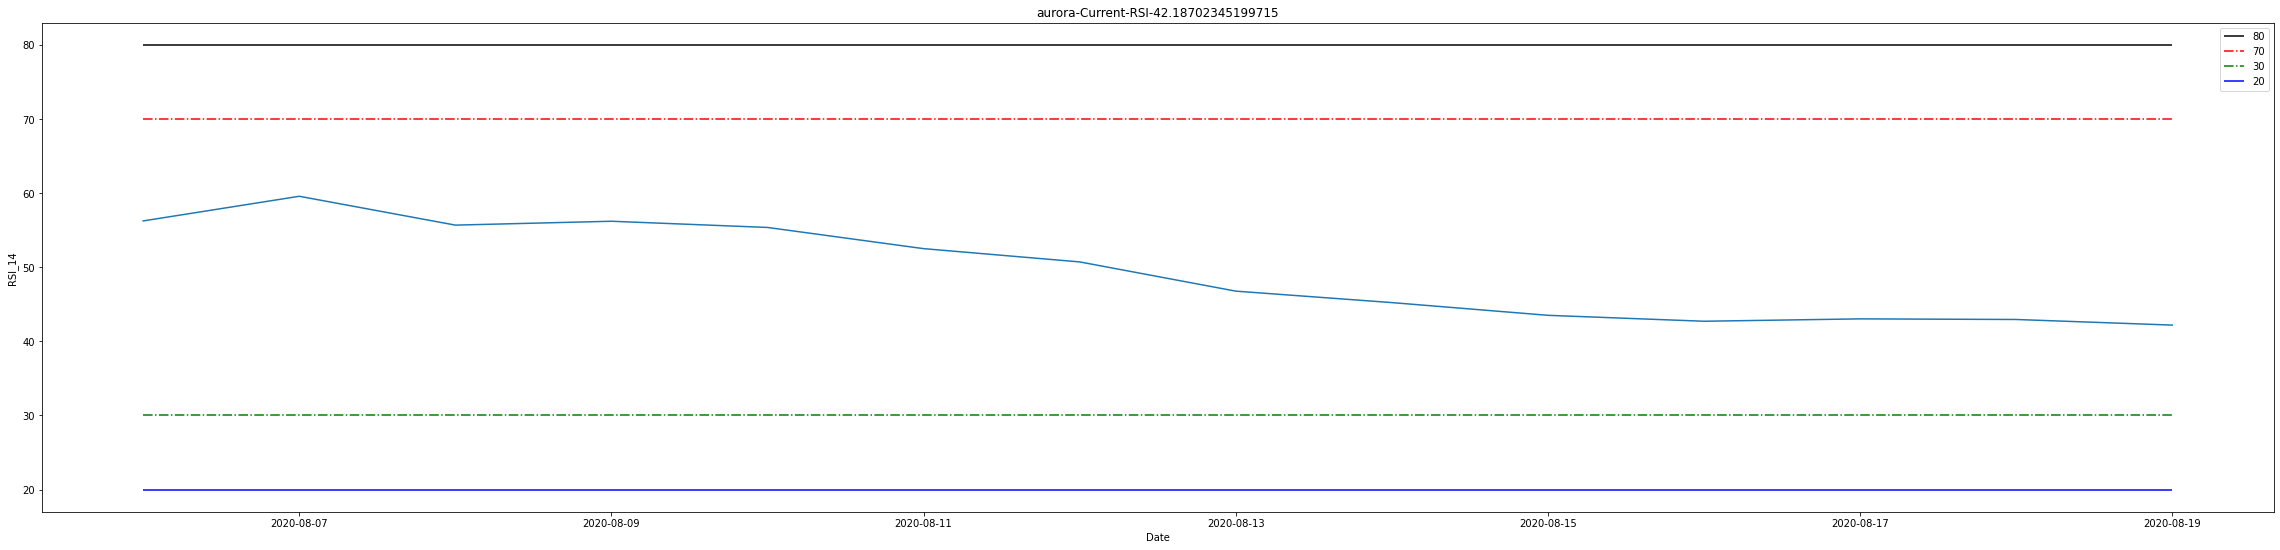

Plotting RSI (61.808167921094196) for:  eden


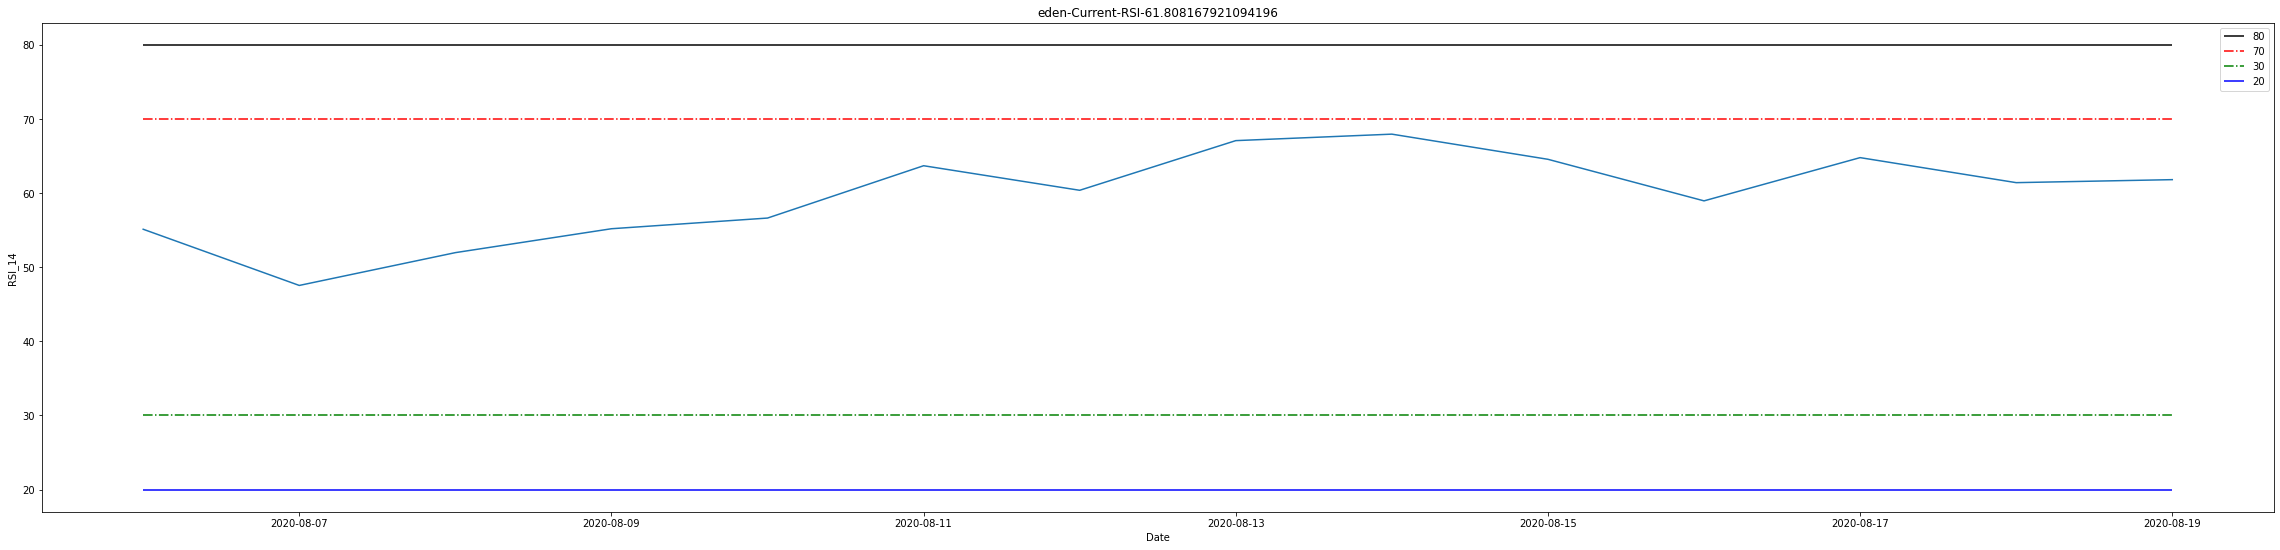

Plotting RSI (56.5802122055759) for:  cargox


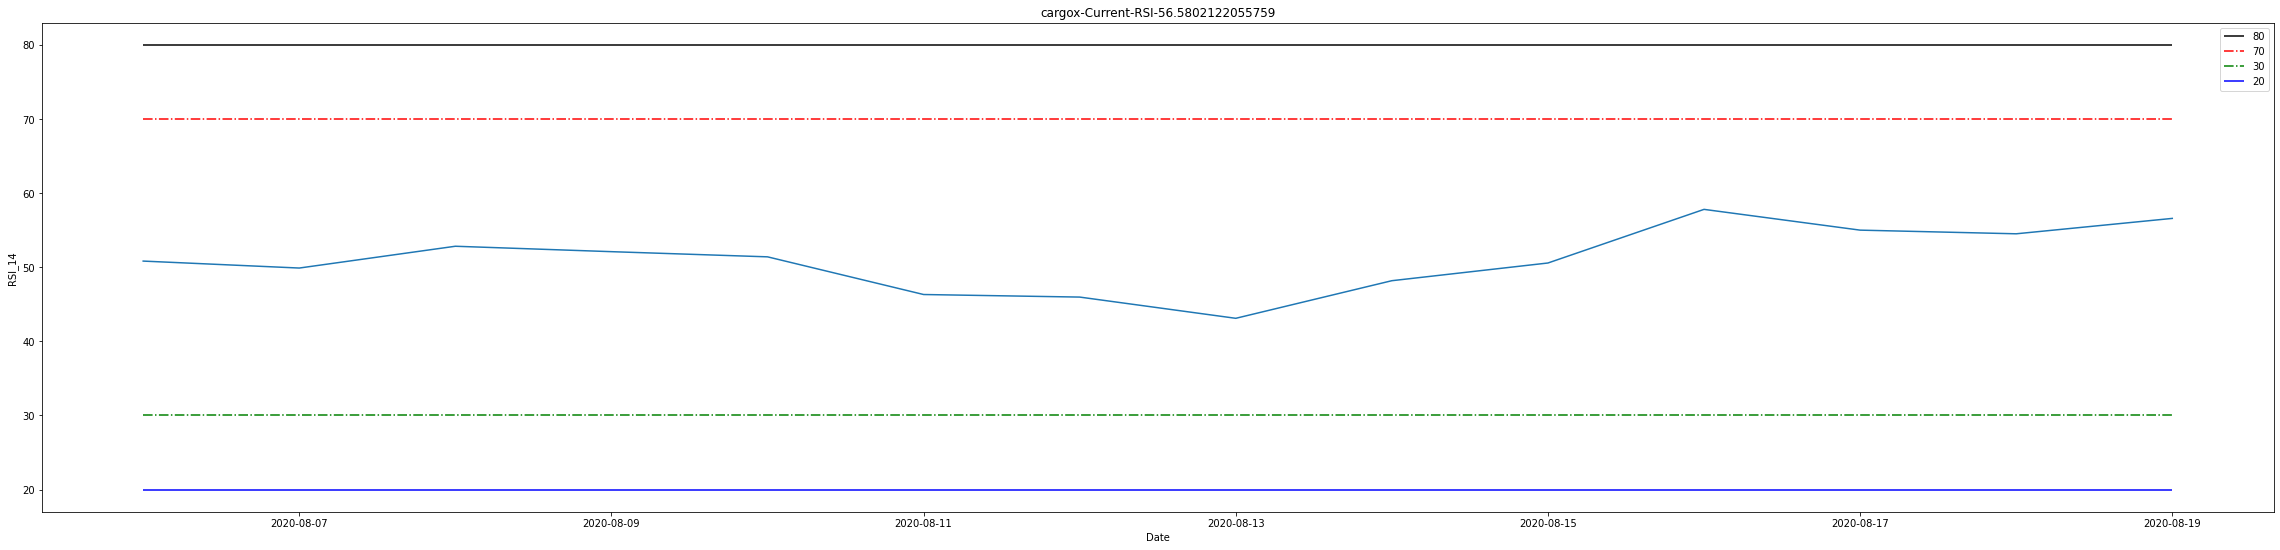

Plotting RSI (51.92610201219375) for:  plutusdefi


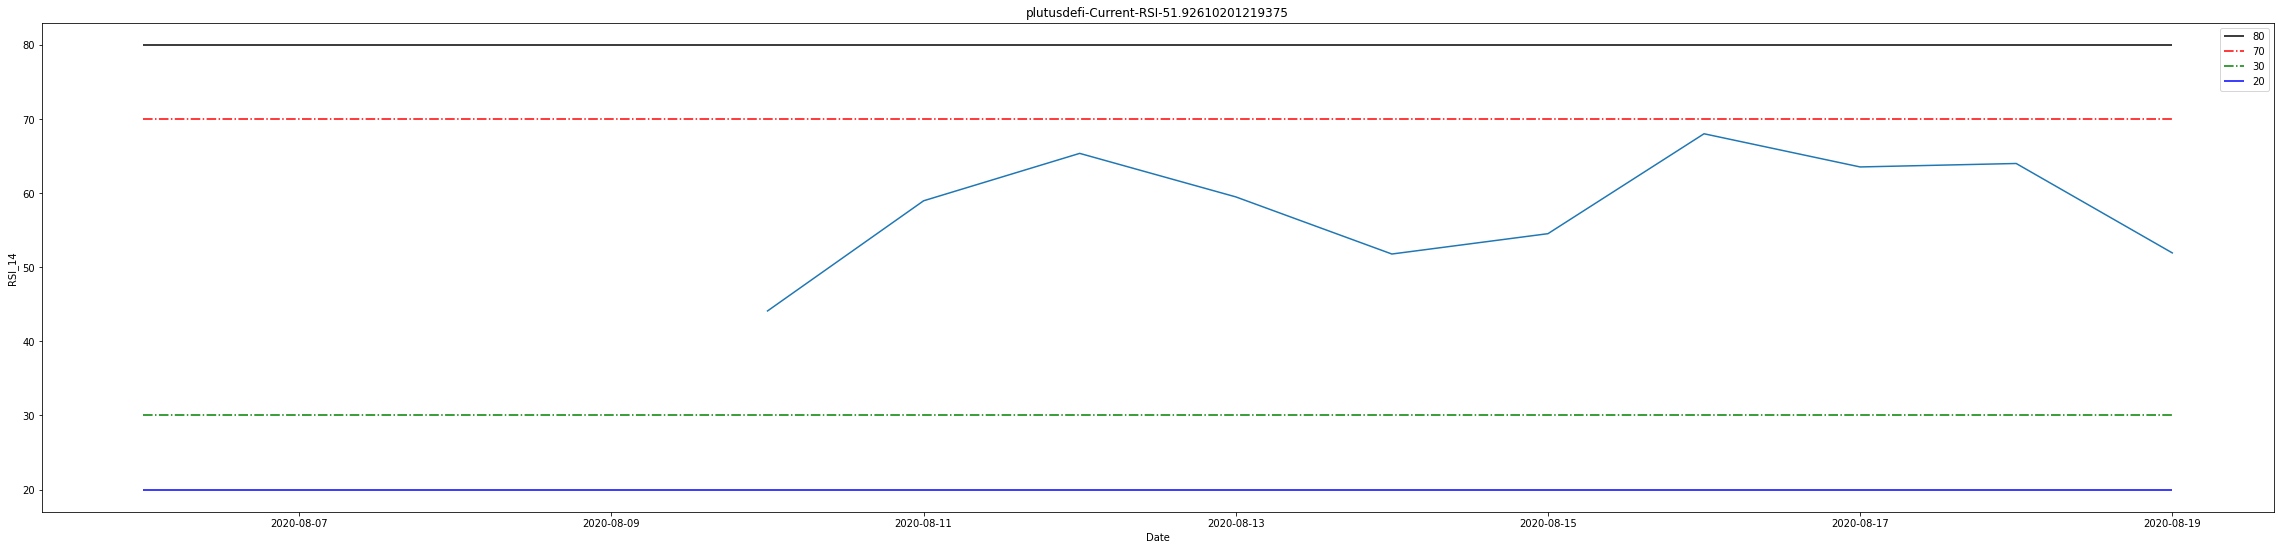

Plotting RSI (51.799236740673265) for:  kyber-network


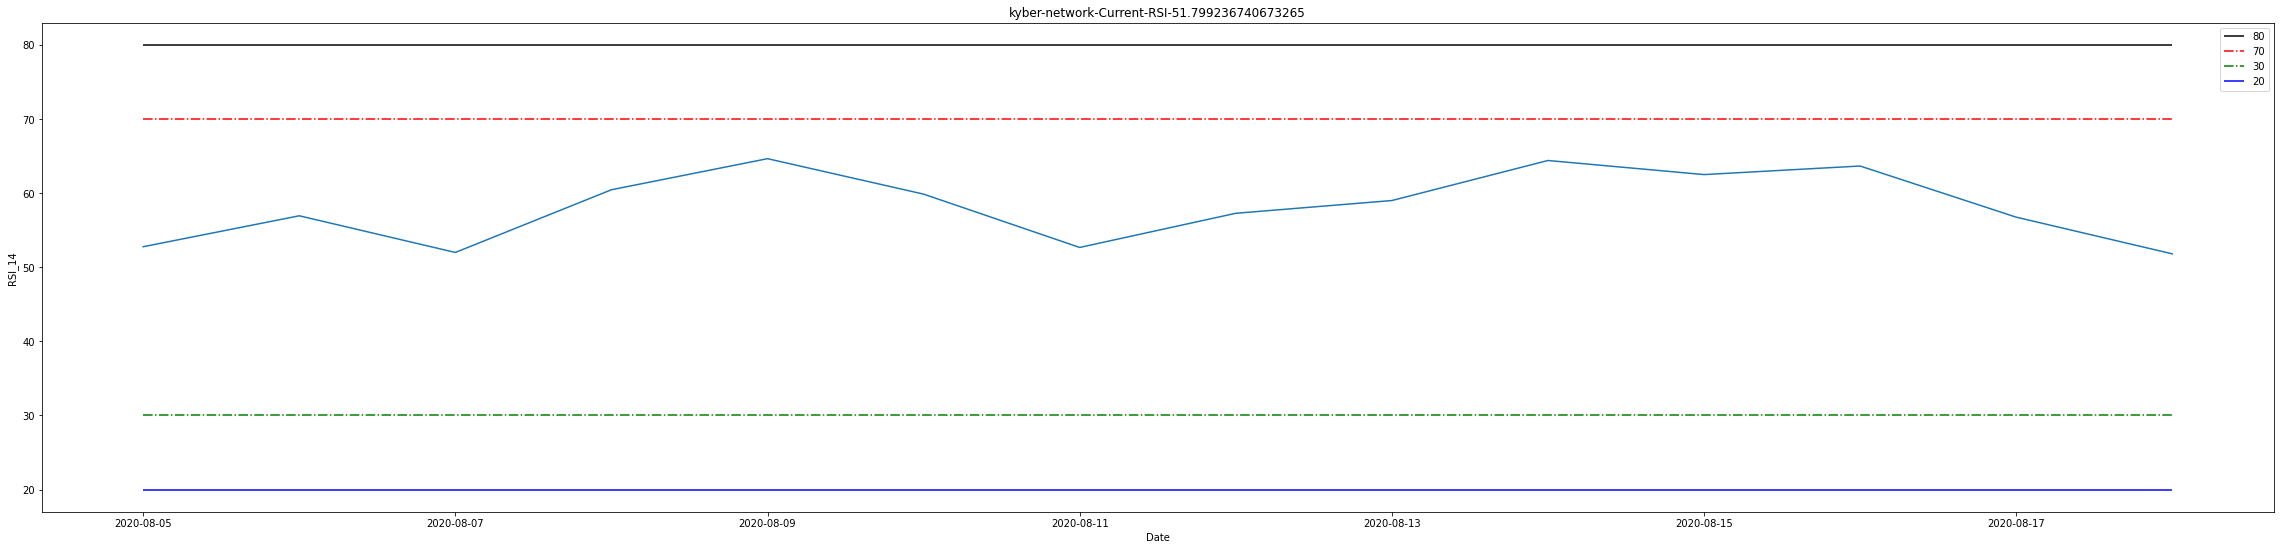

Plotting RSI (57.9085565365131) for:  waves-enterprise


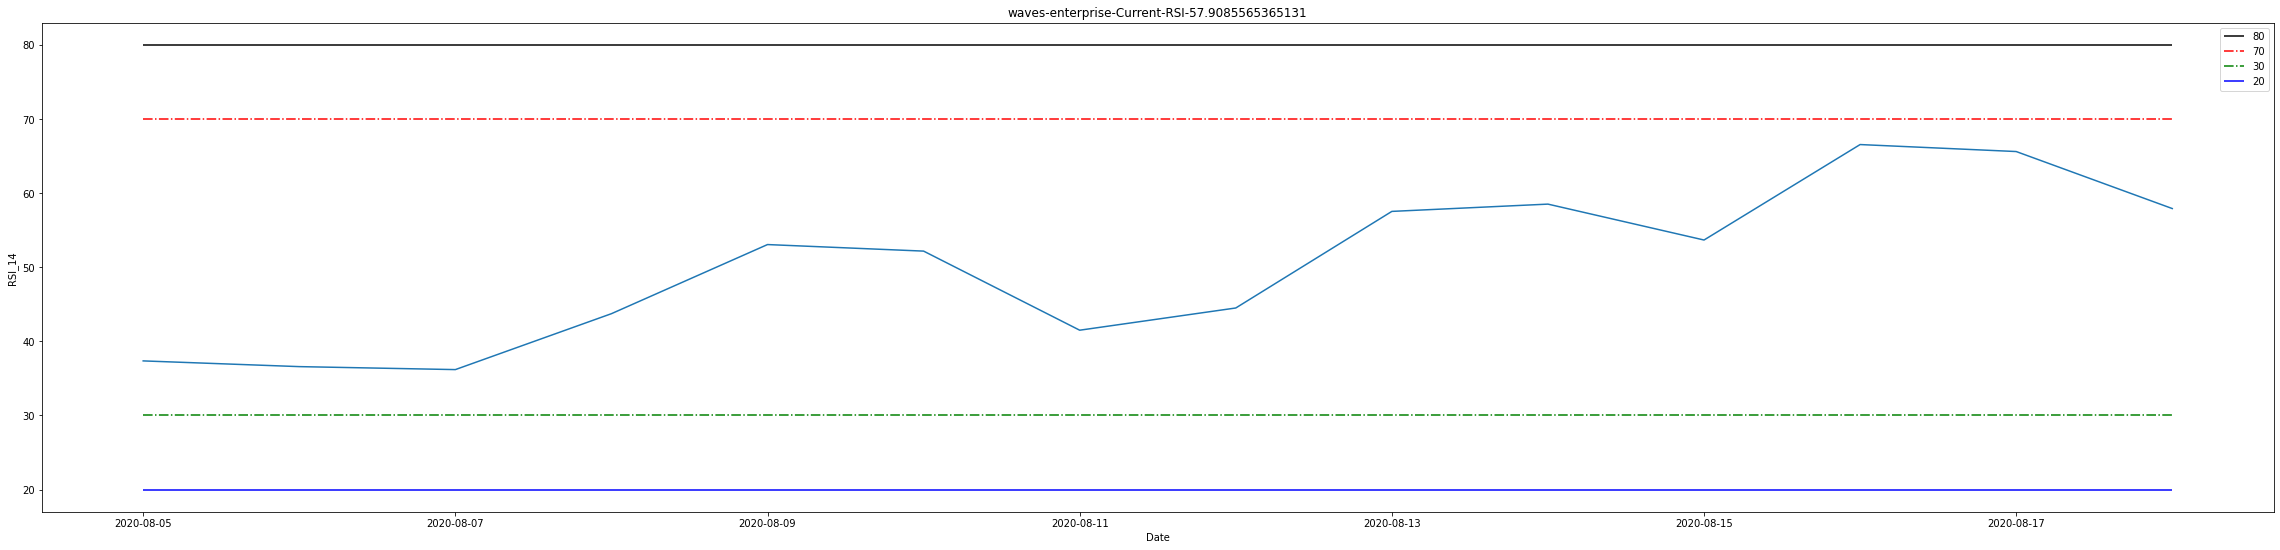

Plotting RSI (78.13353190050108) for:  loom-network


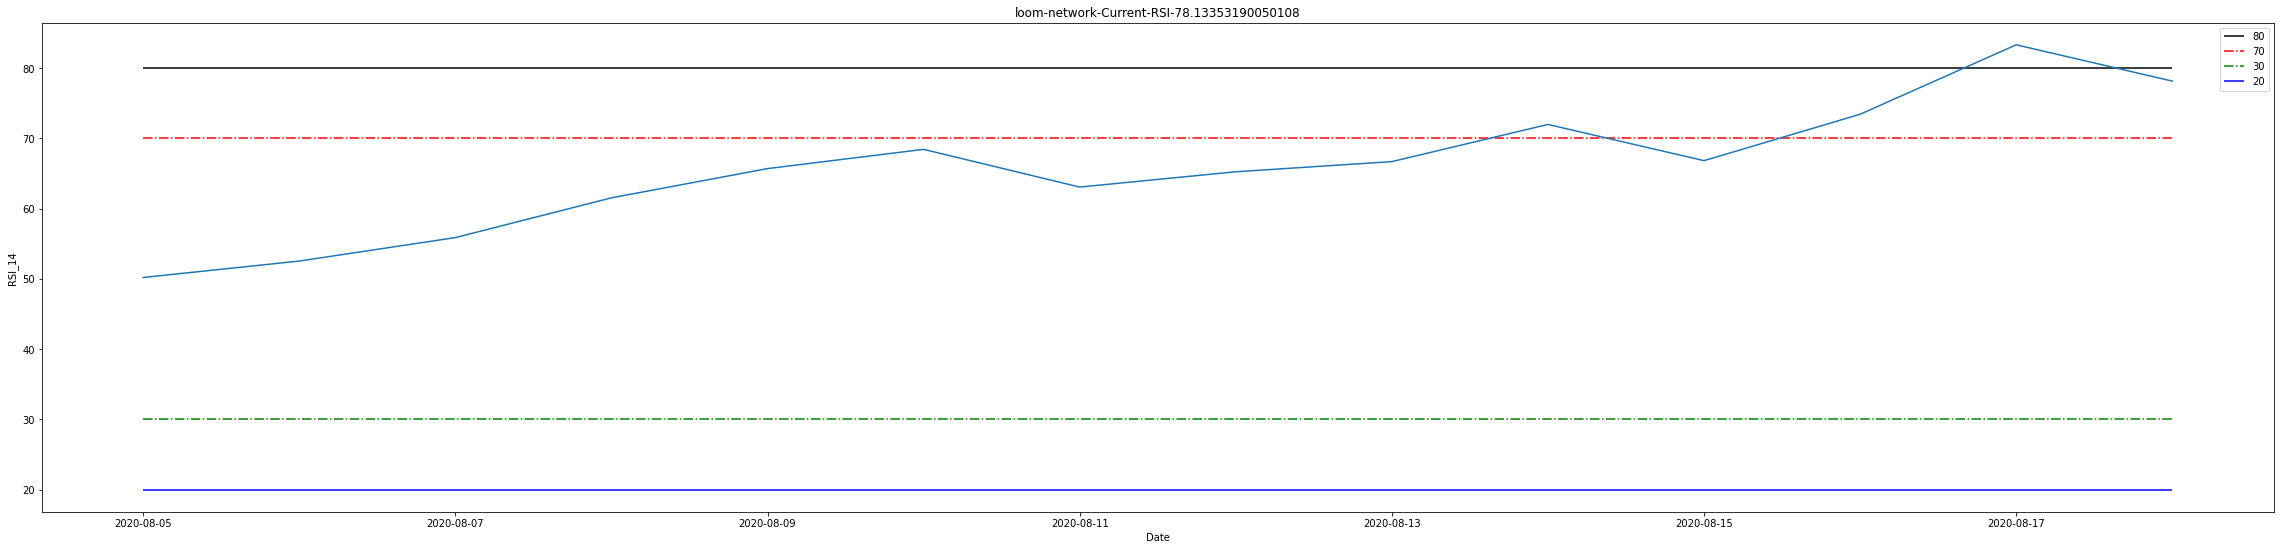

Plotting RSI (67.24229985350424) for:  aergo


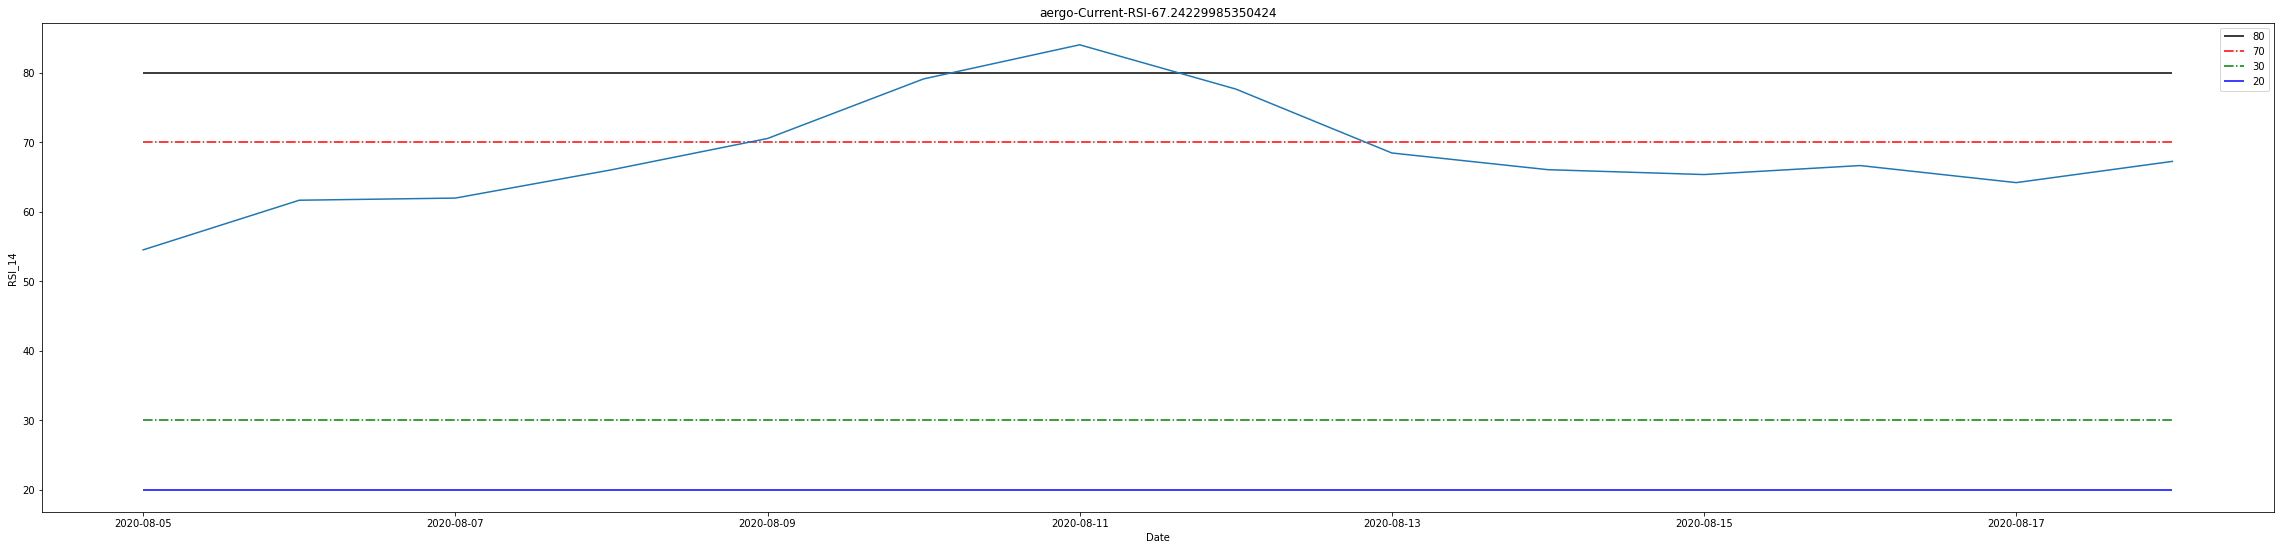

Plotting RSI (53.96952481139454) for:  zcash


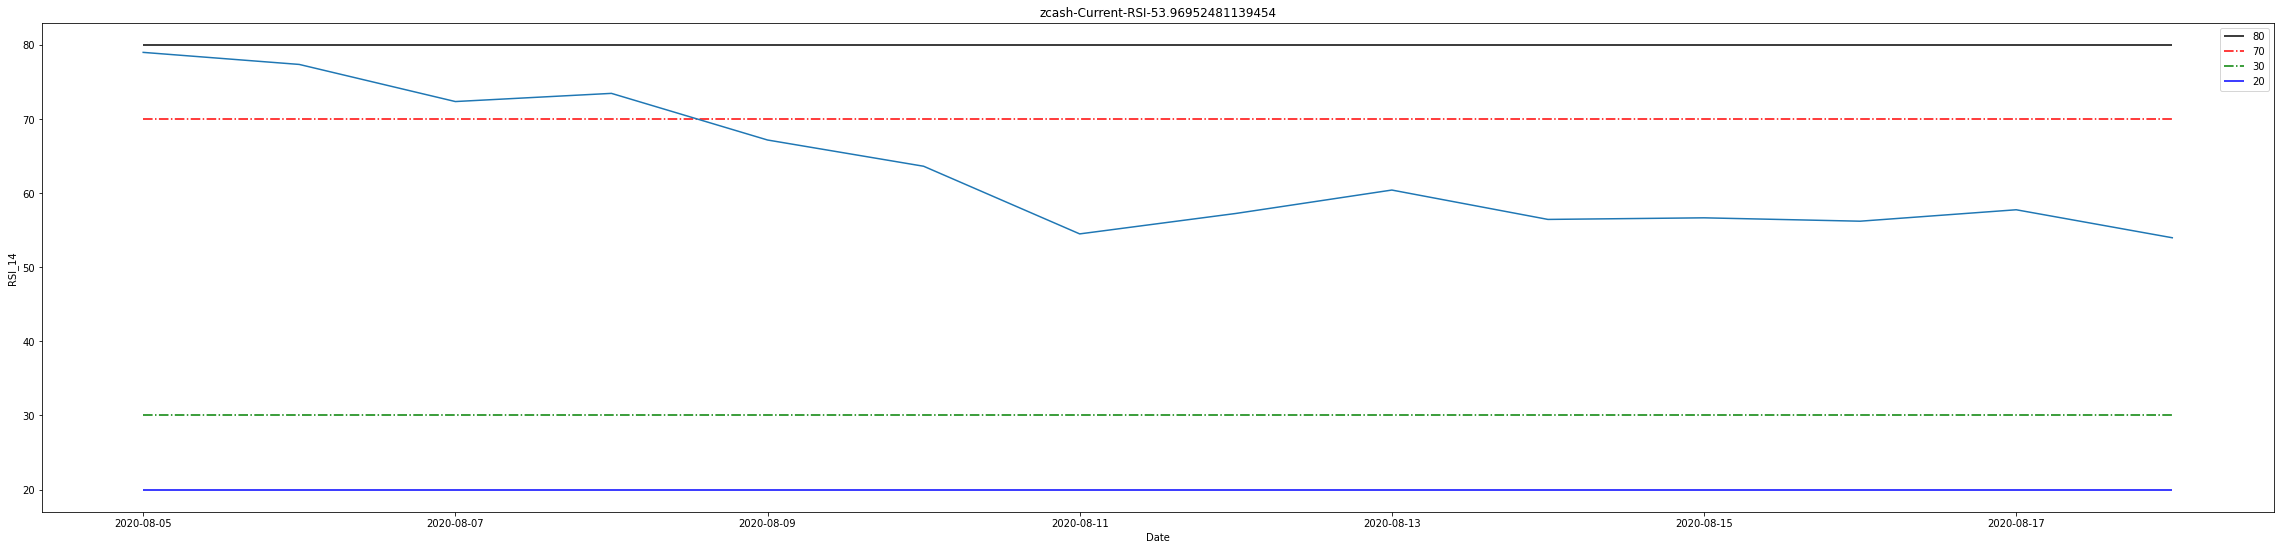

Plotting RSI (54.56160707385814) for:  function-x


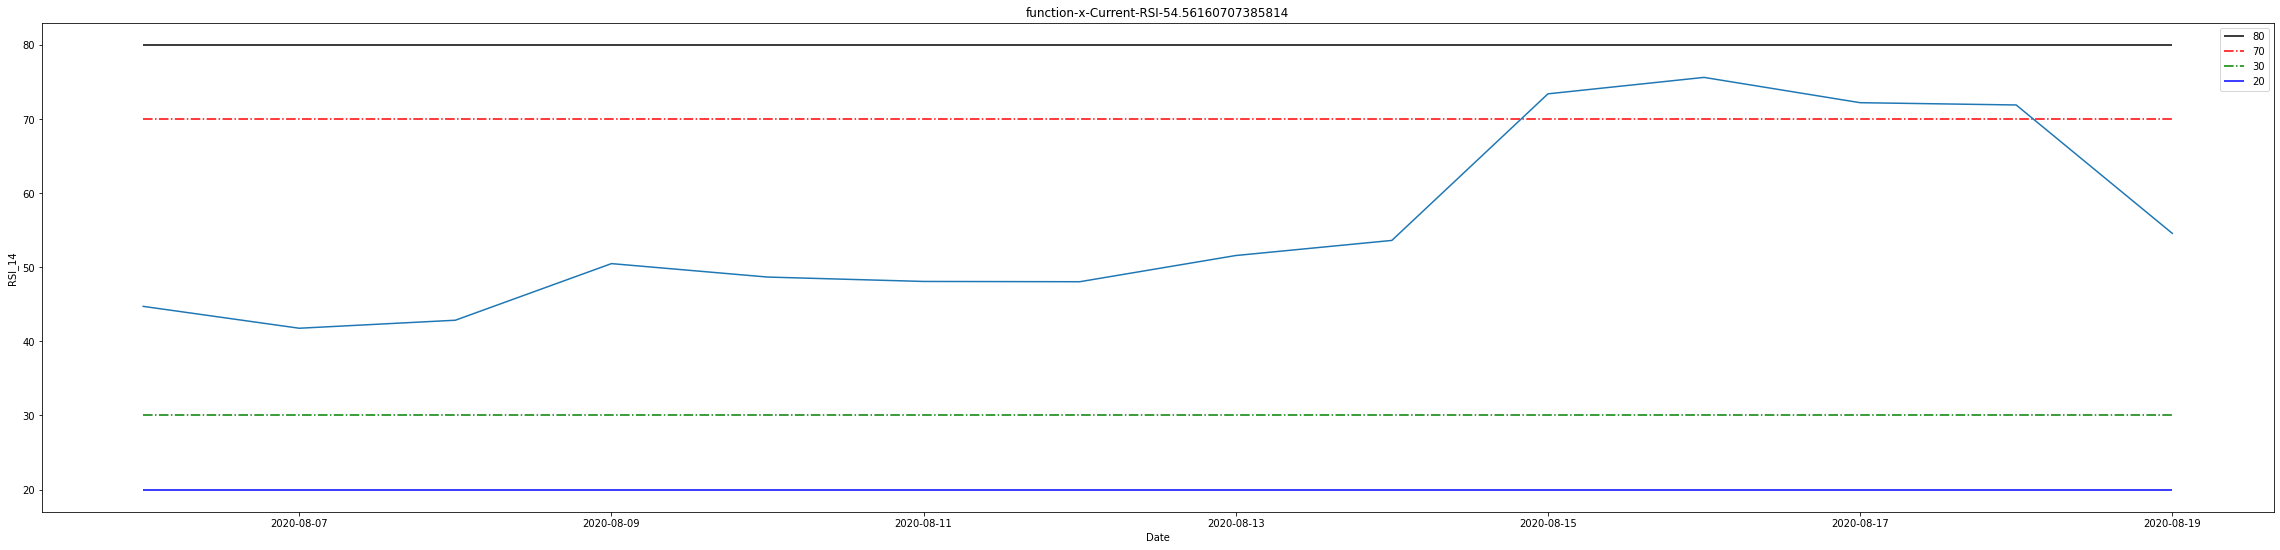

Plotting RSI (56.23172805106147) for:  lockchain


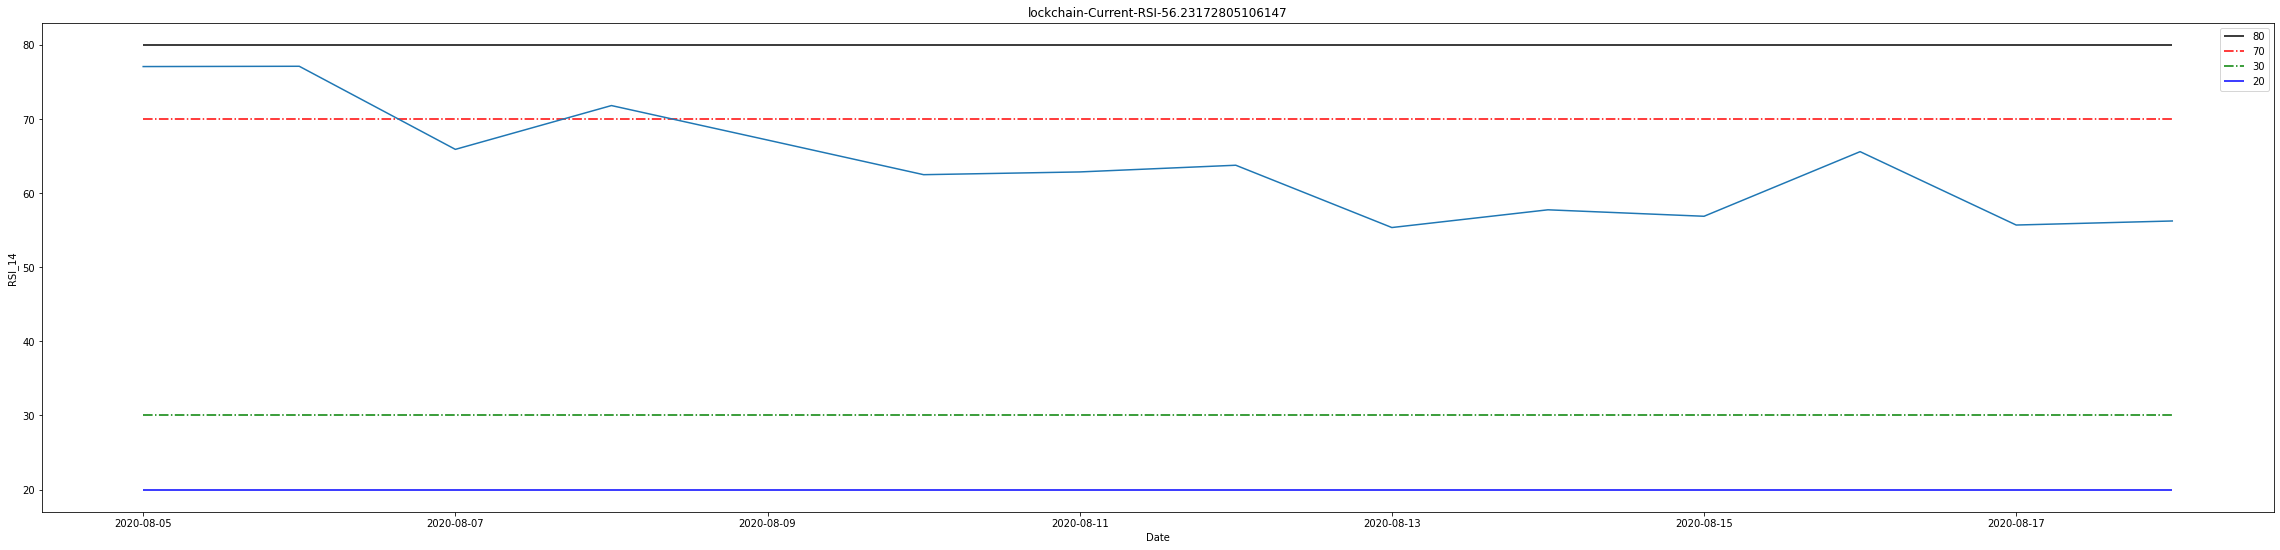

Plotting RSI (52.62895313415834) for:  paybx


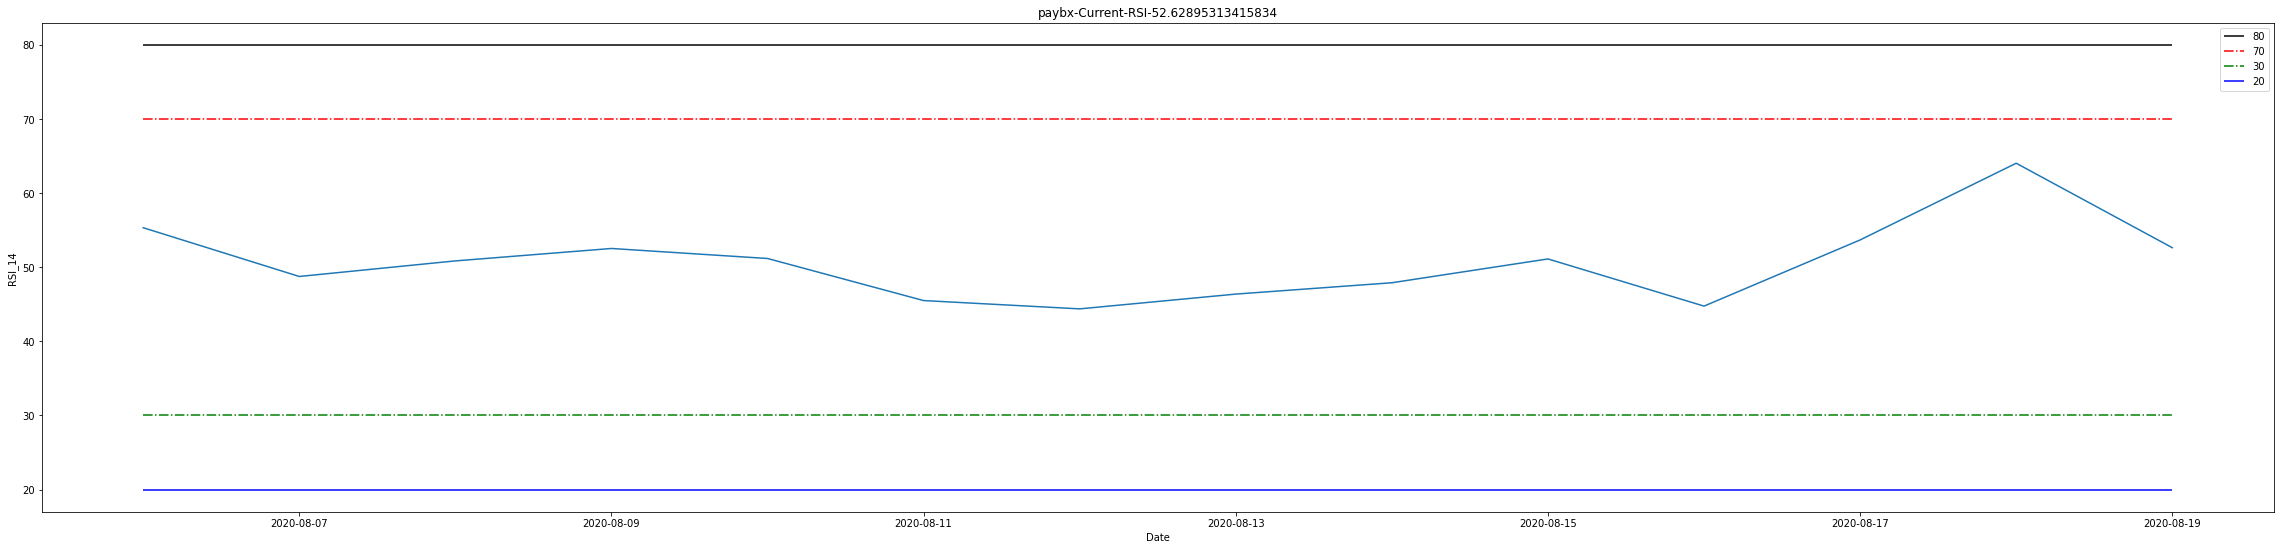

Plotting RSI (46.728036733818435) for:  ethereum-classic


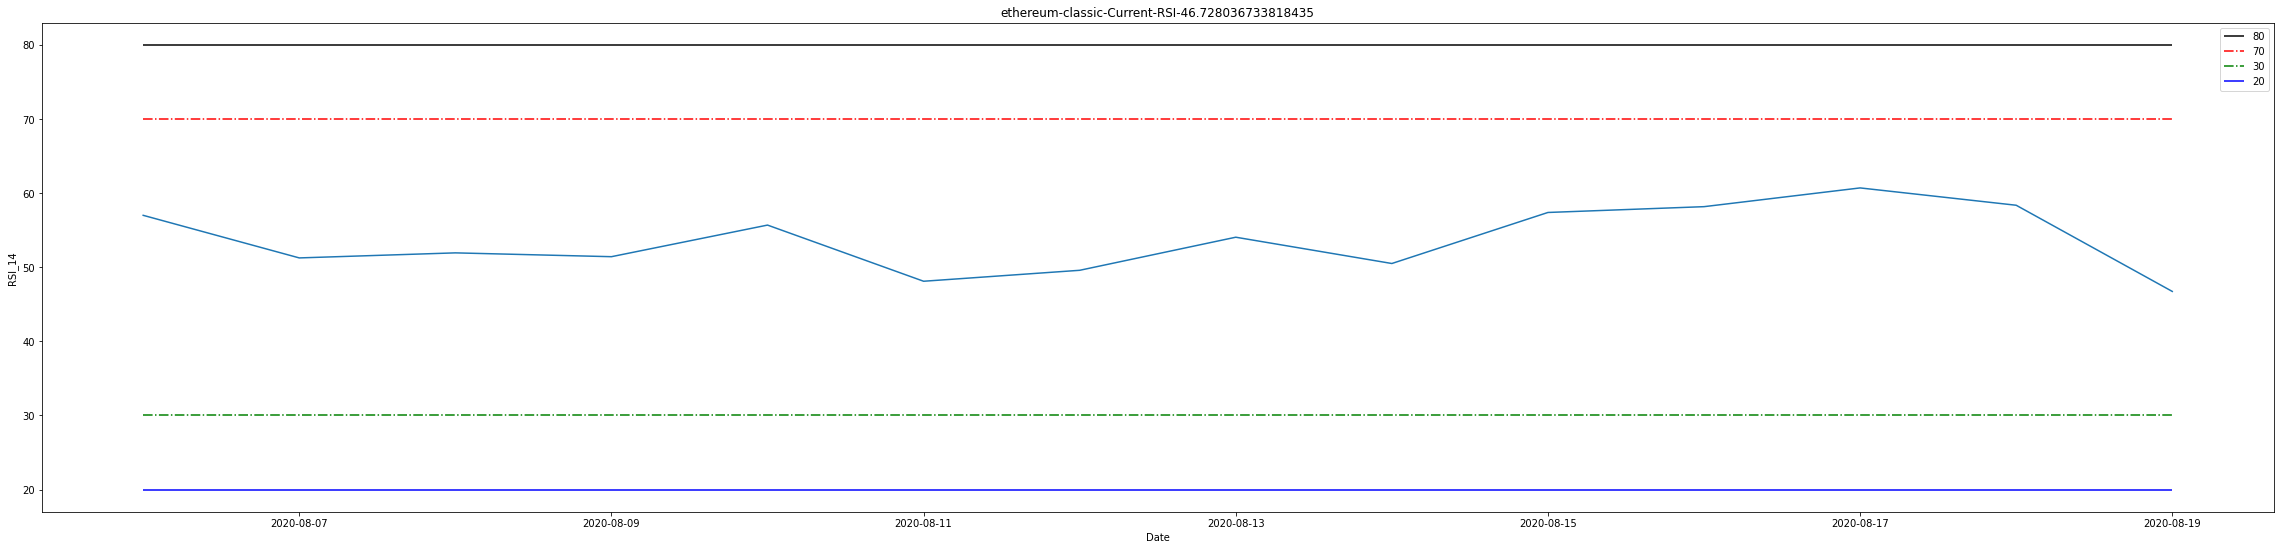

Plotting RSI (48.49580139845857) for:  crpt


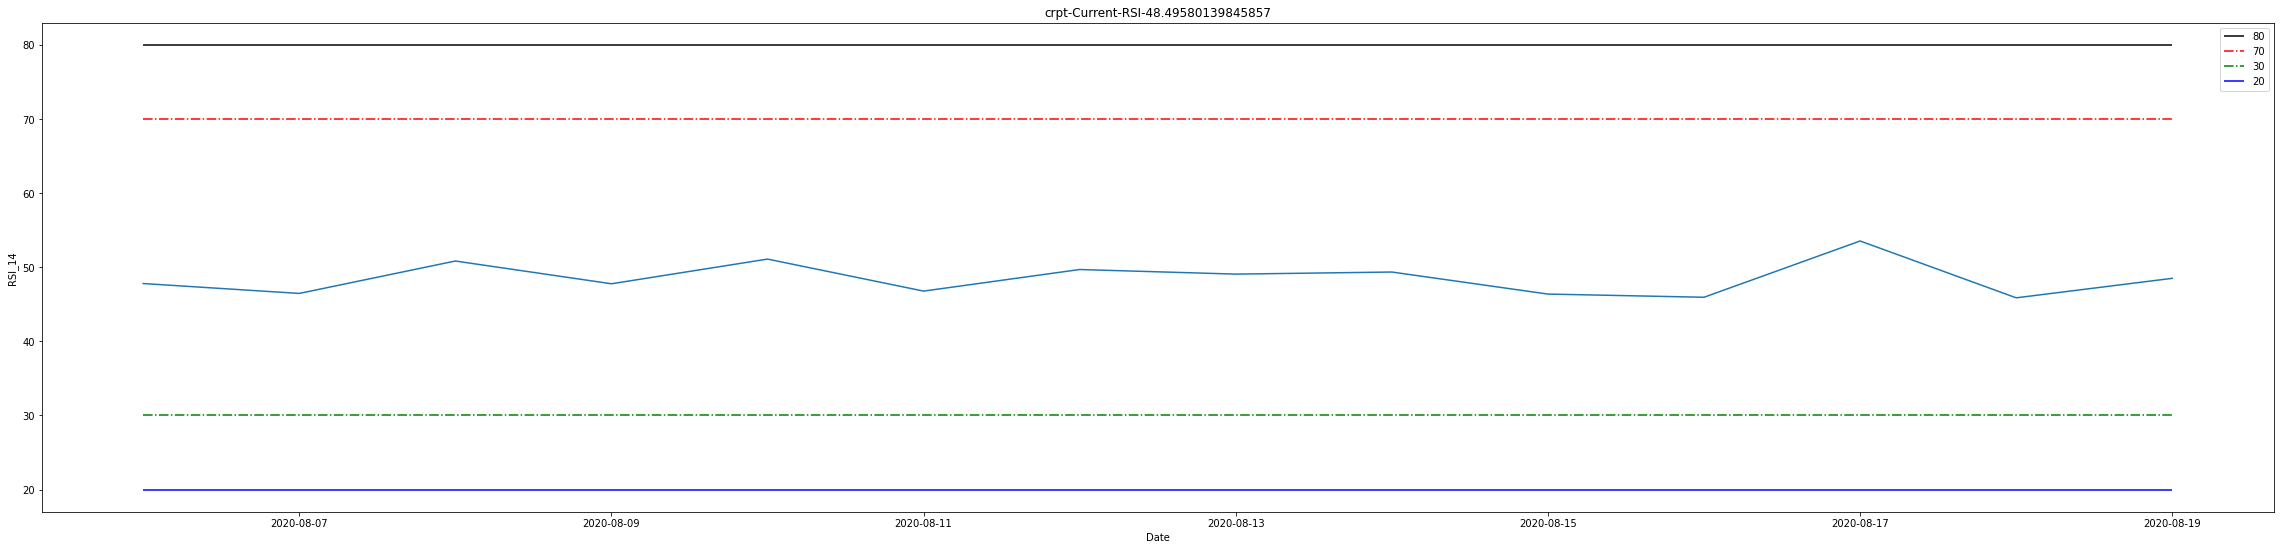

Plotting RSI (66.29901465676099) for:  algorand


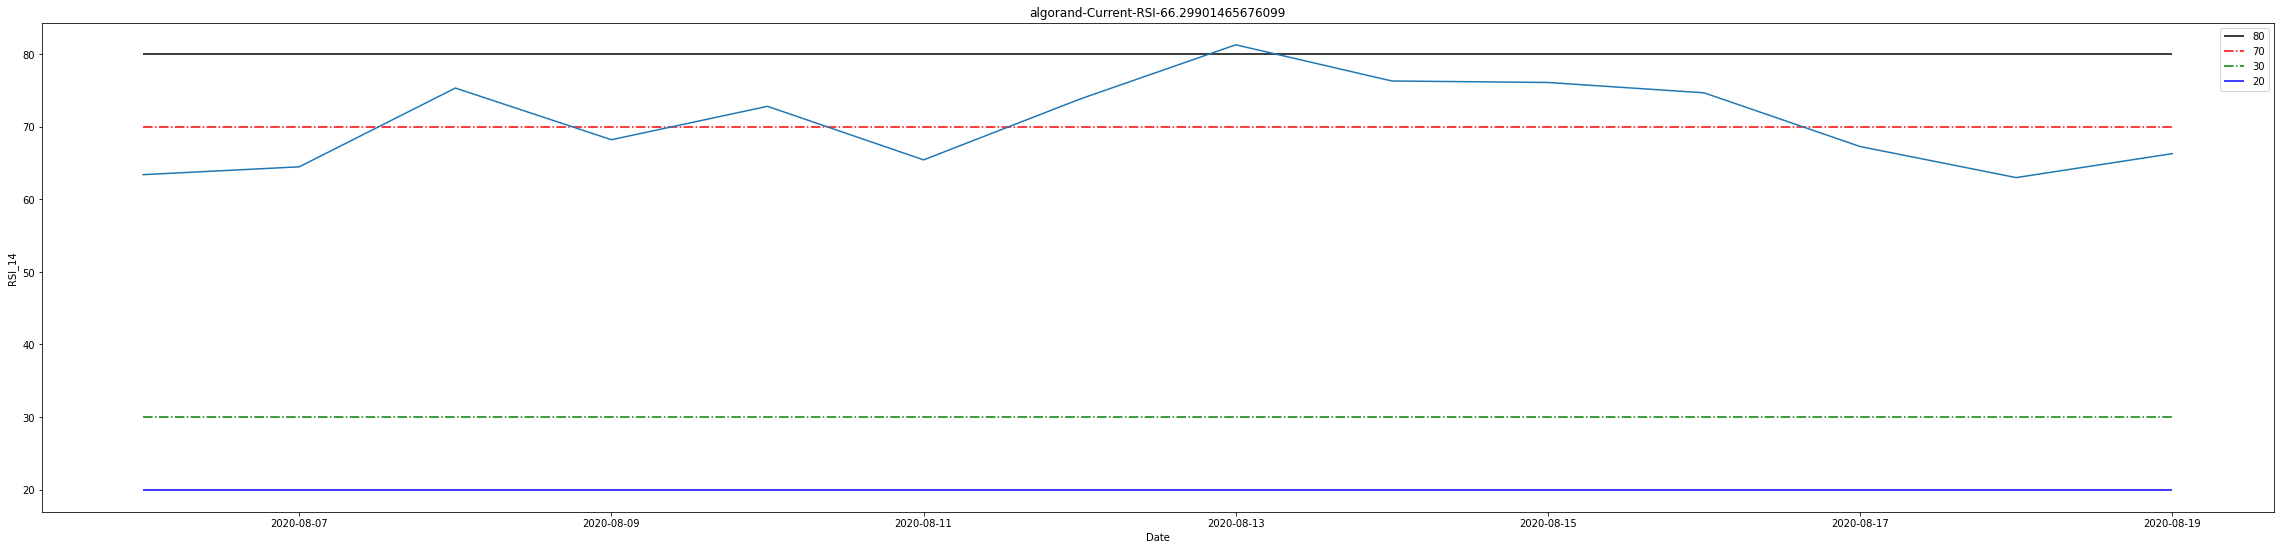

Plotting RSI (60.41340412348351) for:  blockport


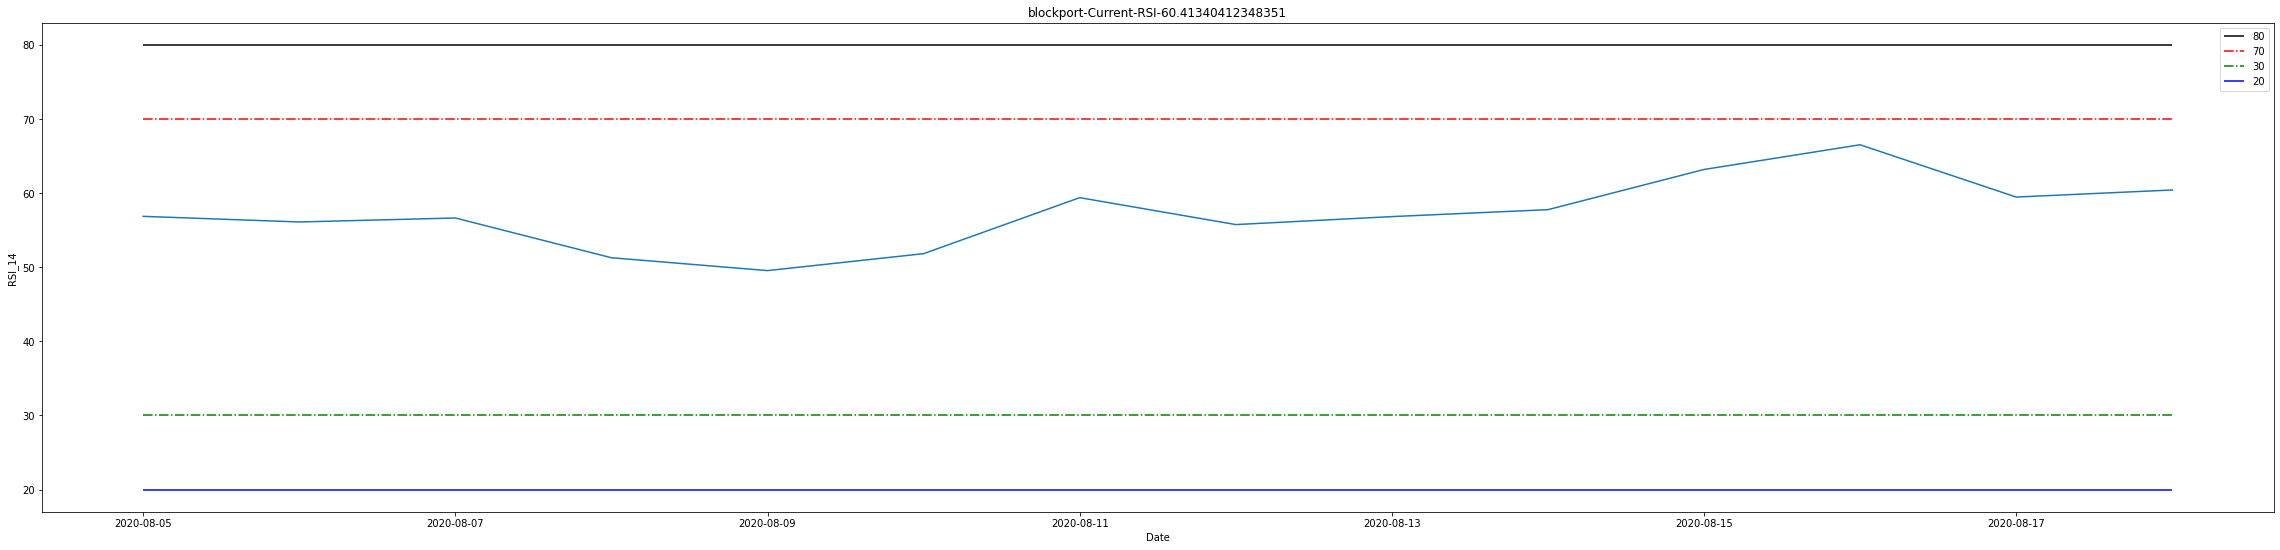

Plotting RSI (nan) for:  gramgold-coin


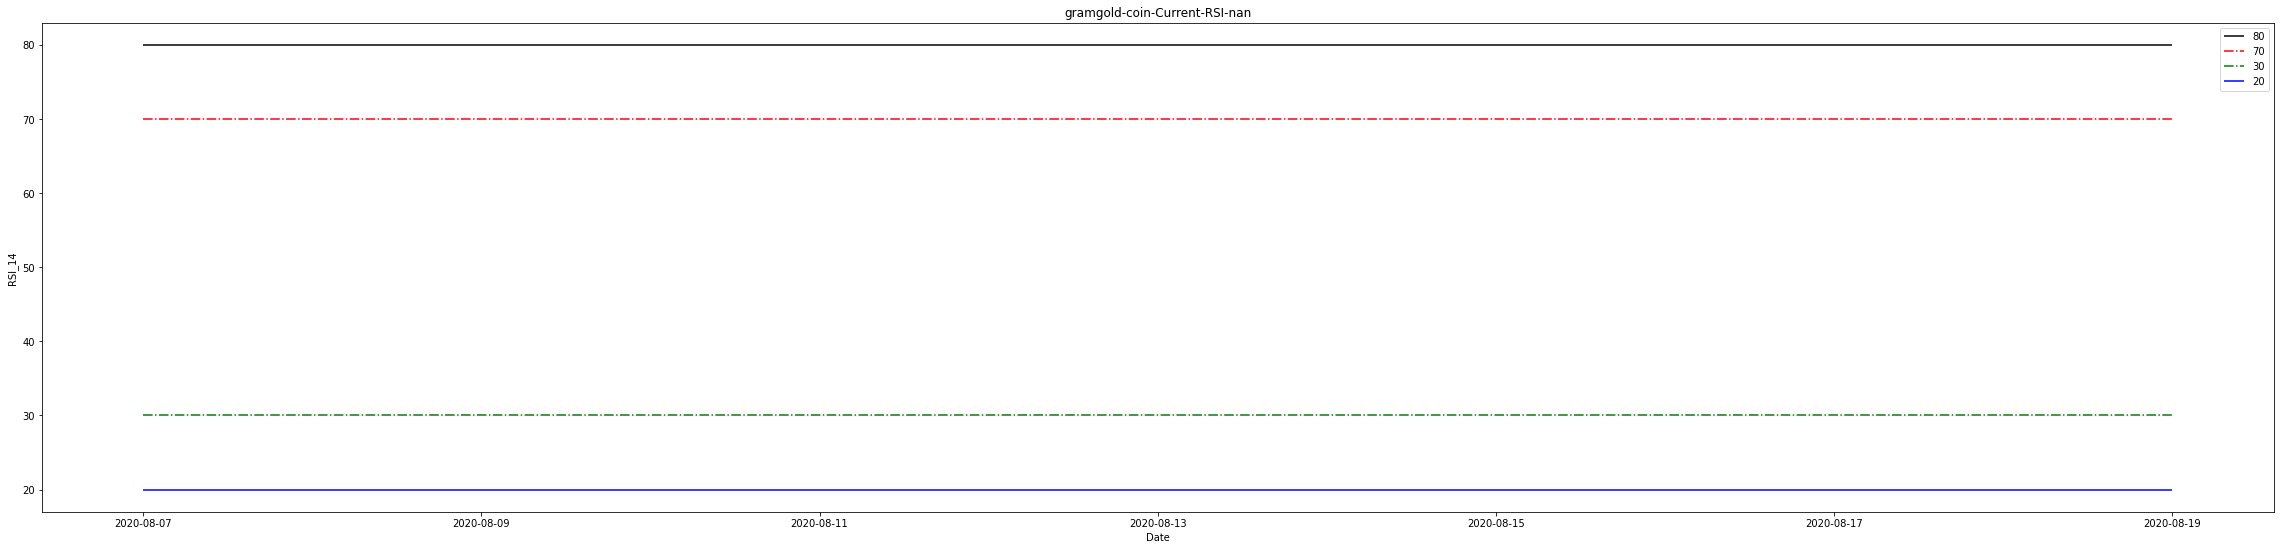

Plotting RSI (70.7837854068253) for:  ocean-protocol


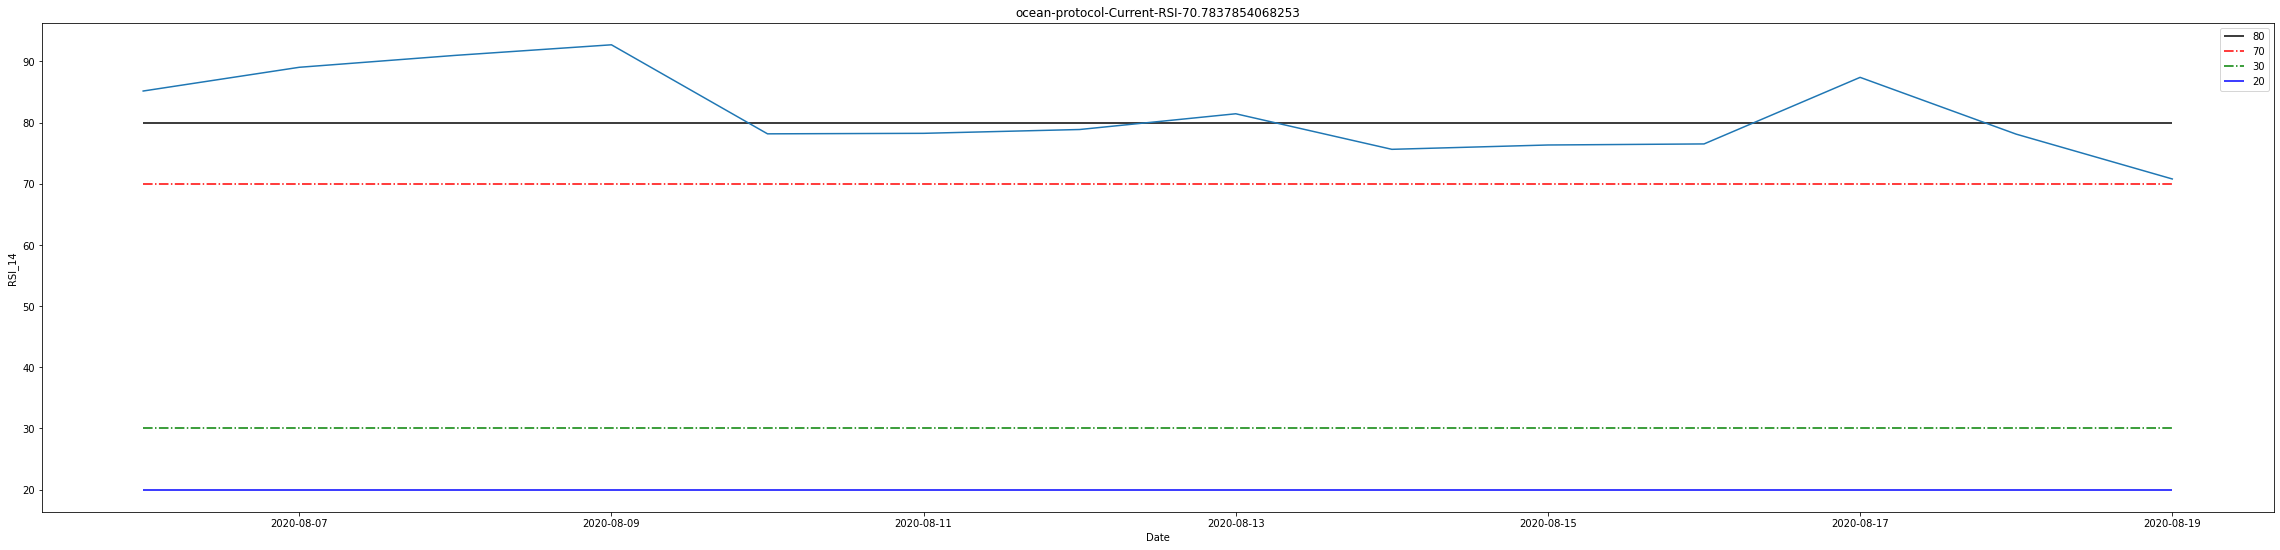

Plotting RSI (52.54829742167485) for:  decred


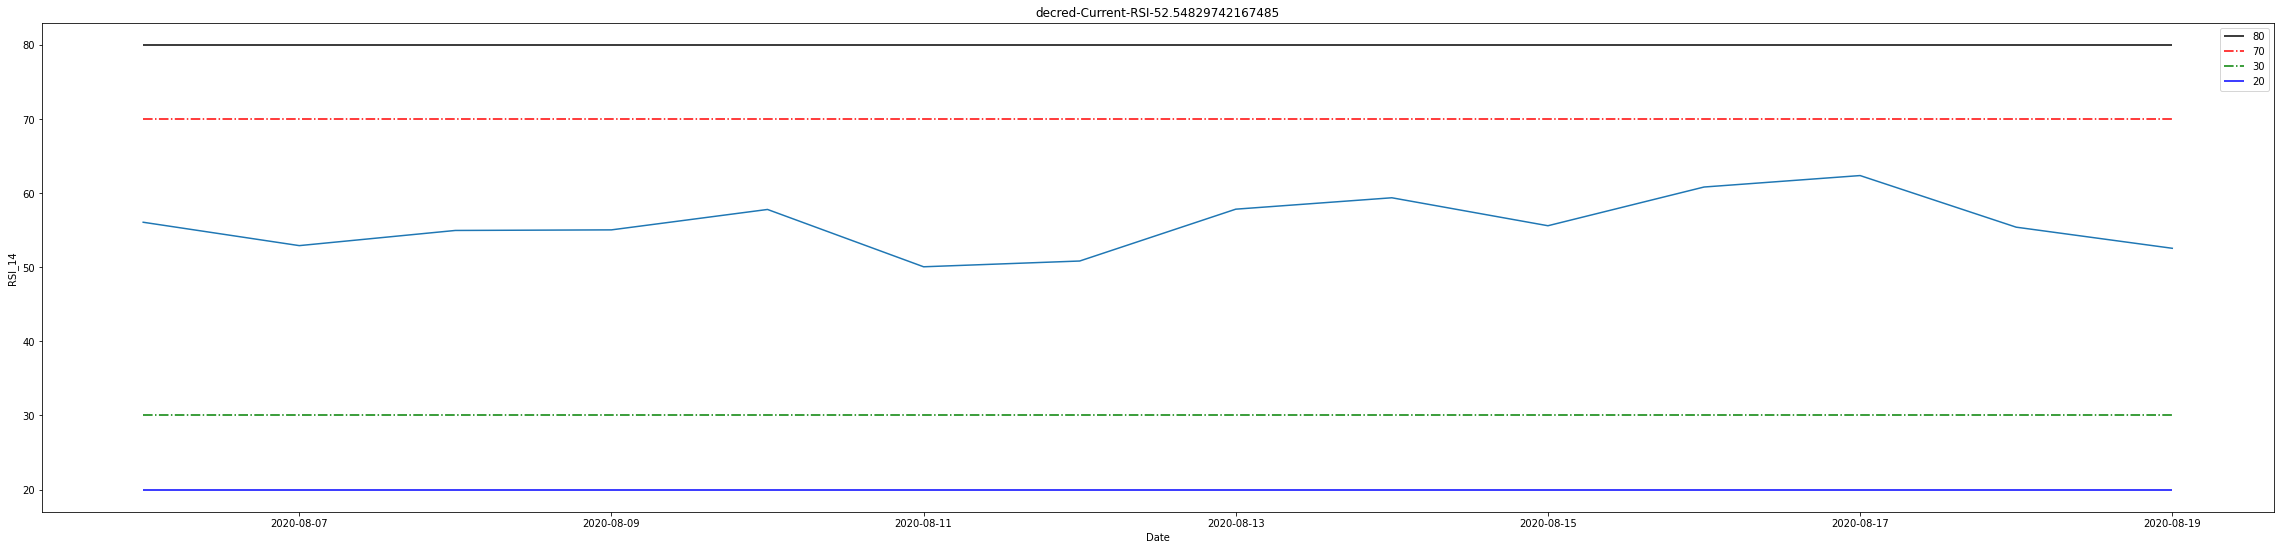

Plotting RSI (69.42068172231946) for:  singularitynet


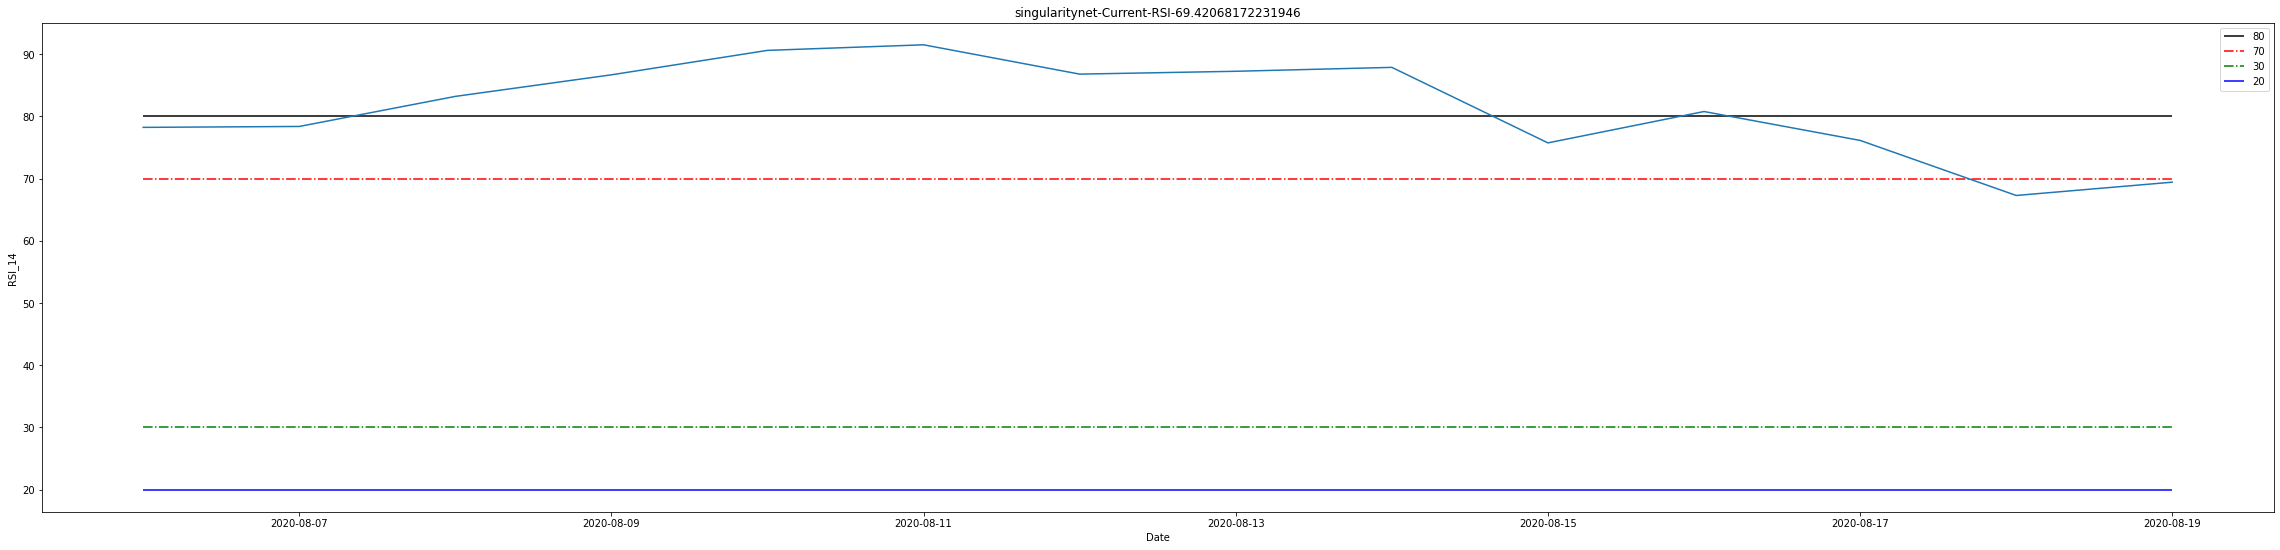

Plotting RSI (80.10735262354986) for:  fantom


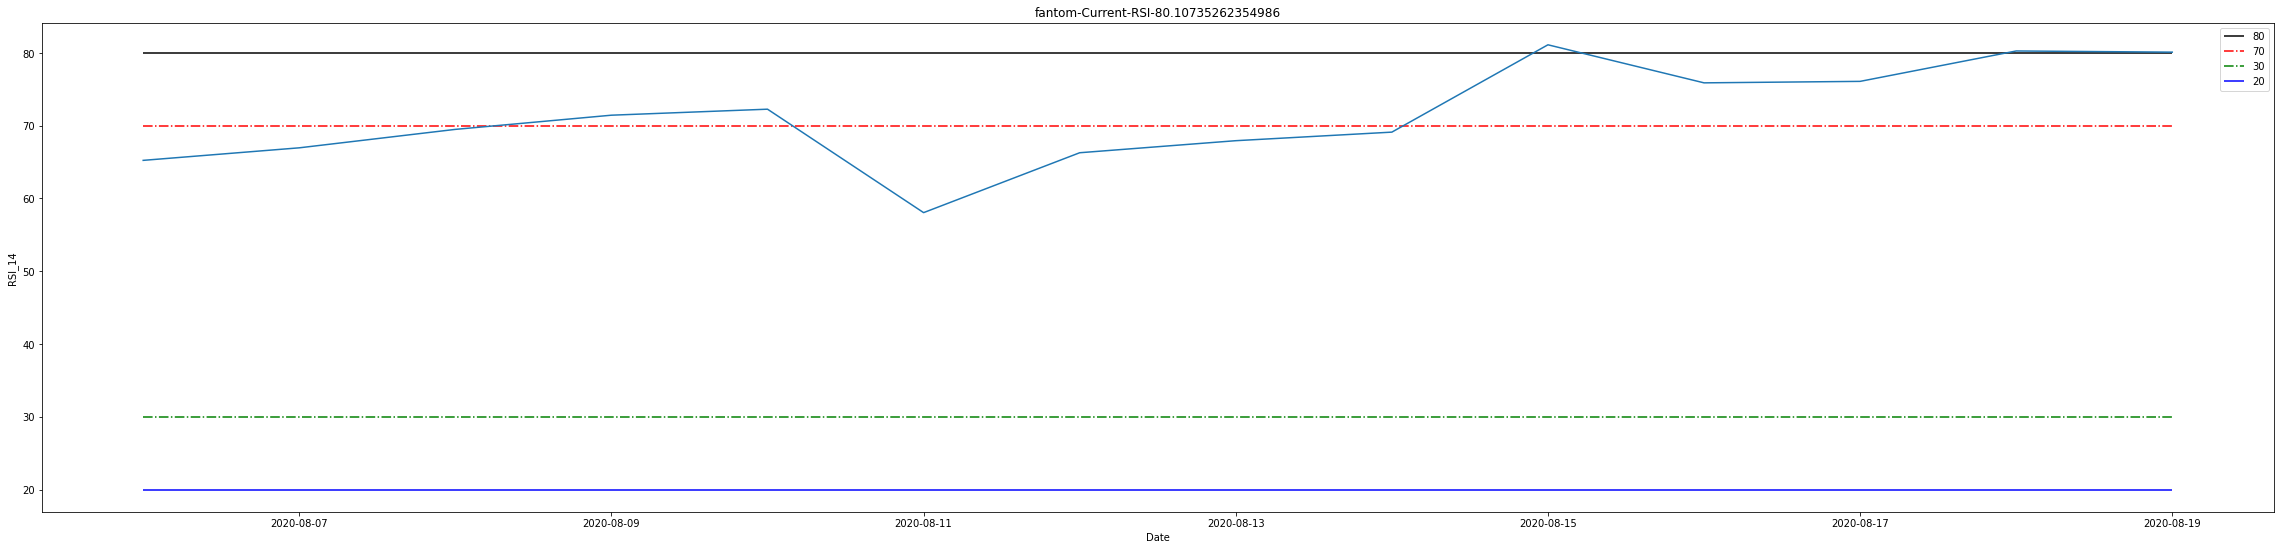

Plotting RSI (78.22257924417411) for:  marcopolo-protocol


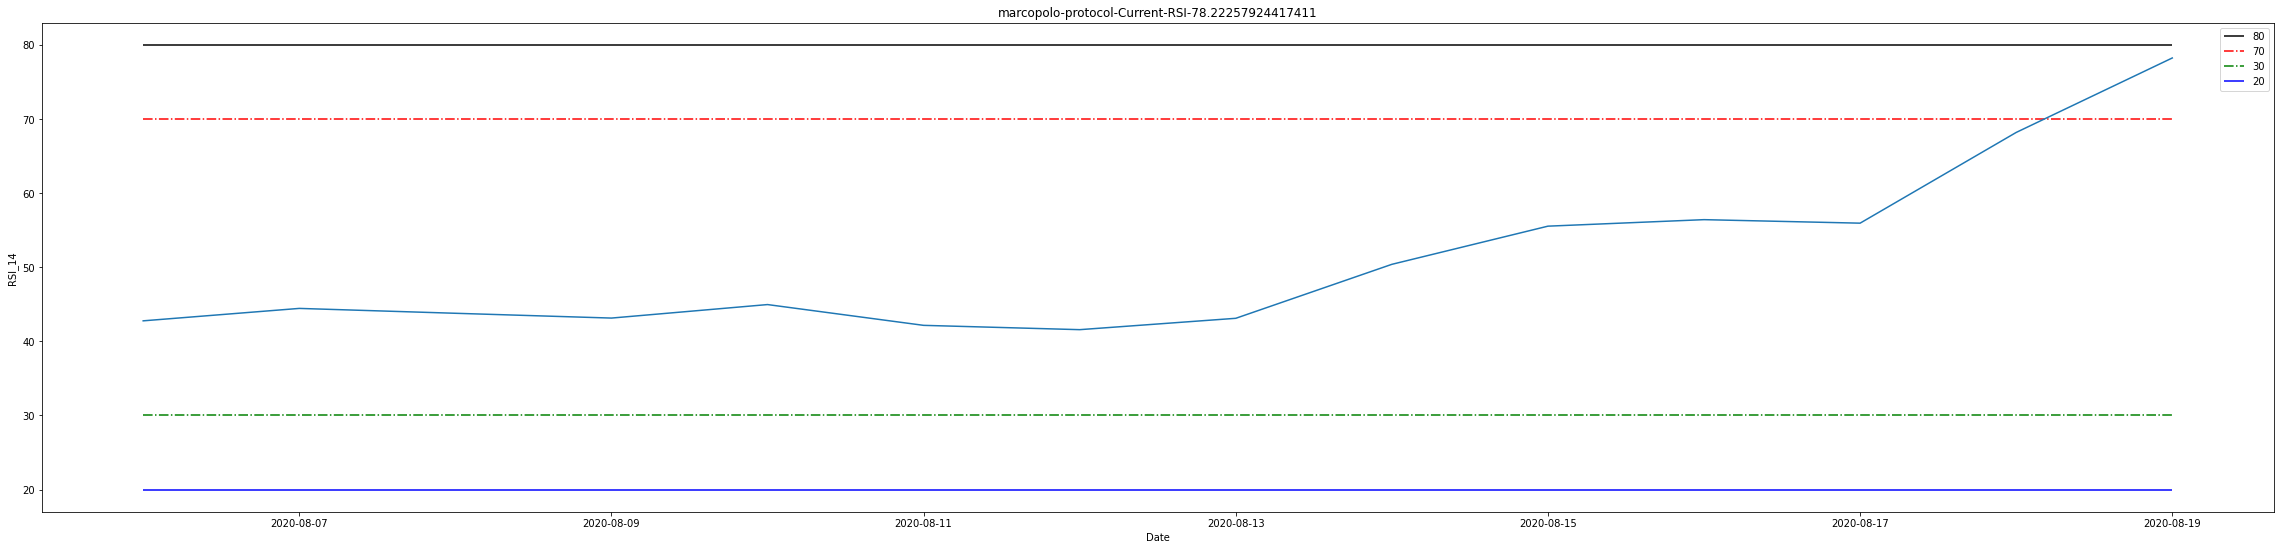

Plotting RSI (49.254203925809065) for:  wom-protocol


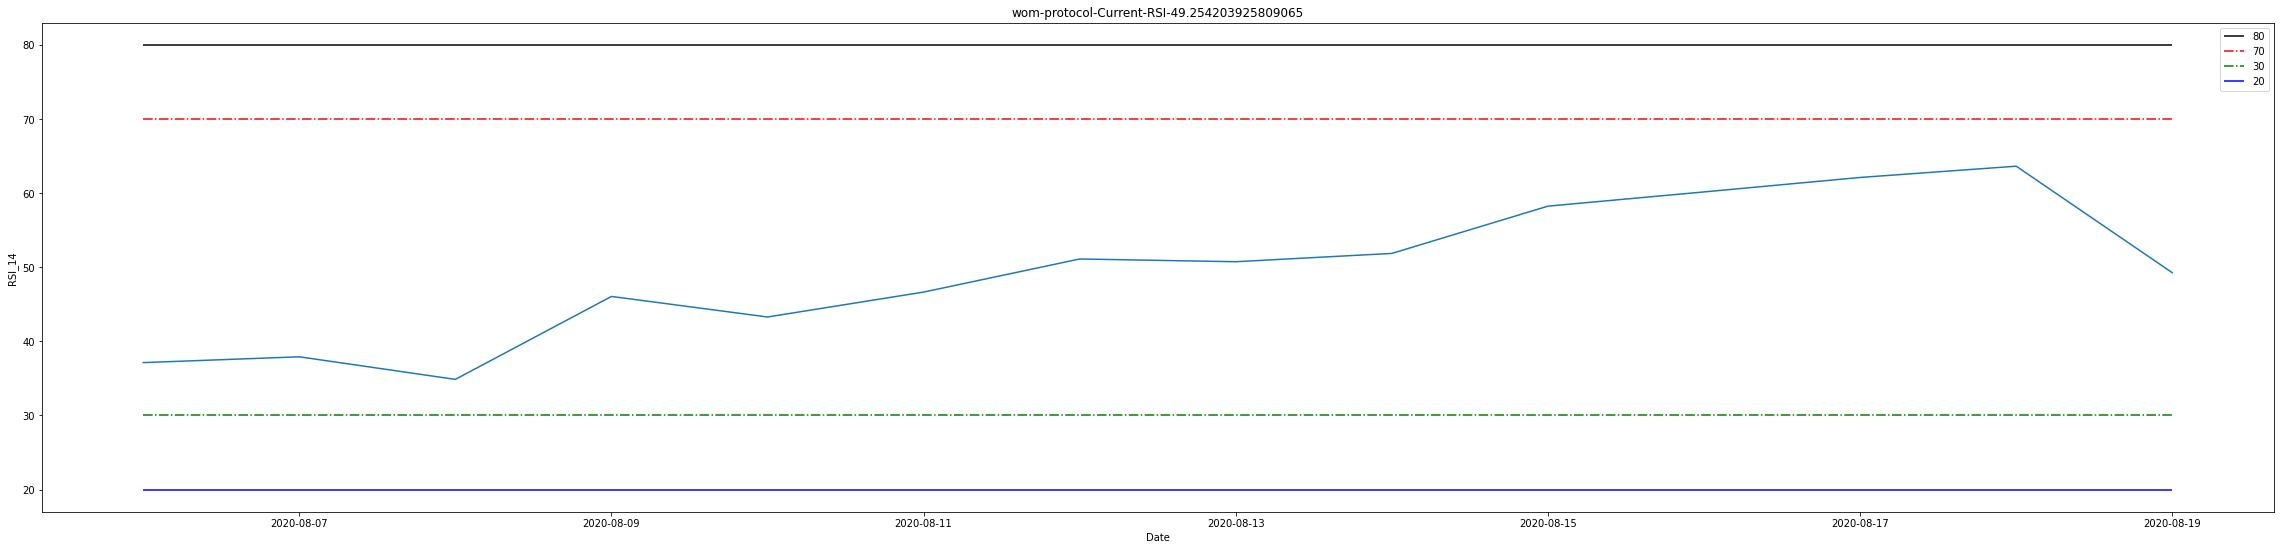

Plotting RSI (69.31209481074985) for:  phantasma


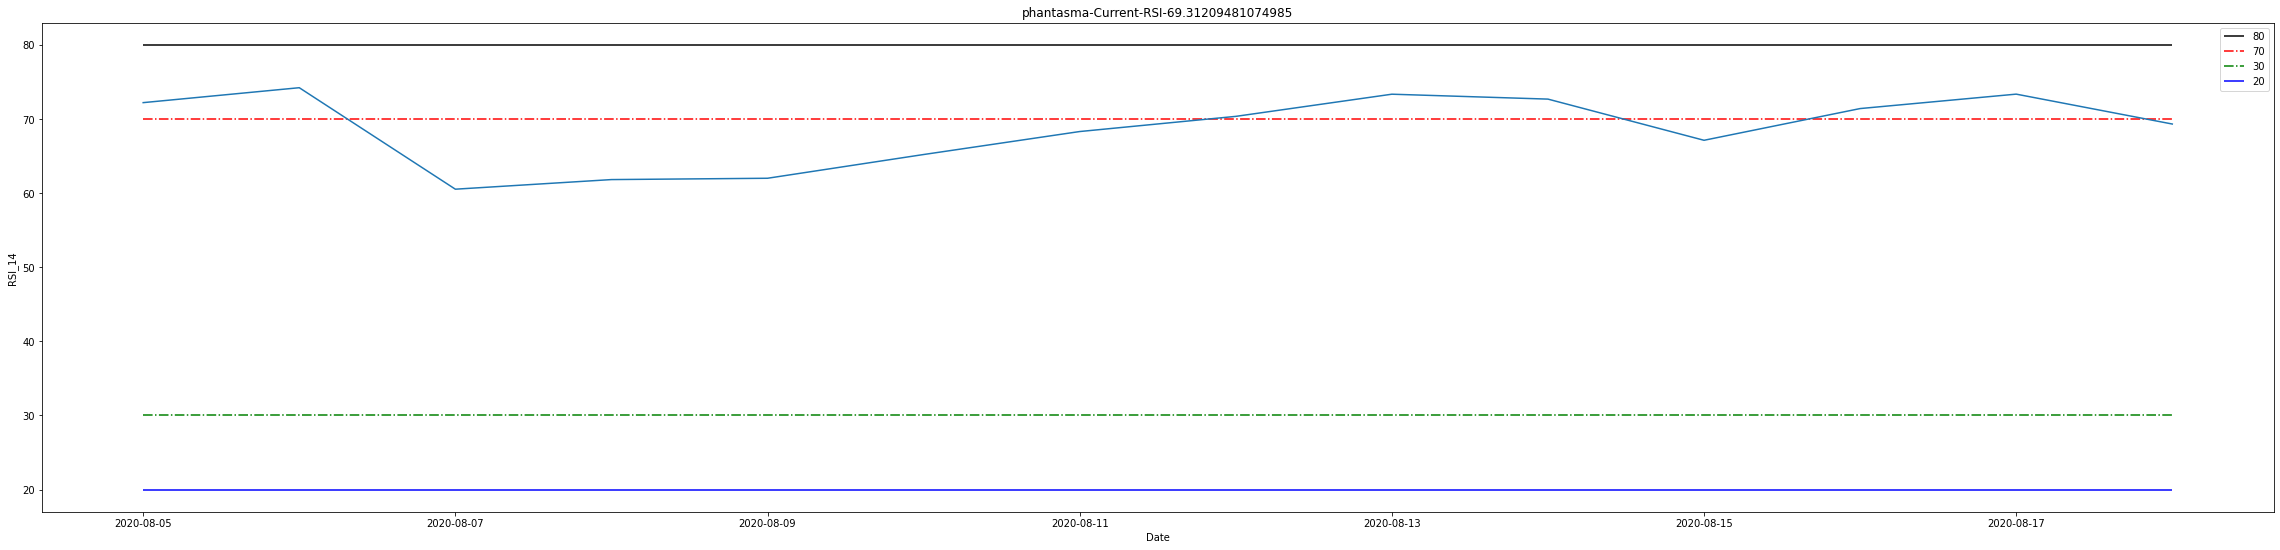

Plotting RSI (59.732989859975945) for:  dent


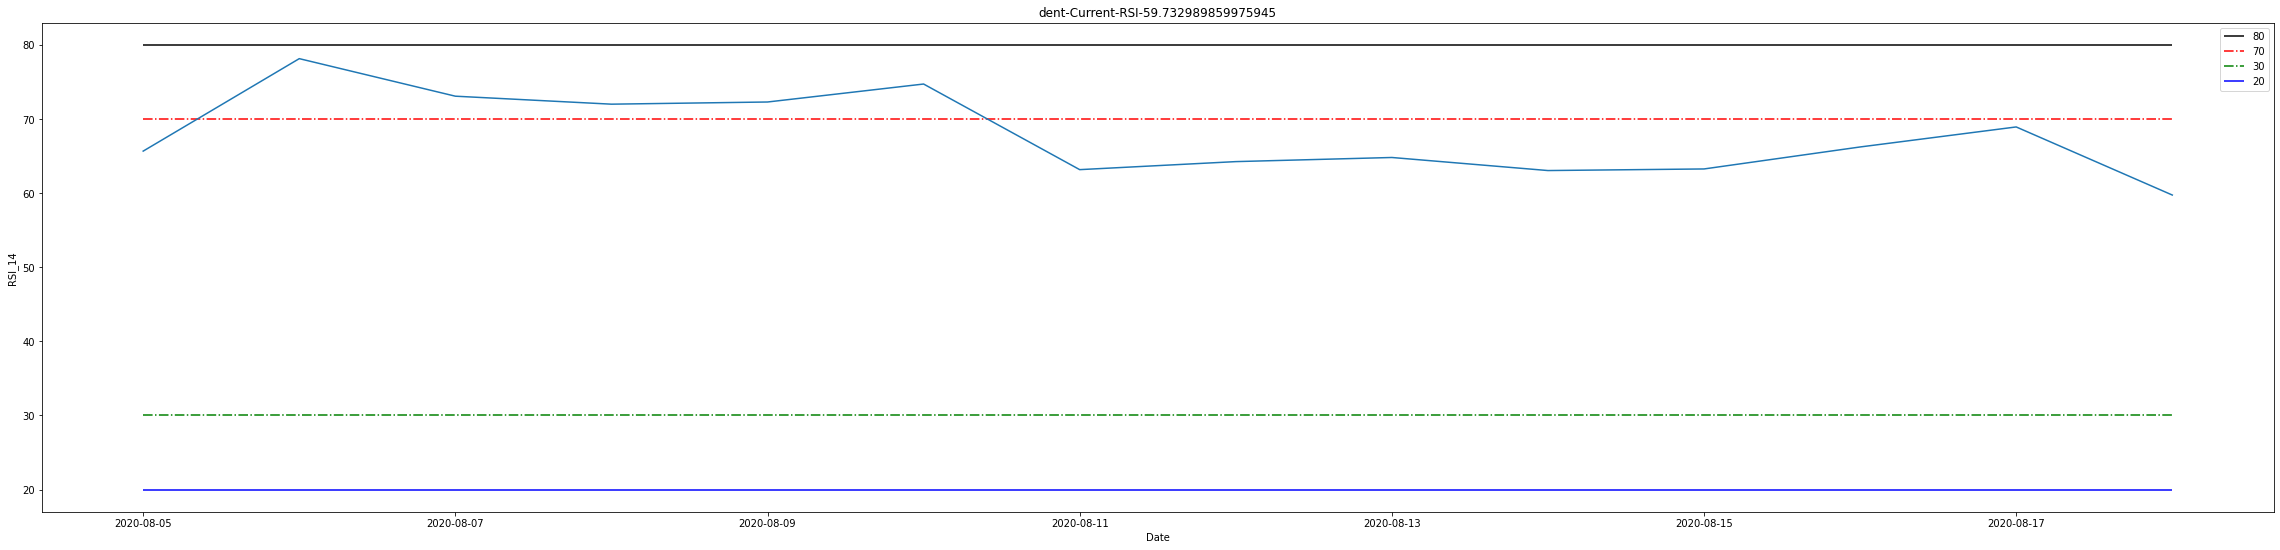

Plotting RSI (42.44191878035763) for:  enecuum


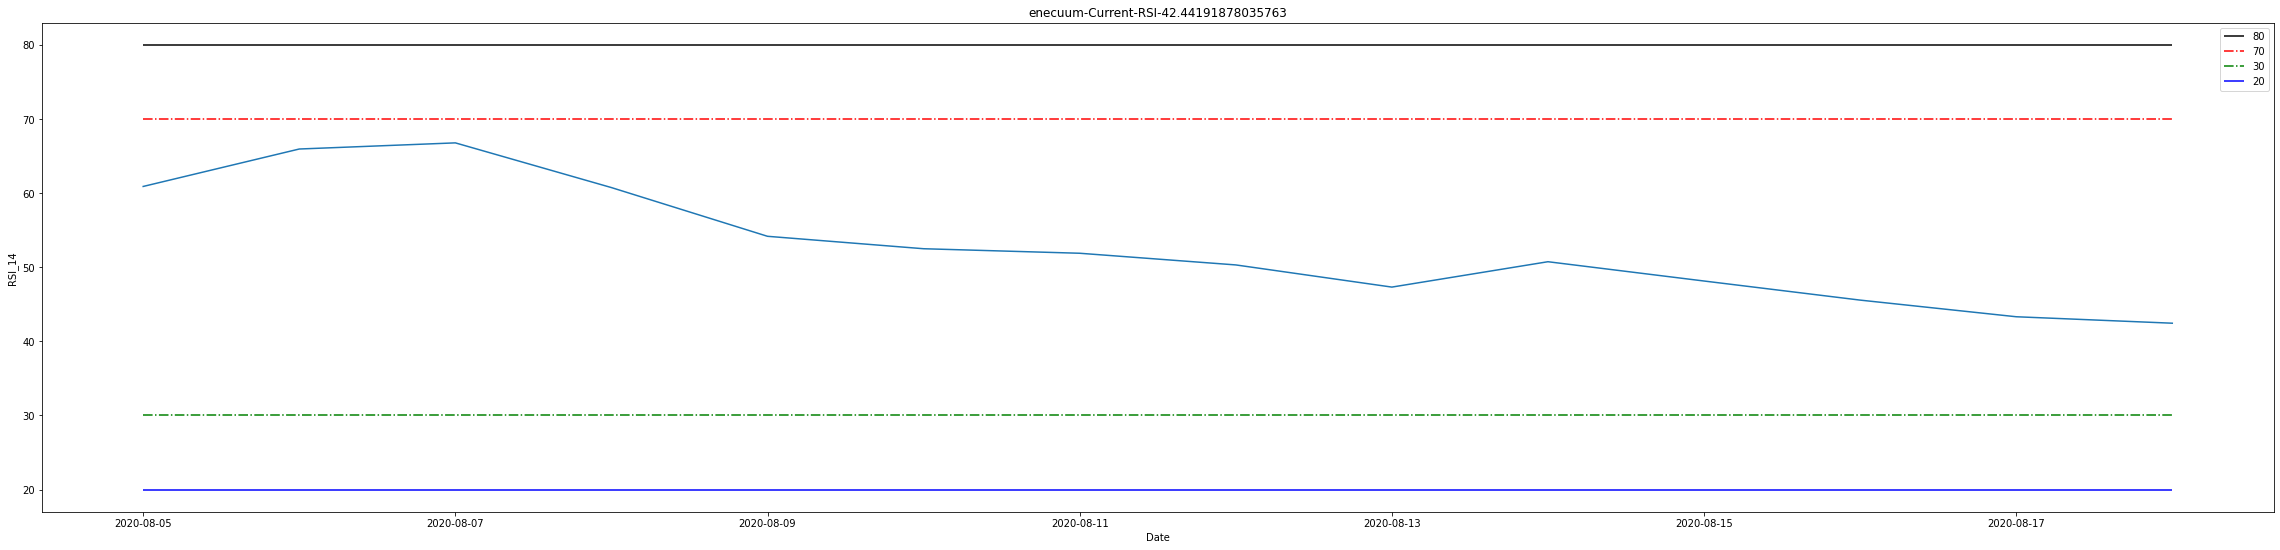

Plotting RSI (53.71259624429023) for:  zilliqa


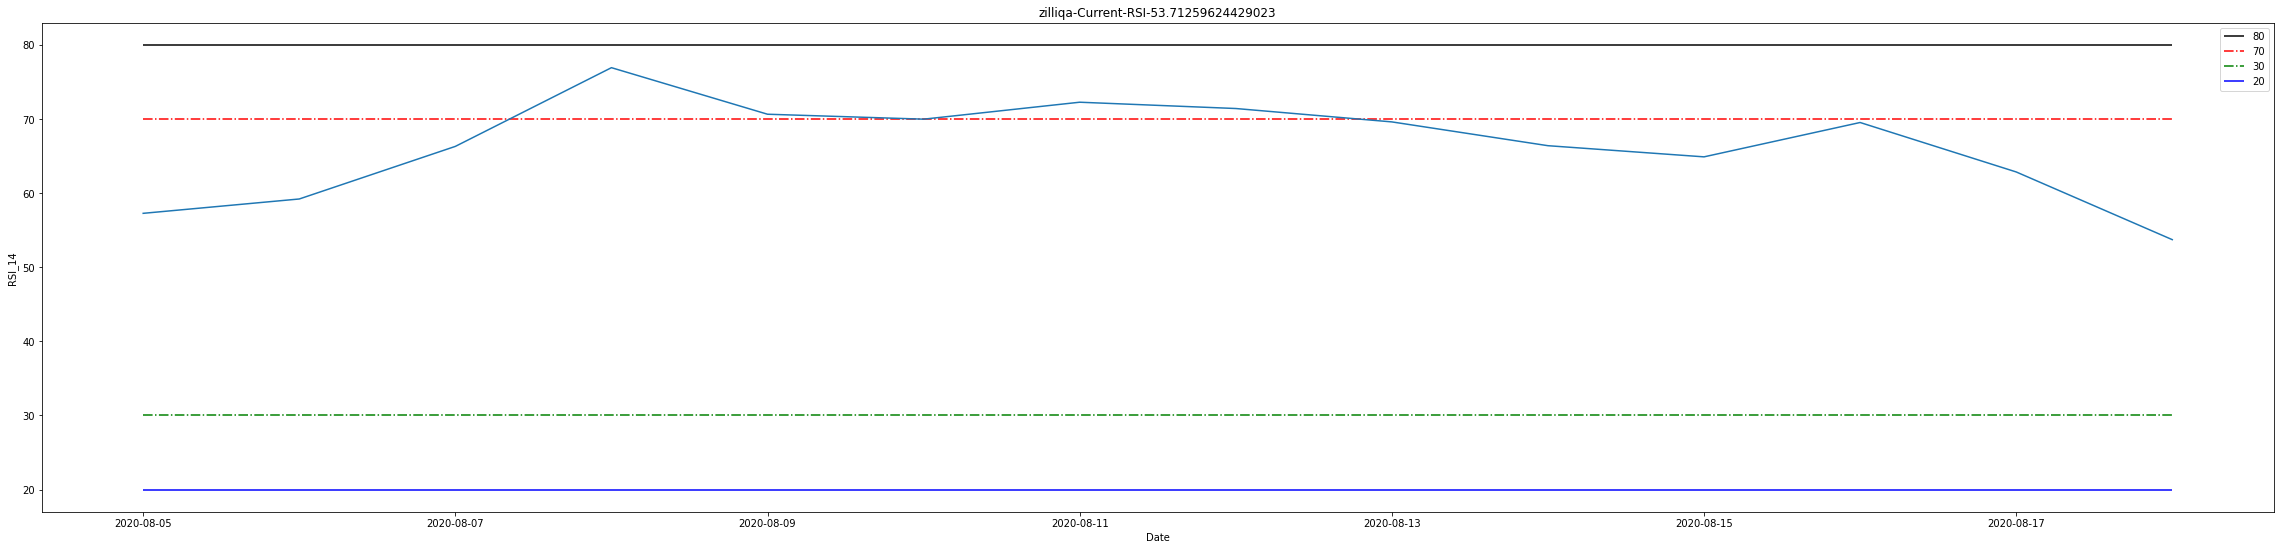

Plotting RSI (59.23757258704148) for:  te-food


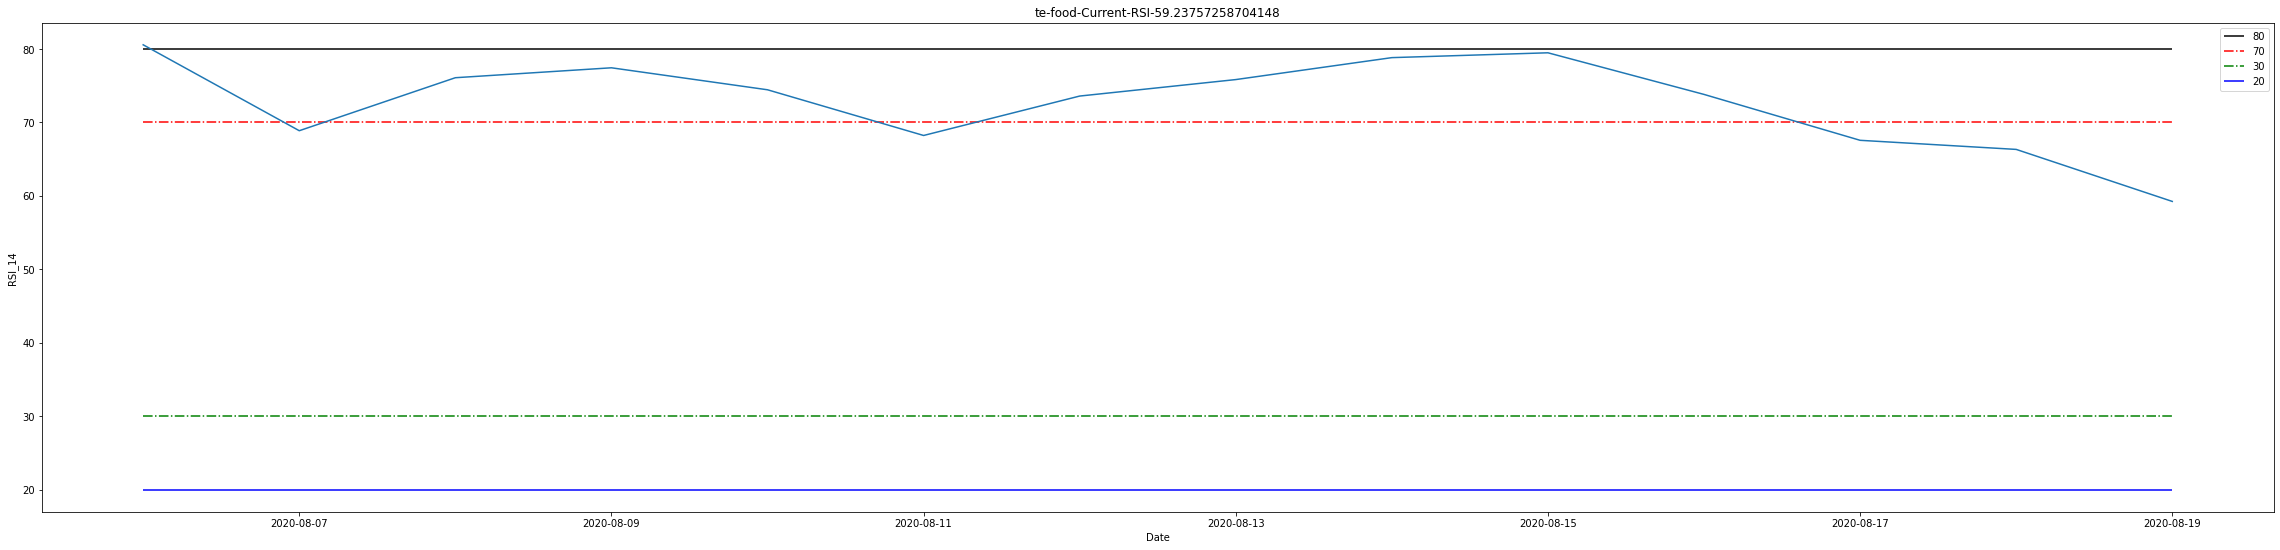

Plotting RSI (53.429528875100324) for:  datx


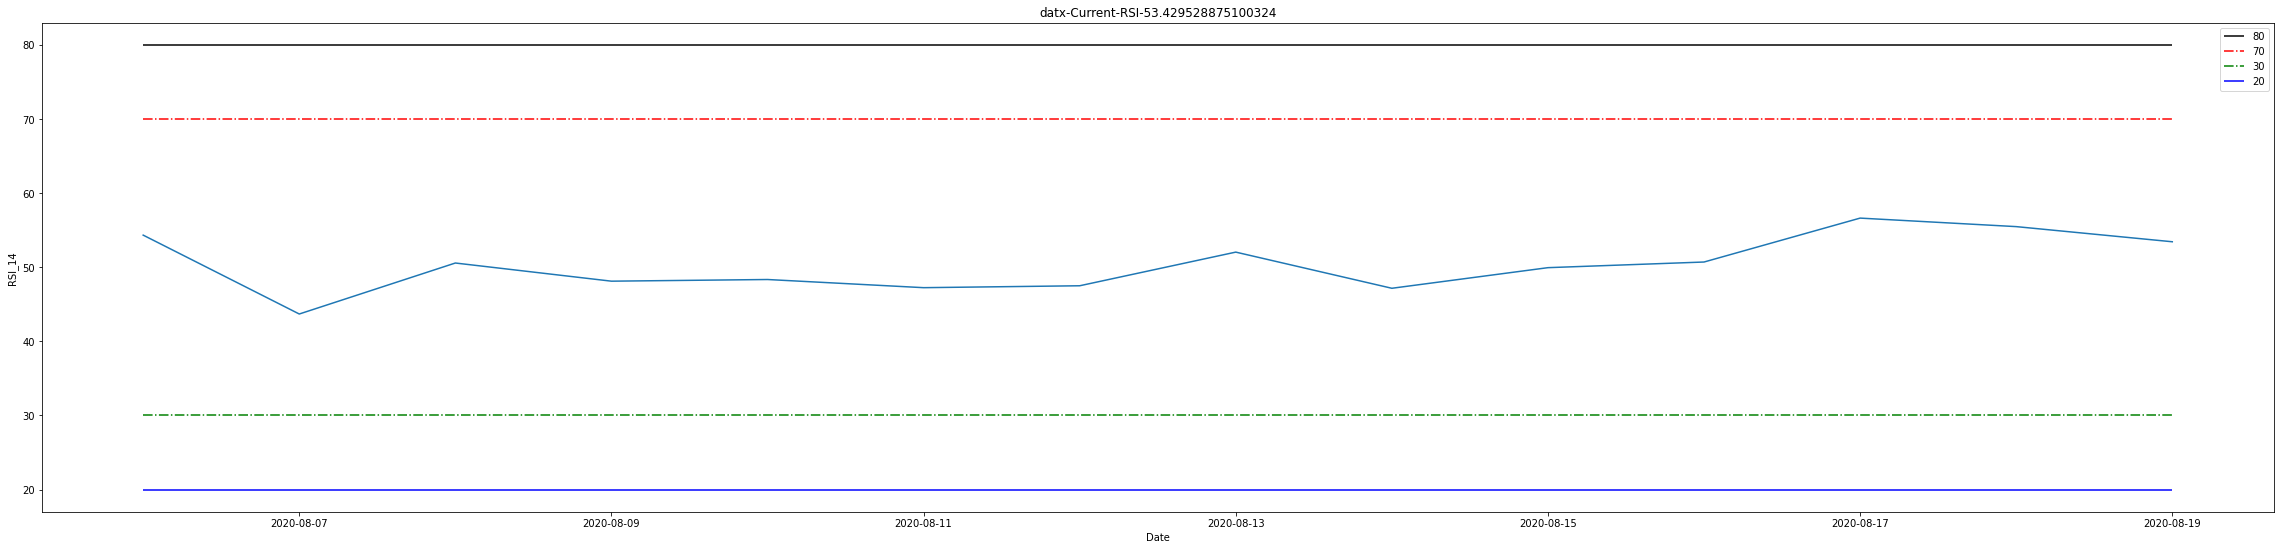

Plotting RSI (70.88756846585073) for:  herocoin


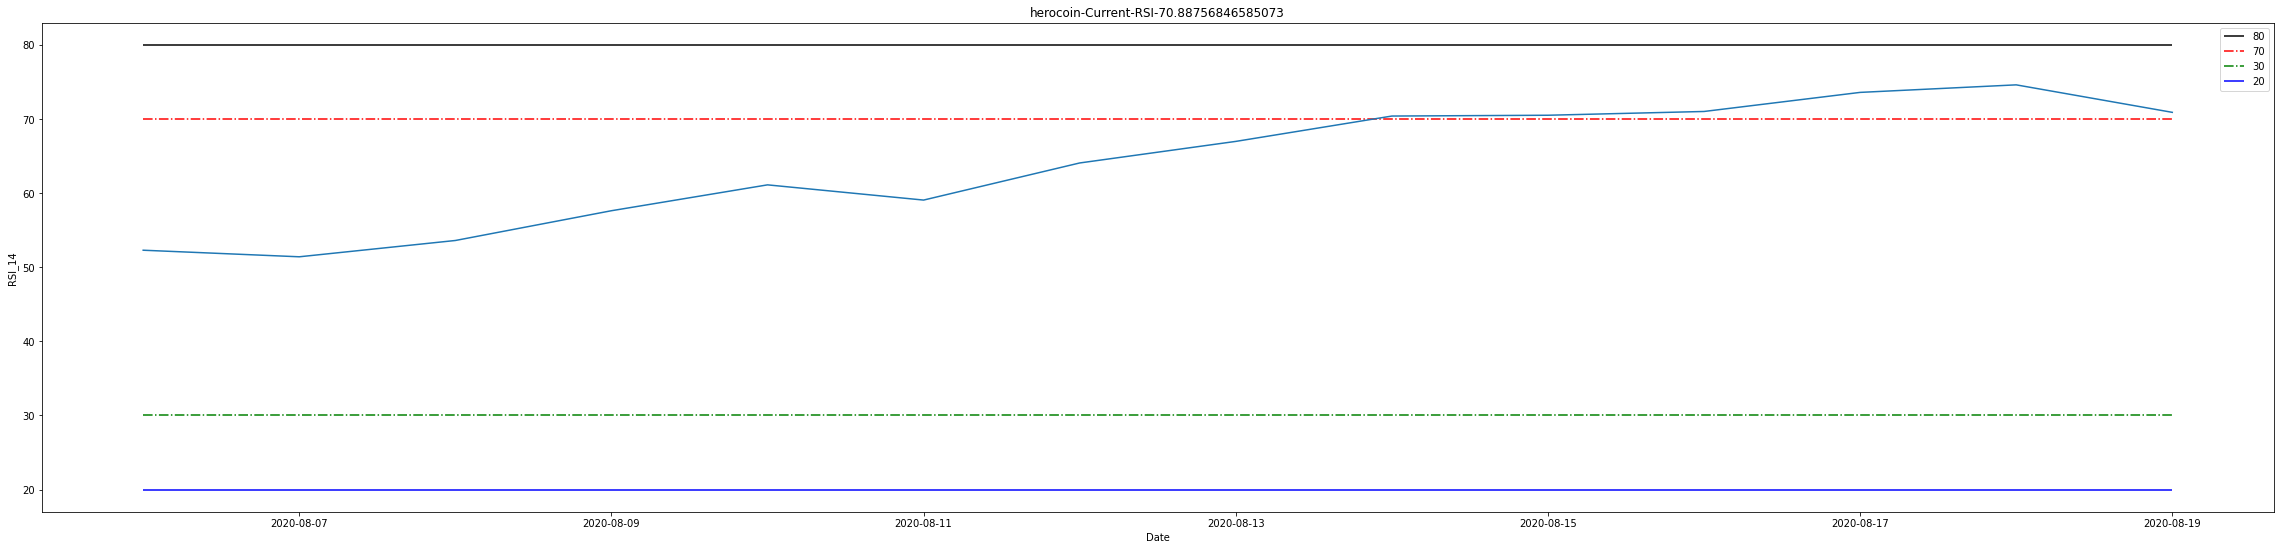

Plotting RSI (48.93694884682879) for:  bytom


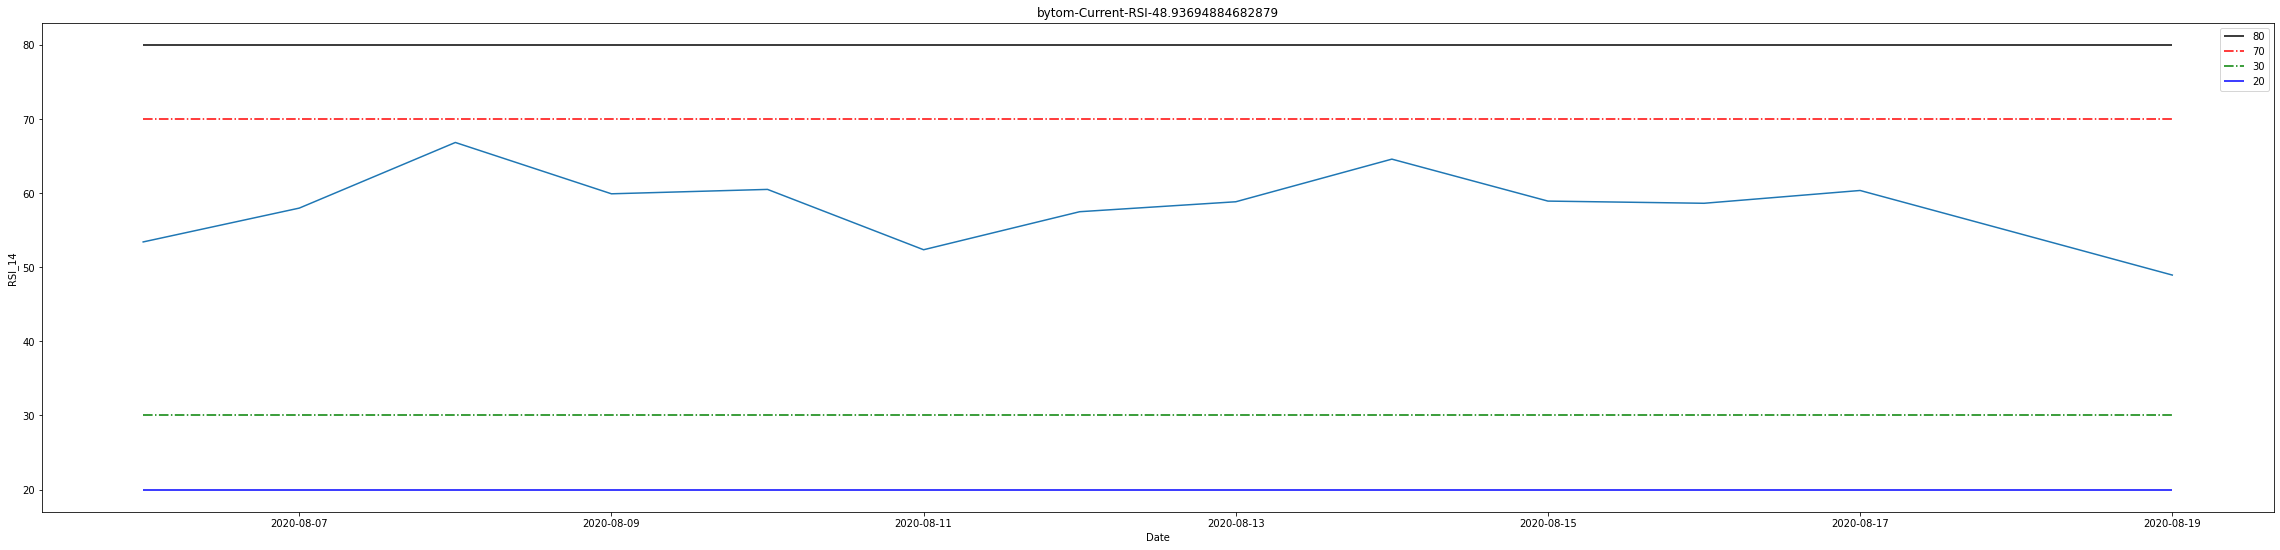

Plotting RSI (43.523933775975664) for:  nimiq


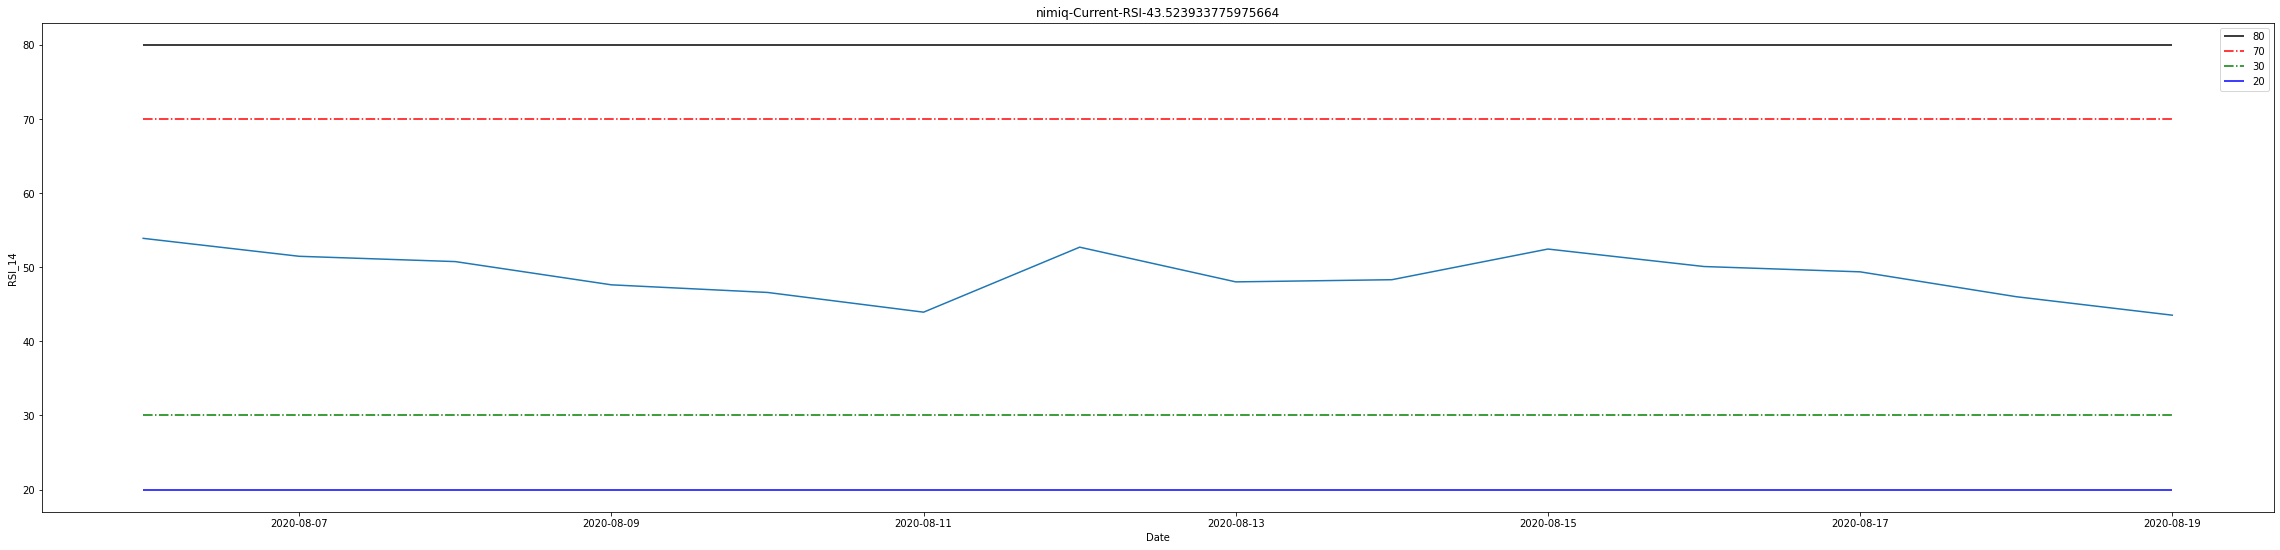

Plotting RSI (70.41529318938967) for:  neo


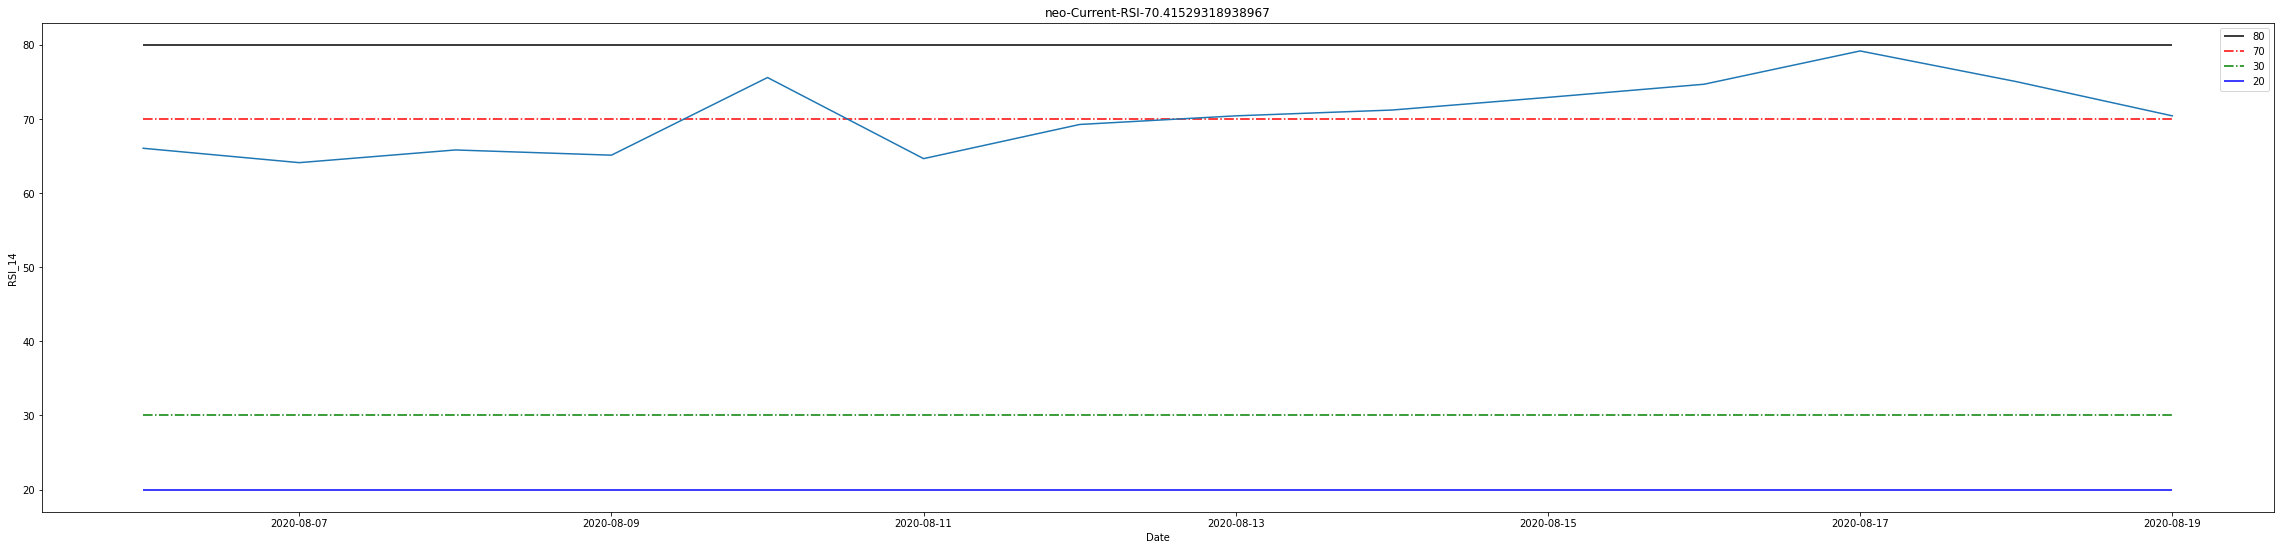

Plotting RSI (43.88920728292135) for:  coinpoker


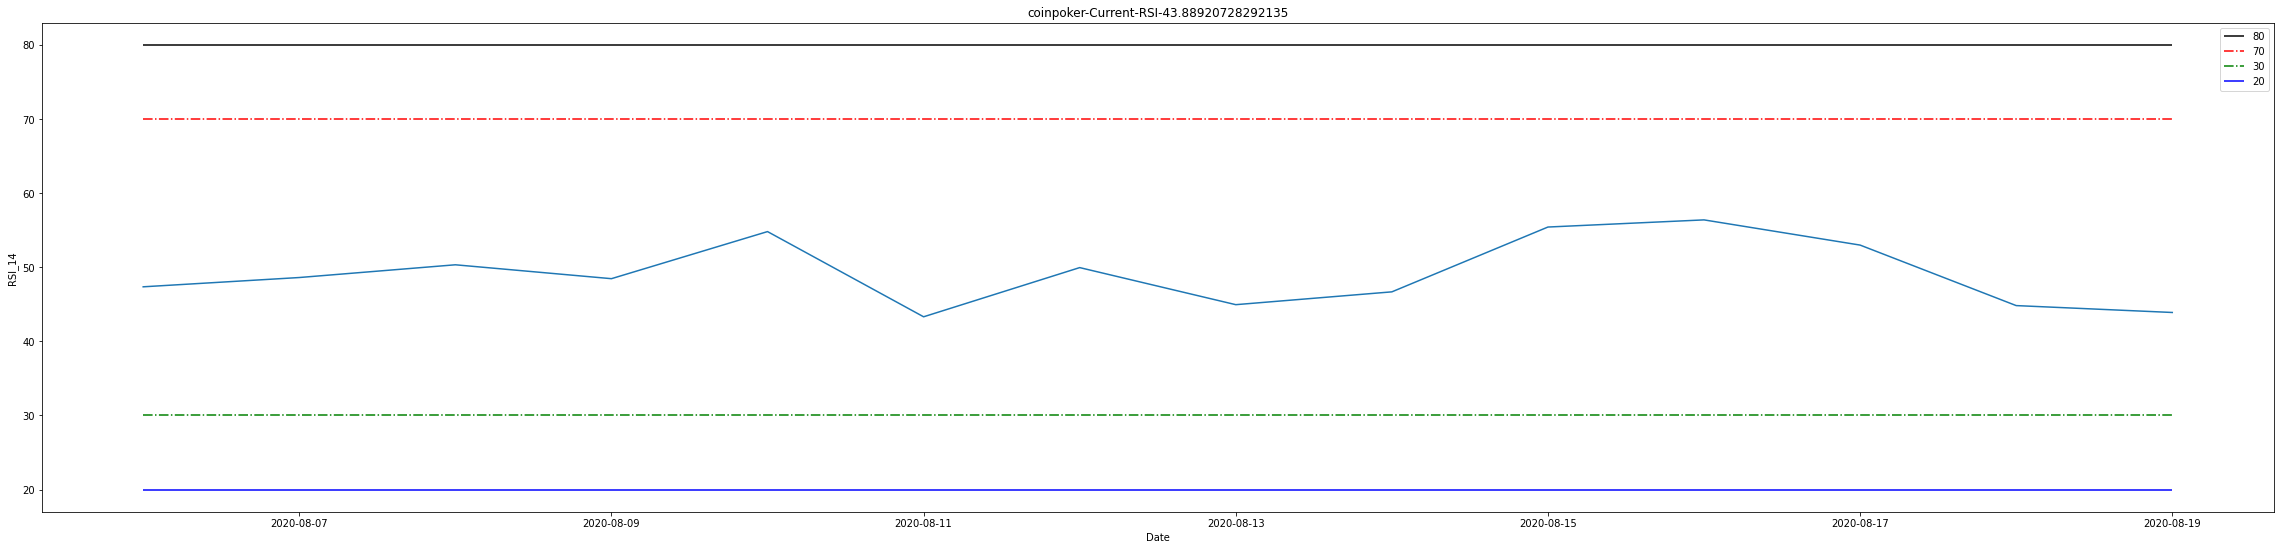

Plotting RSI (53.42624994490332) for:  akropolis


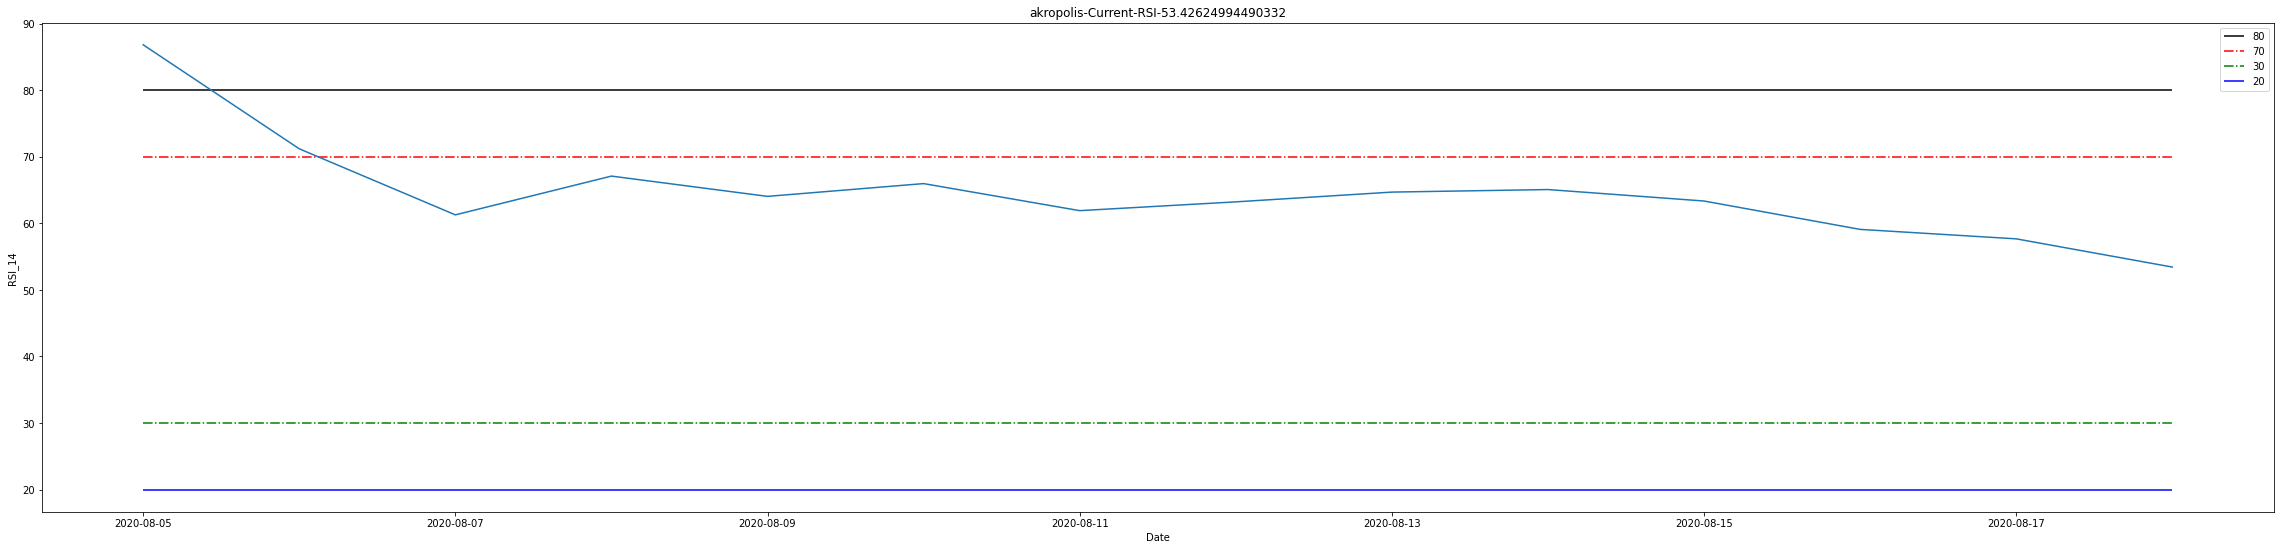

Plotting RSI (57.97396033496886) for:  constellation


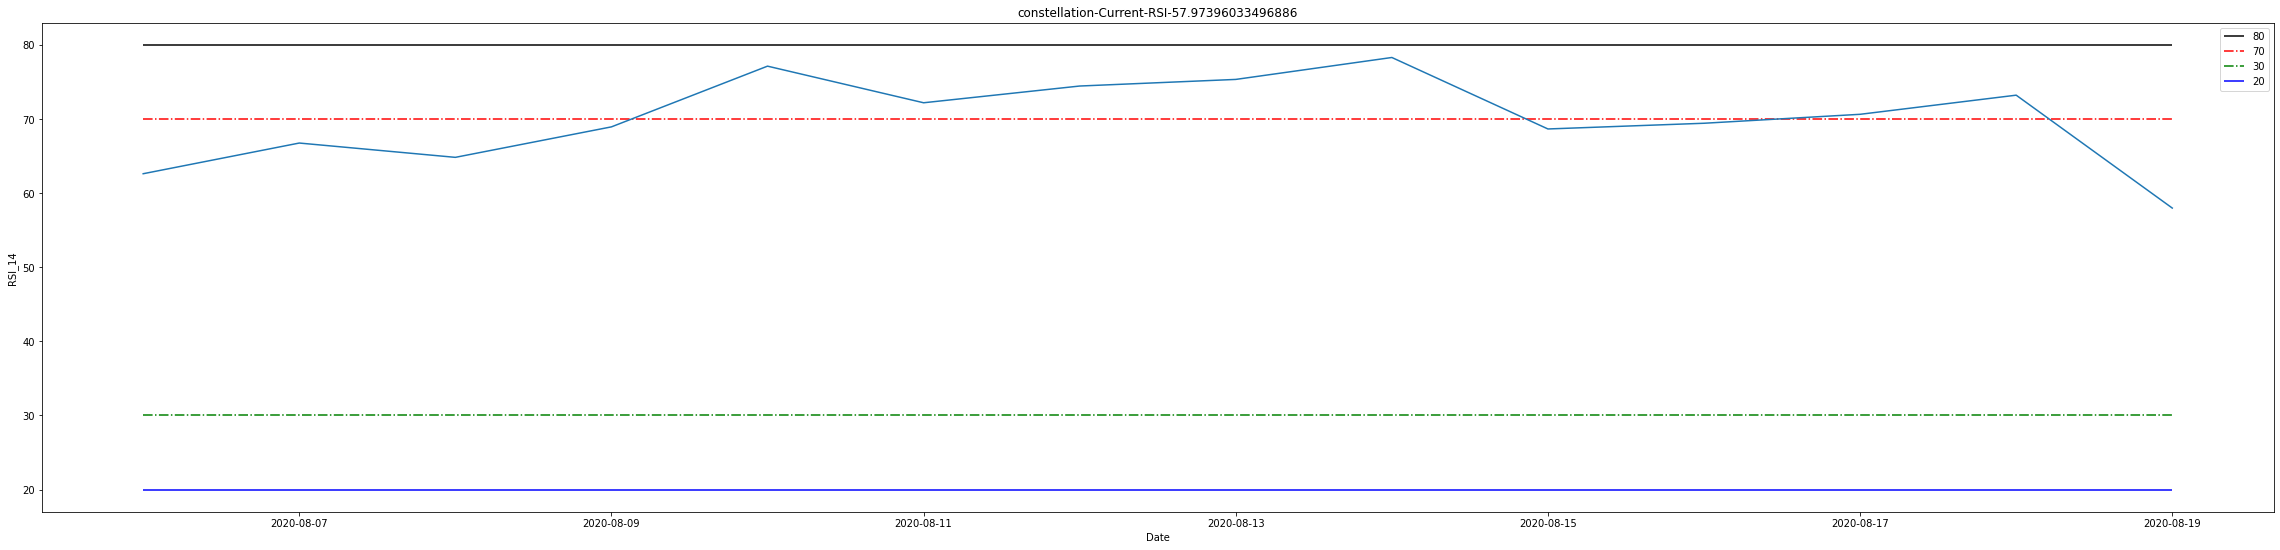

Plotting RSI (58.40256853473389) for:  amber


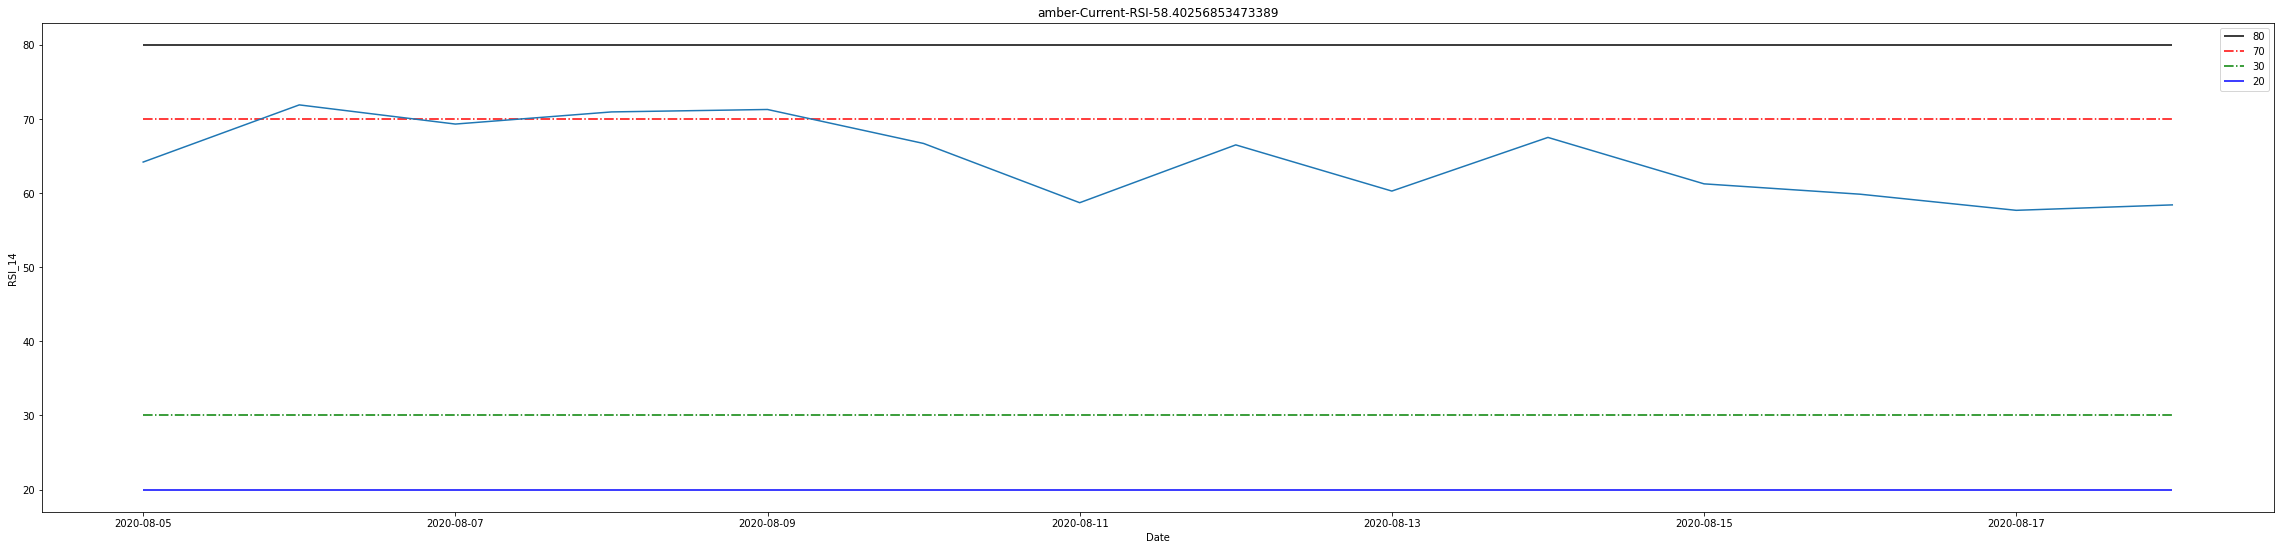

Plotting RSI (66.43284101194746) for:  dock


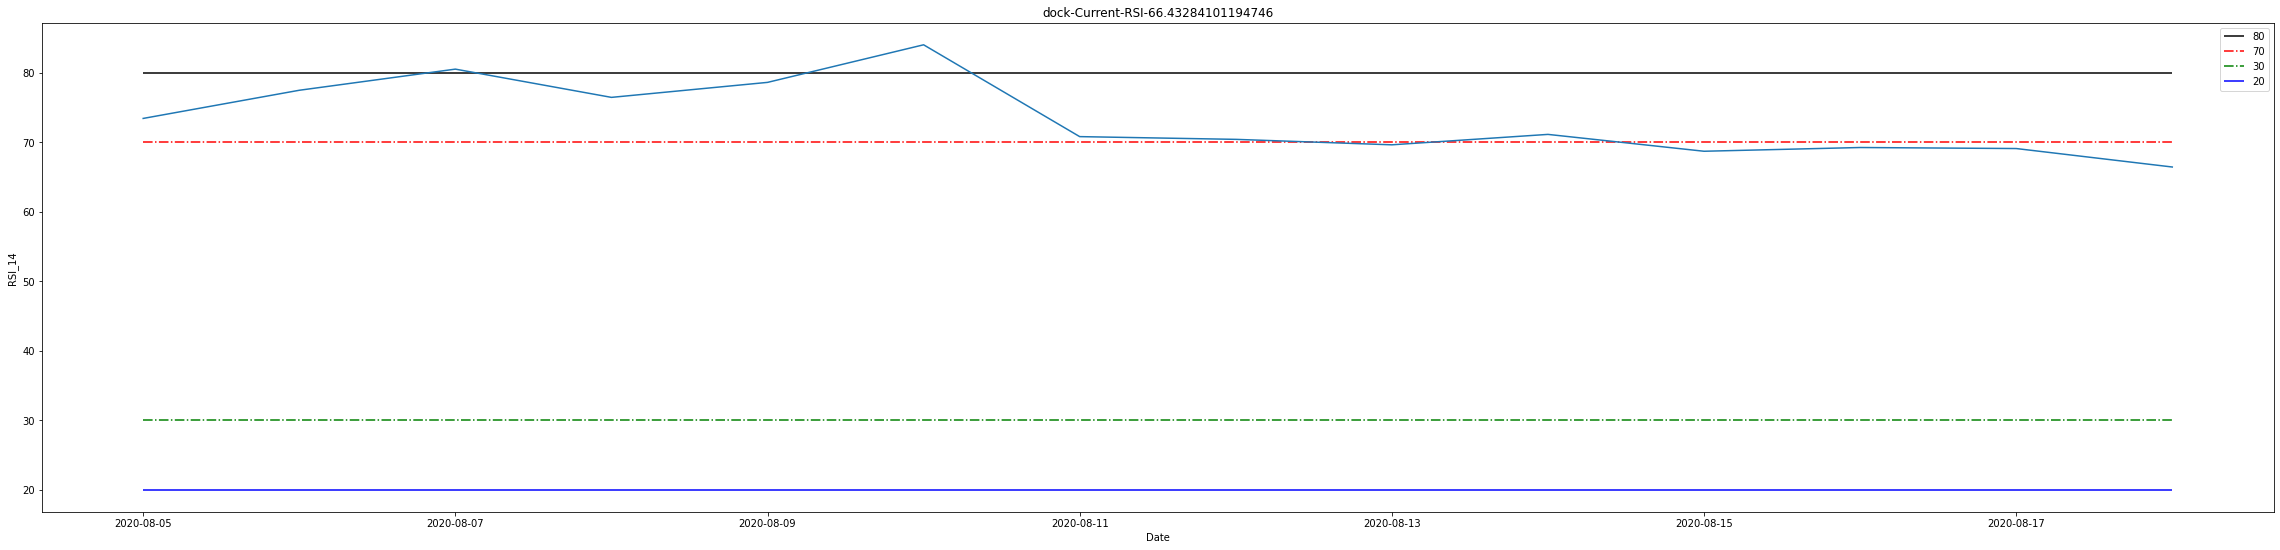

Plotting RSI (66.35160076803226) for:  synthetix-network-token


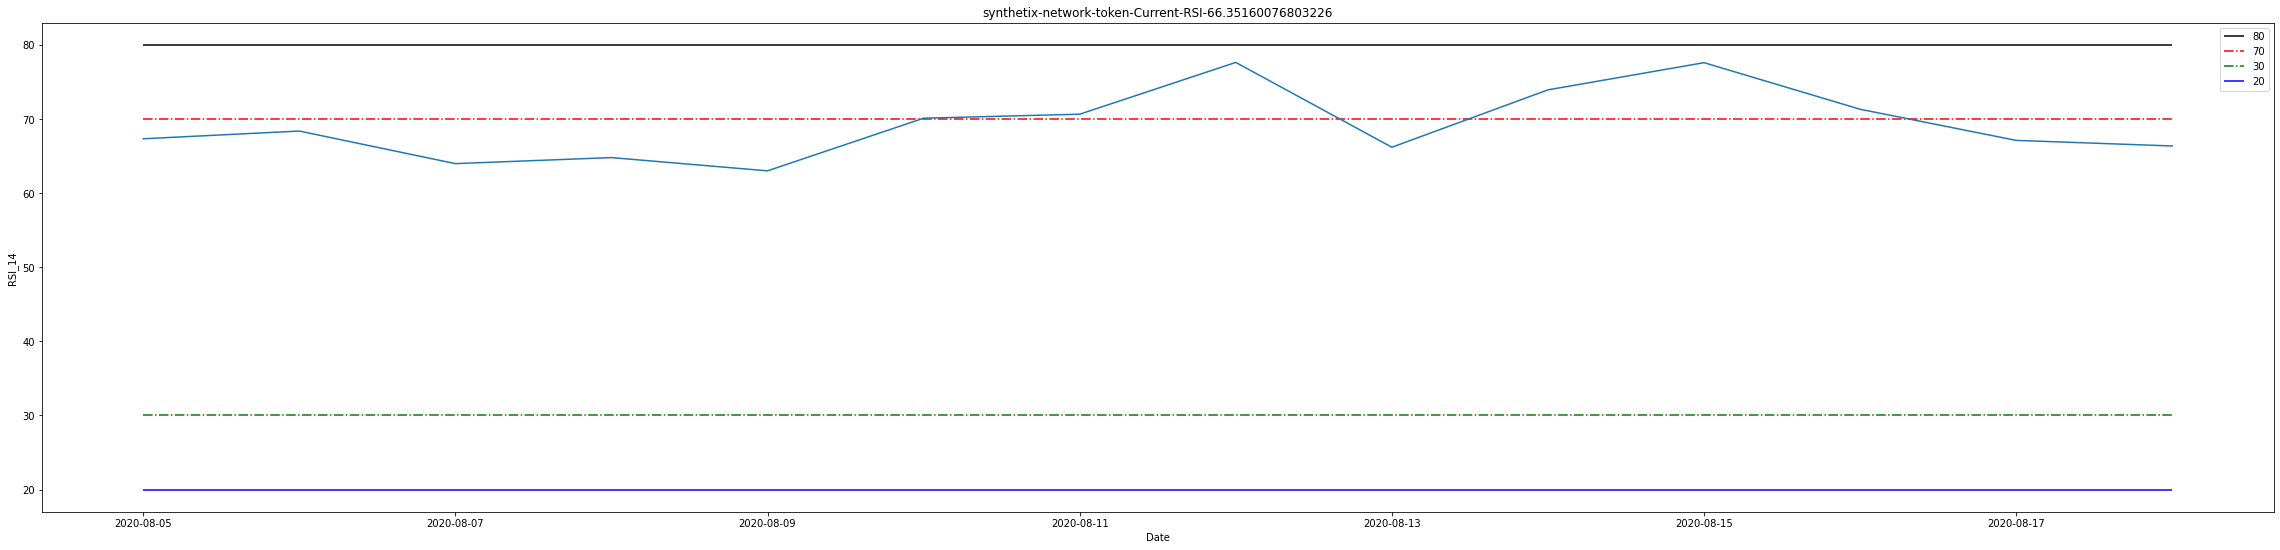

Plotting RSI (54.47026092551781) for:  compound


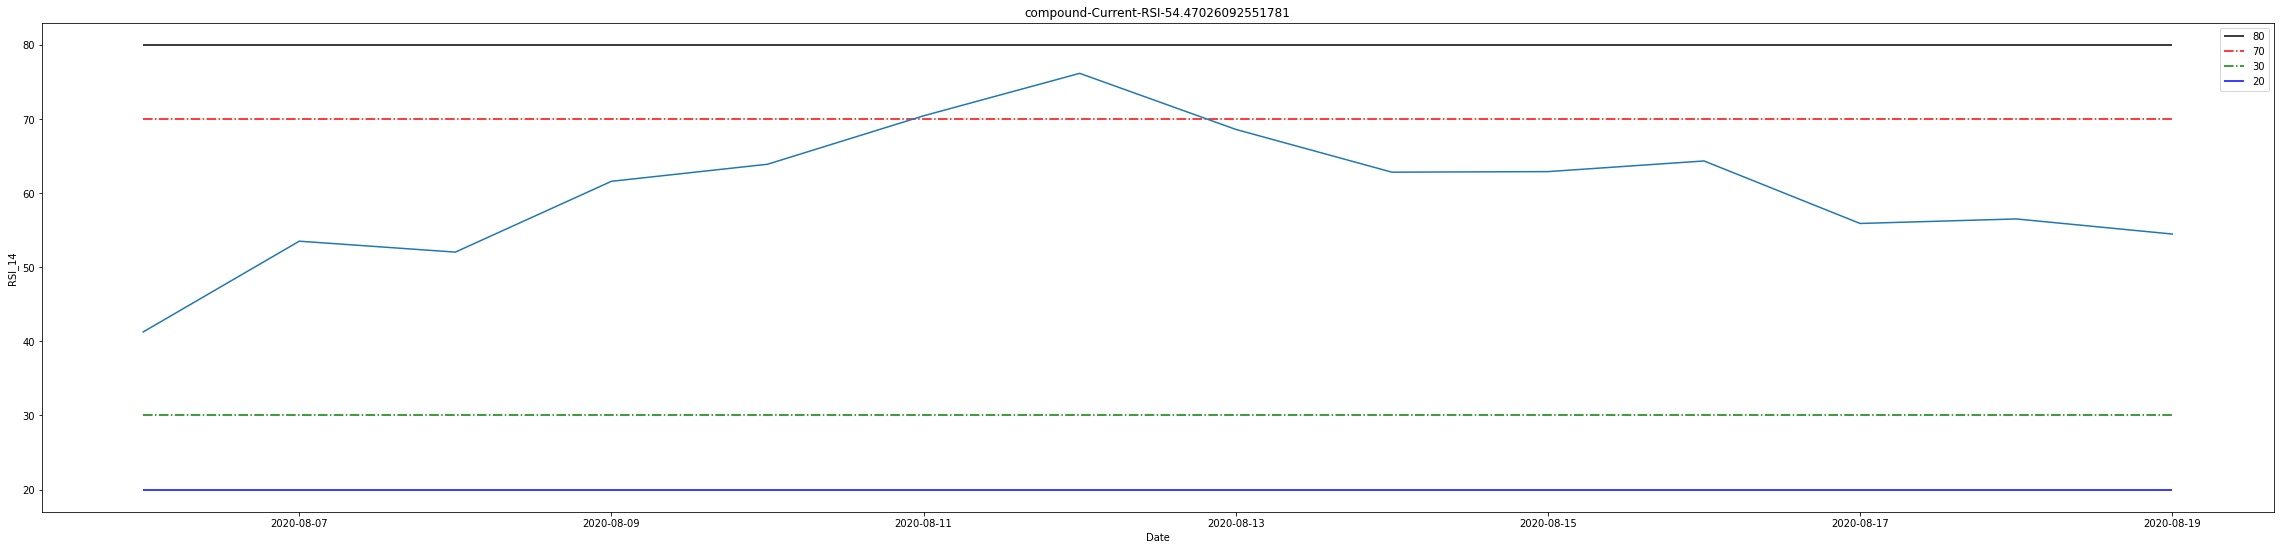

Plotting RSI (74.48106200215997) for:  origintrail


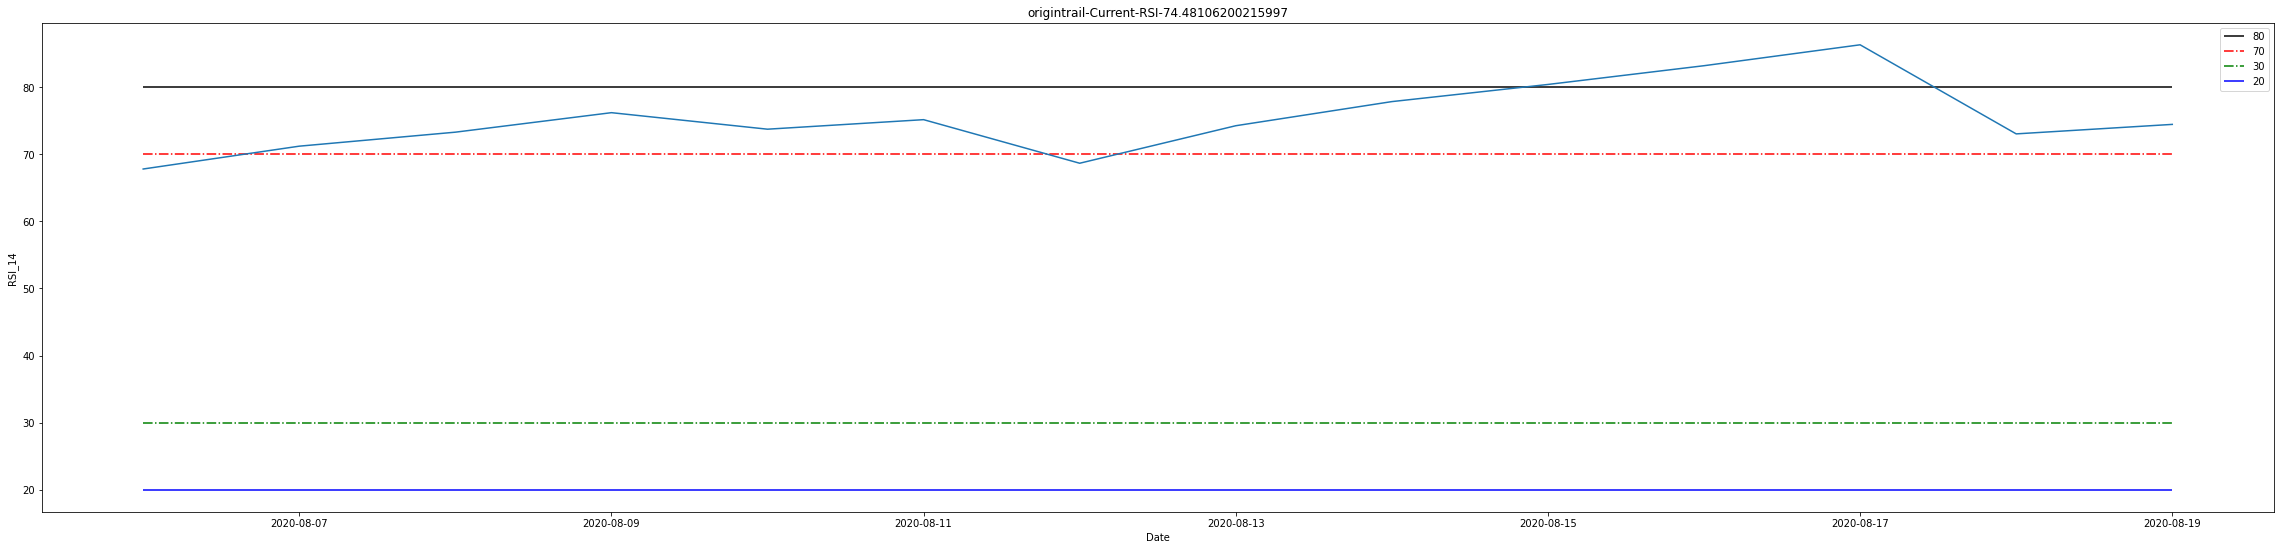

Plotting RSI (54.57313510512521) for:  spendcoin


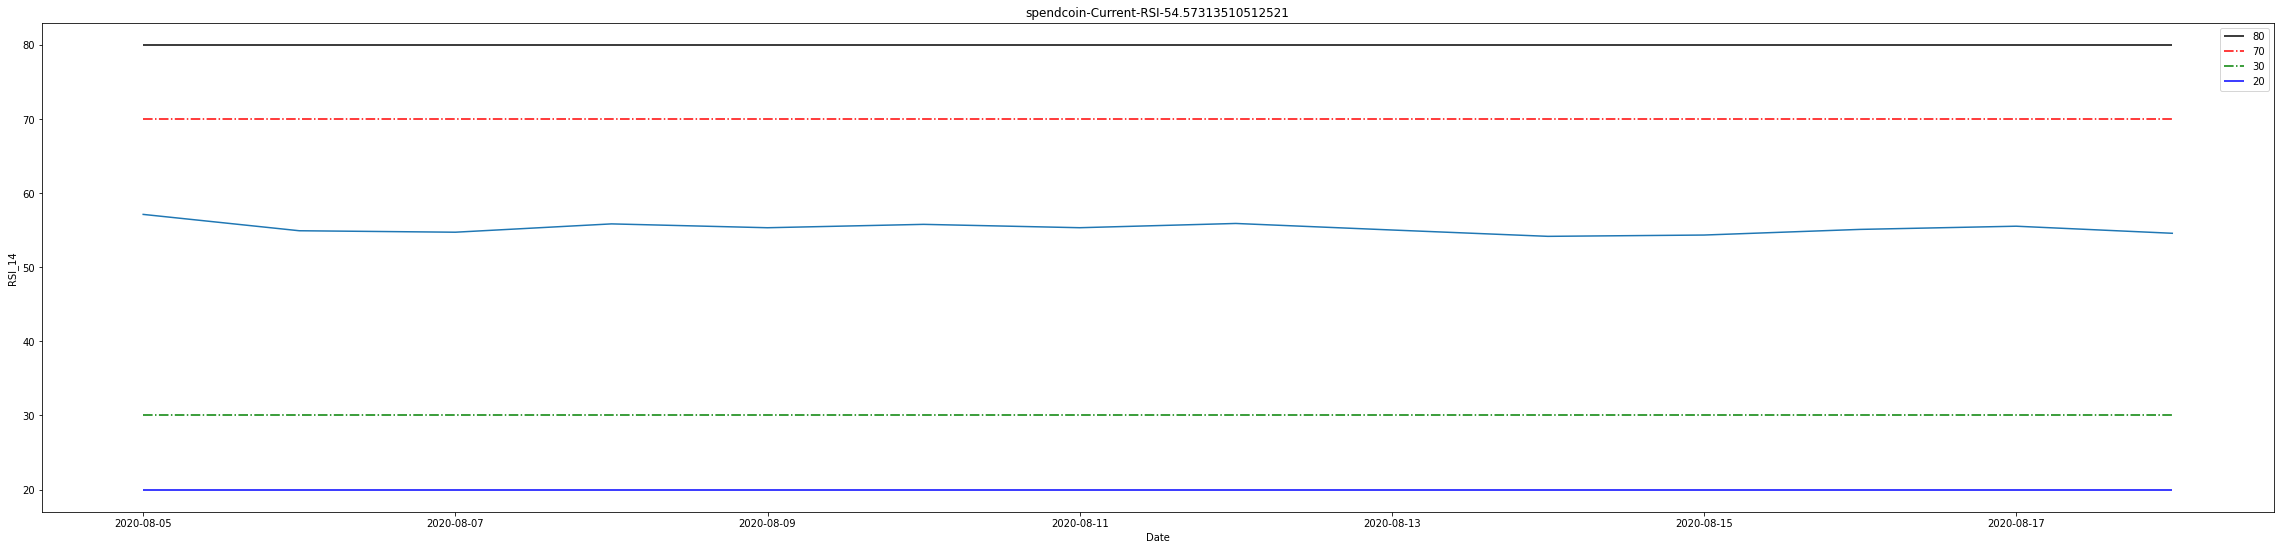

Plotting RSI (86.30769427900663) for:  waves


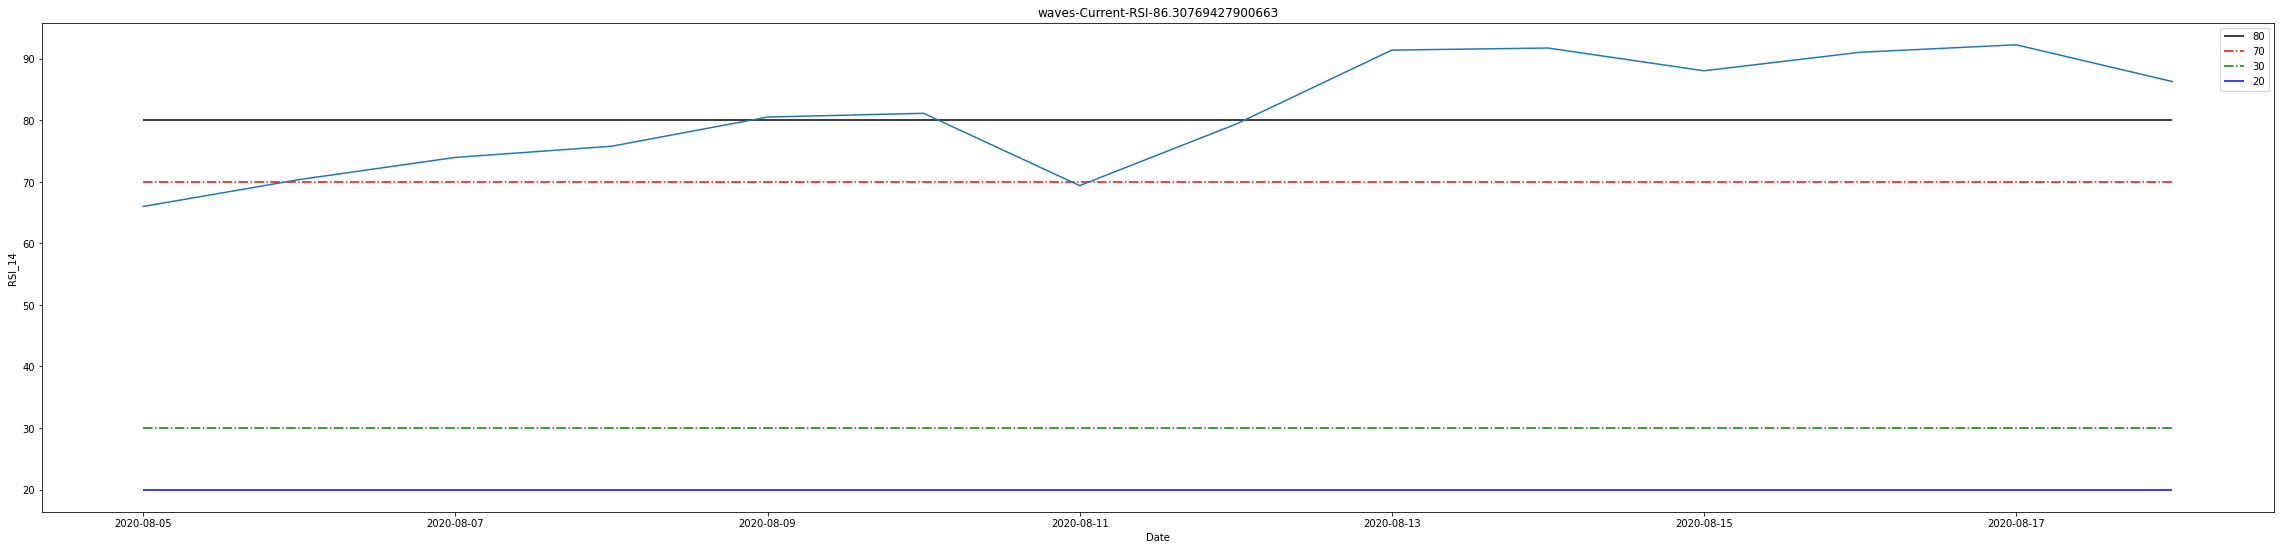

Plotting RSI (41.18040210705183) for:  dxchain-token


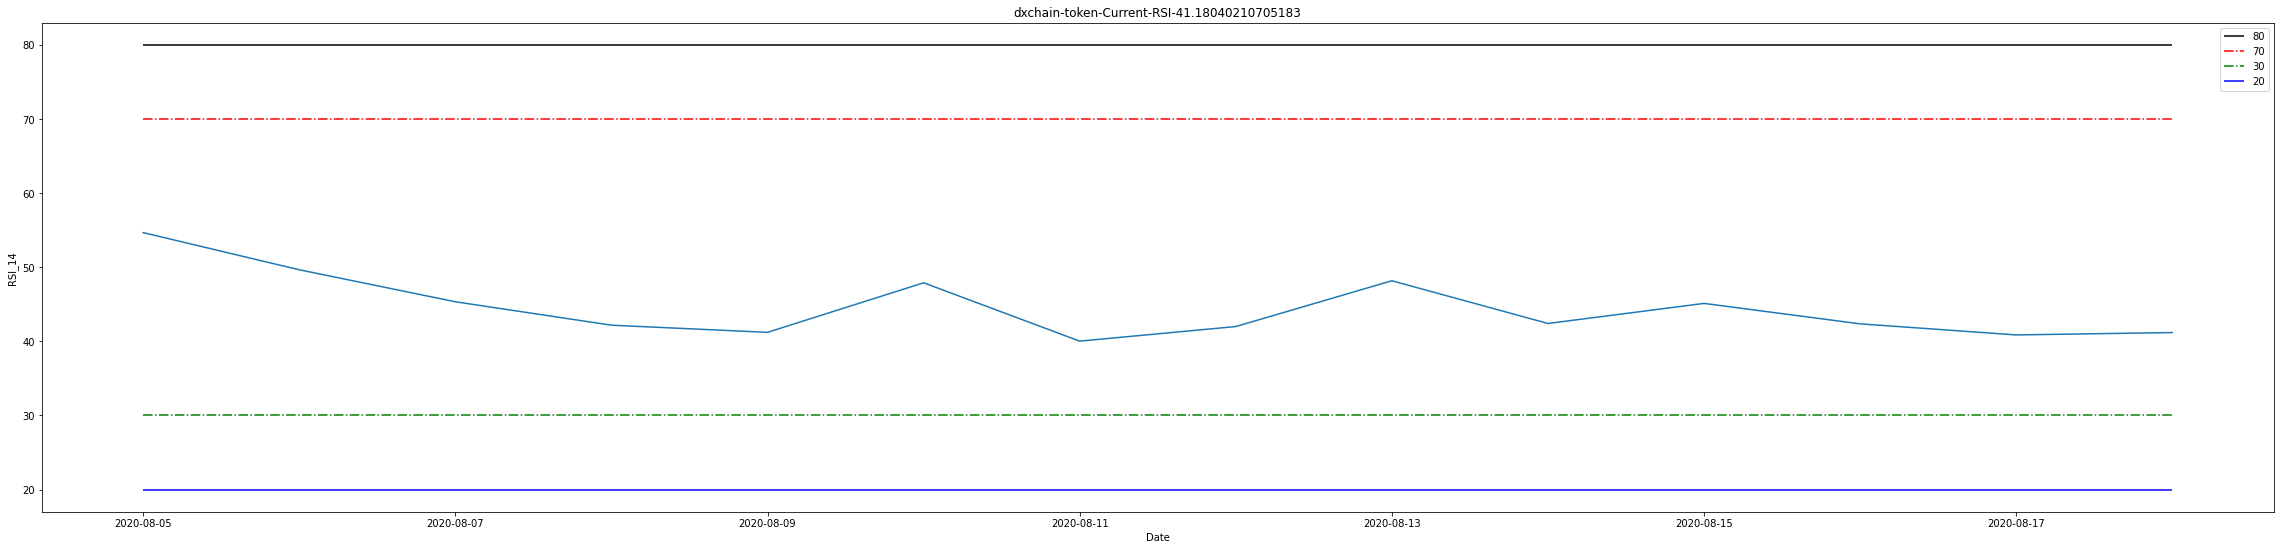

Plotting RSI (43.91038473974524) for:  babb


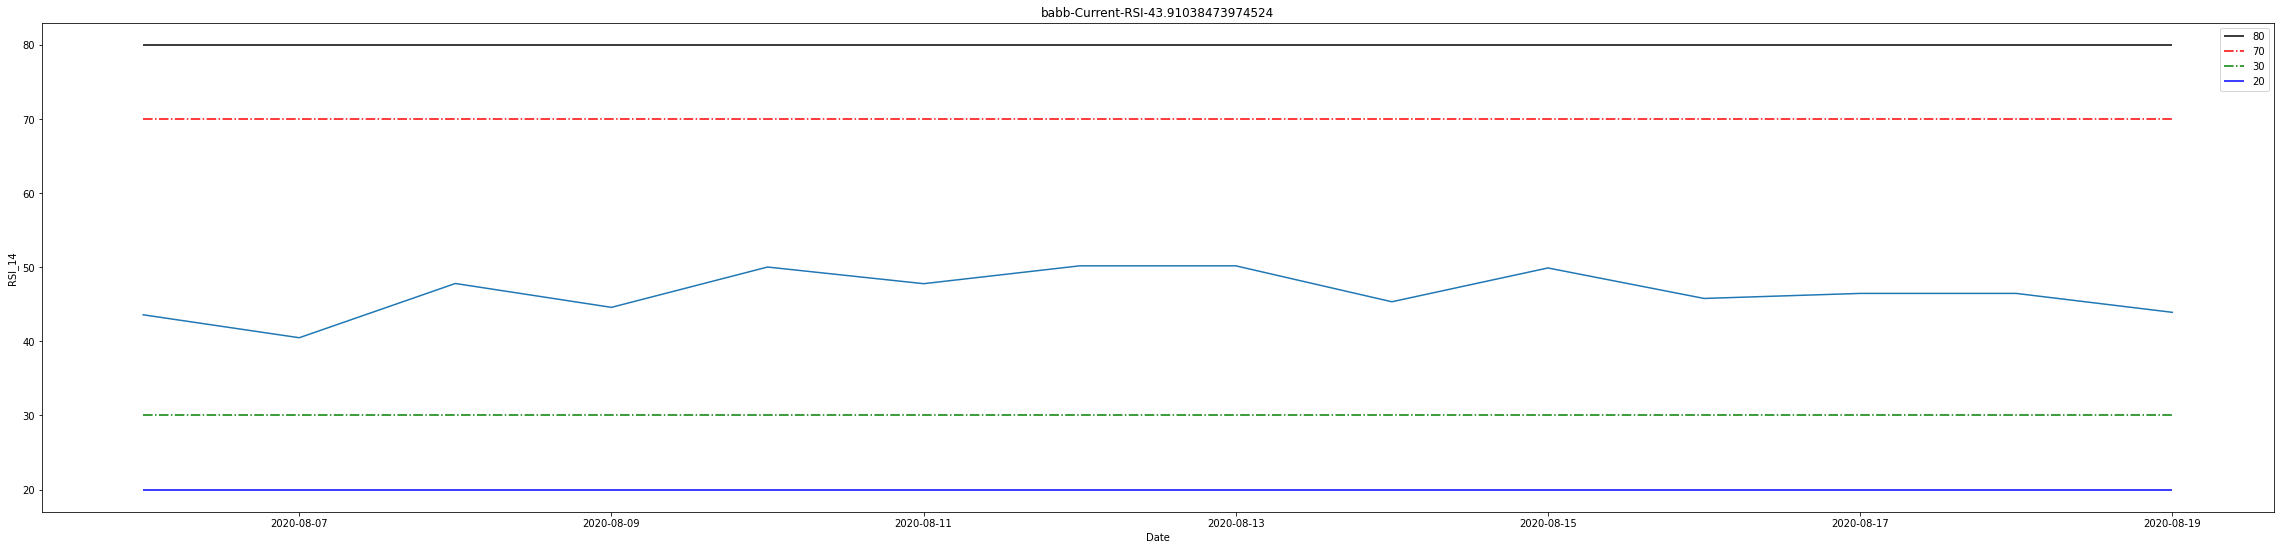

Plotting RSI (57.12305428817115) for:  pundi-x


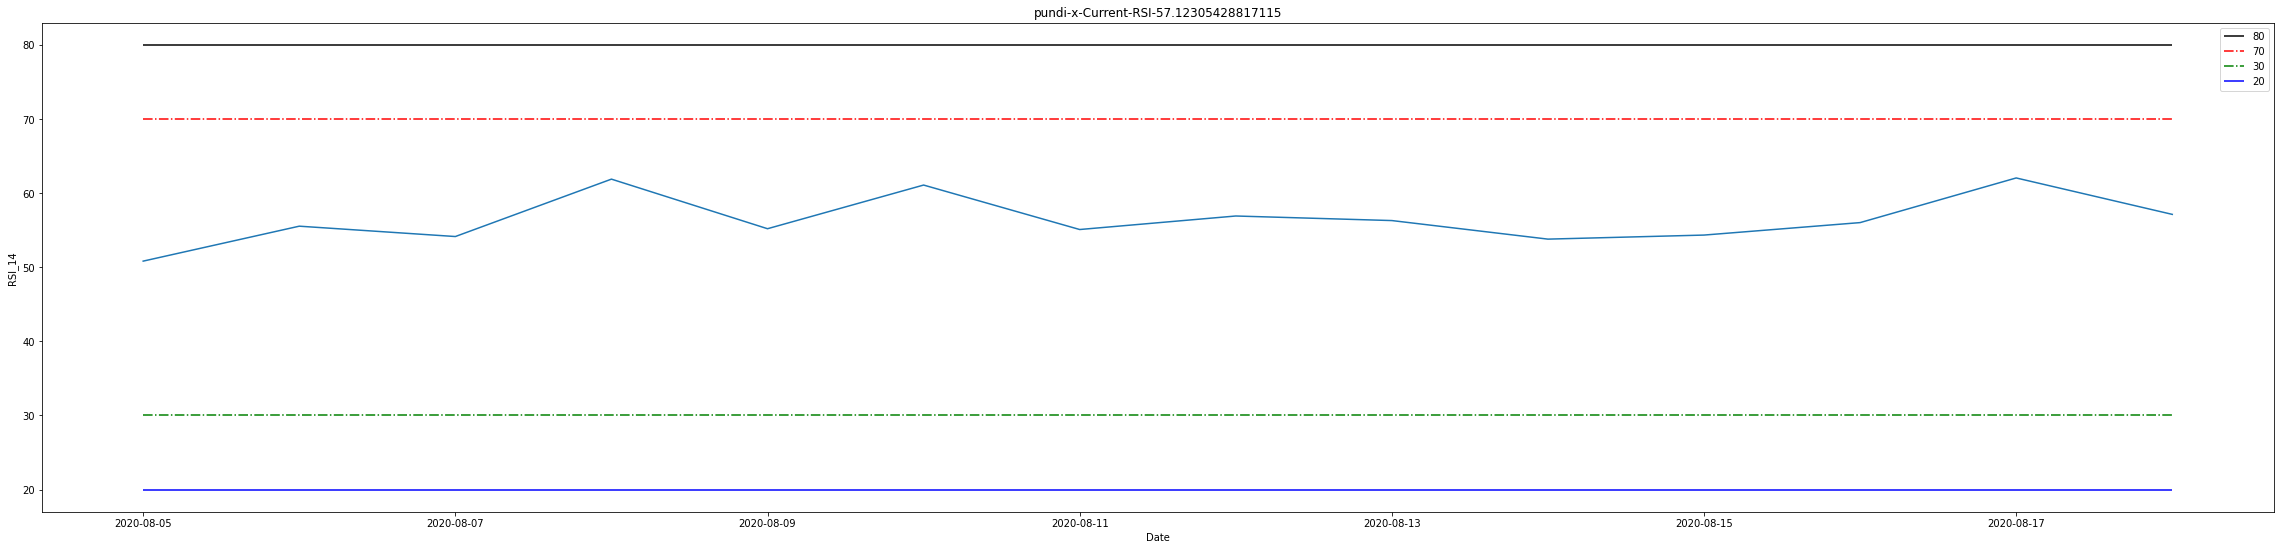

Plotting RSI (62.40561915274351) for:  cosmos


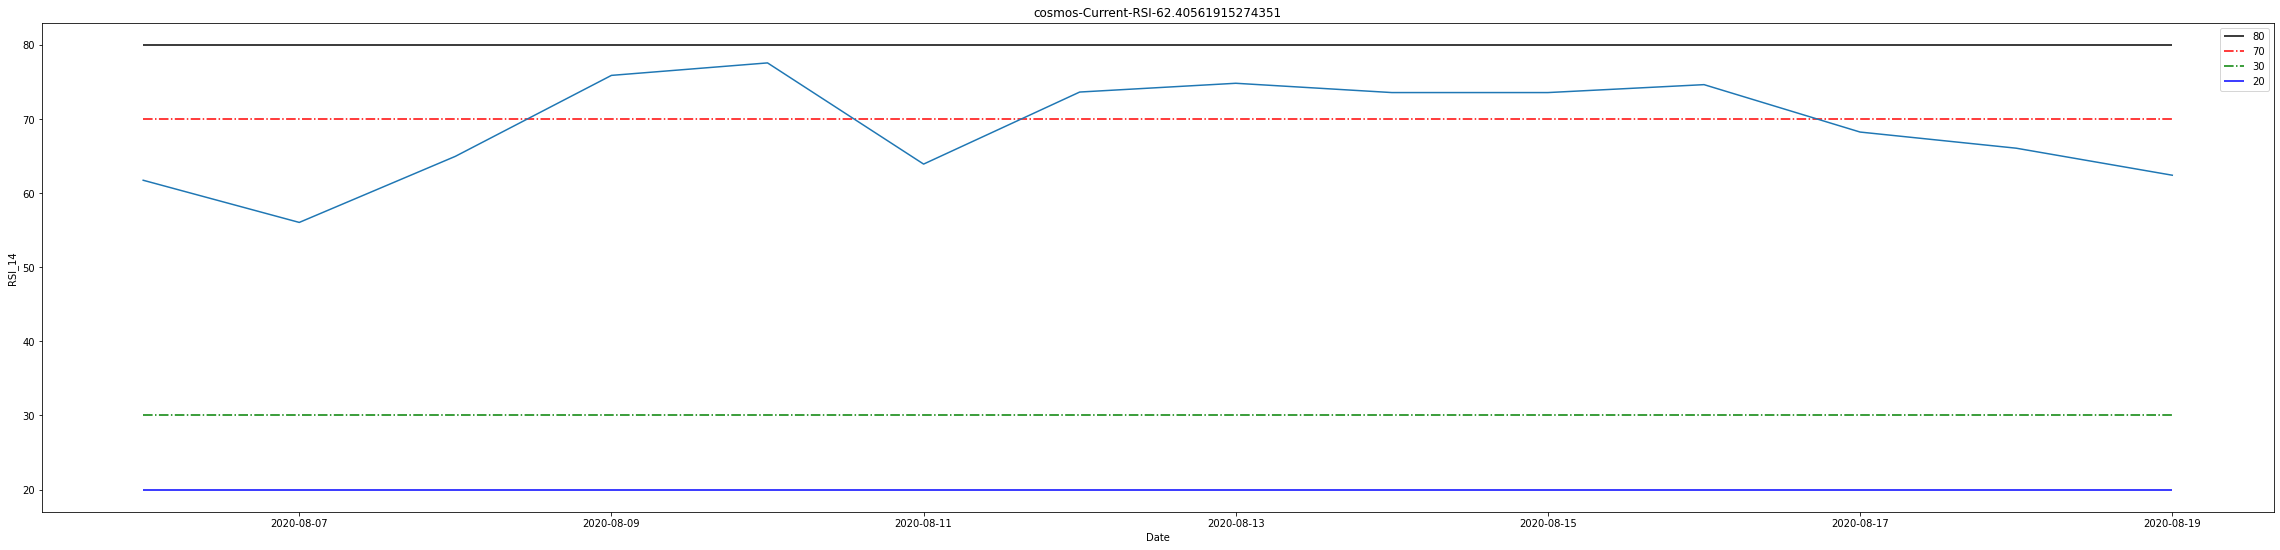

Plotting RSI (44.79537556598967) for:  blockcloud


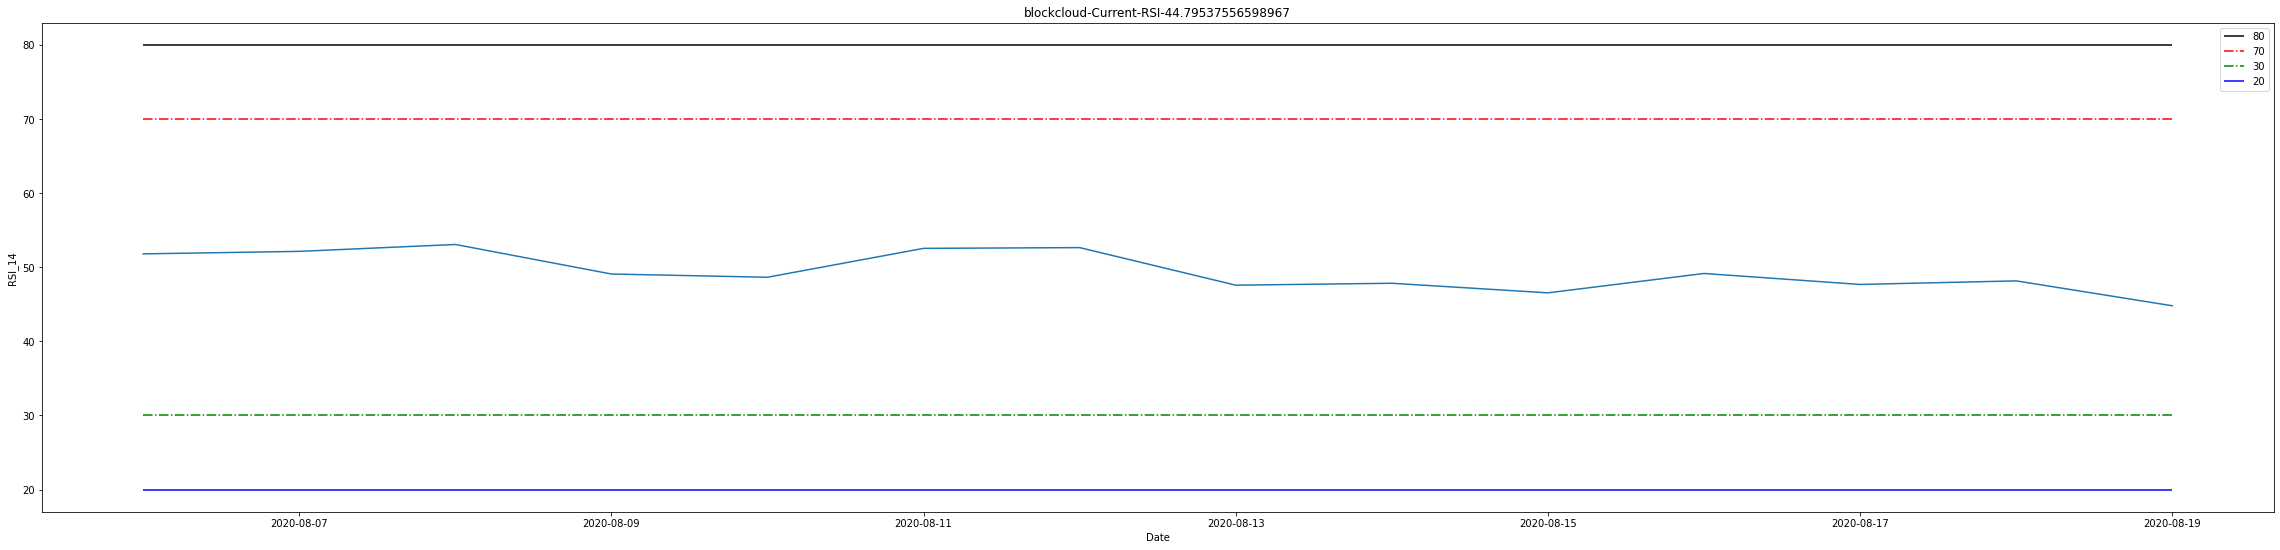

Plotting RSI (60.20973920779837) for:  achain


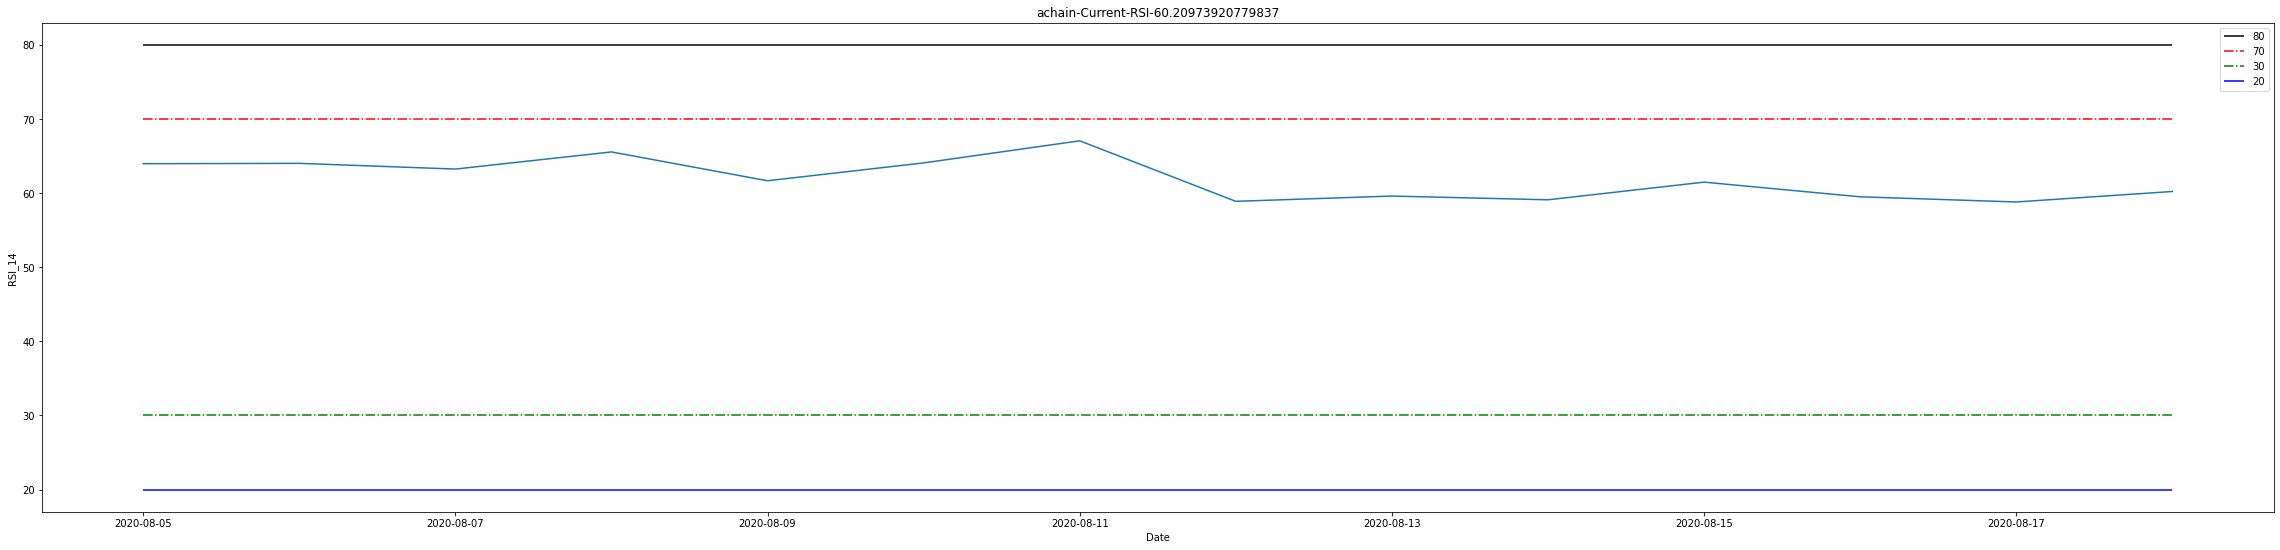

Plotting RSI (48.00616022309342) for:  tether


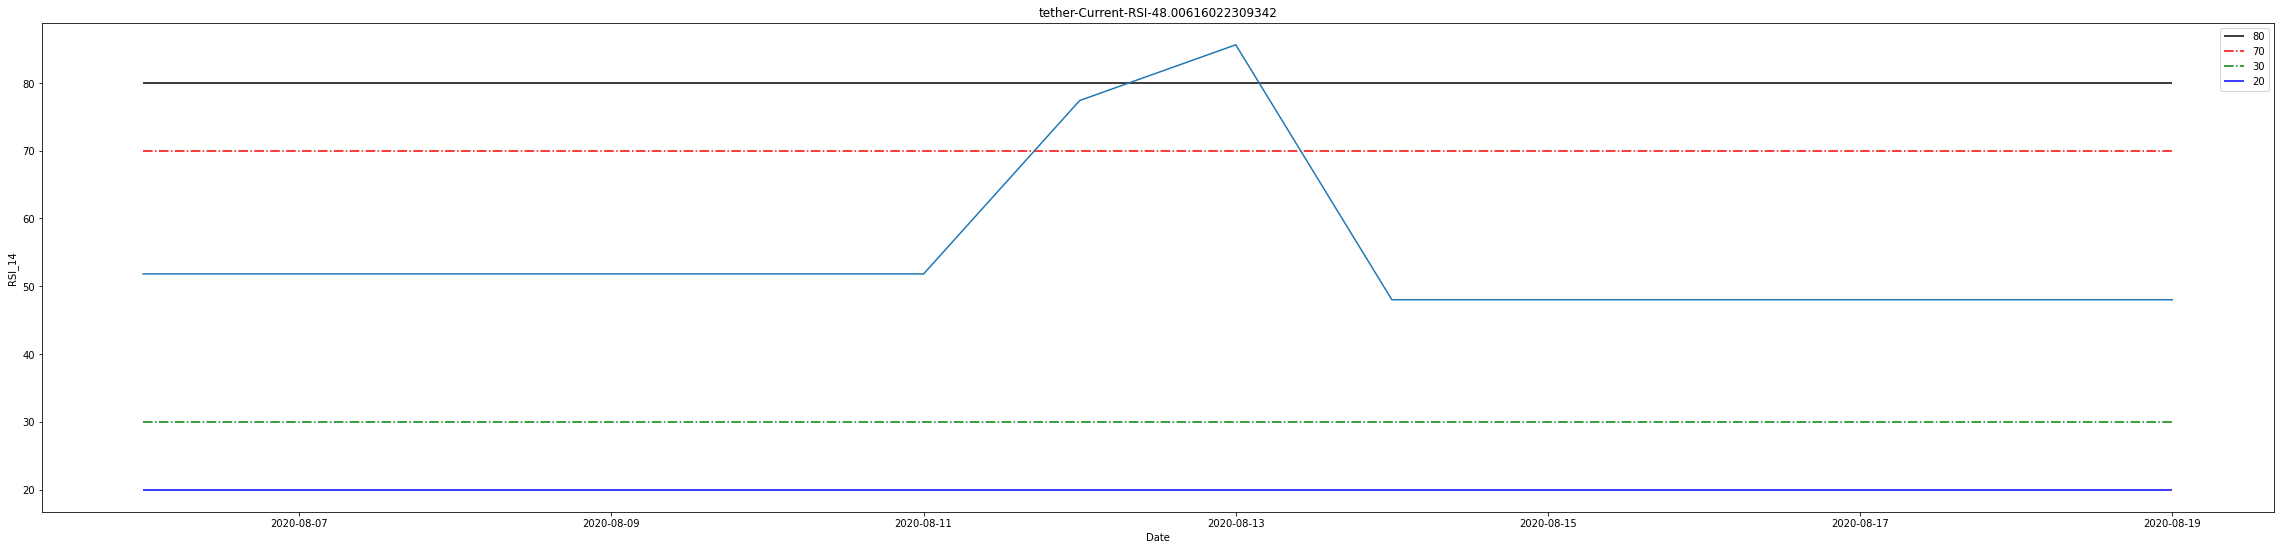

Plotting RSI (62.230315284456324) for:  wax


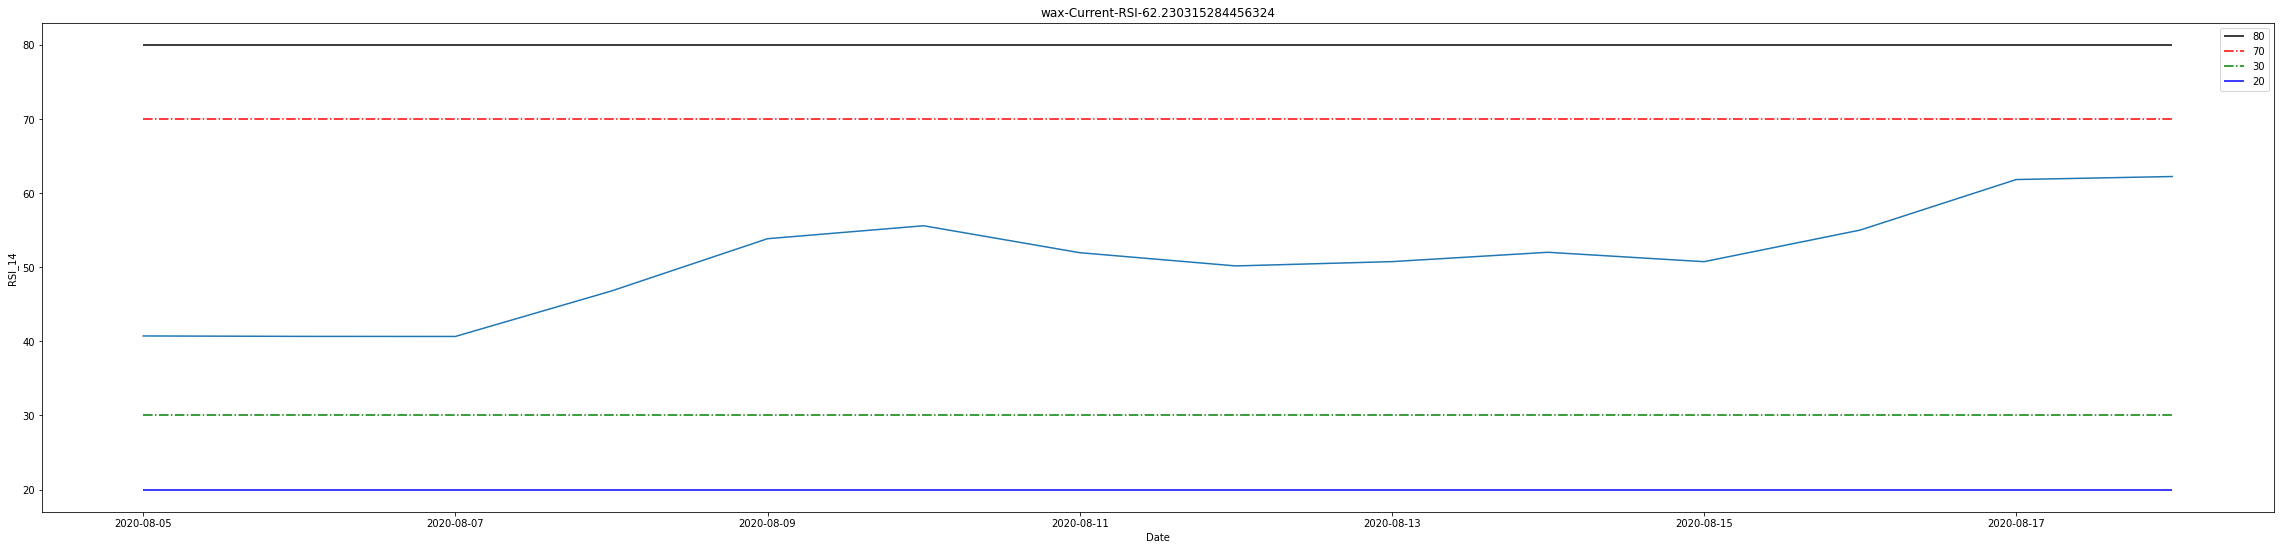

Plotting RSI (66.31858127350586) for:  0x


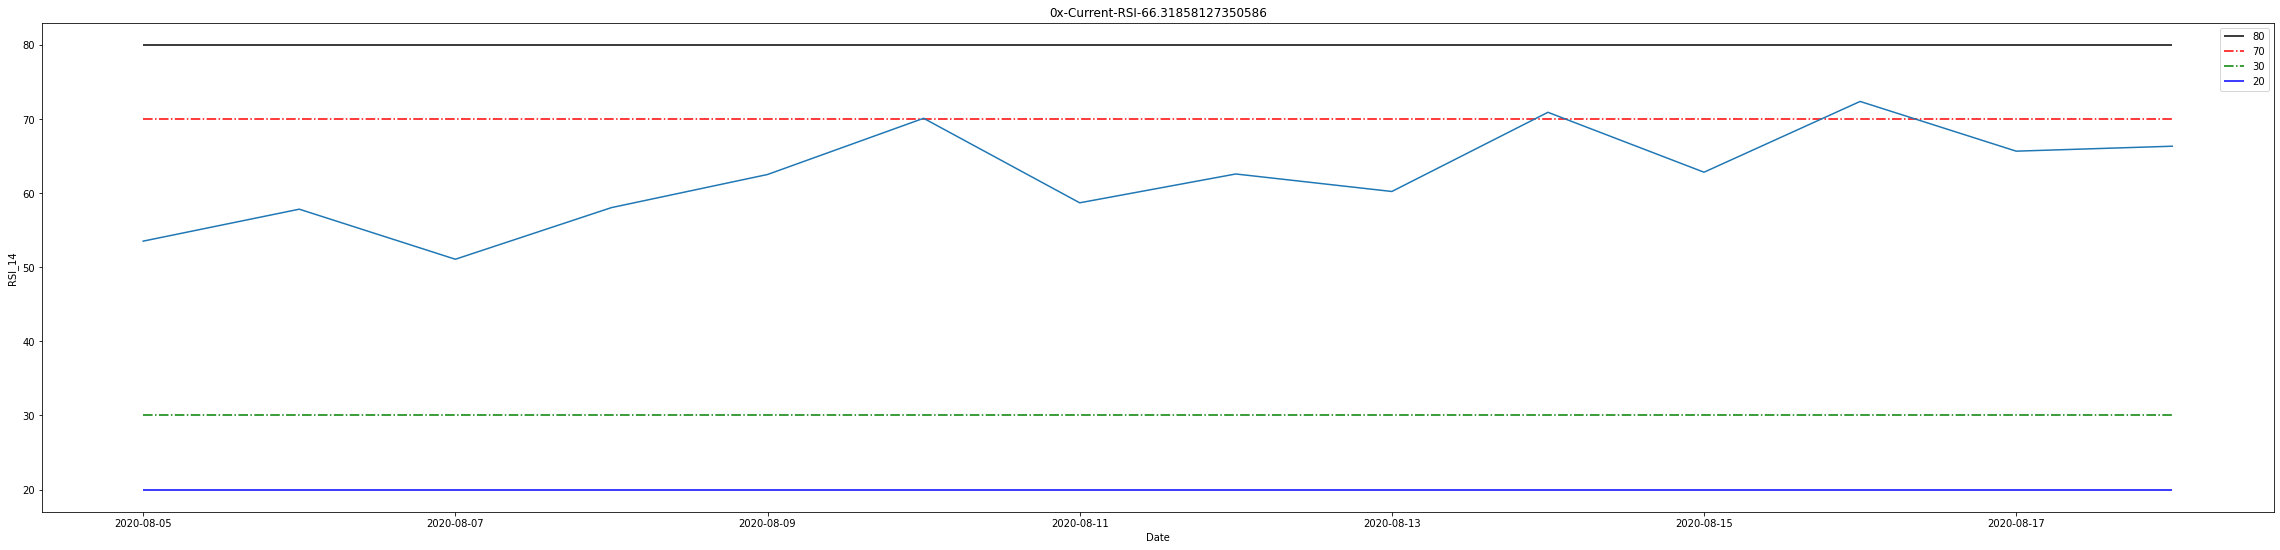

Plotting RSI (48.25535434589848) for:  open-platform


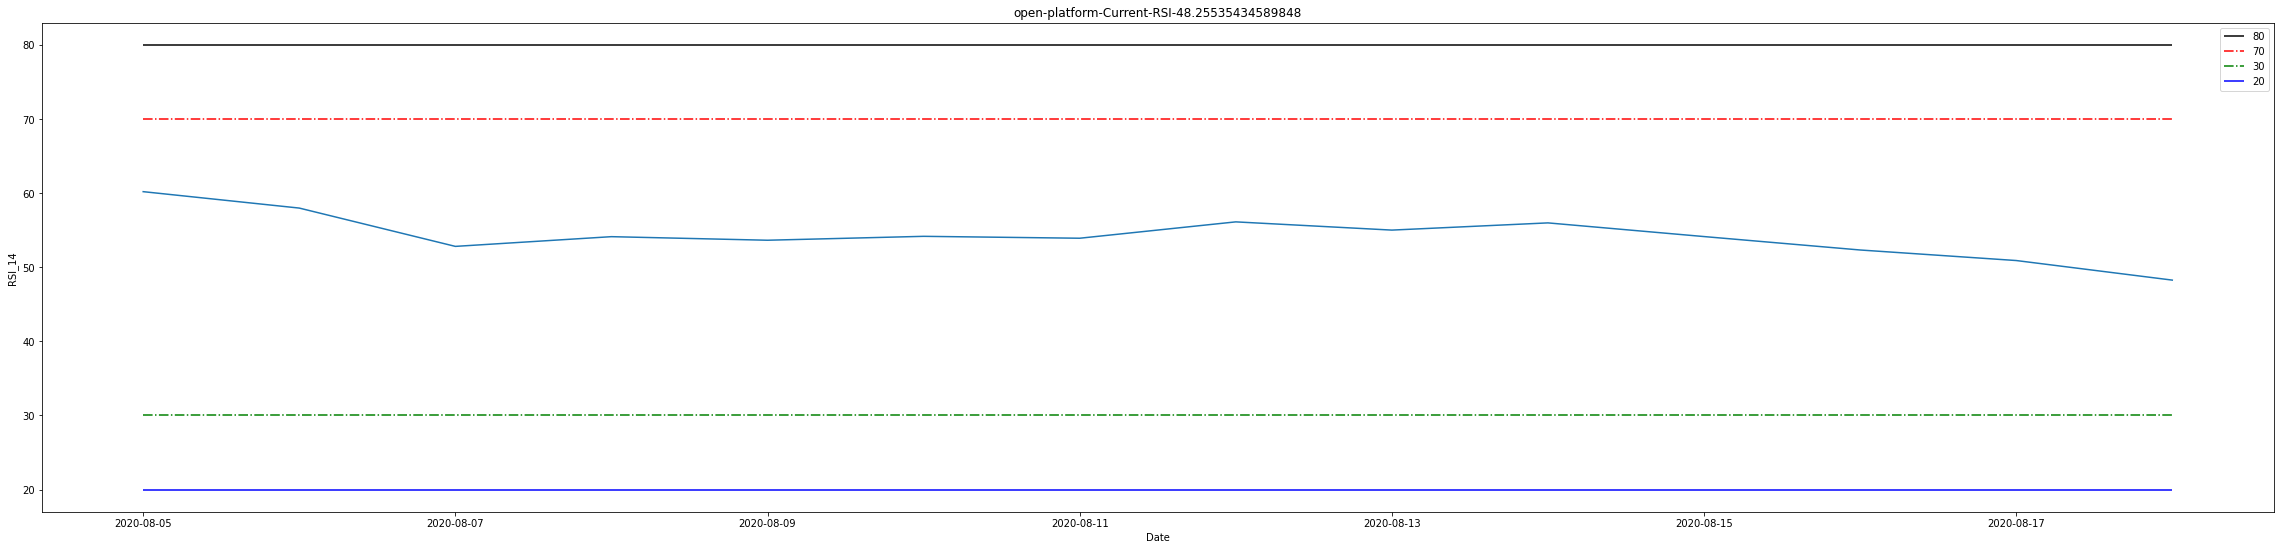

Plotting RSI (75.96917953191401) for:  eos-force


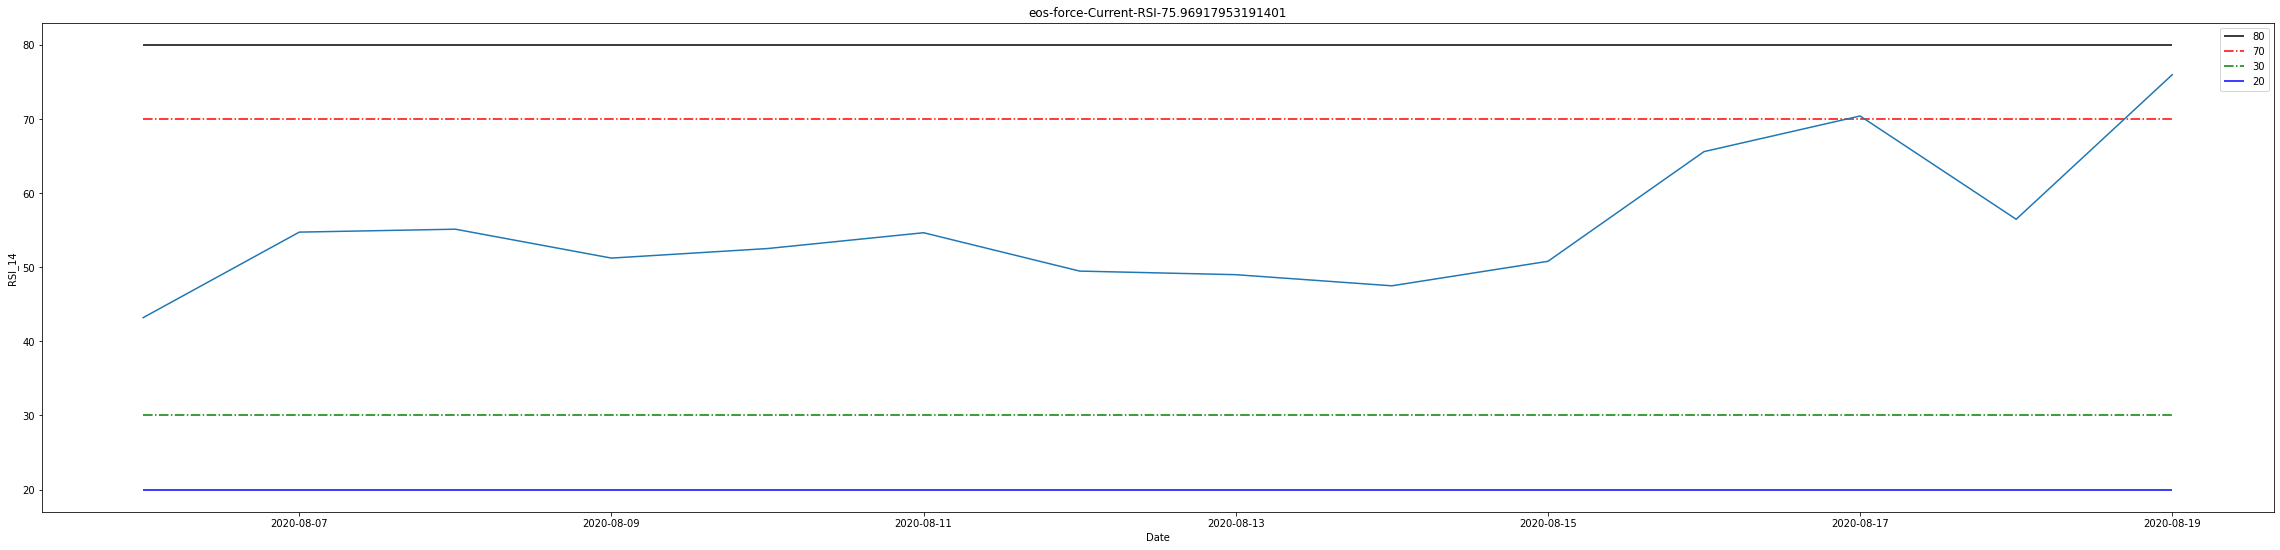

Plotting RSI (78.99060328658507) for:  experty


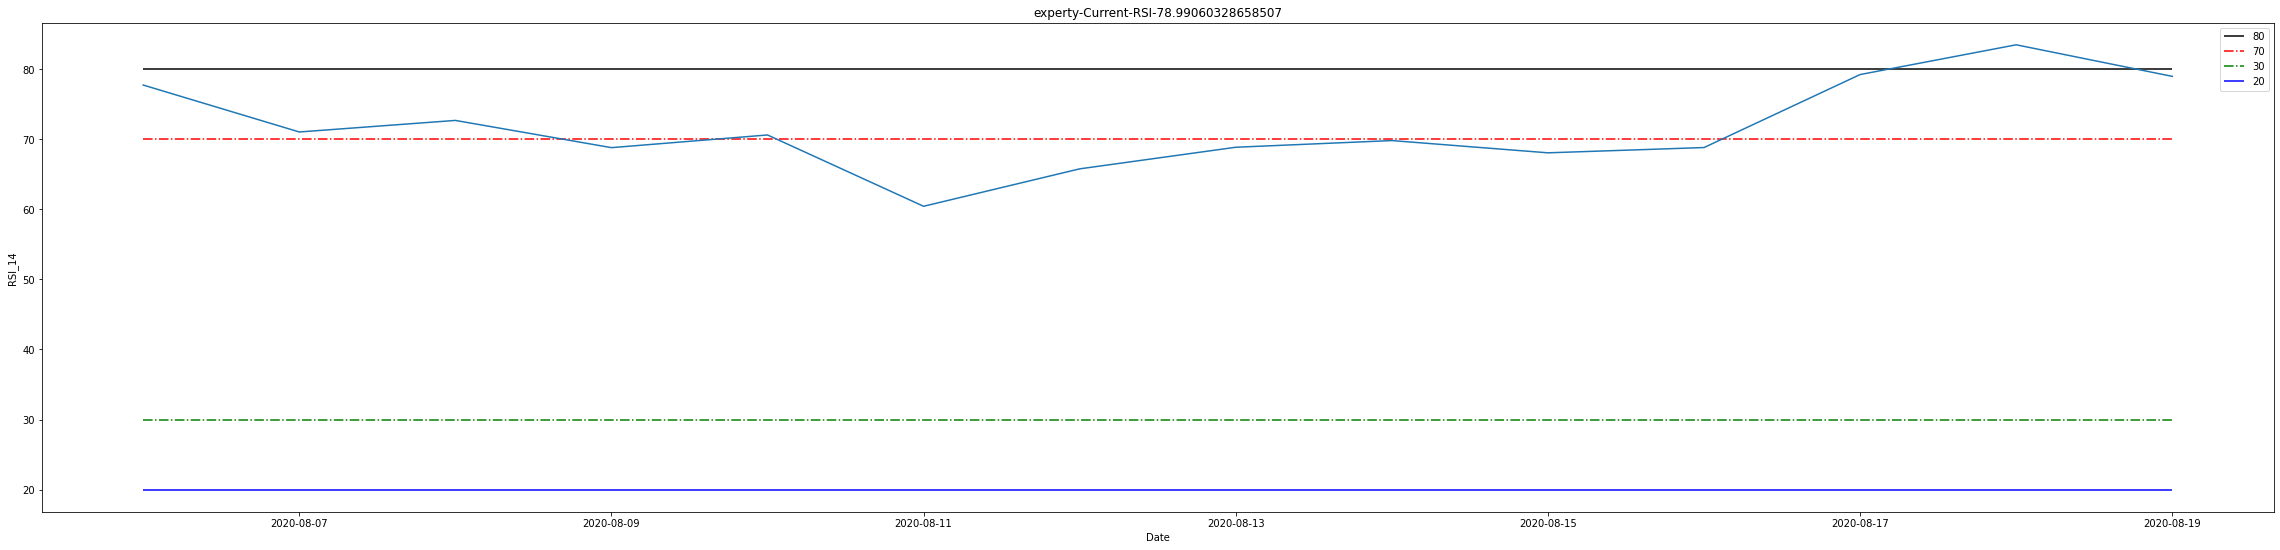

Plotting RSI (30.666296157253385) for:  suku


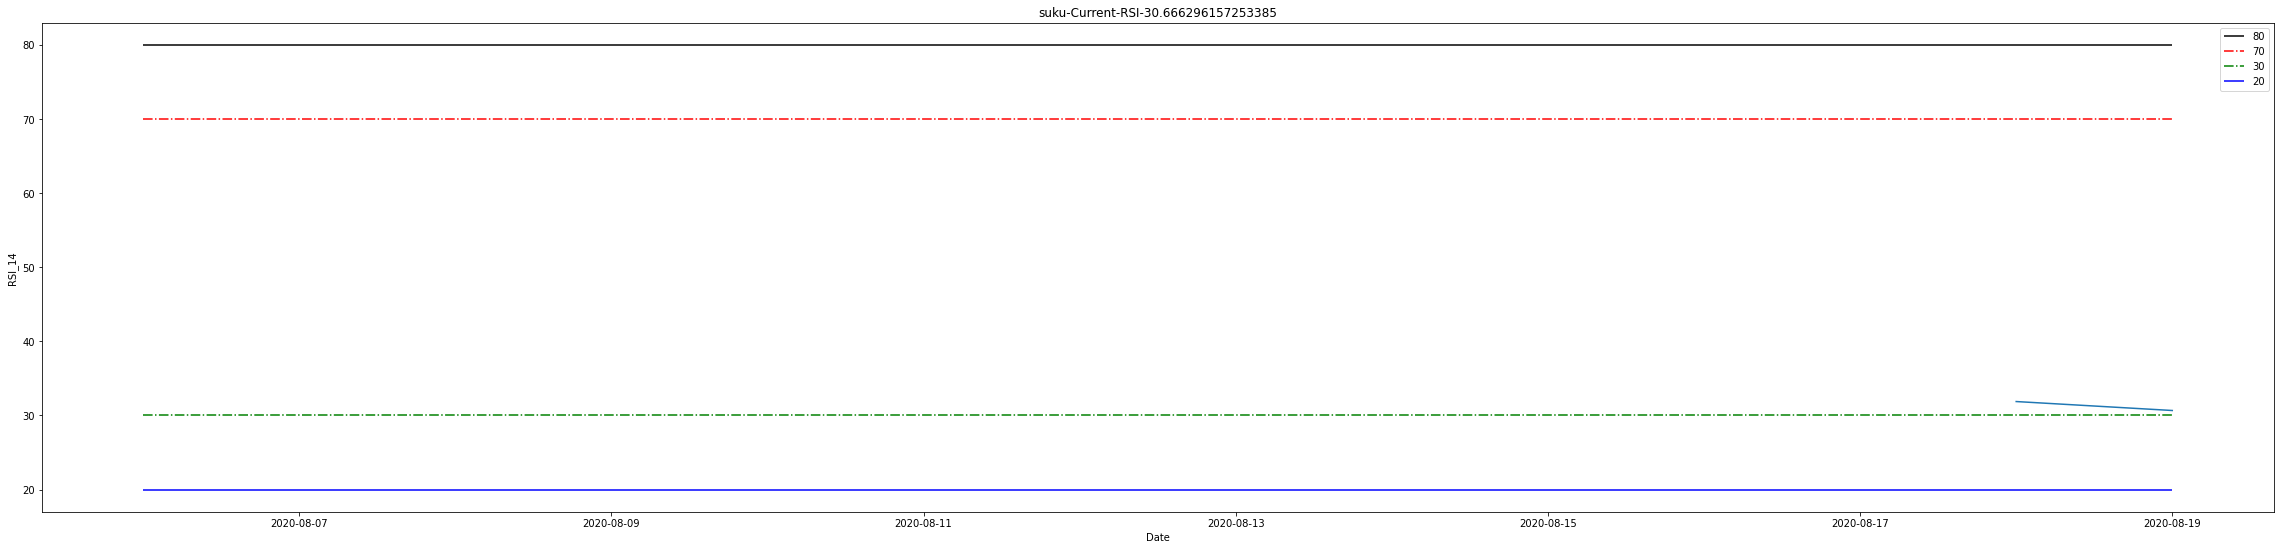

Plotting RSI (62.29806956570033) for:  trias


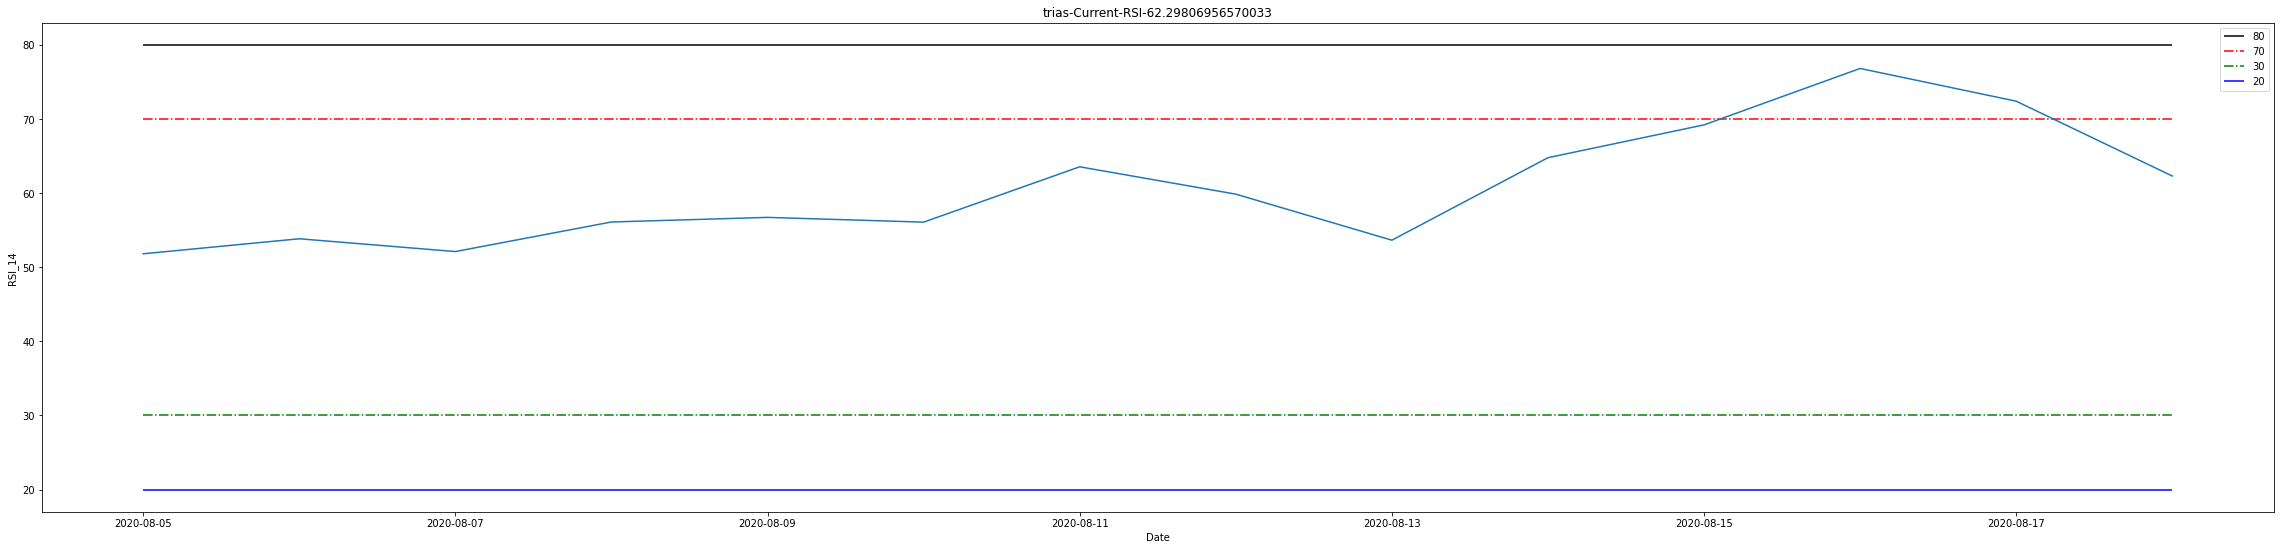

Plotting RSI (57.85627978071108) for:  monero


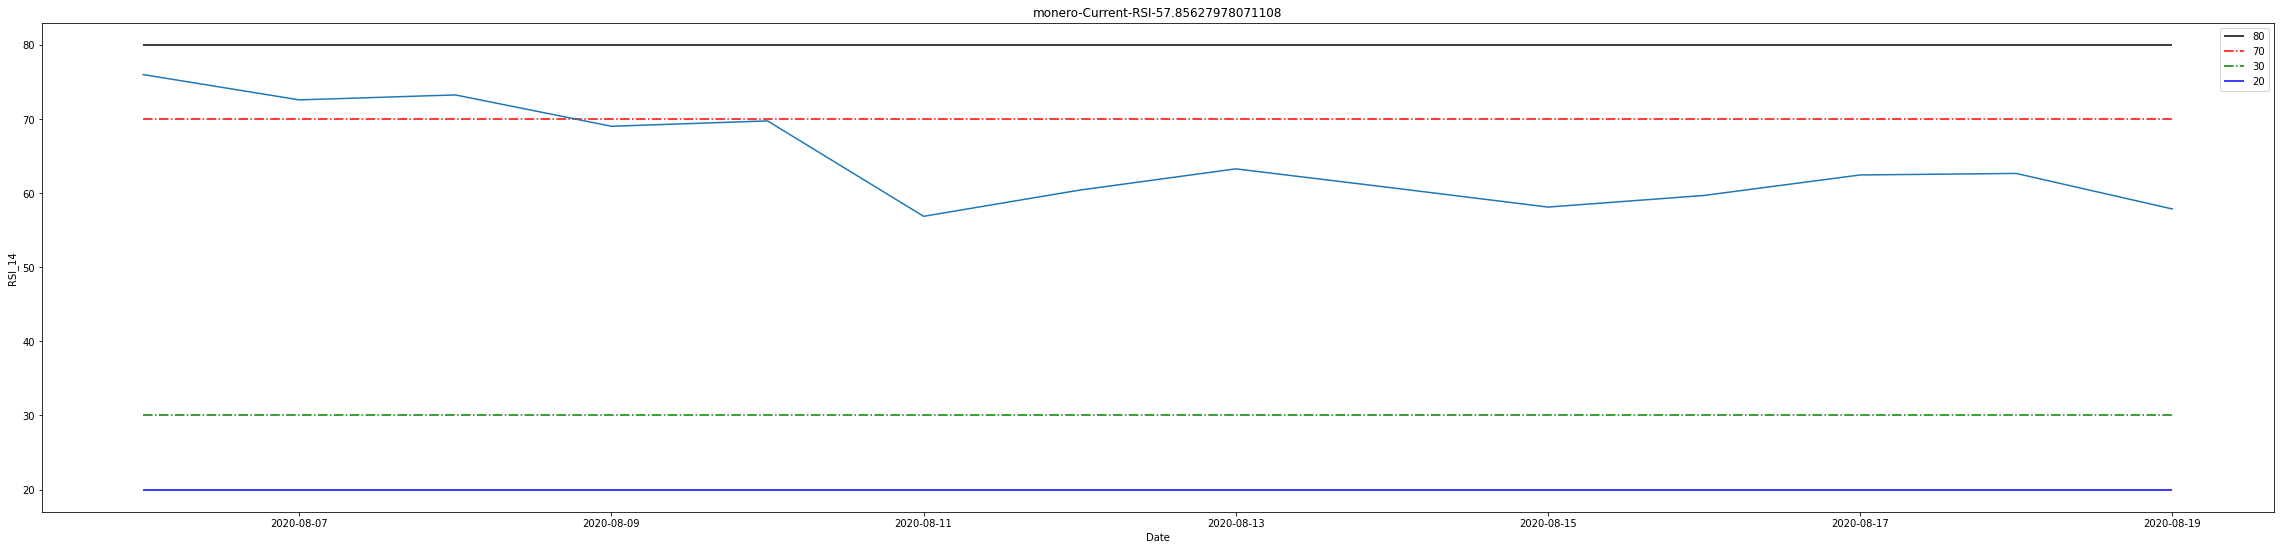

Plotting RSI (46.94001135671111) for:  nuls


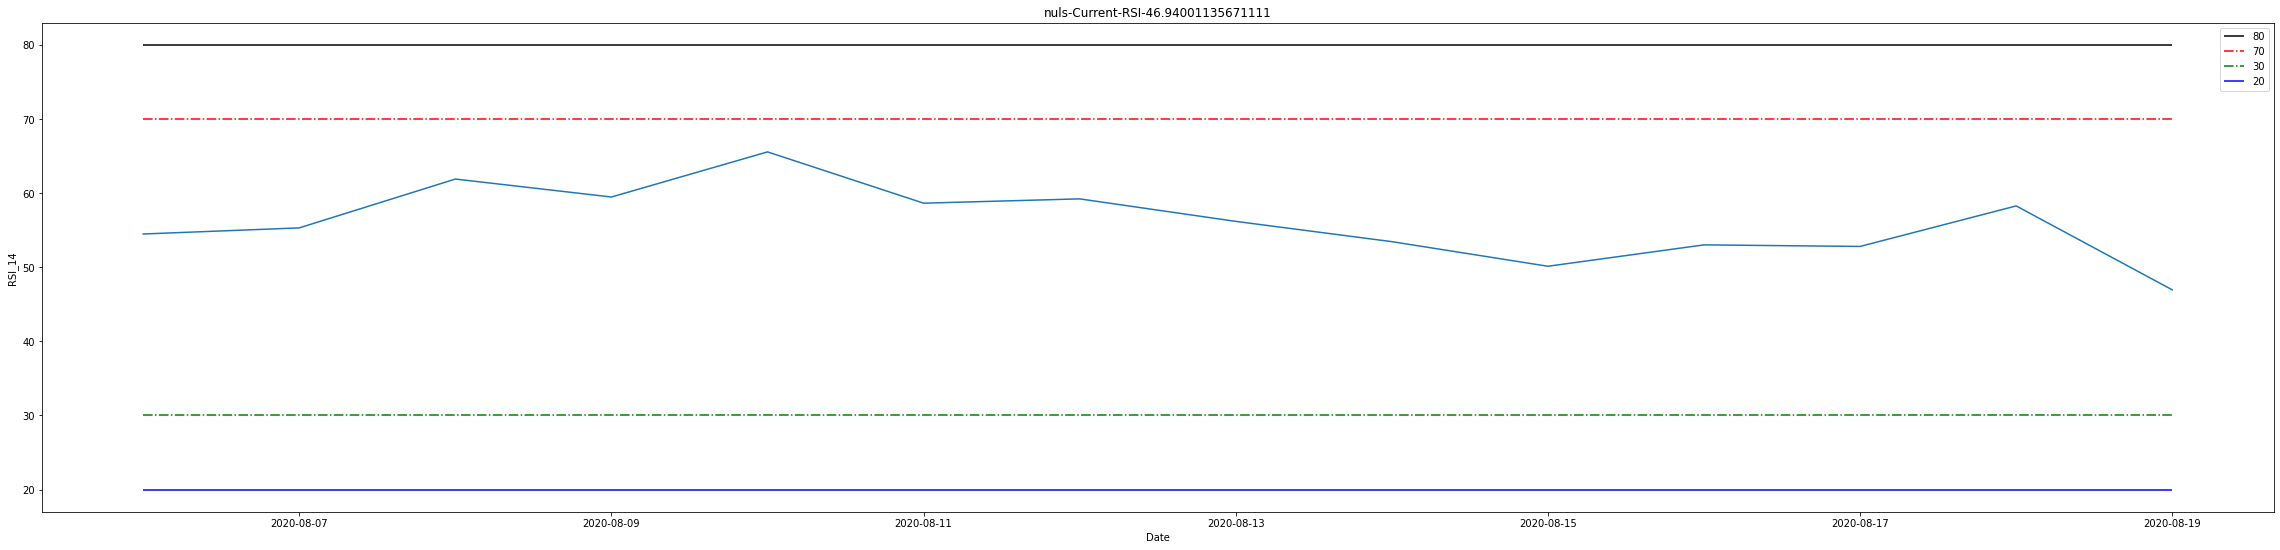

Plotting RSI (51.25402659600847) for:  travala


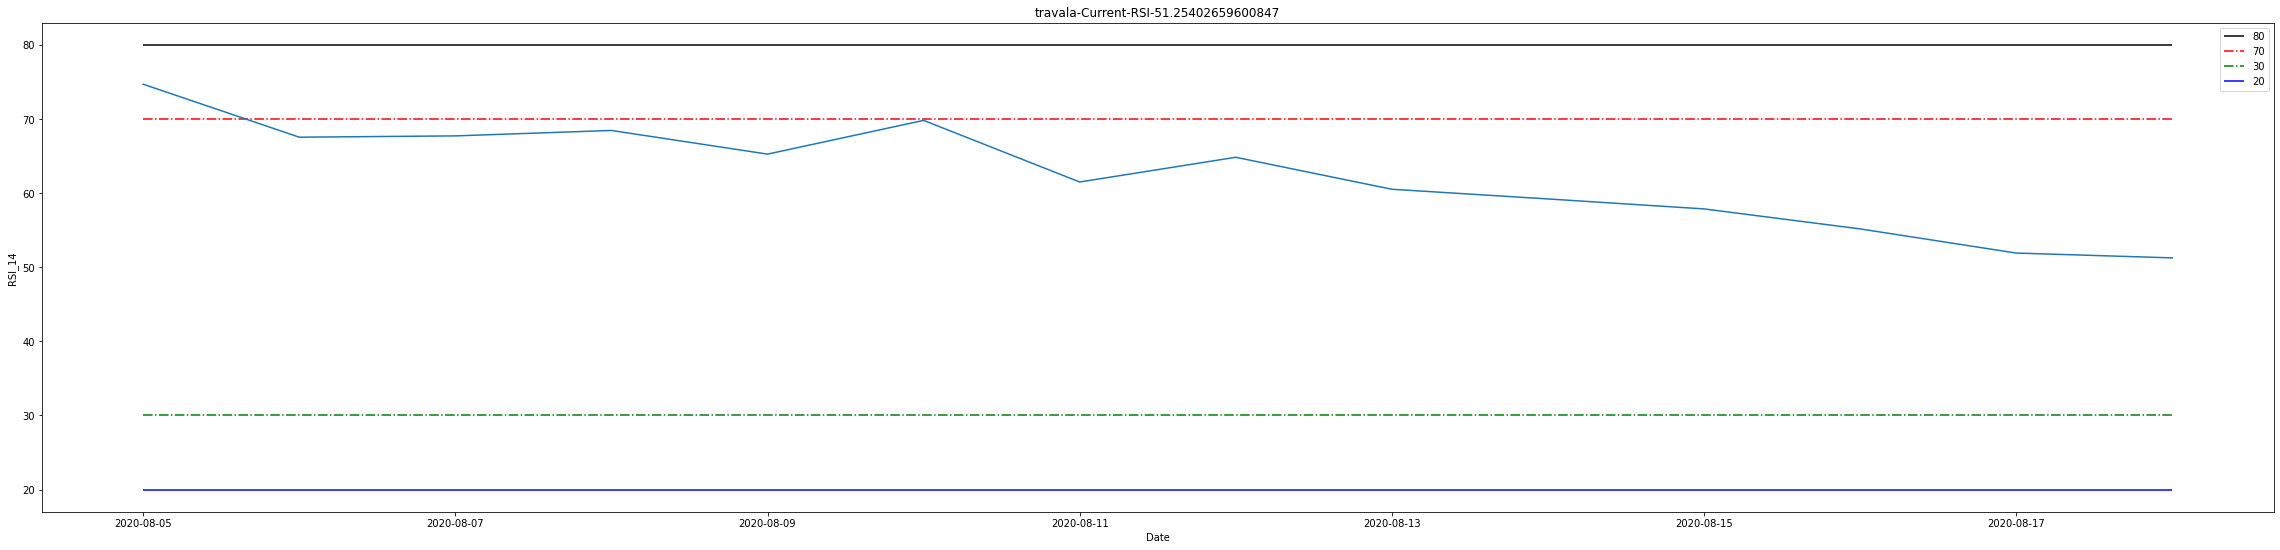

Plotting RSI (64.57585742127405) for:  betprotocol


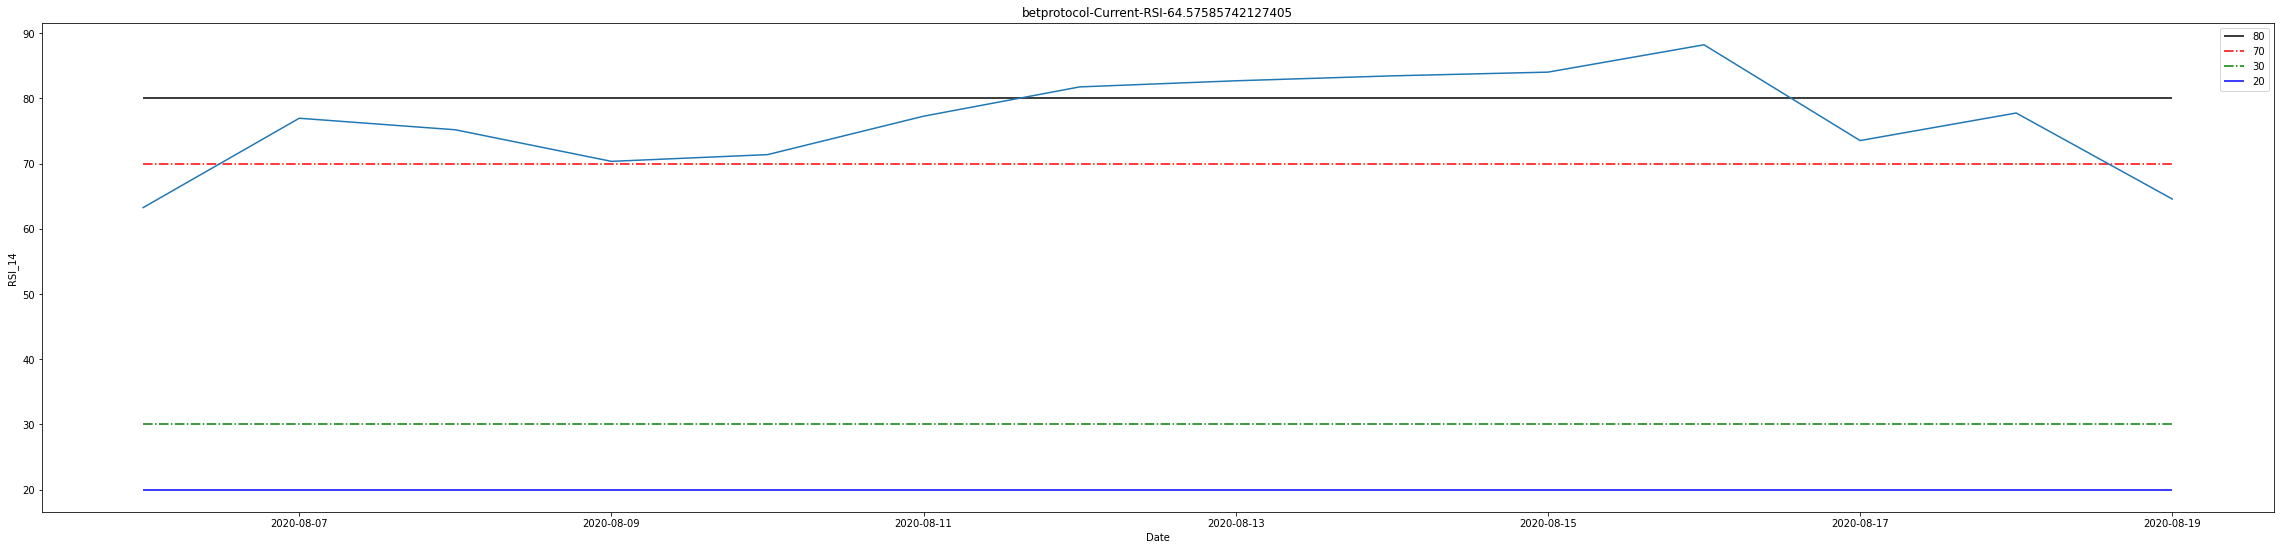

Plotting RSI (63.9034697544457) for:  fetch


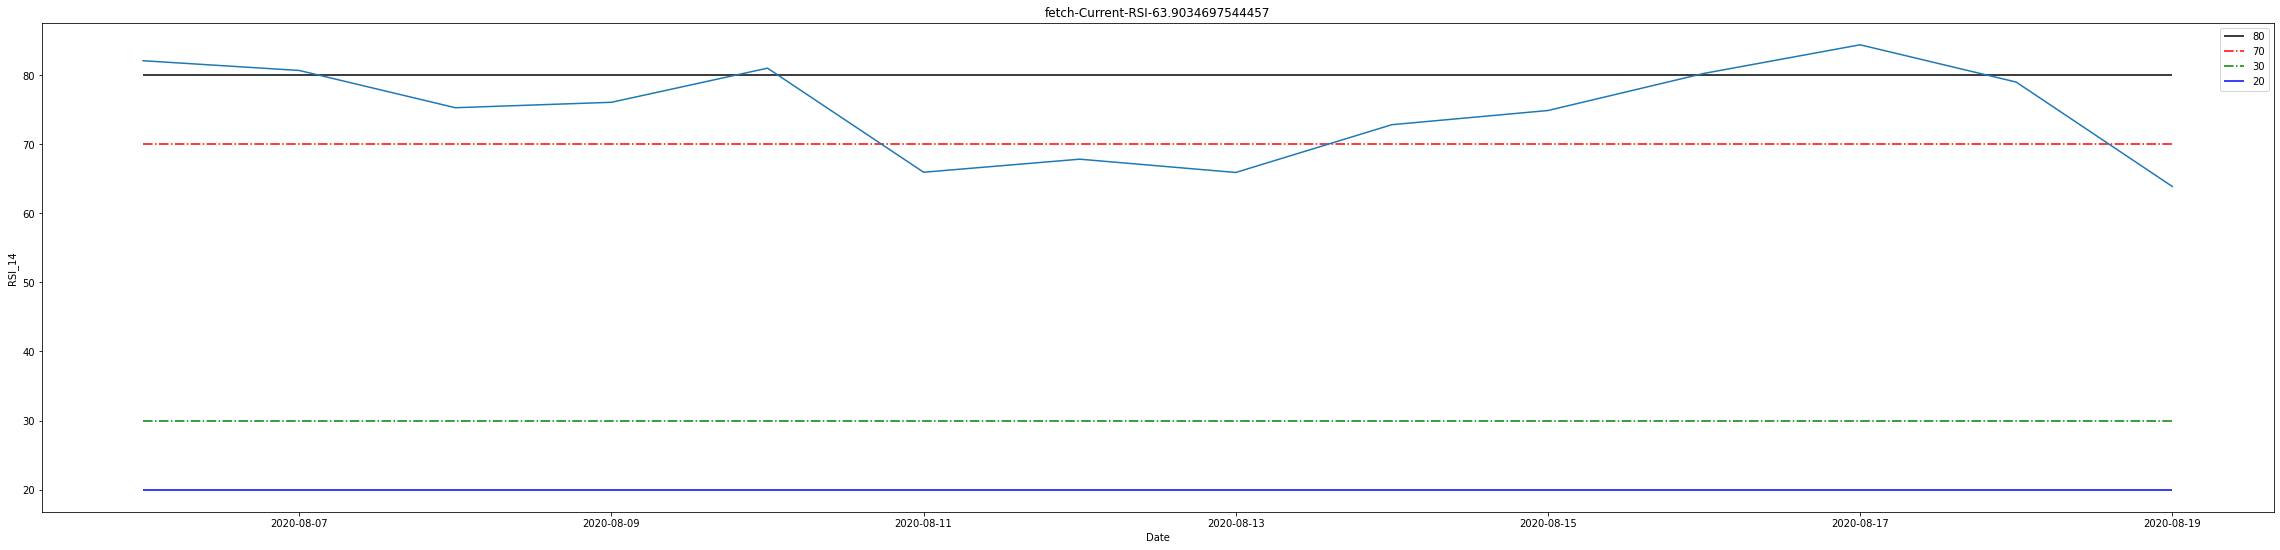

Plotting RSI (71.15363605627283) for:  just


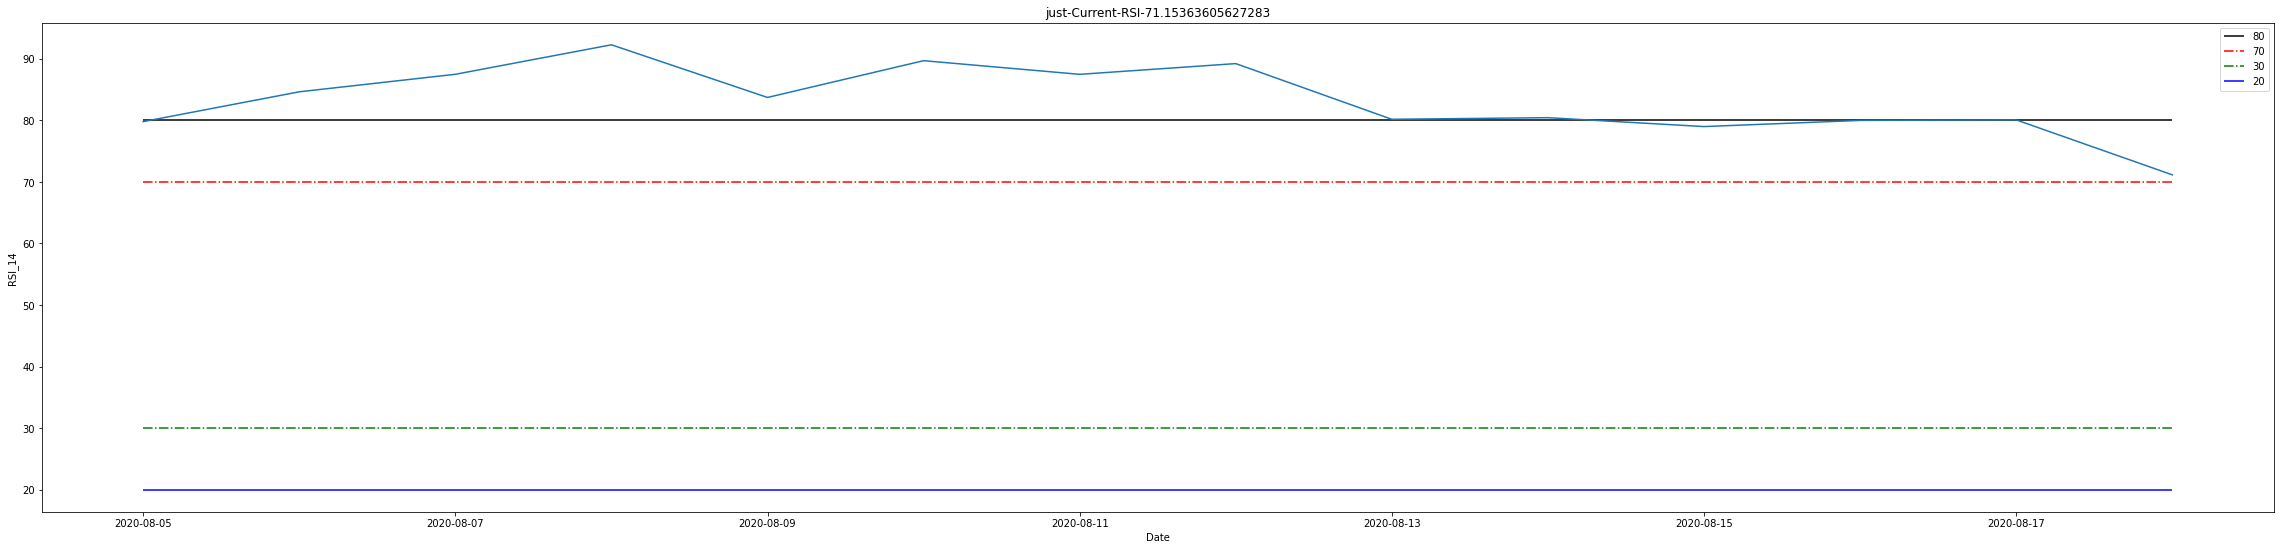

Plotting RSI (69.57372598359628) for:  ethereum


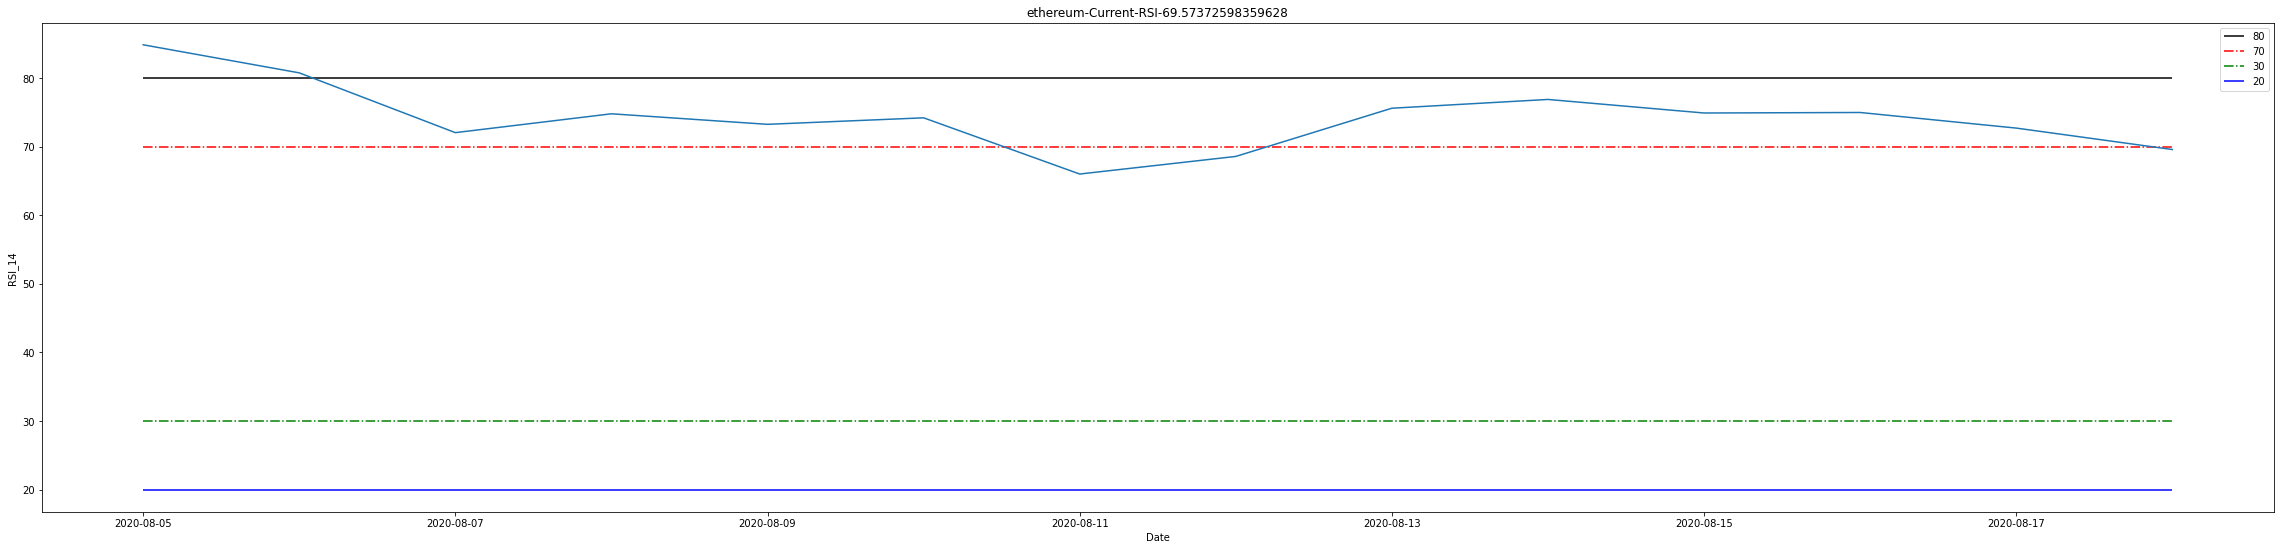

Plotting RSI (55.01750440018851) for:  v-systems


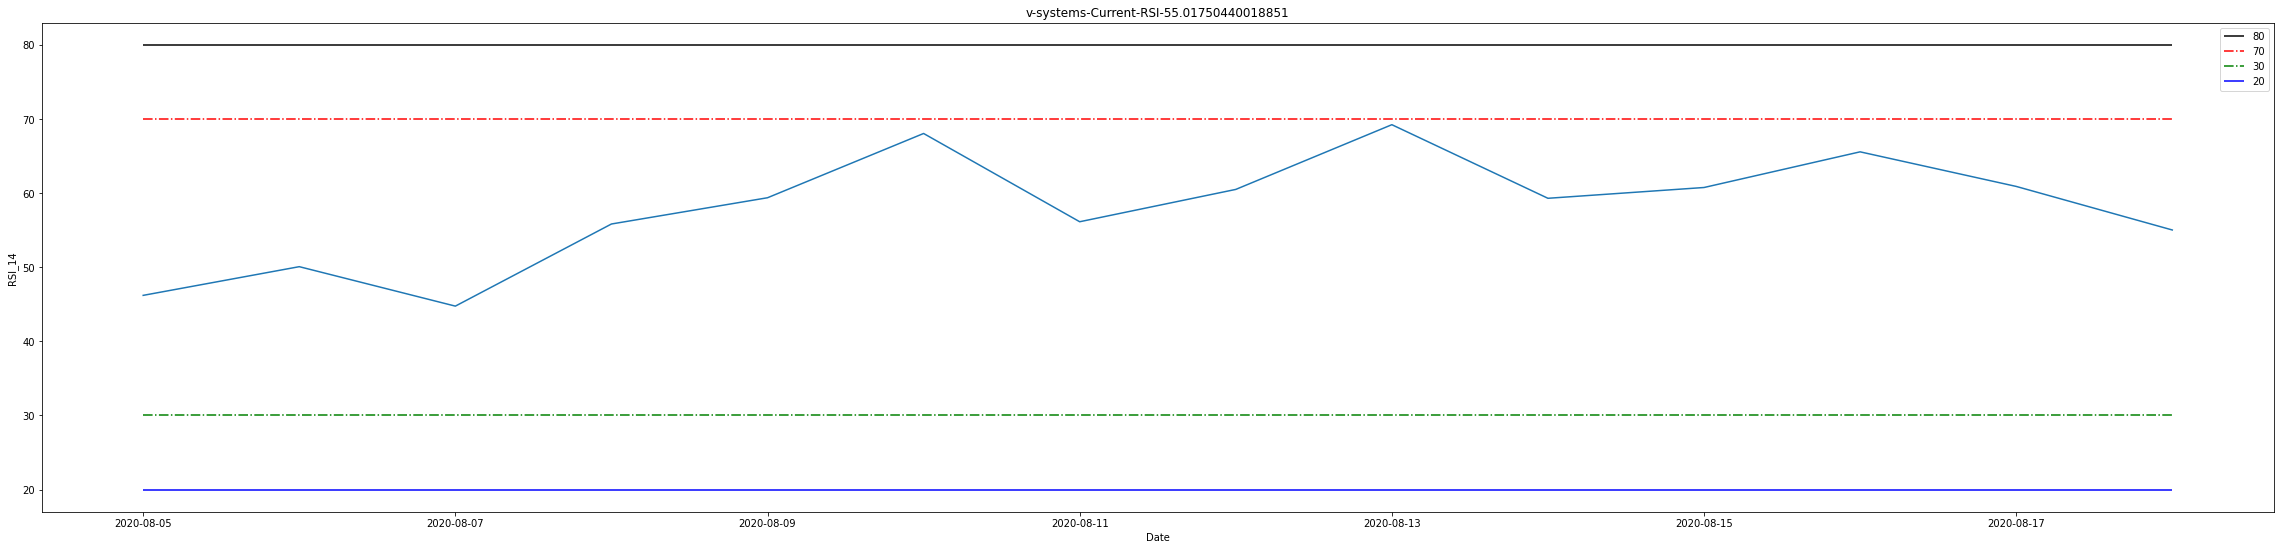

Plotting RSI (75.11467786042148) for:  civic


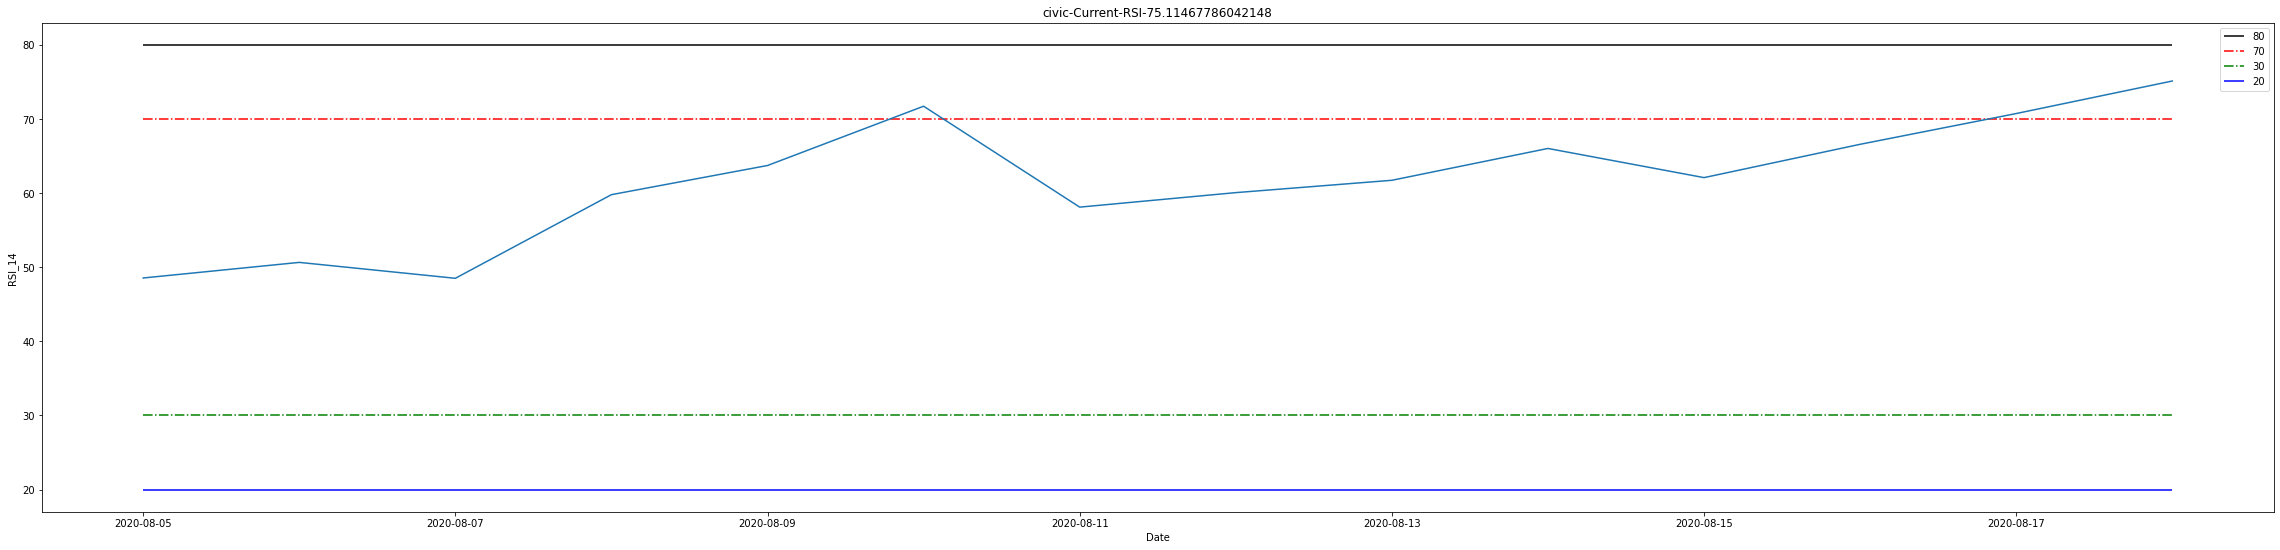

Plotting RSI (40.13714355739956) for:  insolar


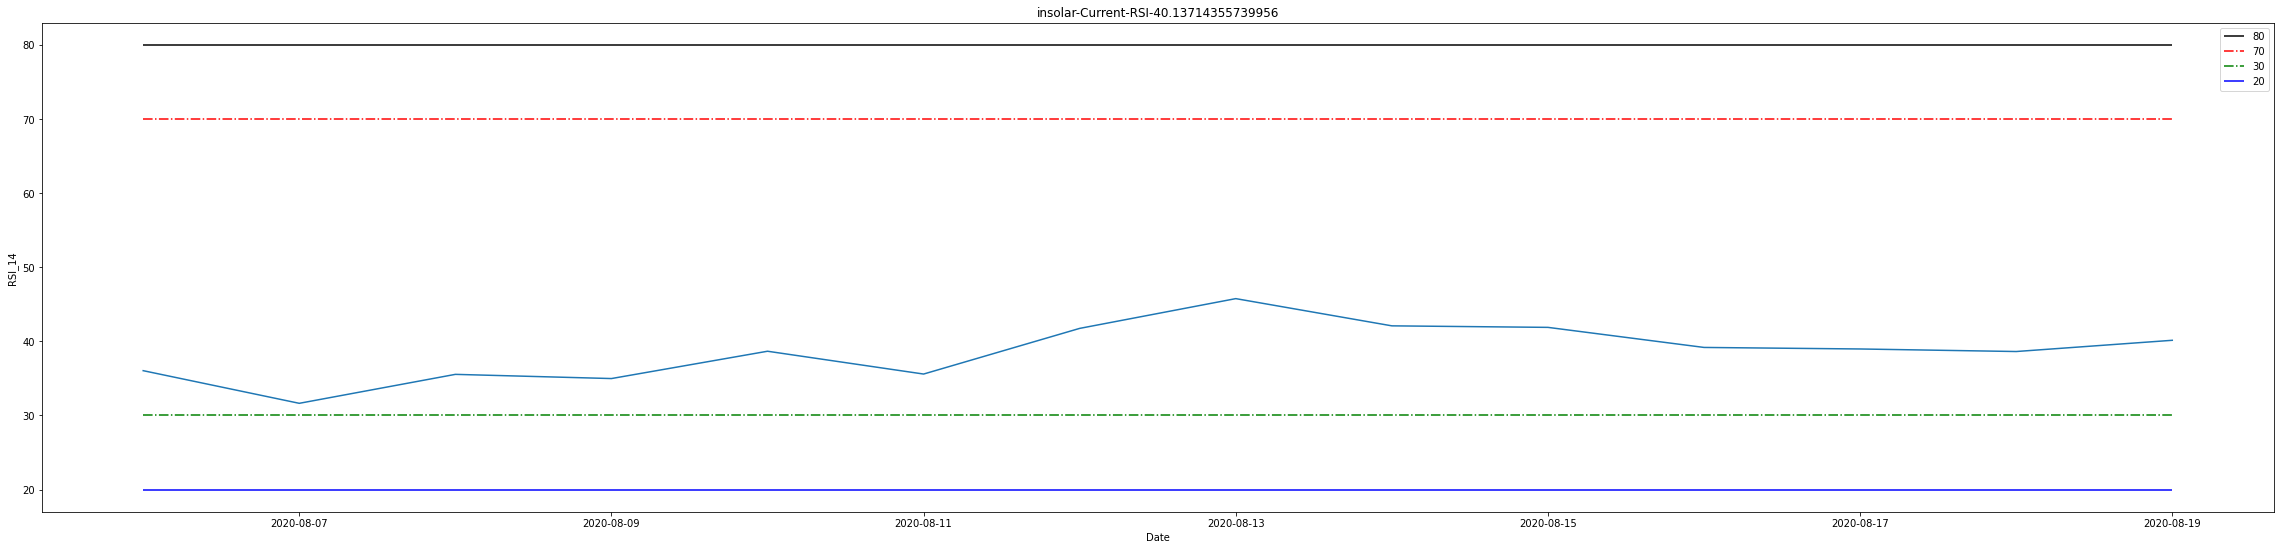

Plotting RSI (52.05486589202879) for:  bitcoin-cash


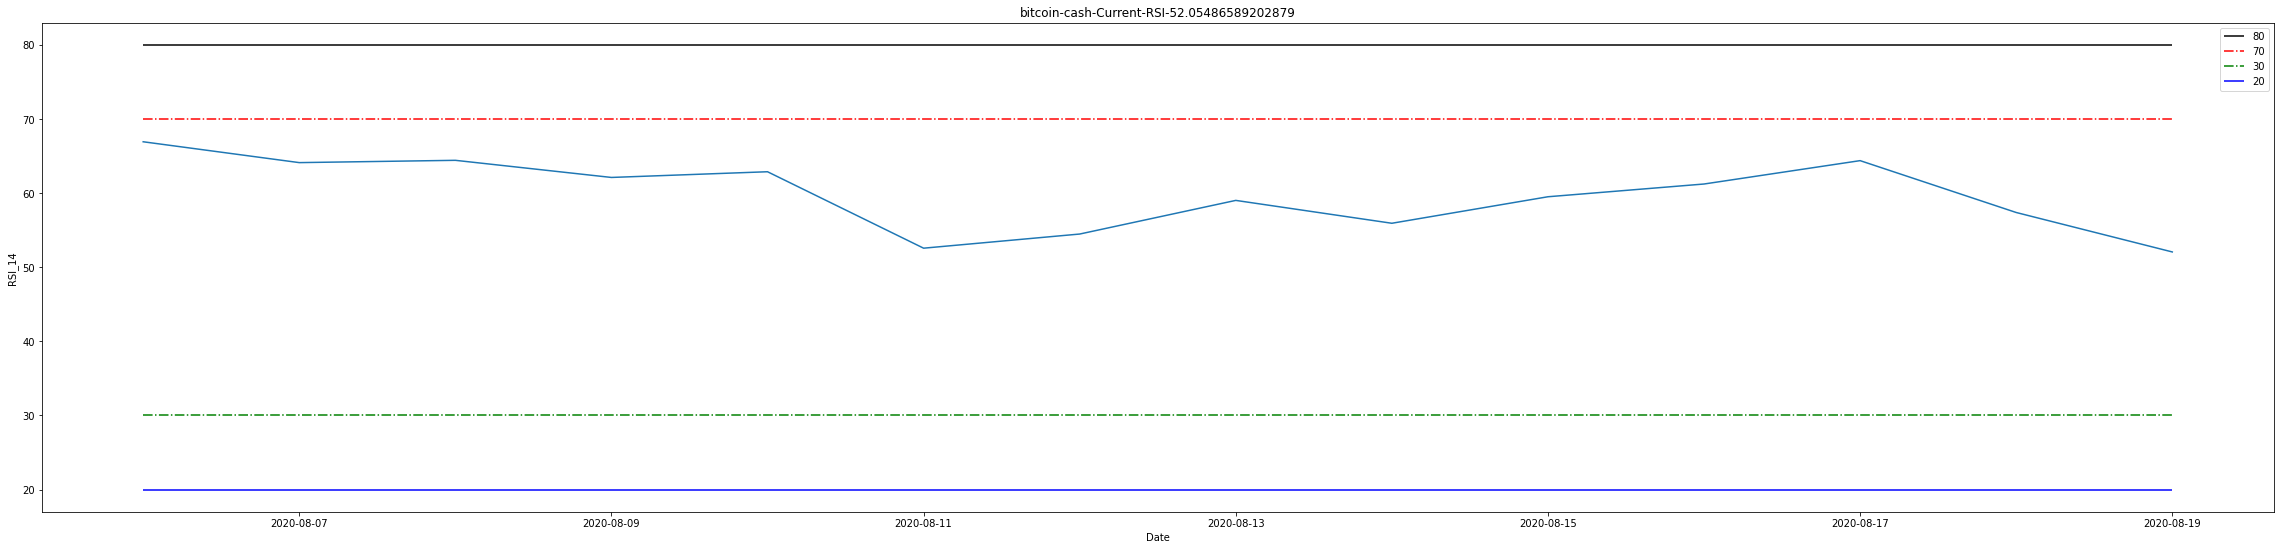

Plotting RSI (54.53969342546319) for:  roobee


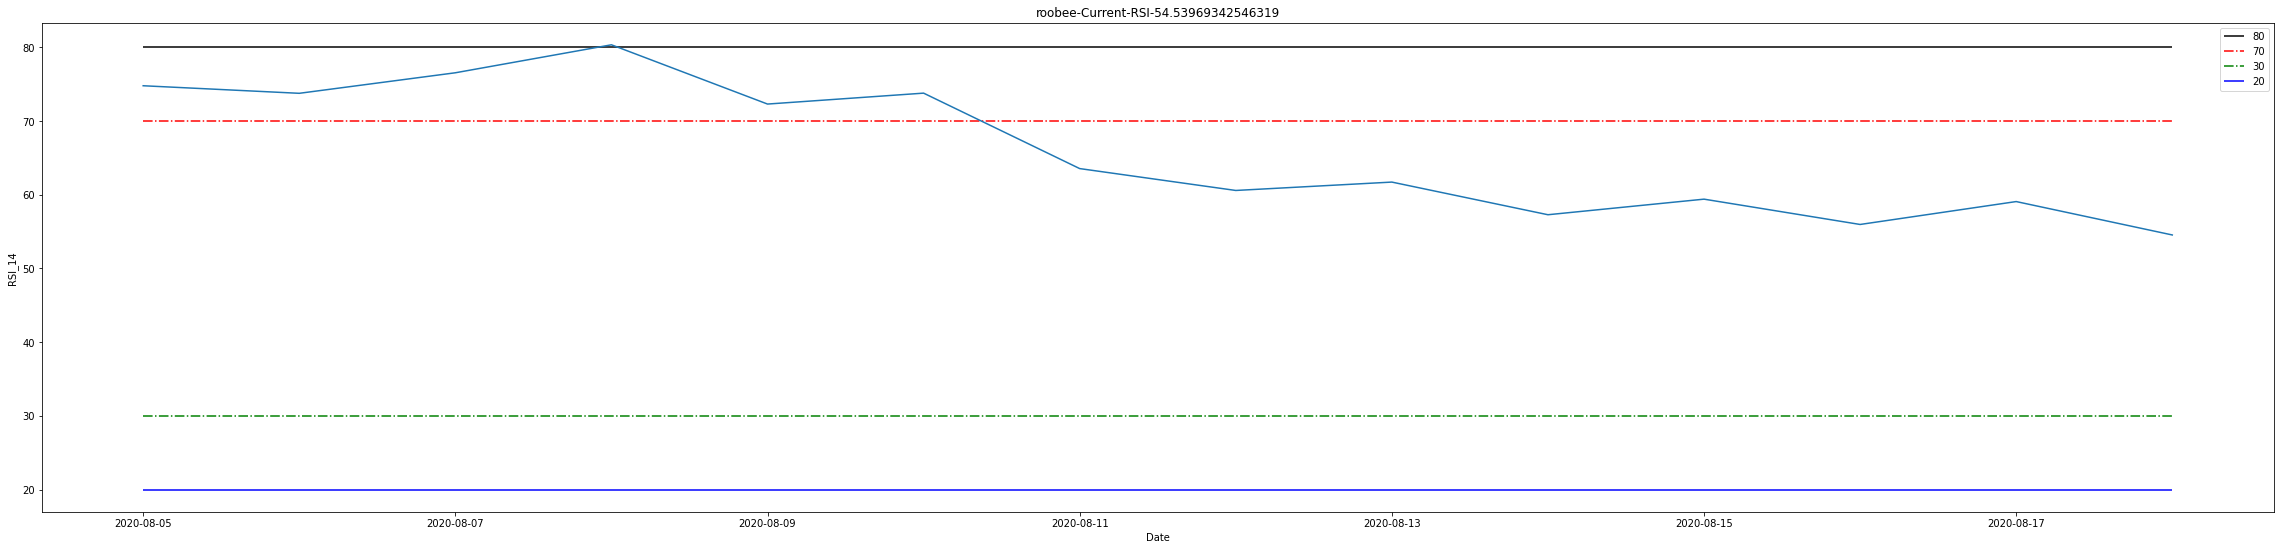

Plotting RSI (63.636999528408865) for:  eos


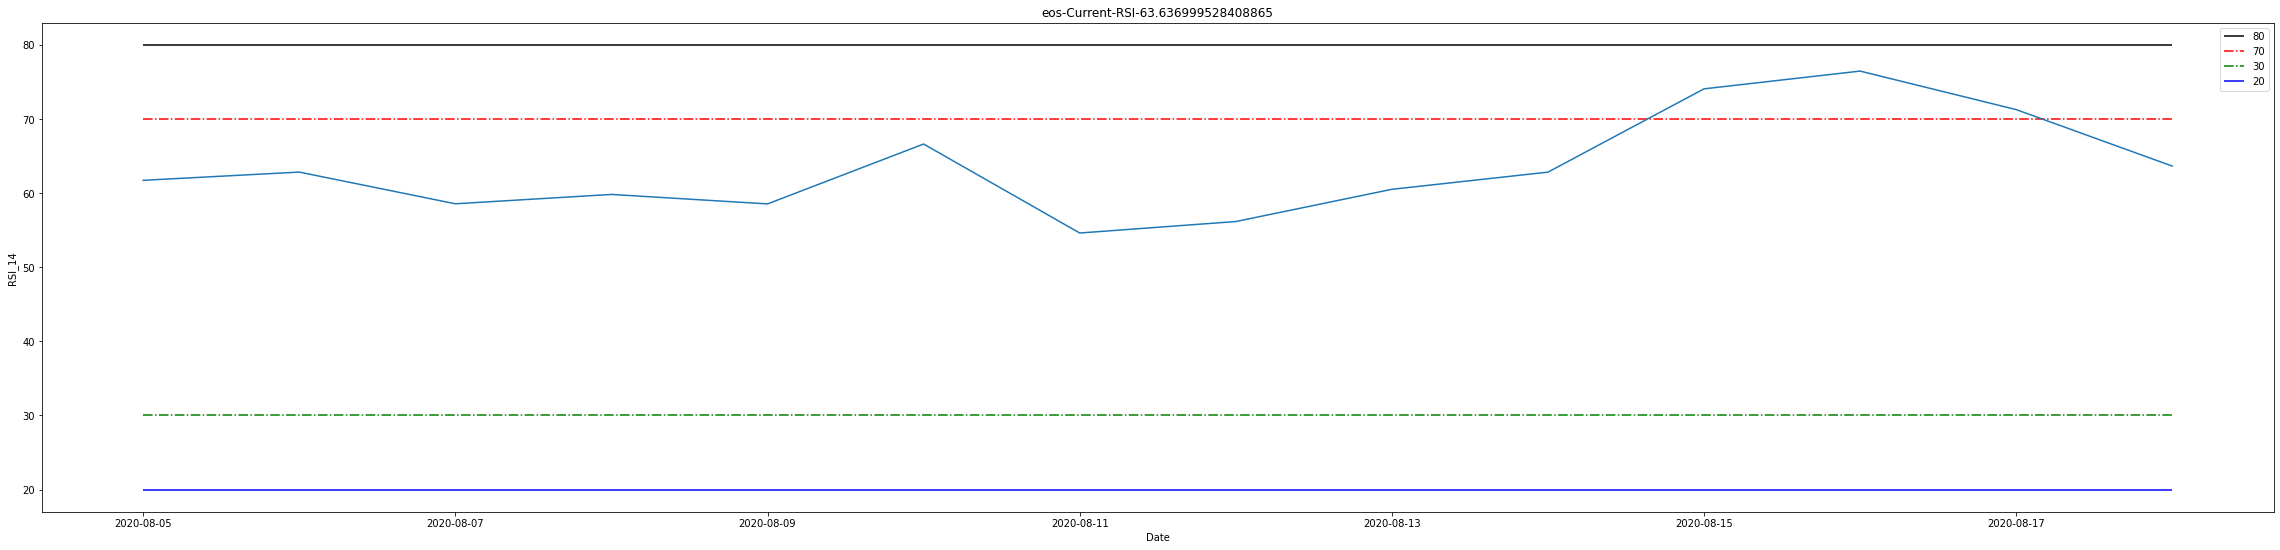

Plotting RSI (46.4679366842445) for:  nix


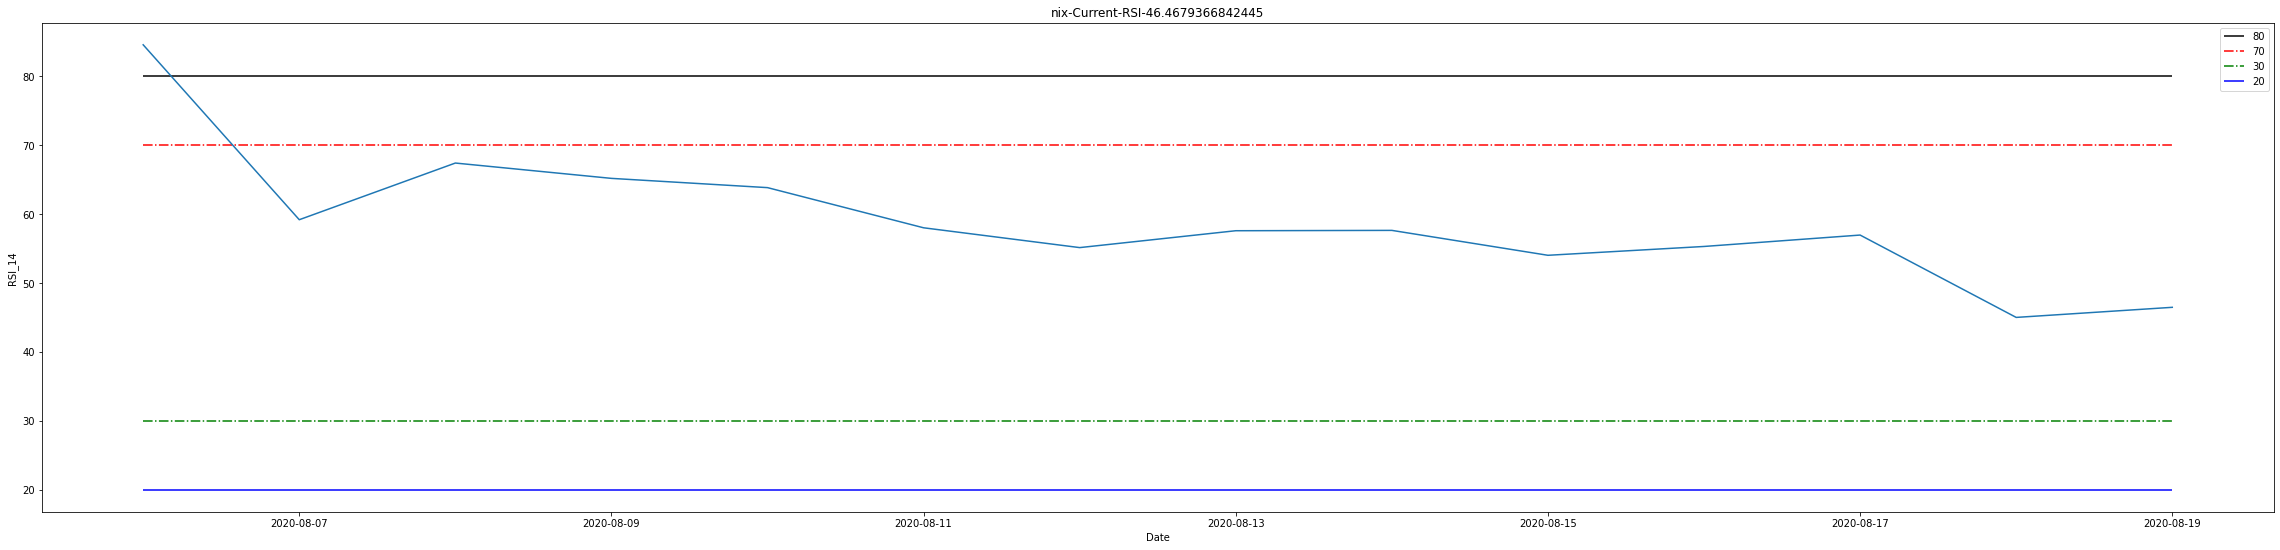

Plotting RSI (58.27740970366067) for:  chrono-tech


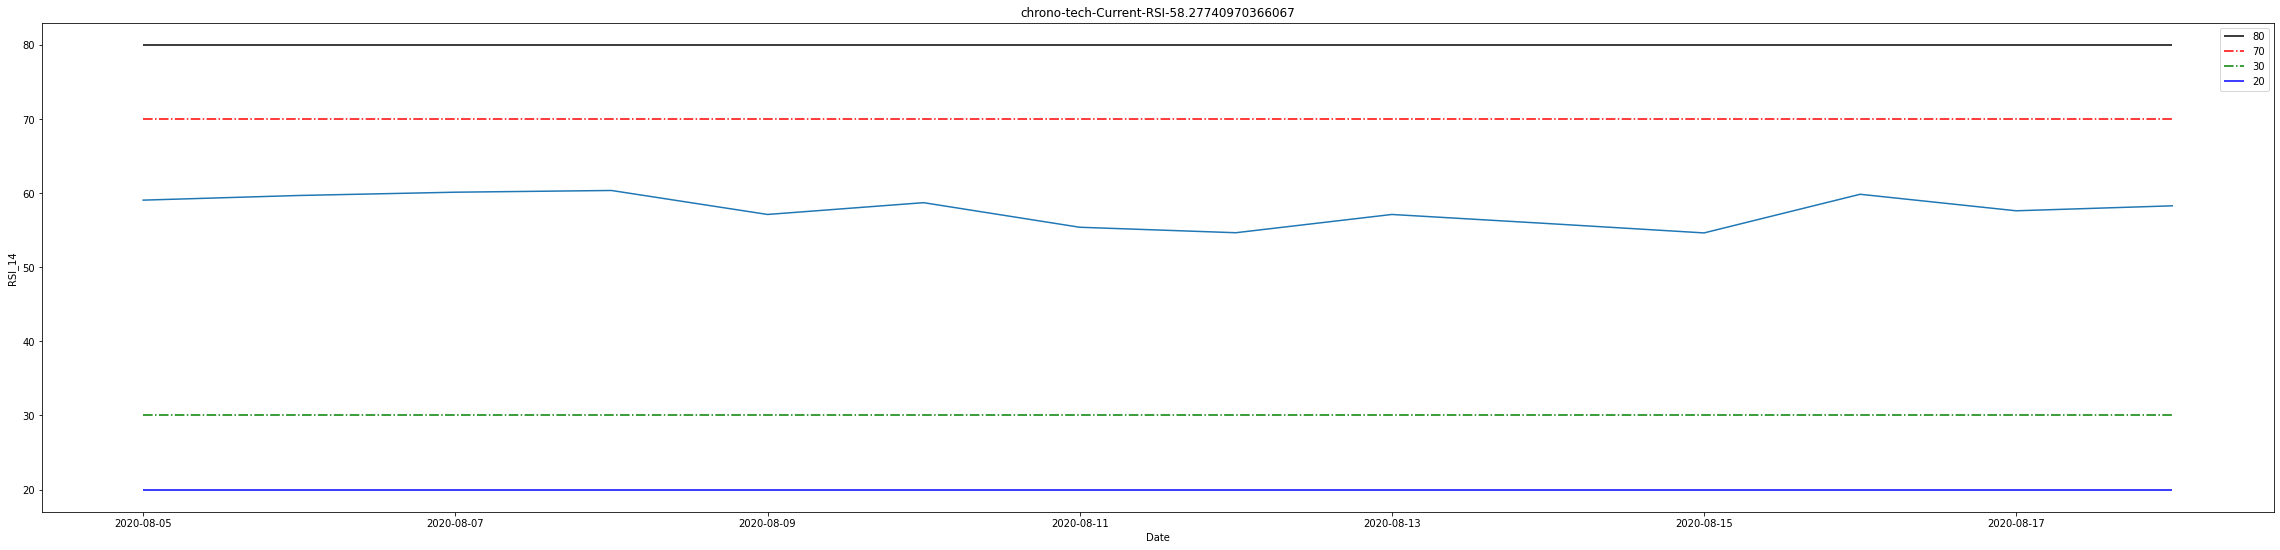

Plotting RSI (69.63934770489283) for:  coti


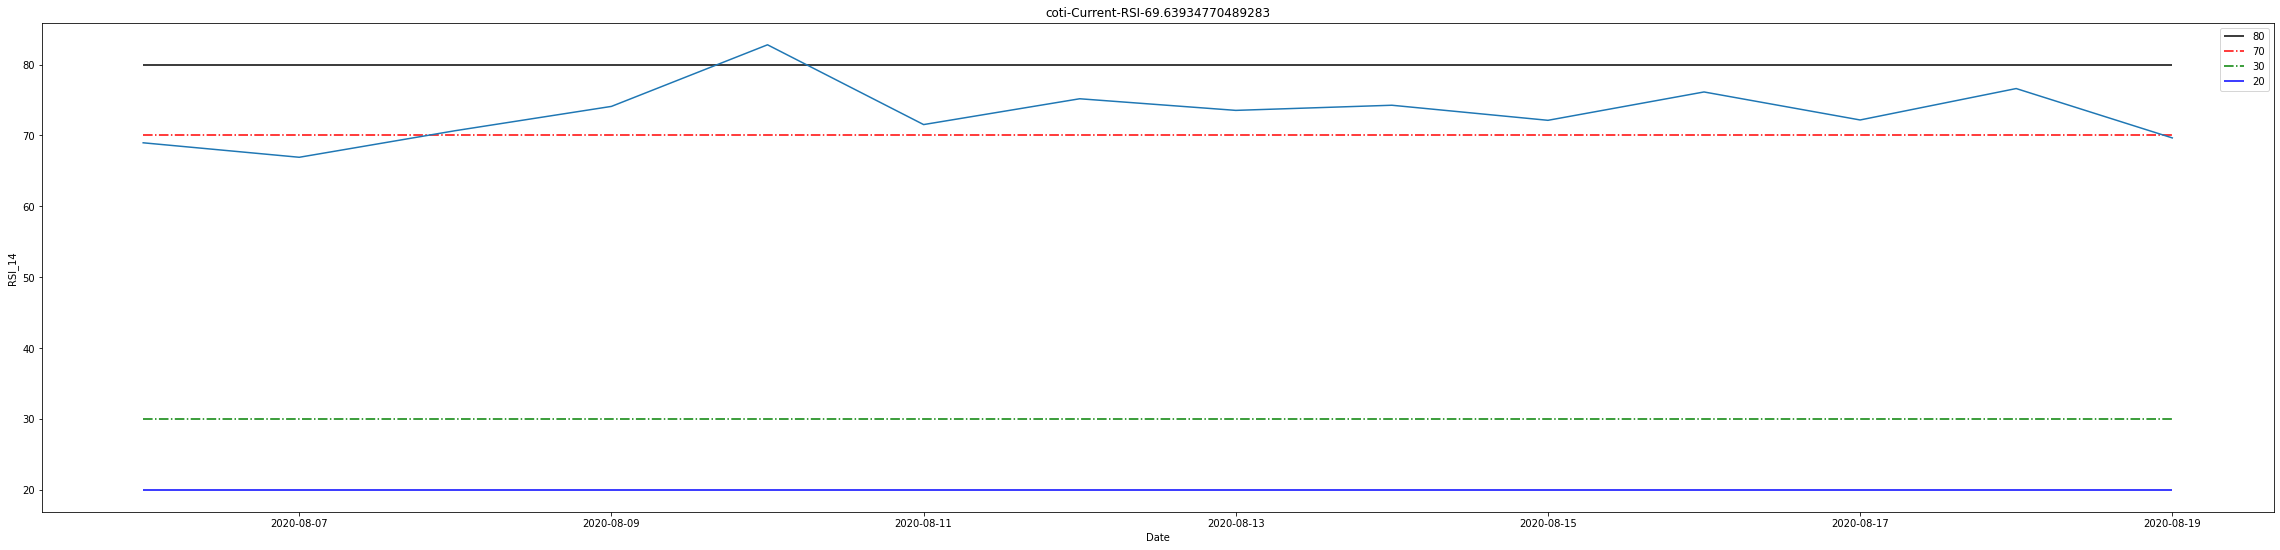

Plotting RSI (36.10865347068511) for:  trueflip


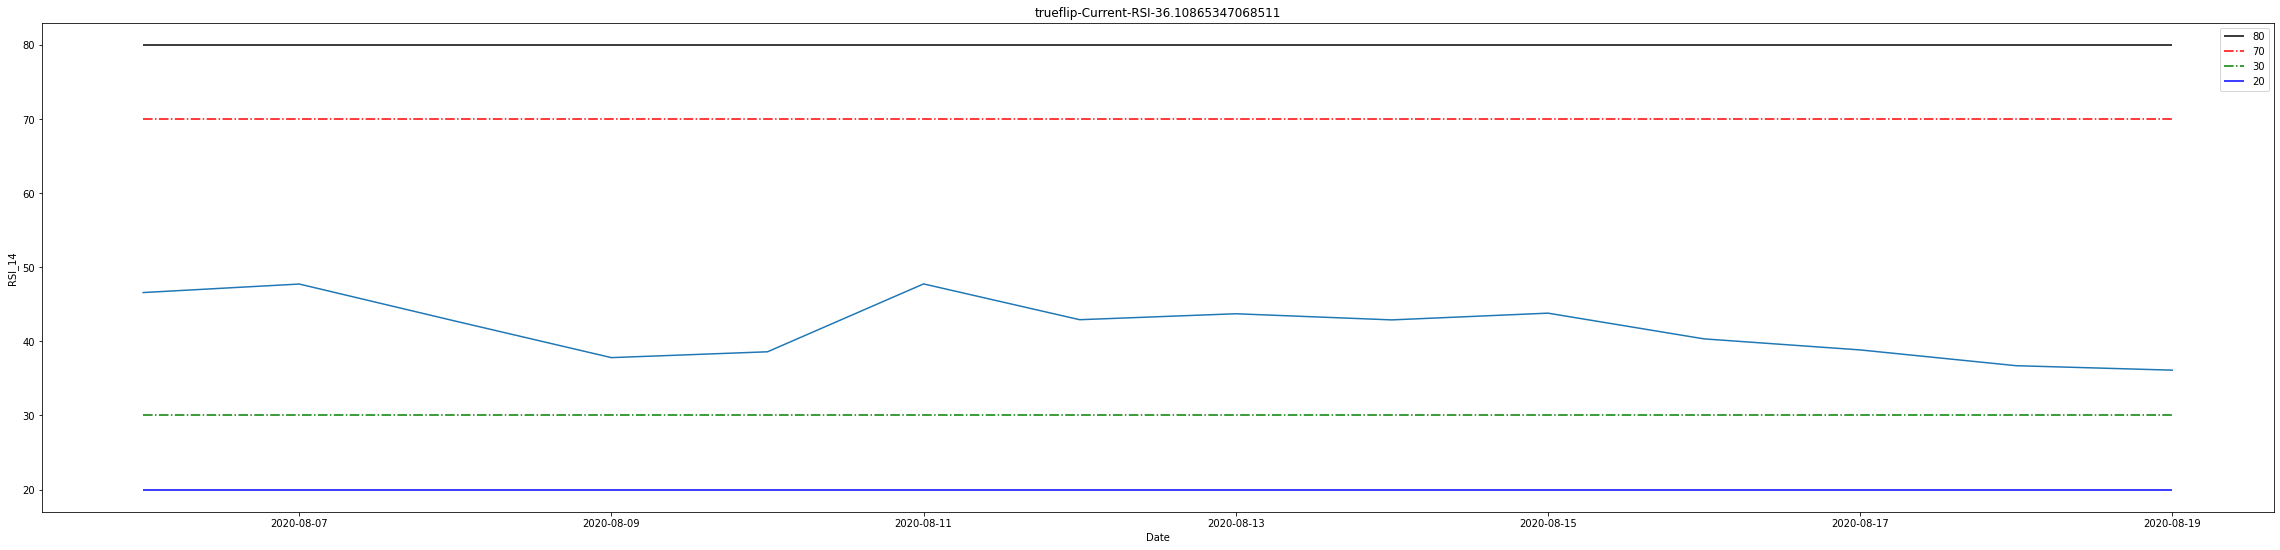

Plotting RSI (56.85749765426461) for:  matrix-ai-network


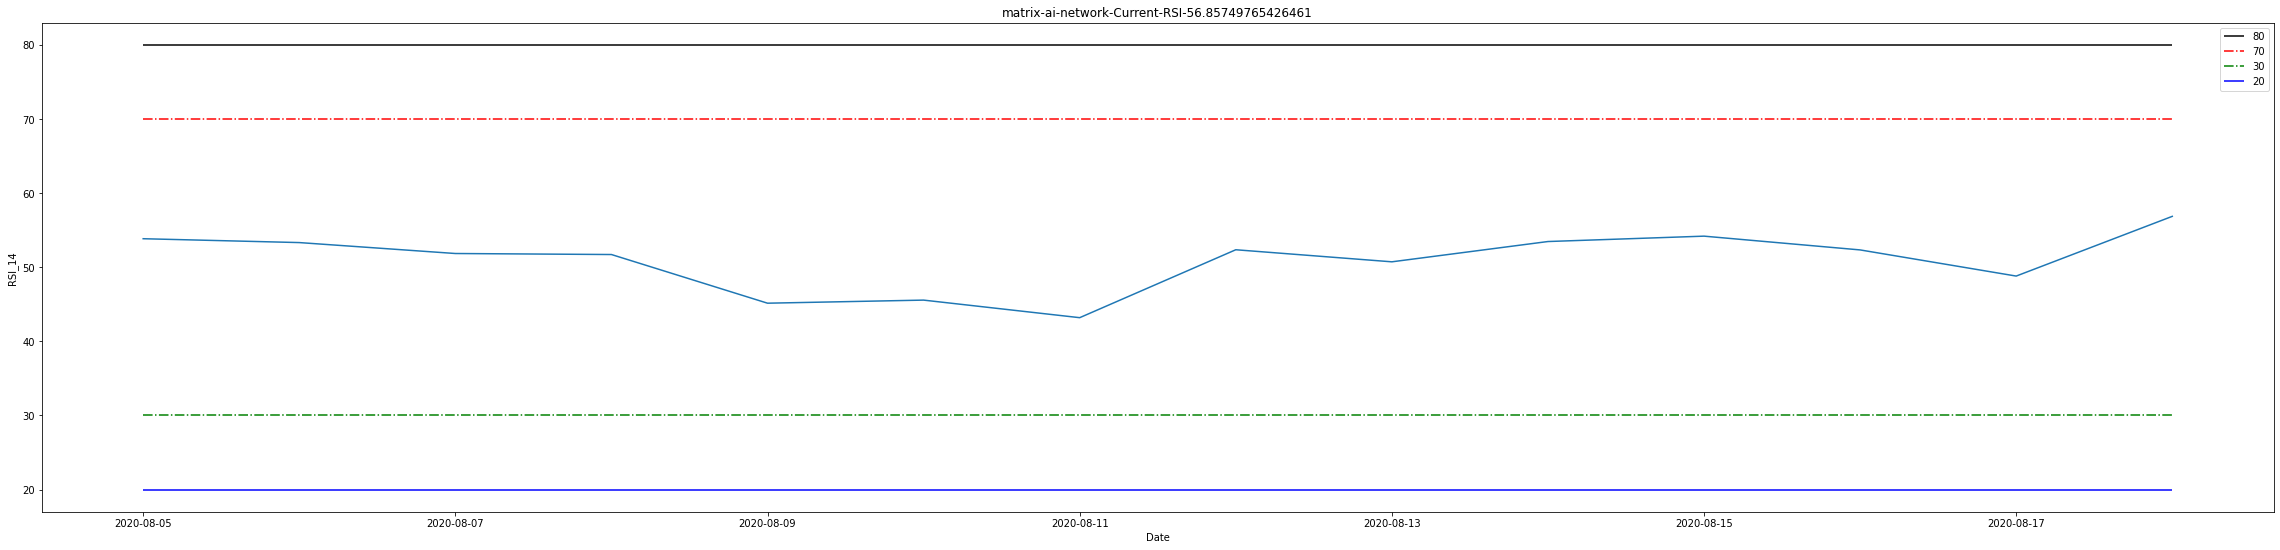

Plotting RSI (53.68031311939427) for:  deepbrain-chain


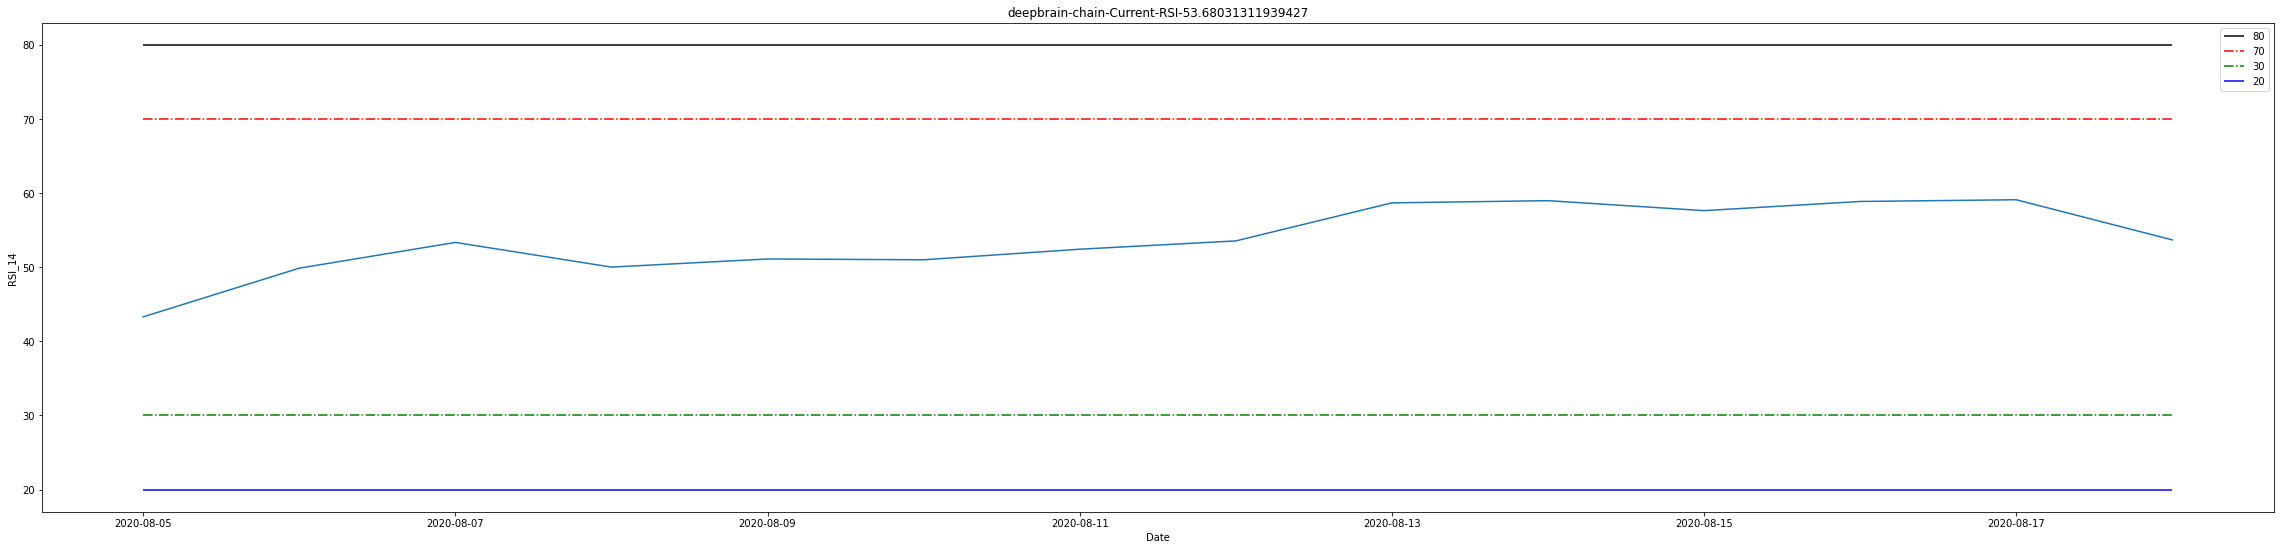

Plotting RSI (72.08924259137169) for:  nem


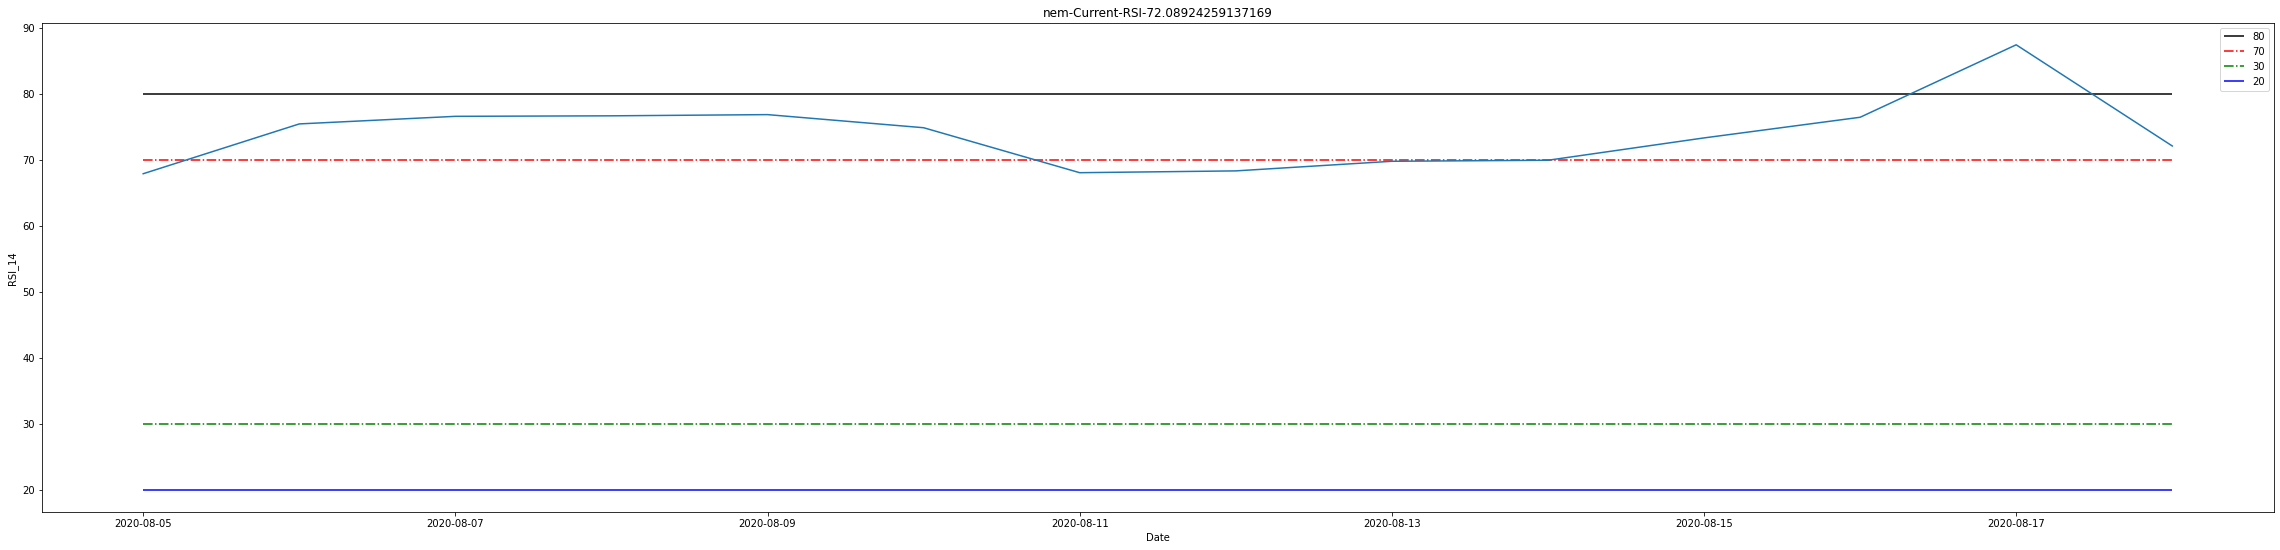

Plotting RSI (58.826809190316666) for:  solve


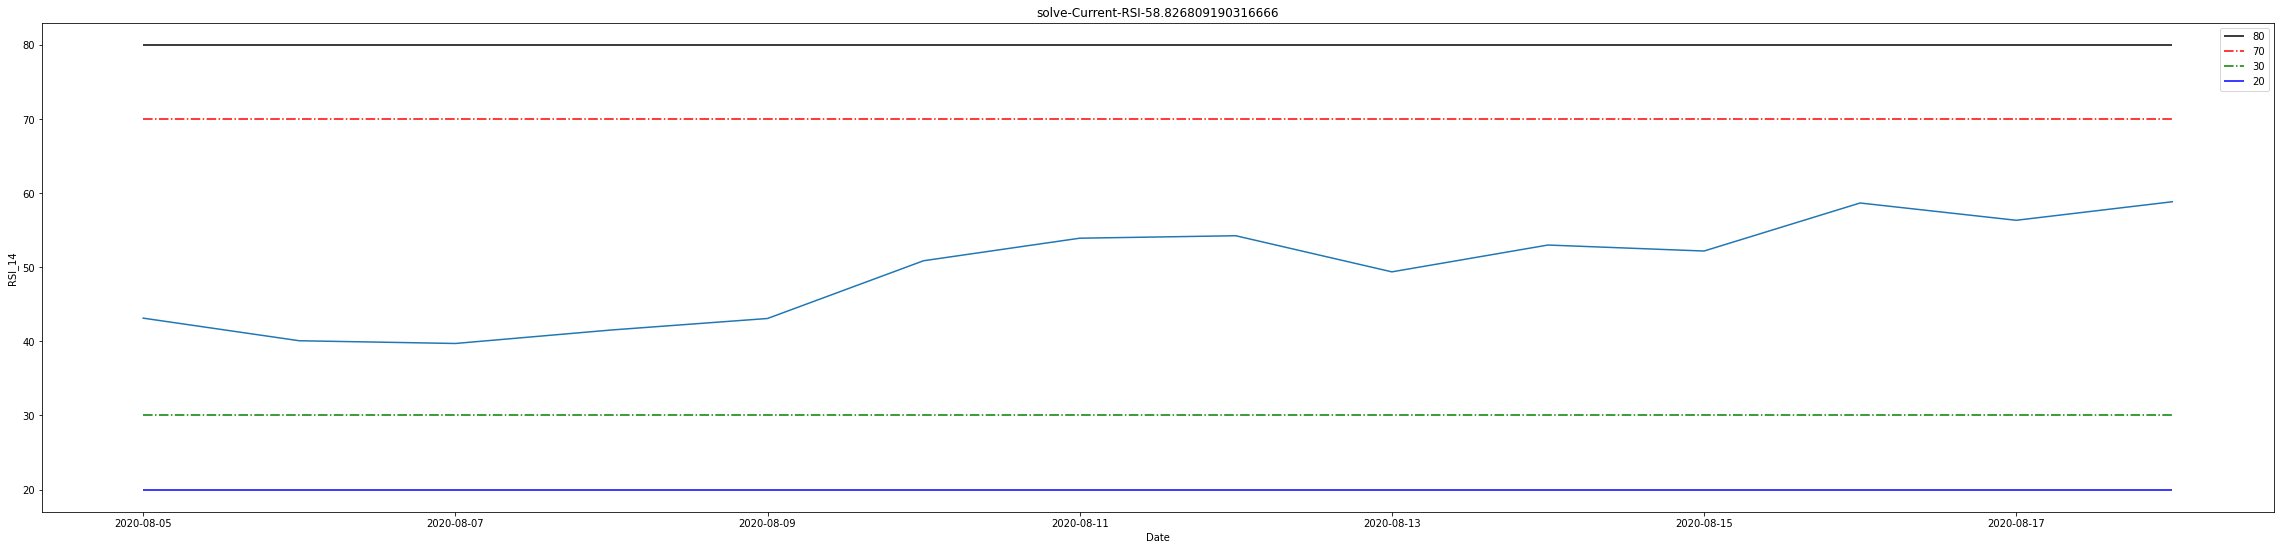

Plotting RSI (67.5148084657404) for:  aion


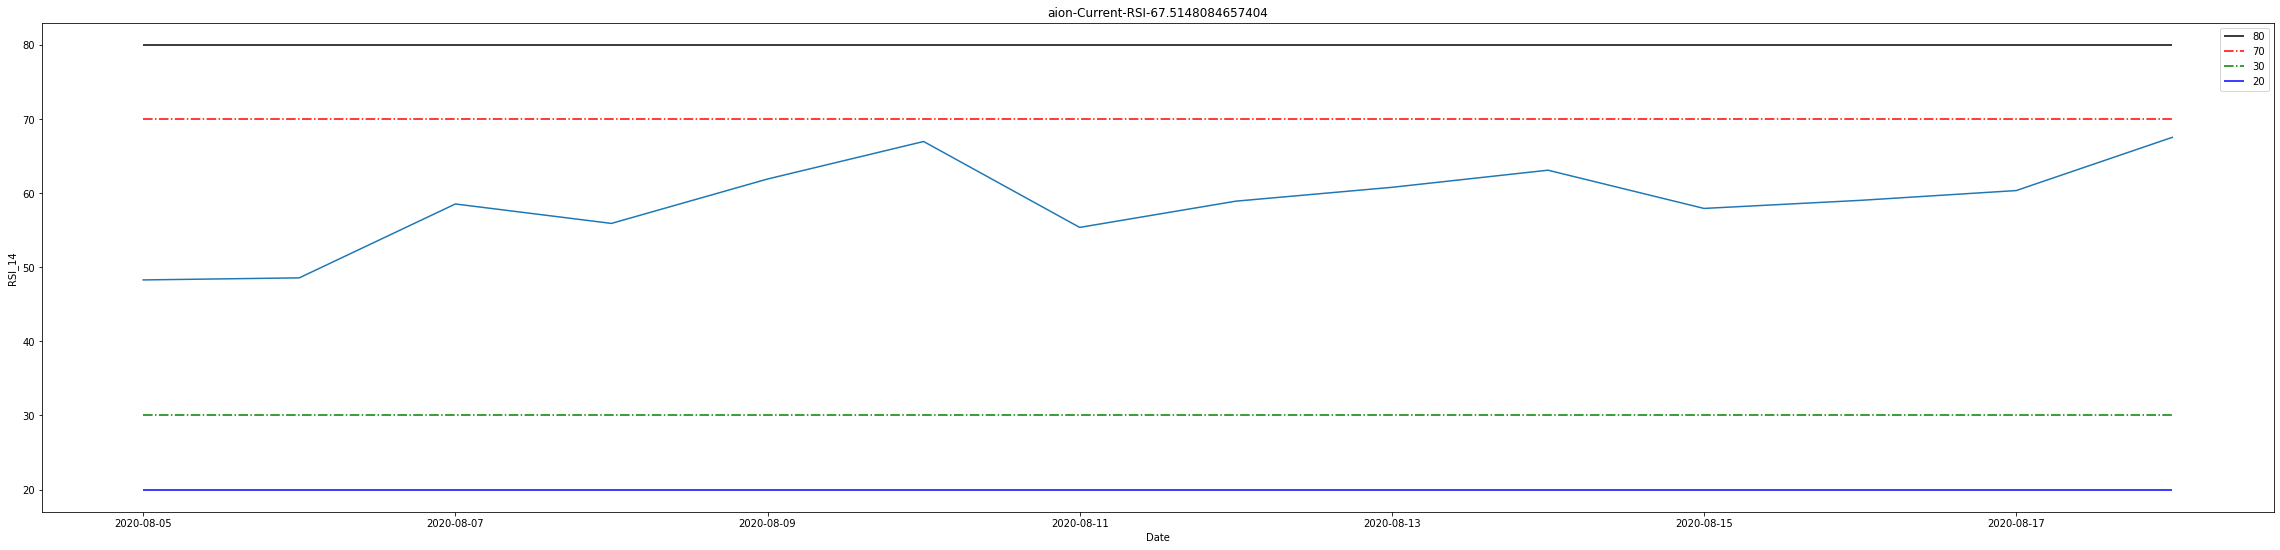

Plotting RSI (43.39573970201933) for:  cardano


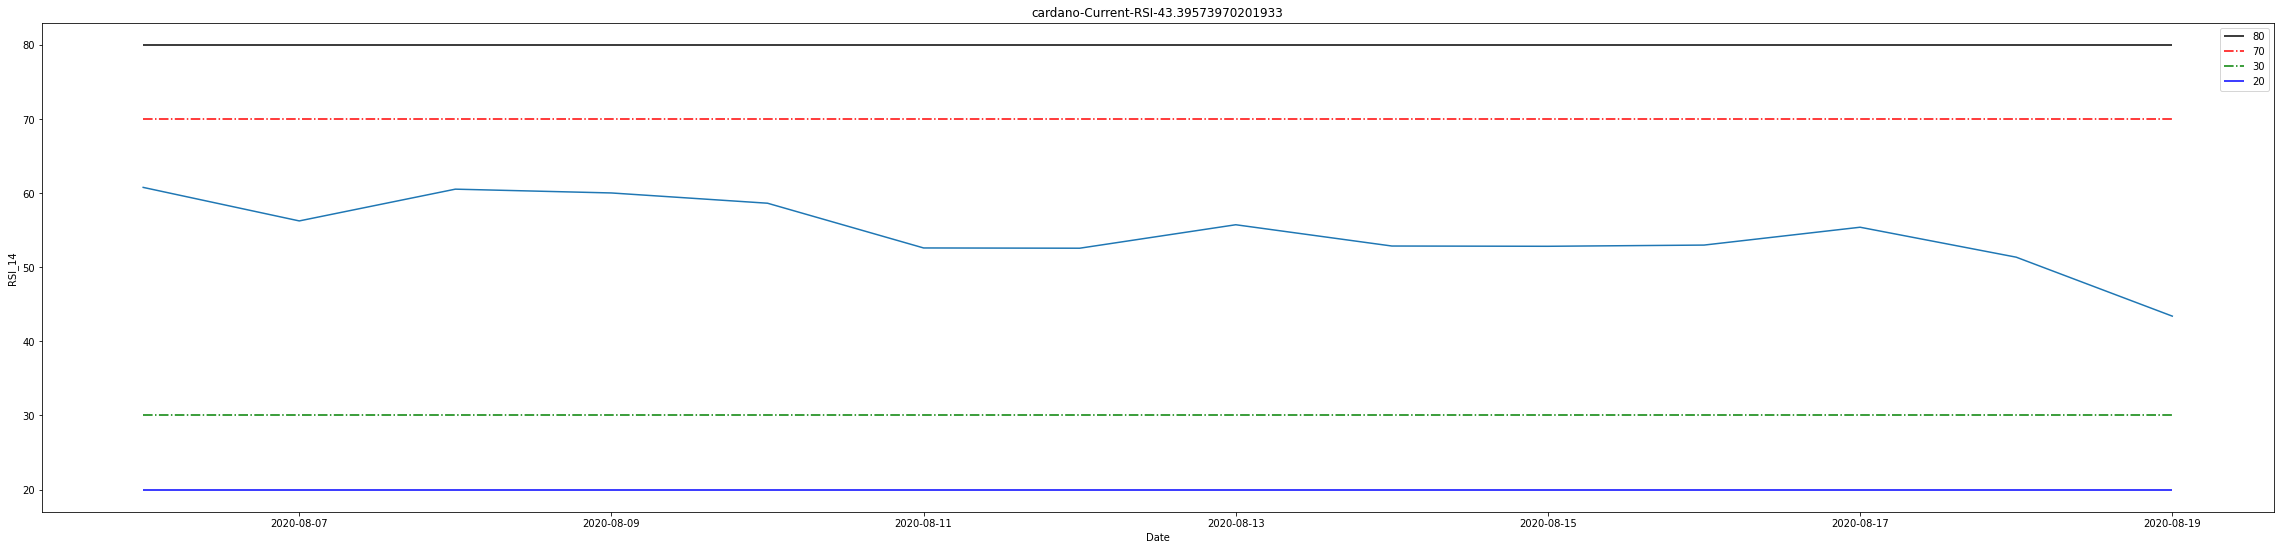

Plotting RSI (55.731620462317025) for:  binance-coin


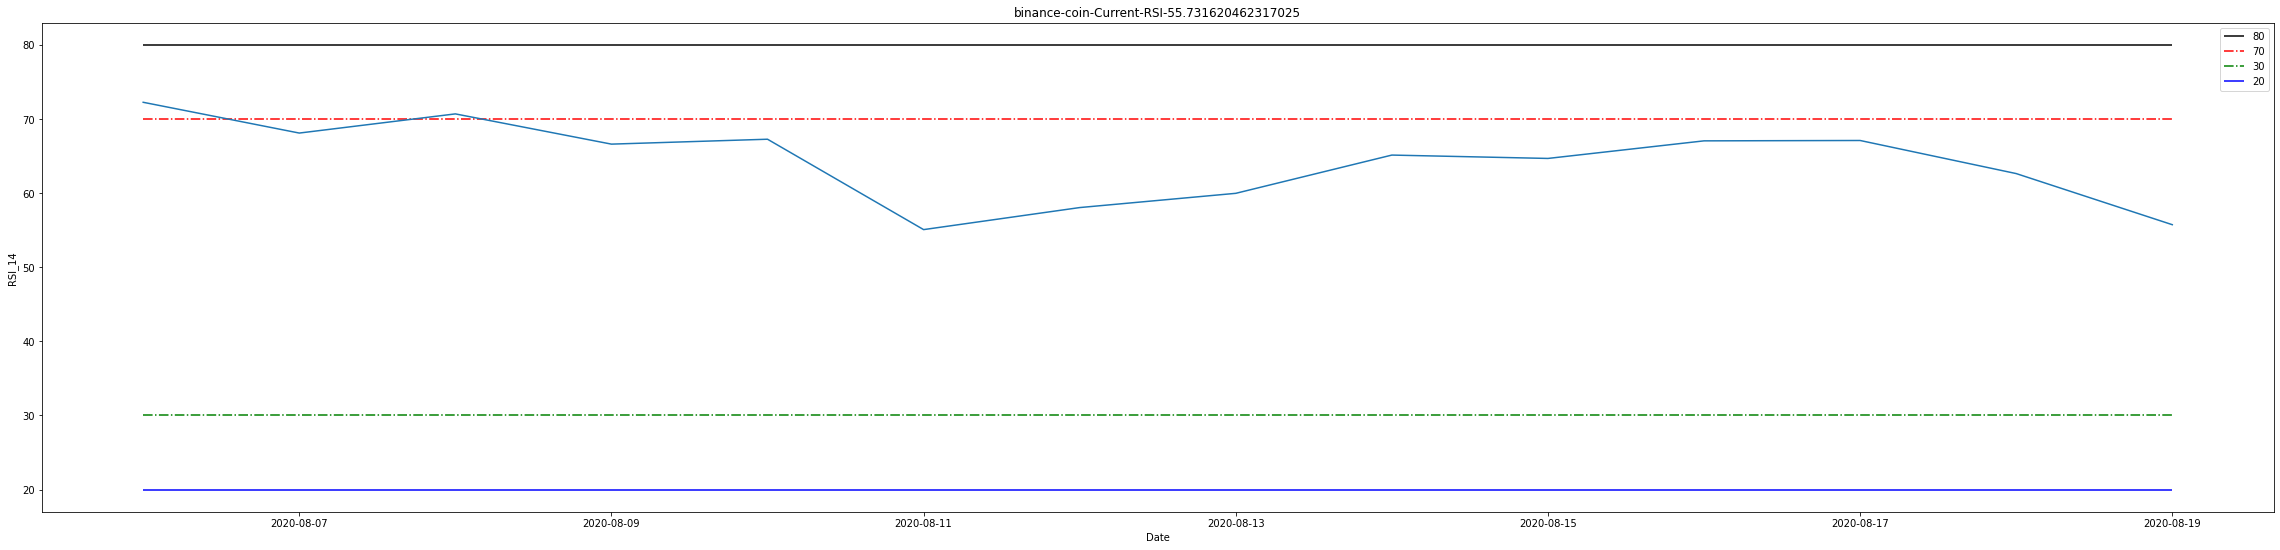

Plotting RSI (74.80320966287724) for:  kardiachain


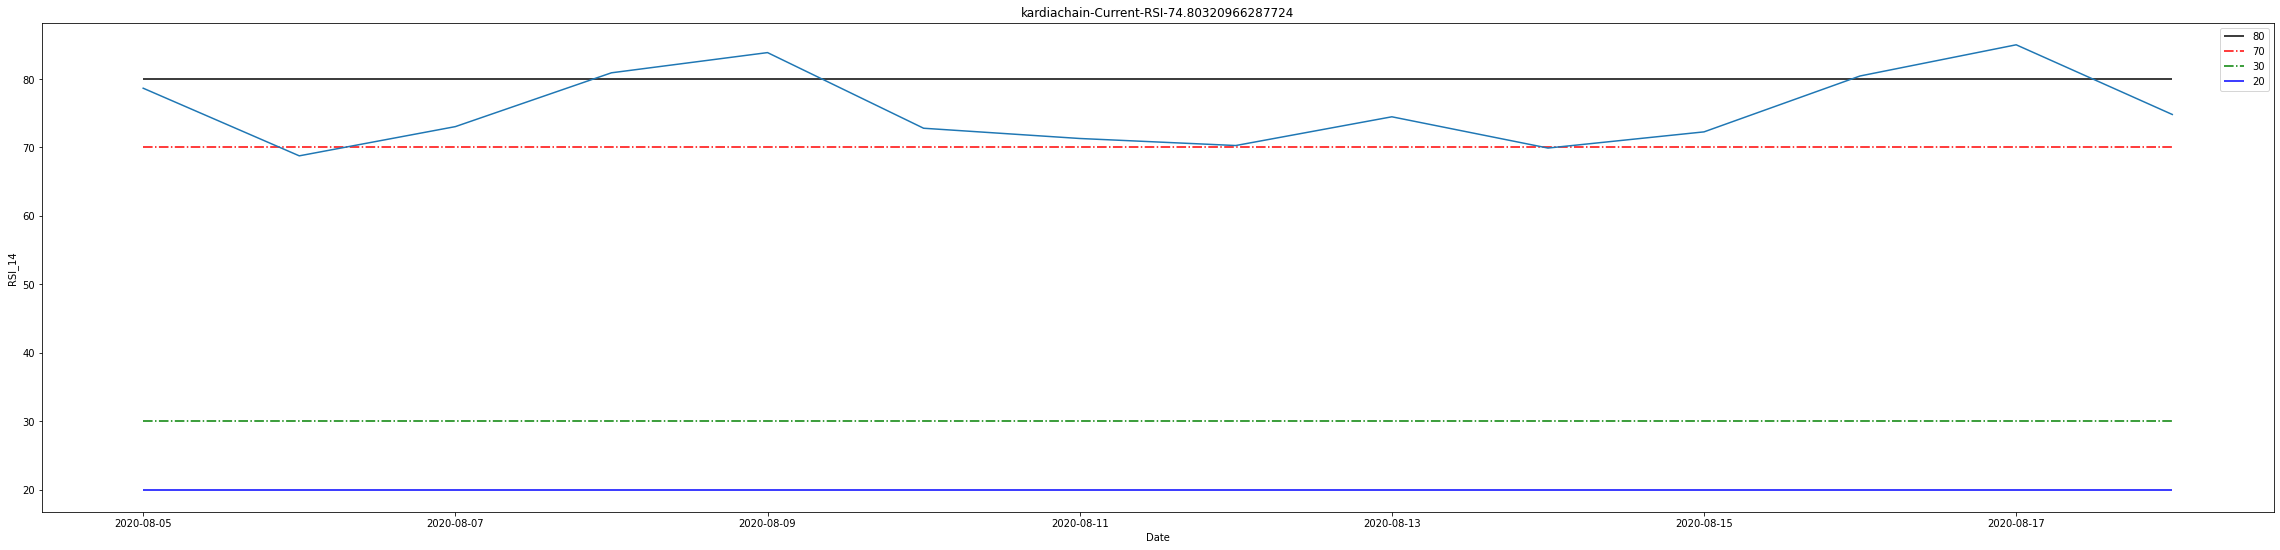

Plotting RSI (50.218618977721086) for:  orion-protocol


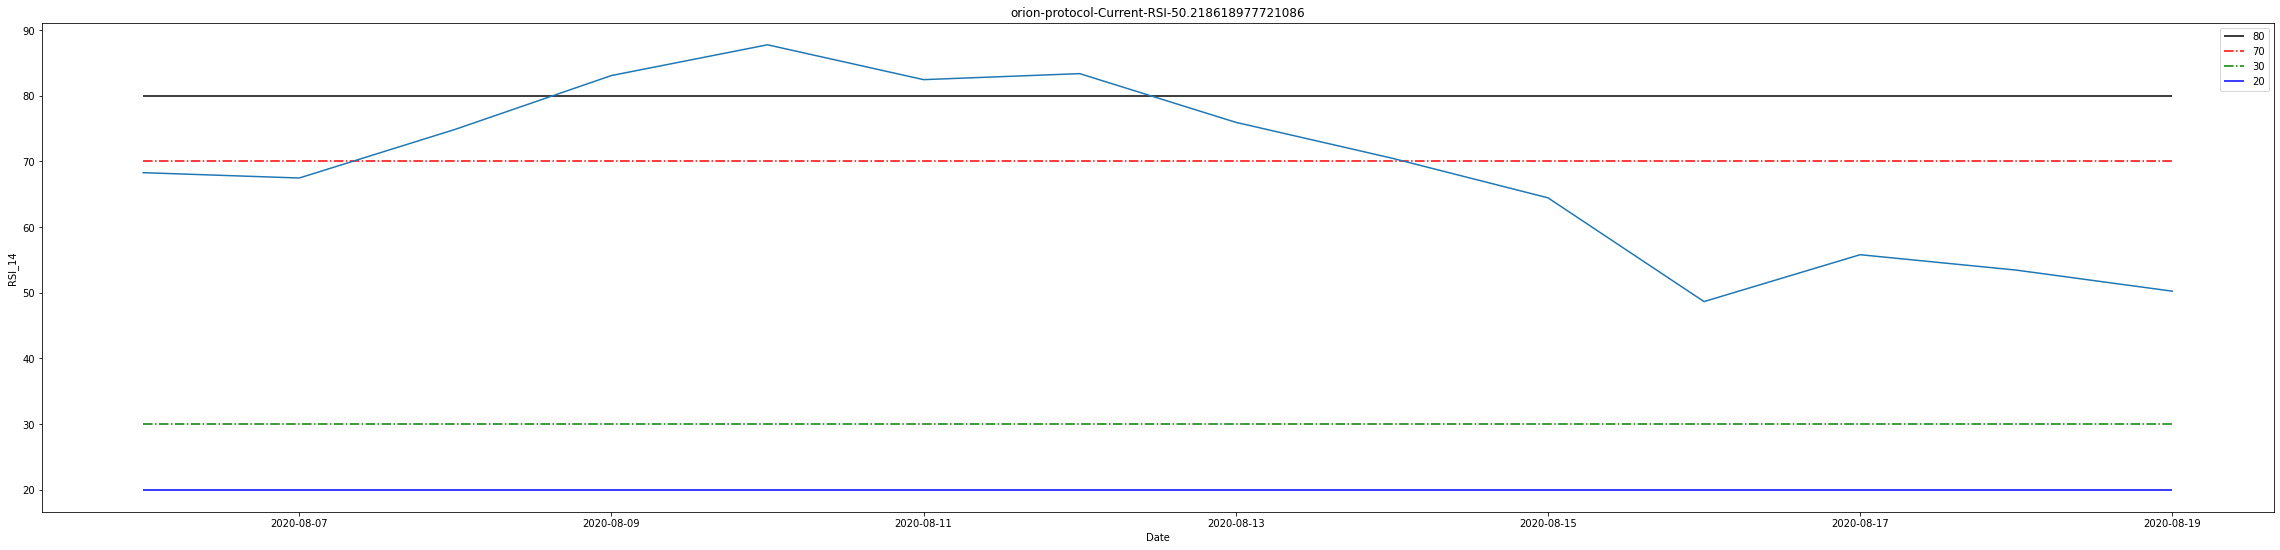

Plotting RSI (61.260285102346856) for:  arpa-chain


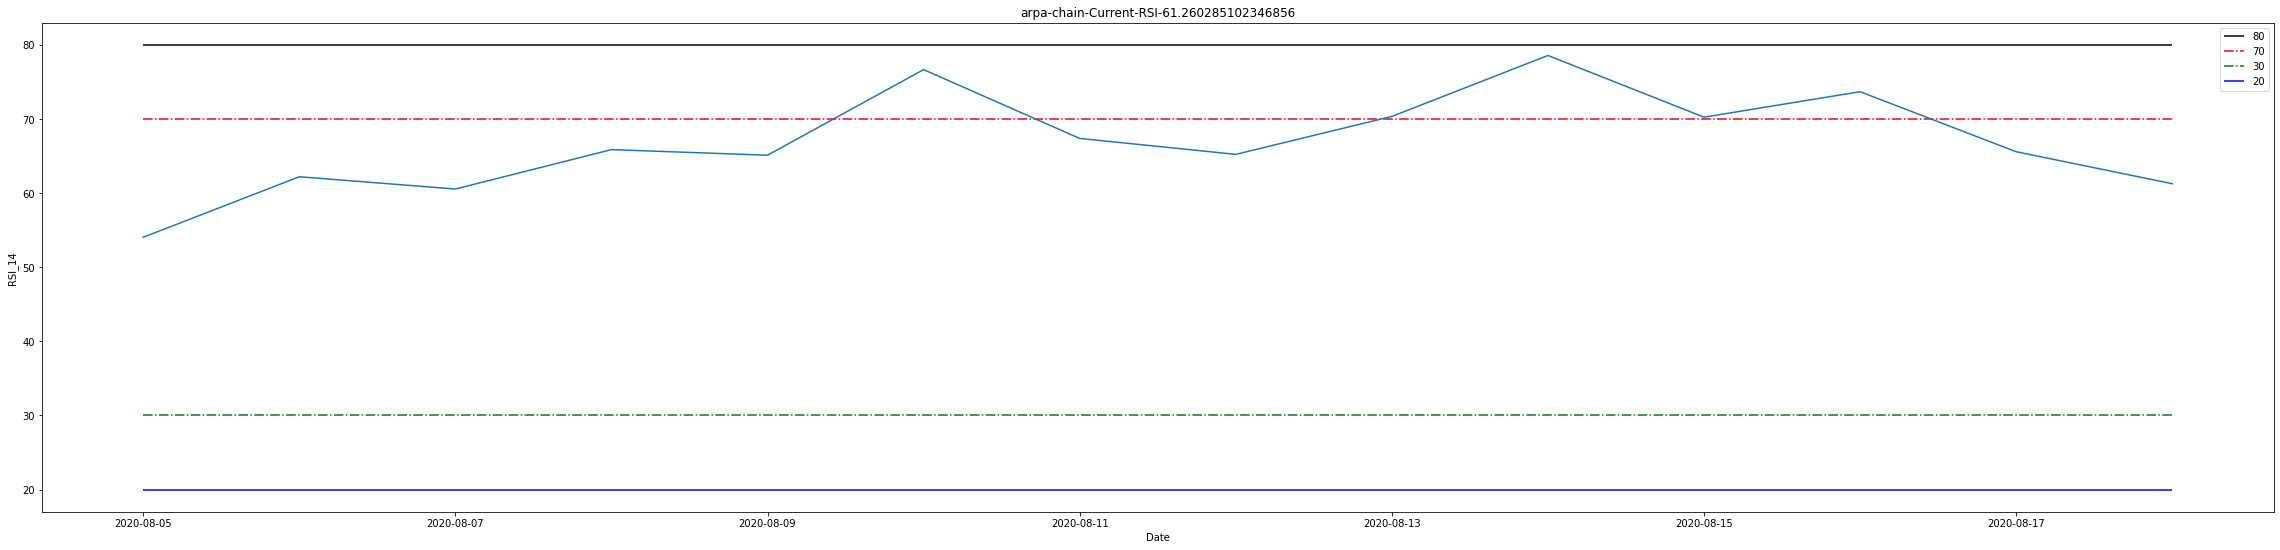

Plotting RSI (nan) for:  milk-alliance


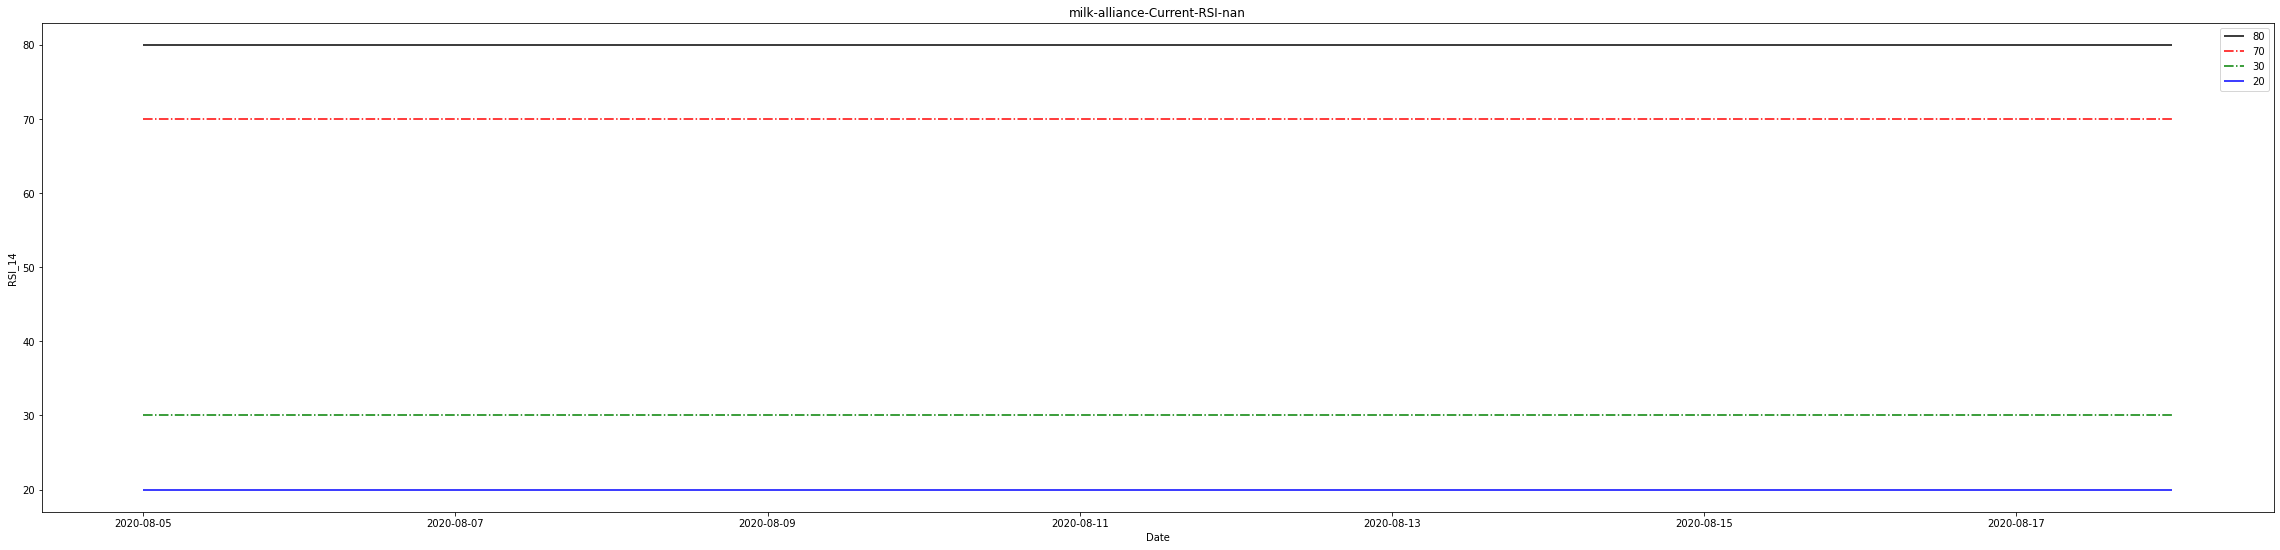

Plotting RSI (41.02296492770676) for:  videocoin


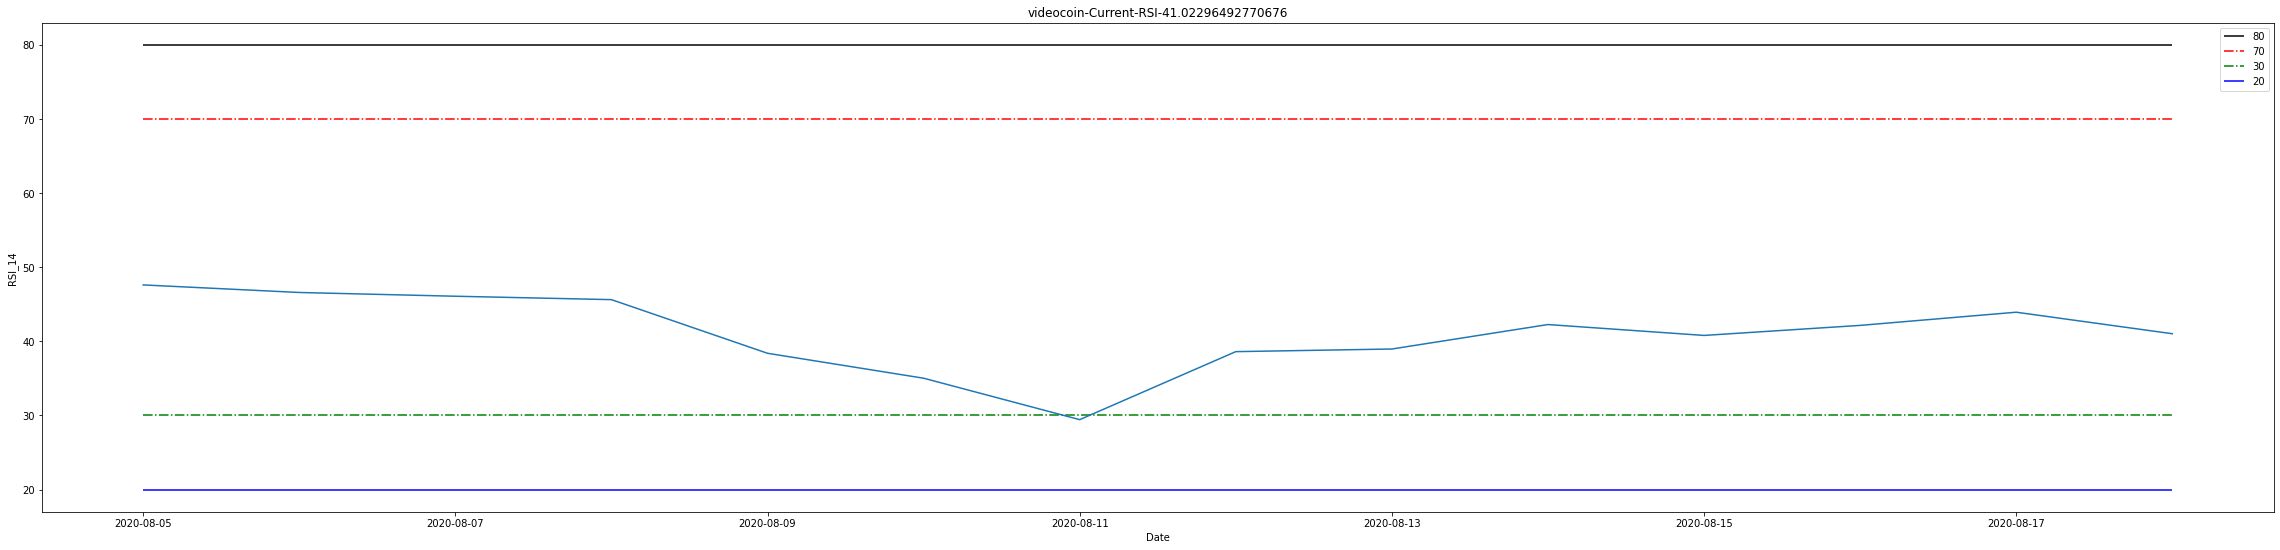

Plotting RSI (61.563659187882216) for:  gas


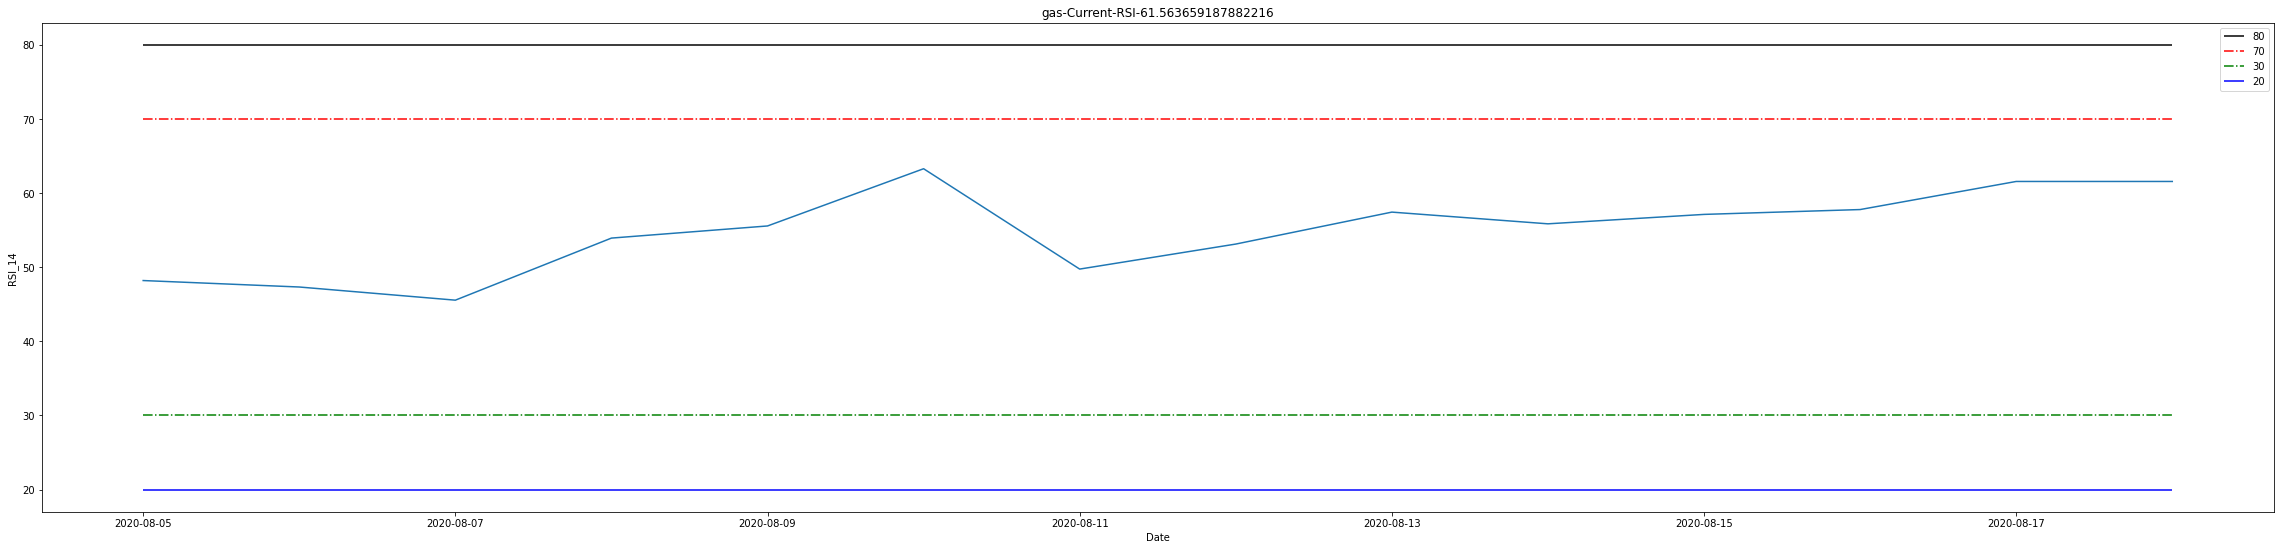

Plotting RSI (58.94296013133839) for:  wink-tronbet


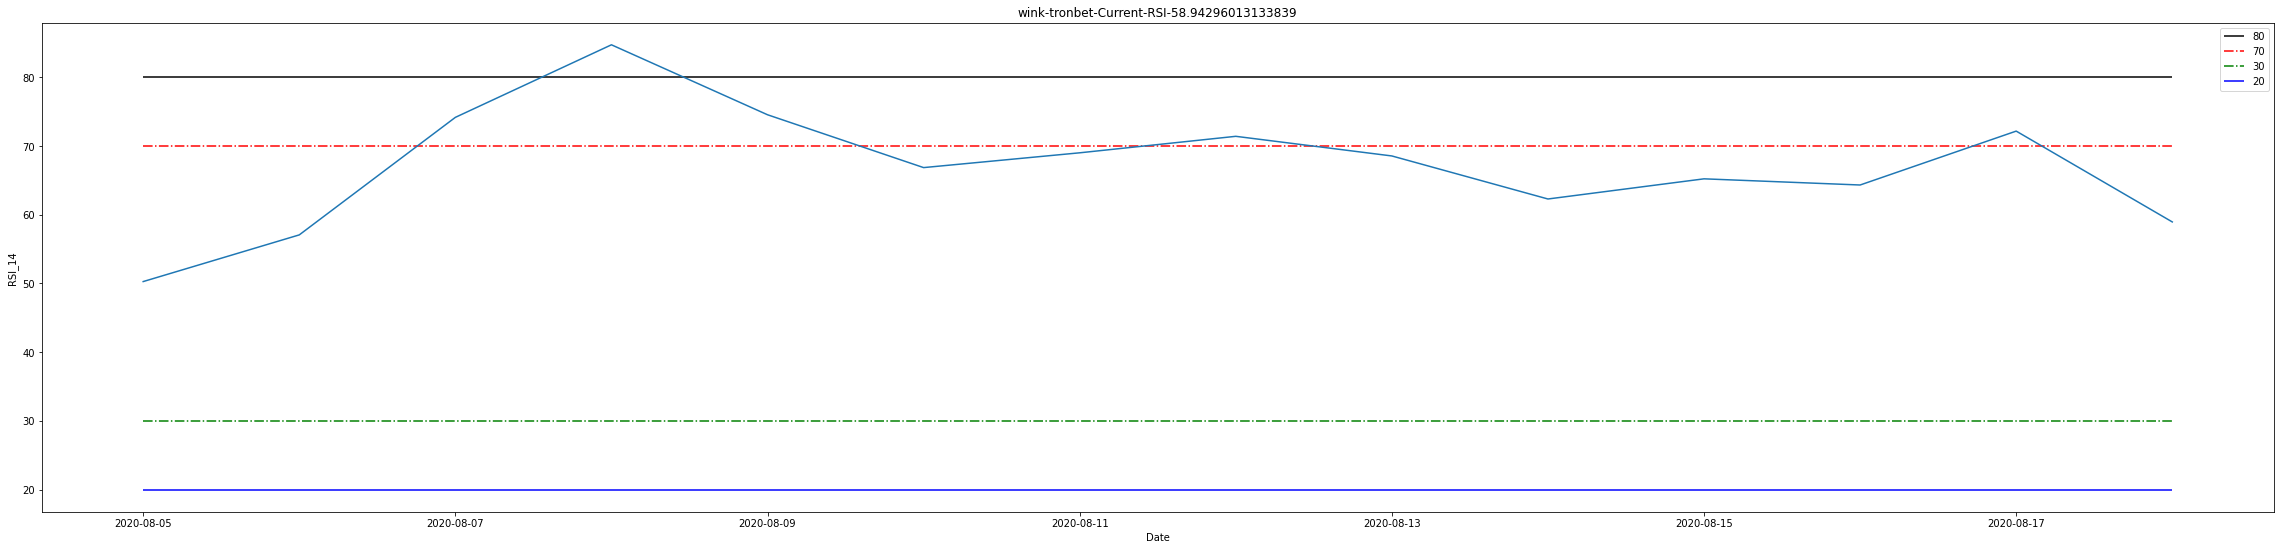

Plotting RSI (56.735049356349556) for:  covesting


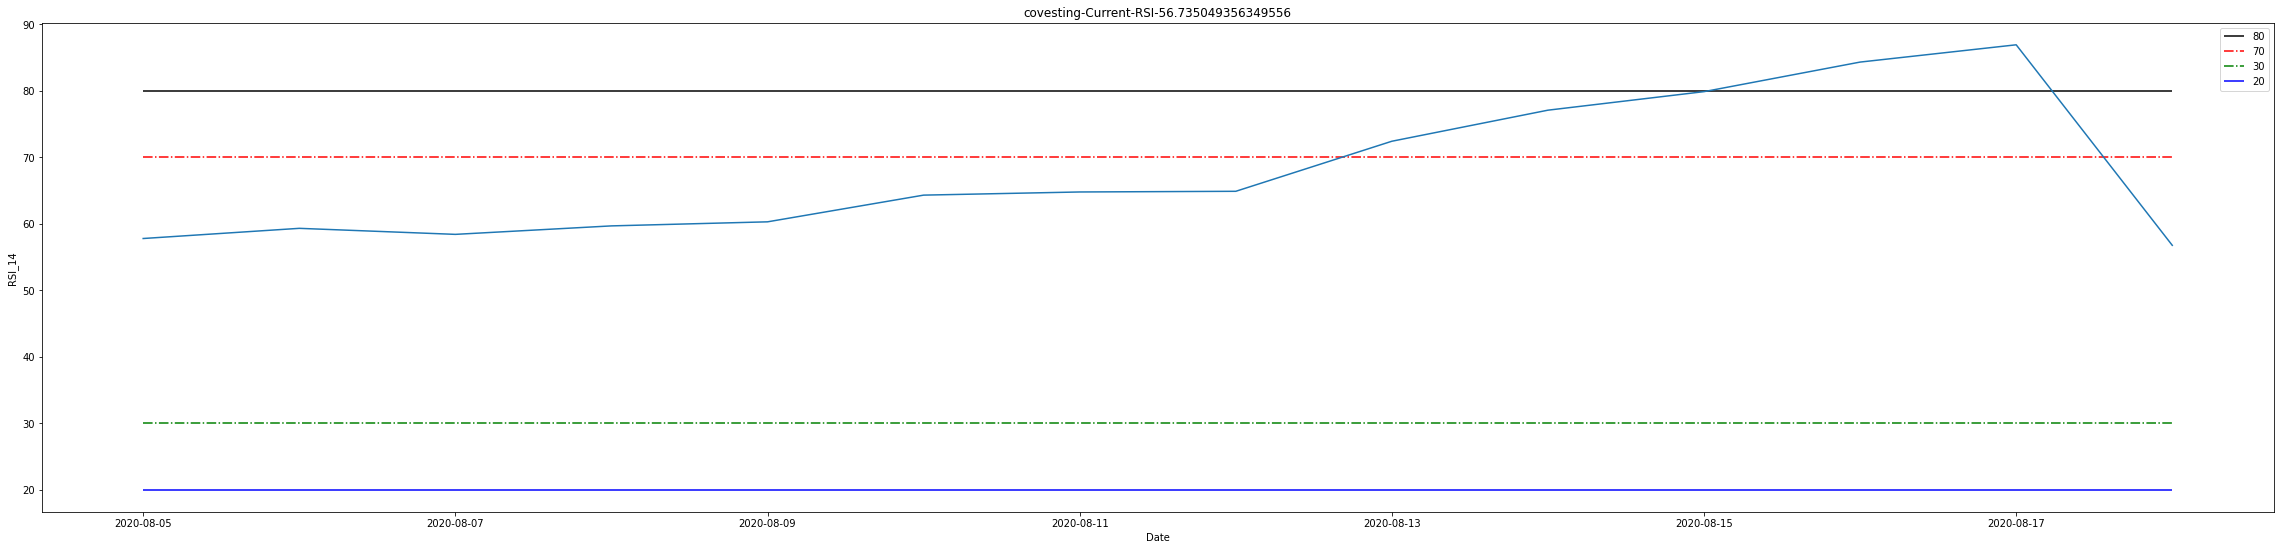

Plotting RSI (54.184384233817354) for:  chiliz


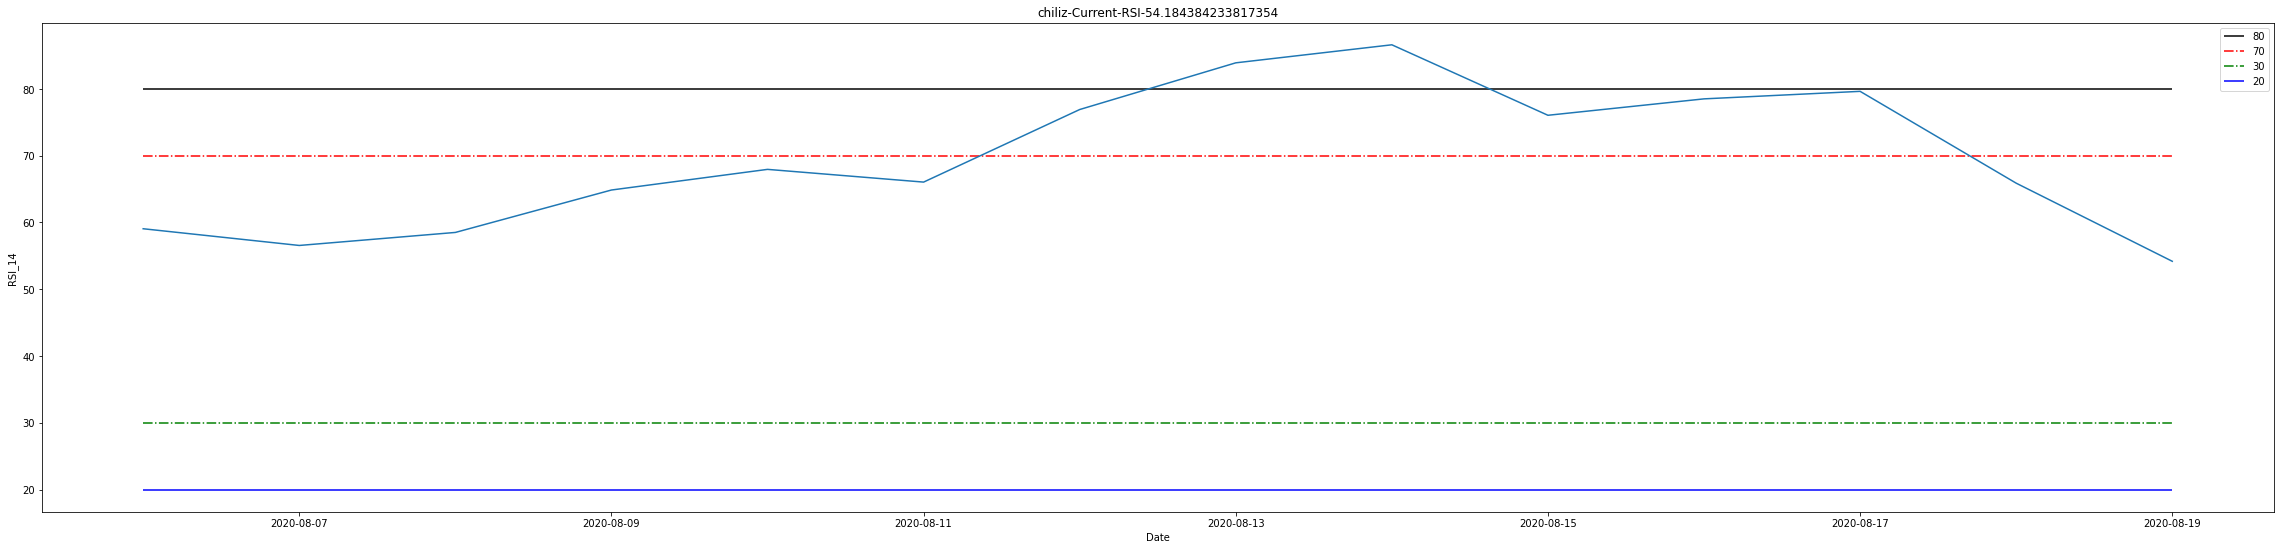

Plotting RSI (50.09790490239811) for:  telcoin


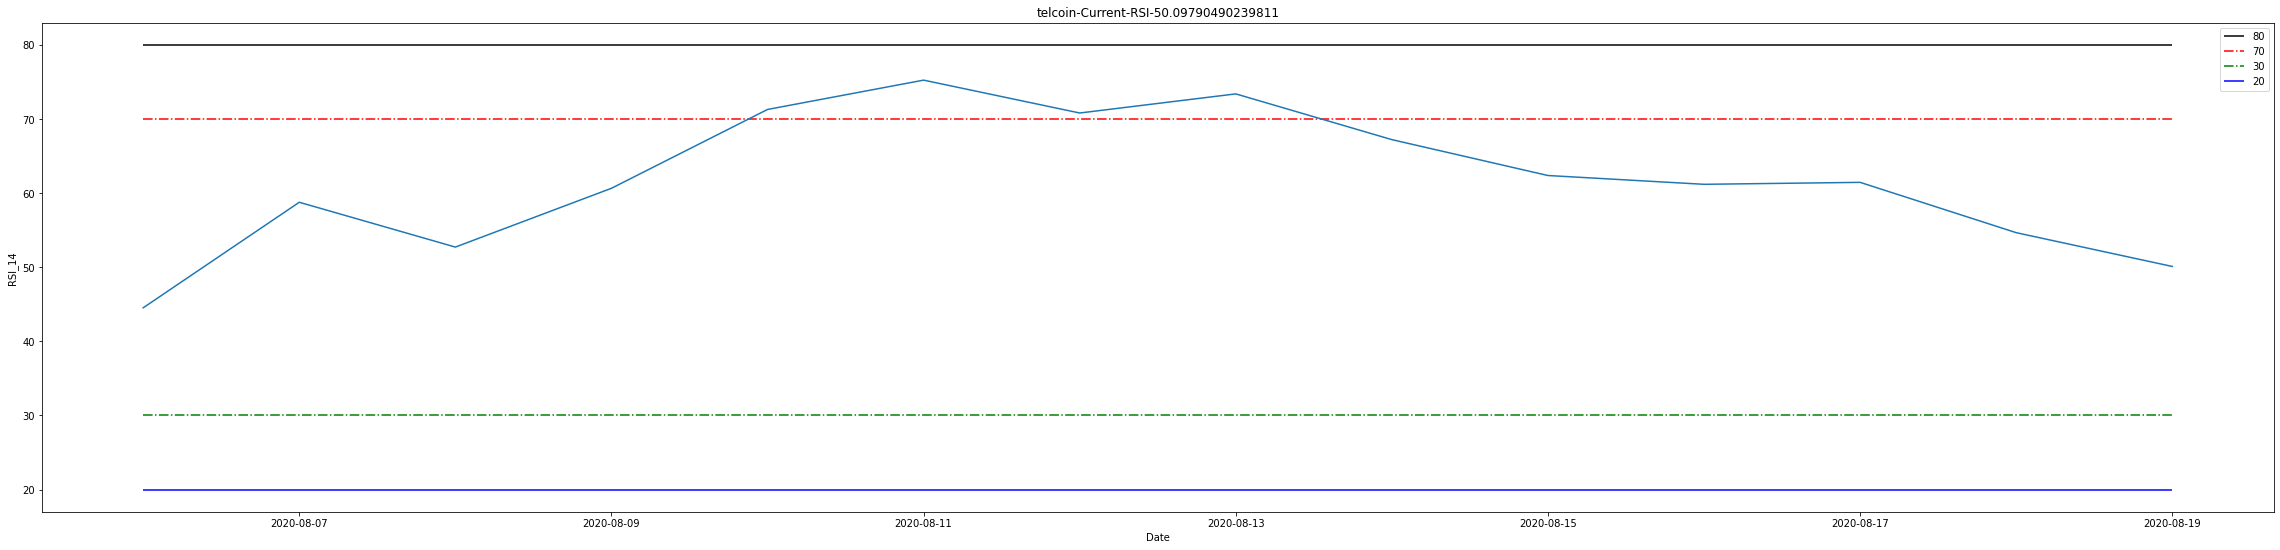

Plotting RSI (47.769460490073534) for:  paparazzi


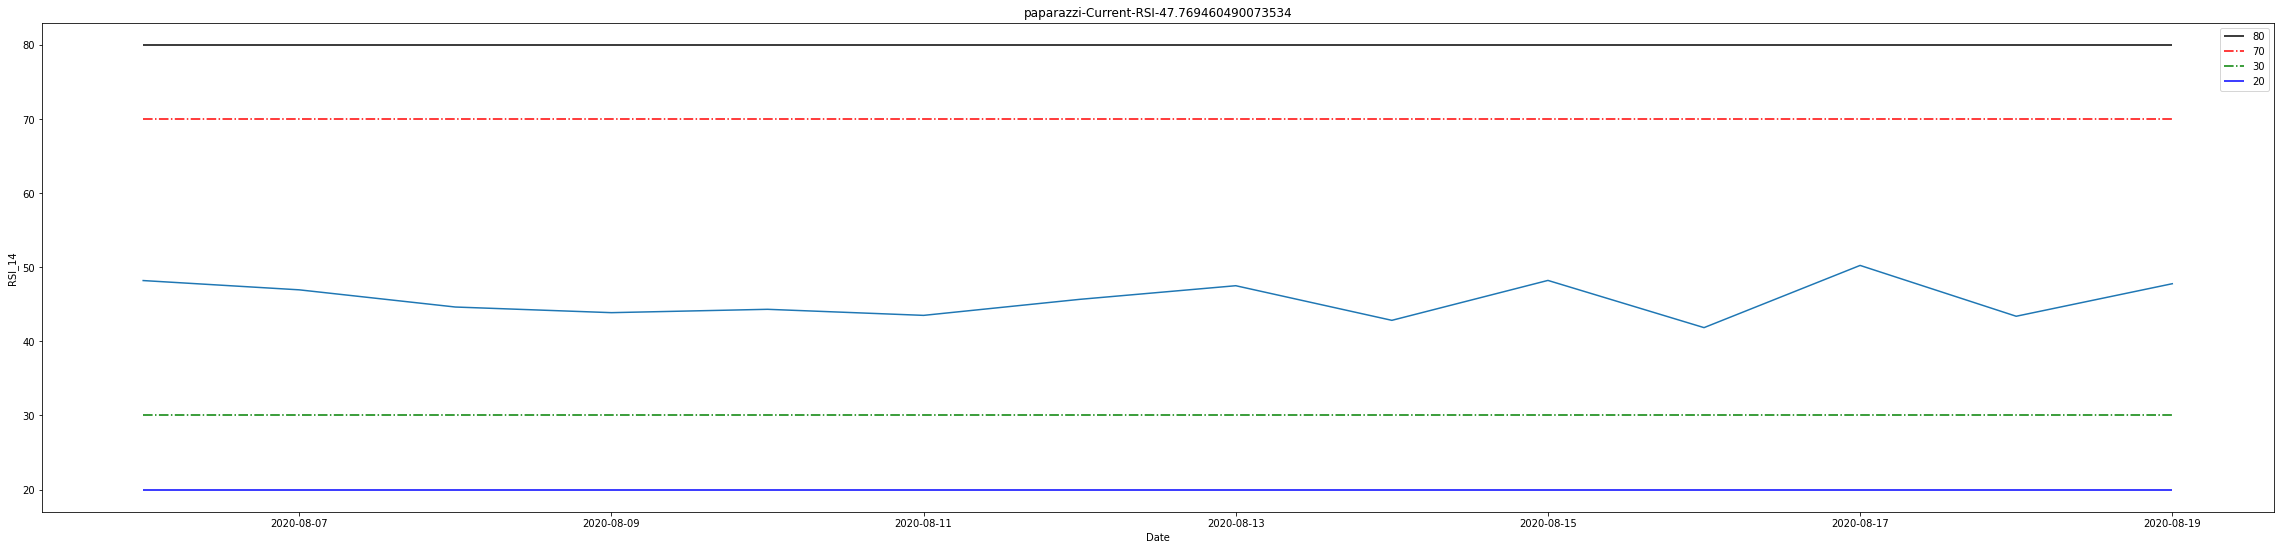

Plotting RSI (64.10378991362037) for:  bitcoin


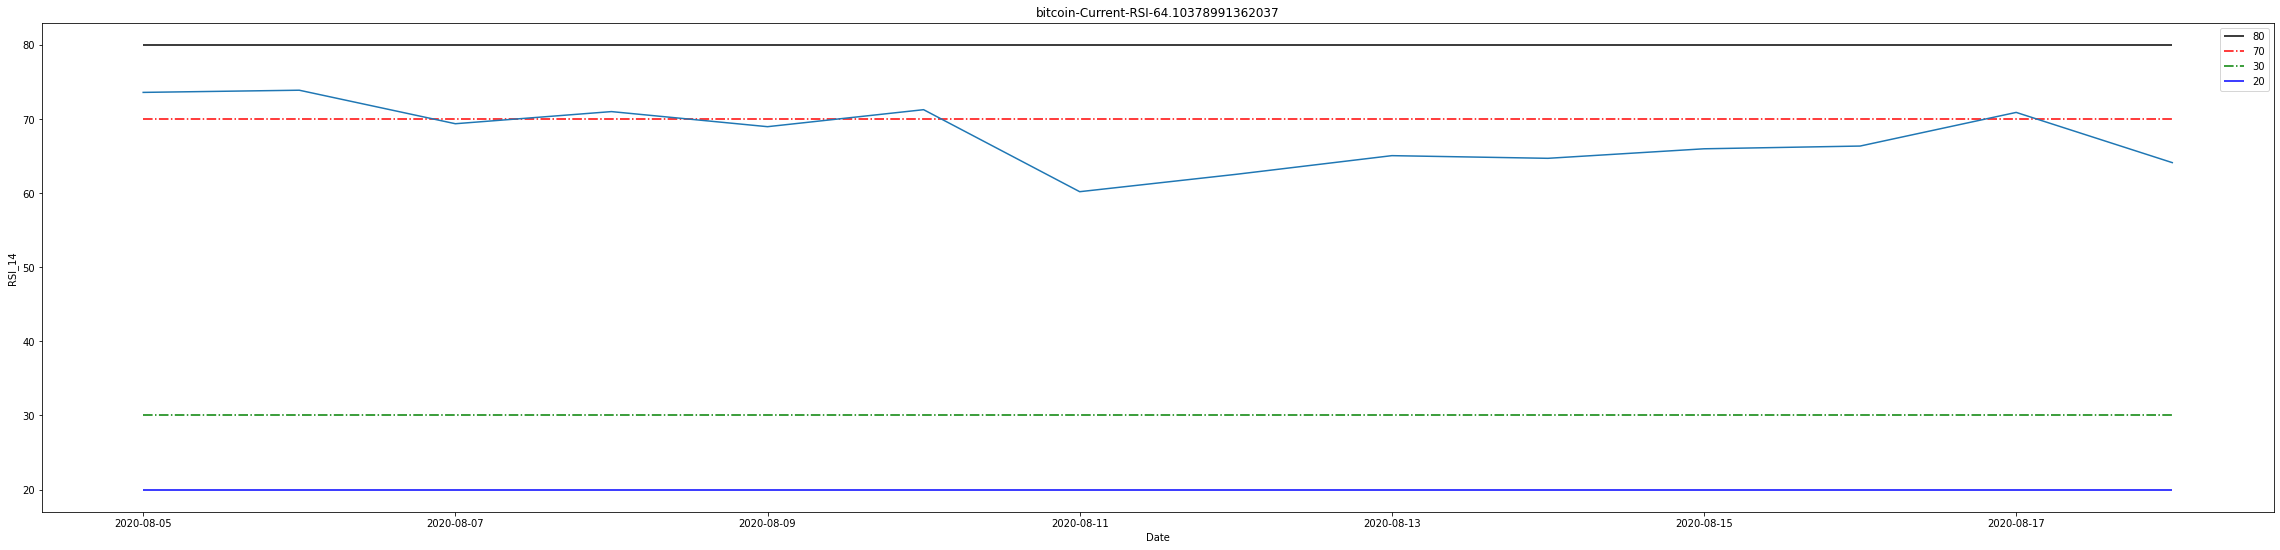

Plotting RSI (57.79297615590785) for:  susd


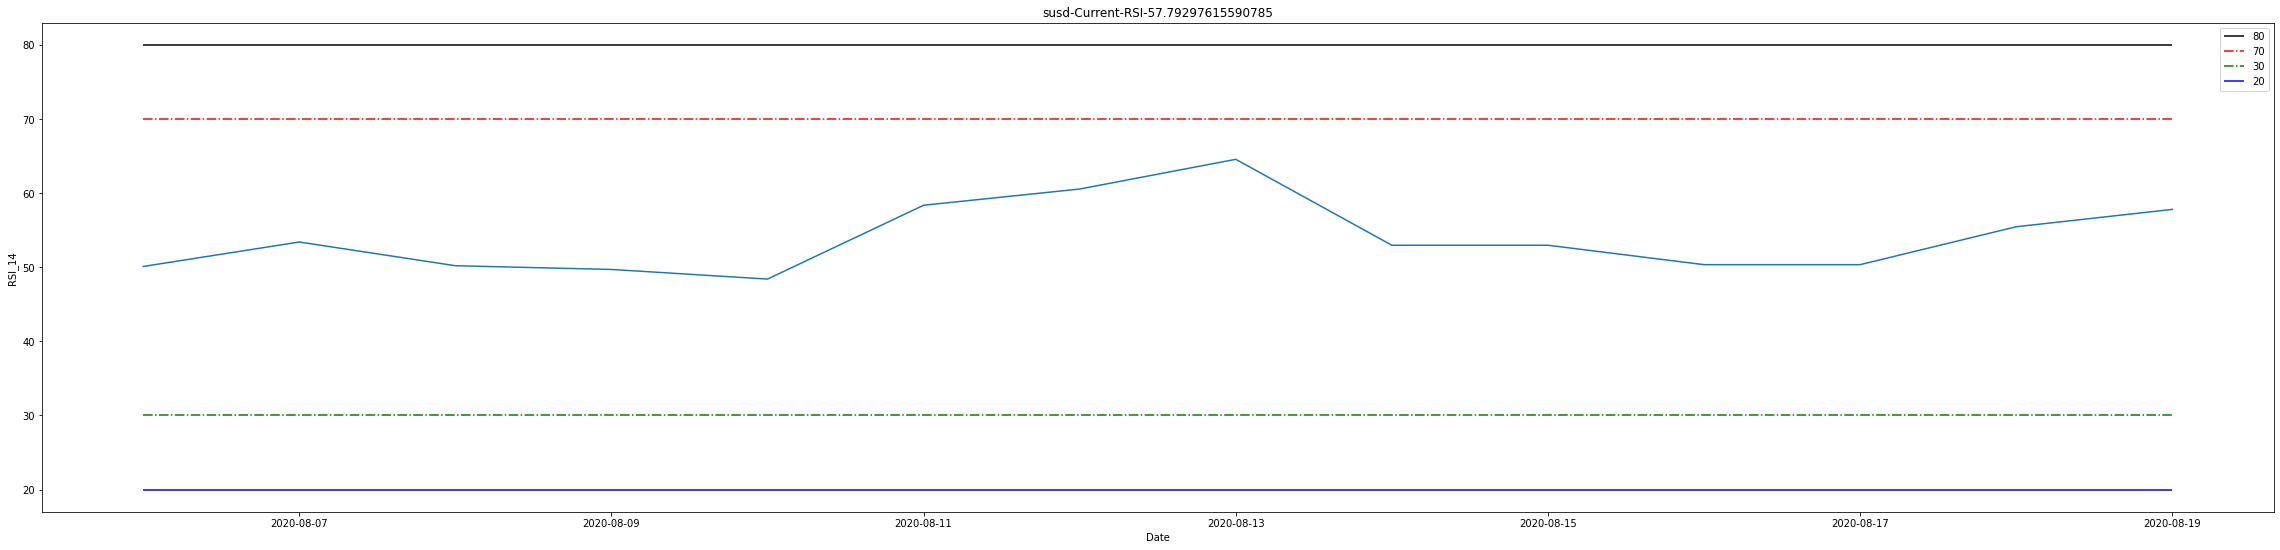

Plotting RSI (51.97566263685257) for:  metahash


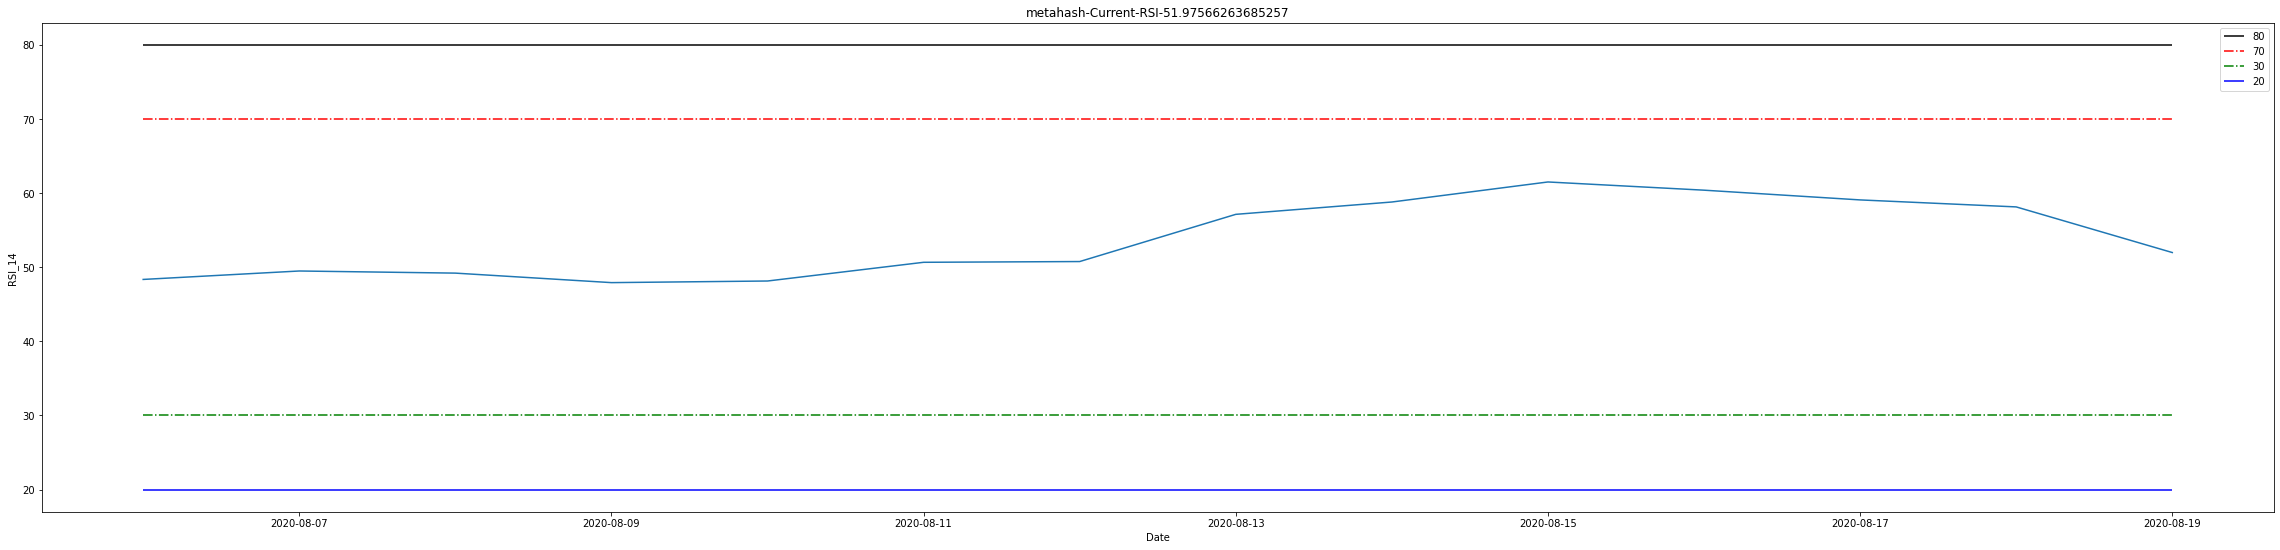

Plotting RSI (56.90203773076361) for:  zel


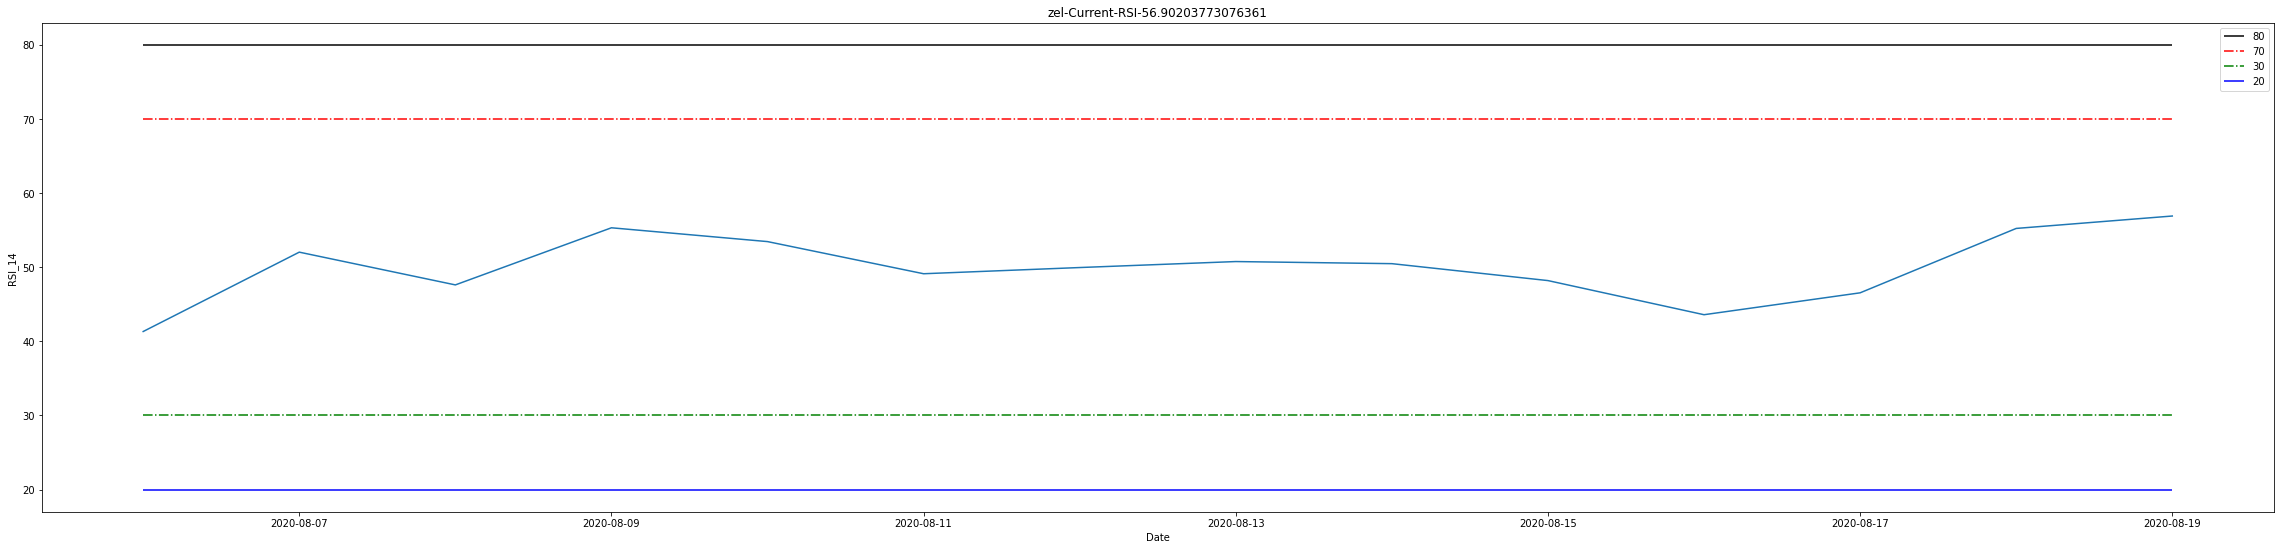

Plotting RSI (52.08190942159118) for:  bitcoin-sv


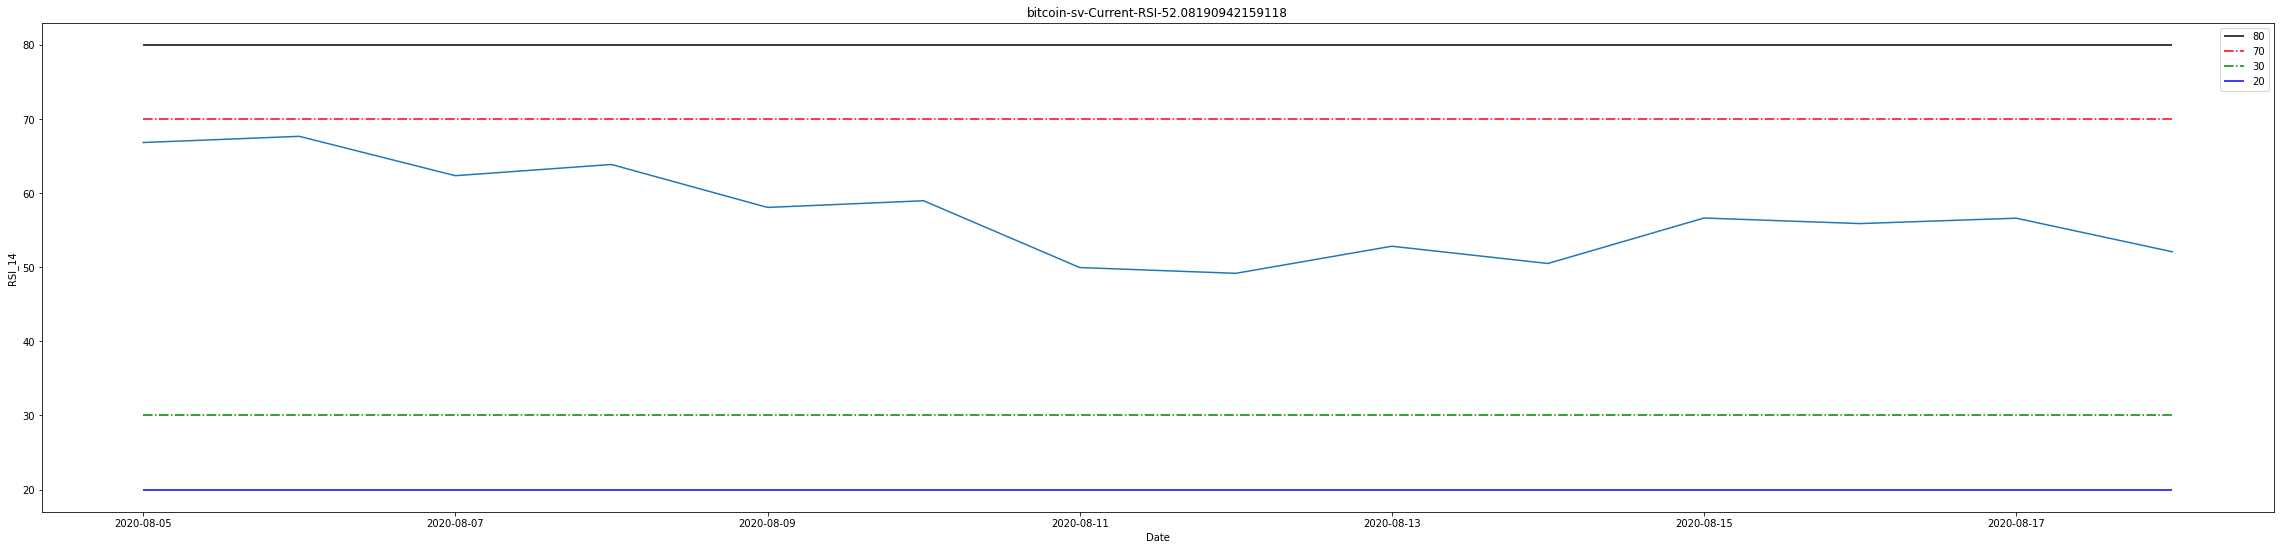

Plotting RSI (74.52093274793913) for:  dacc


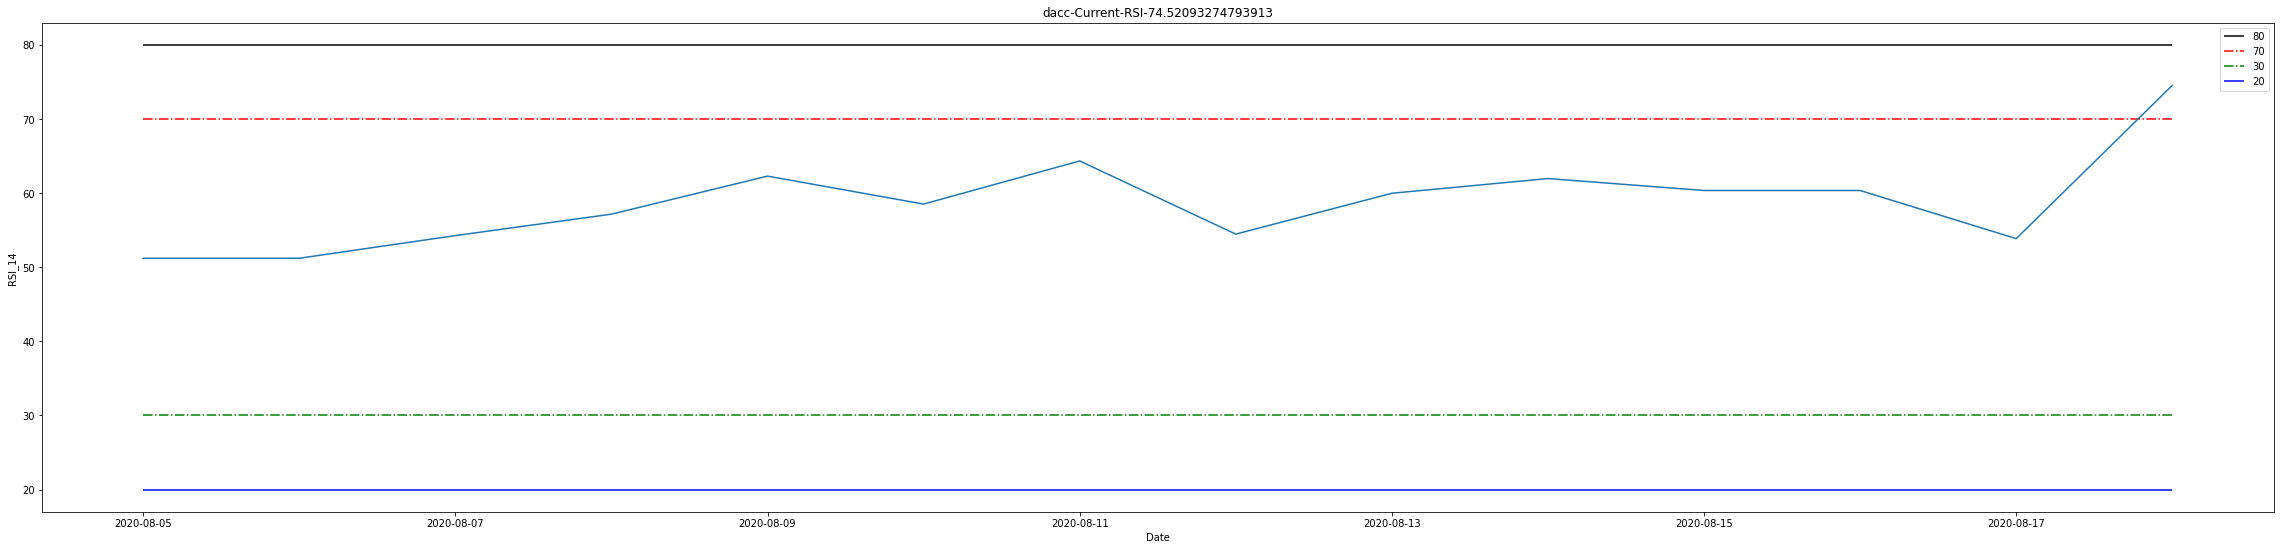

Plotting RSI (65.54427661956105) for:  swipe


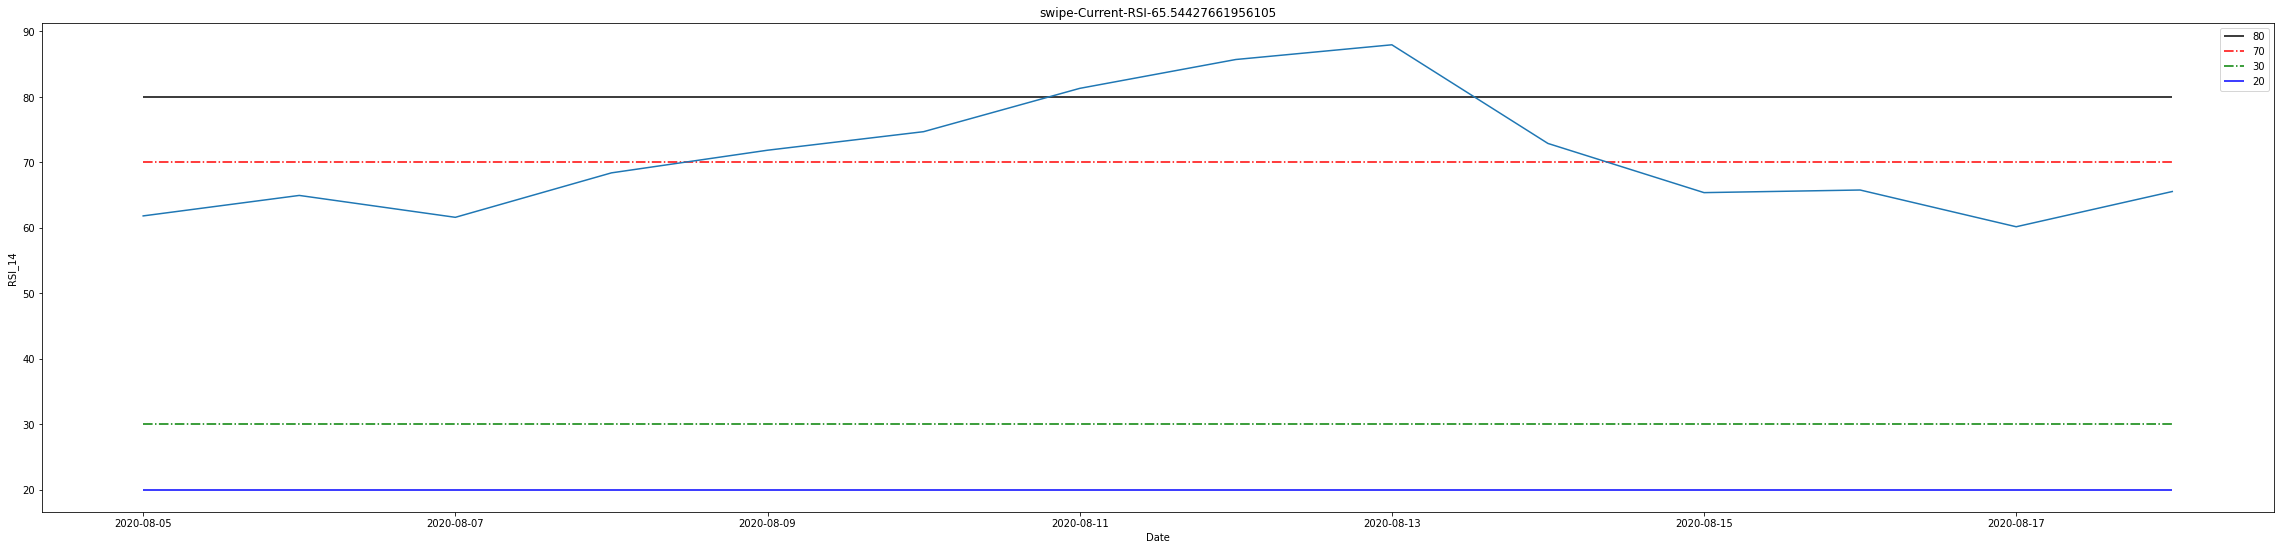

Plotting RSI (56.61519785841628) for:  digibyte


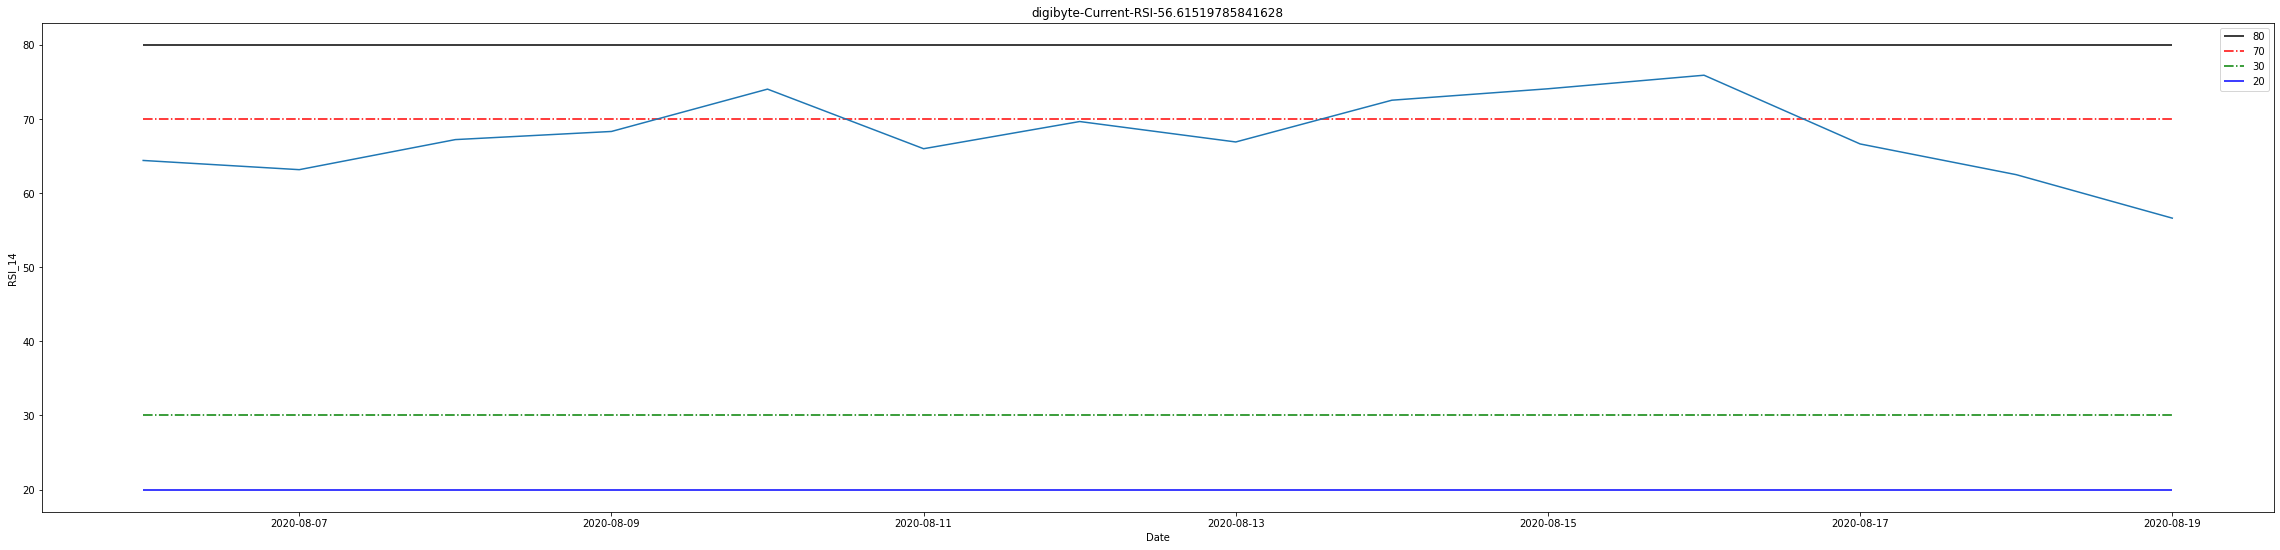

Plotting RSI (82.99684818970105) for:  road


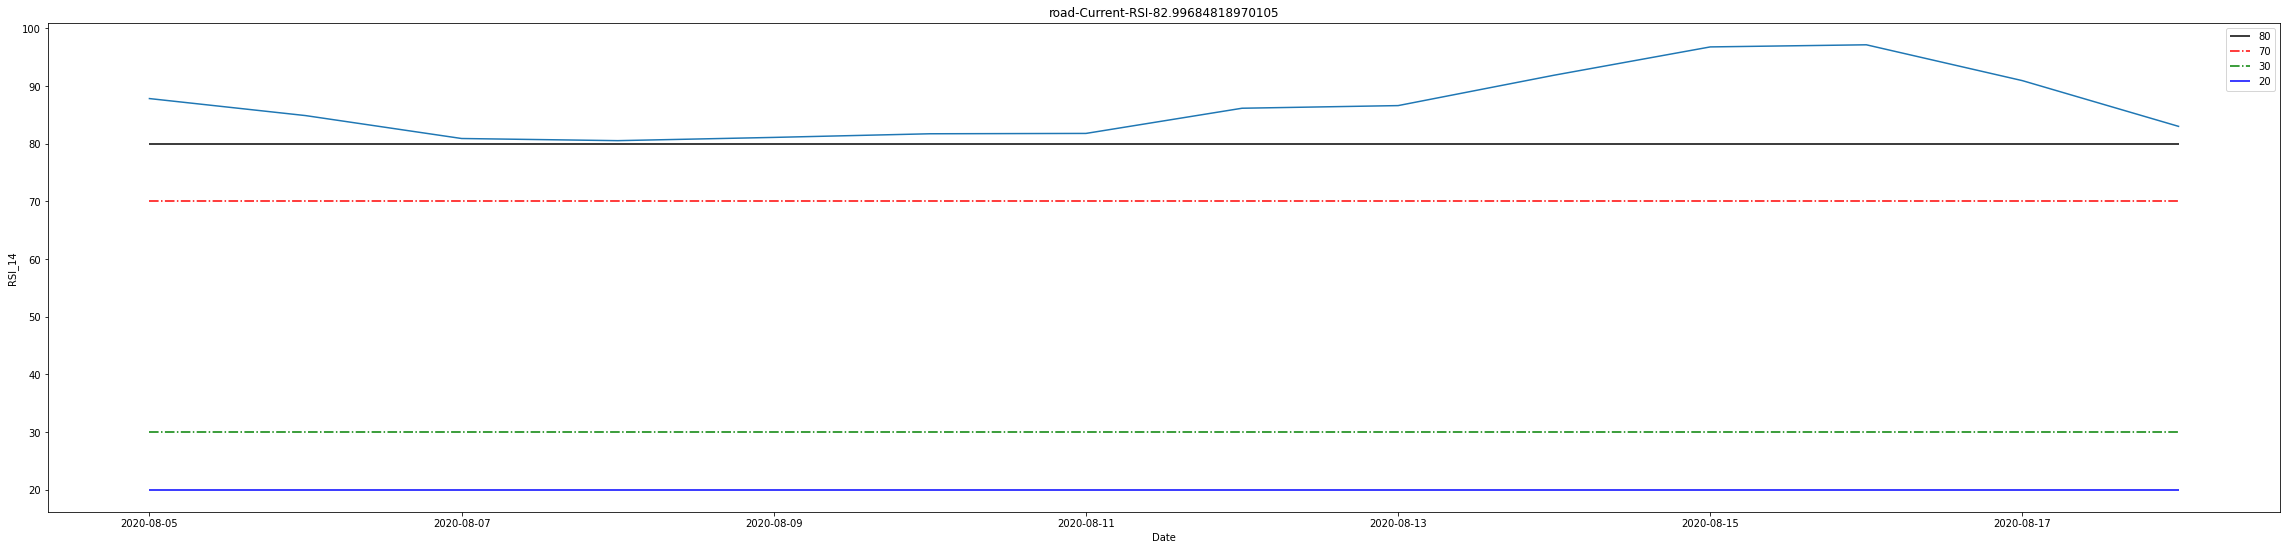

Plotting RSI (54.33128678026415) for:  populous


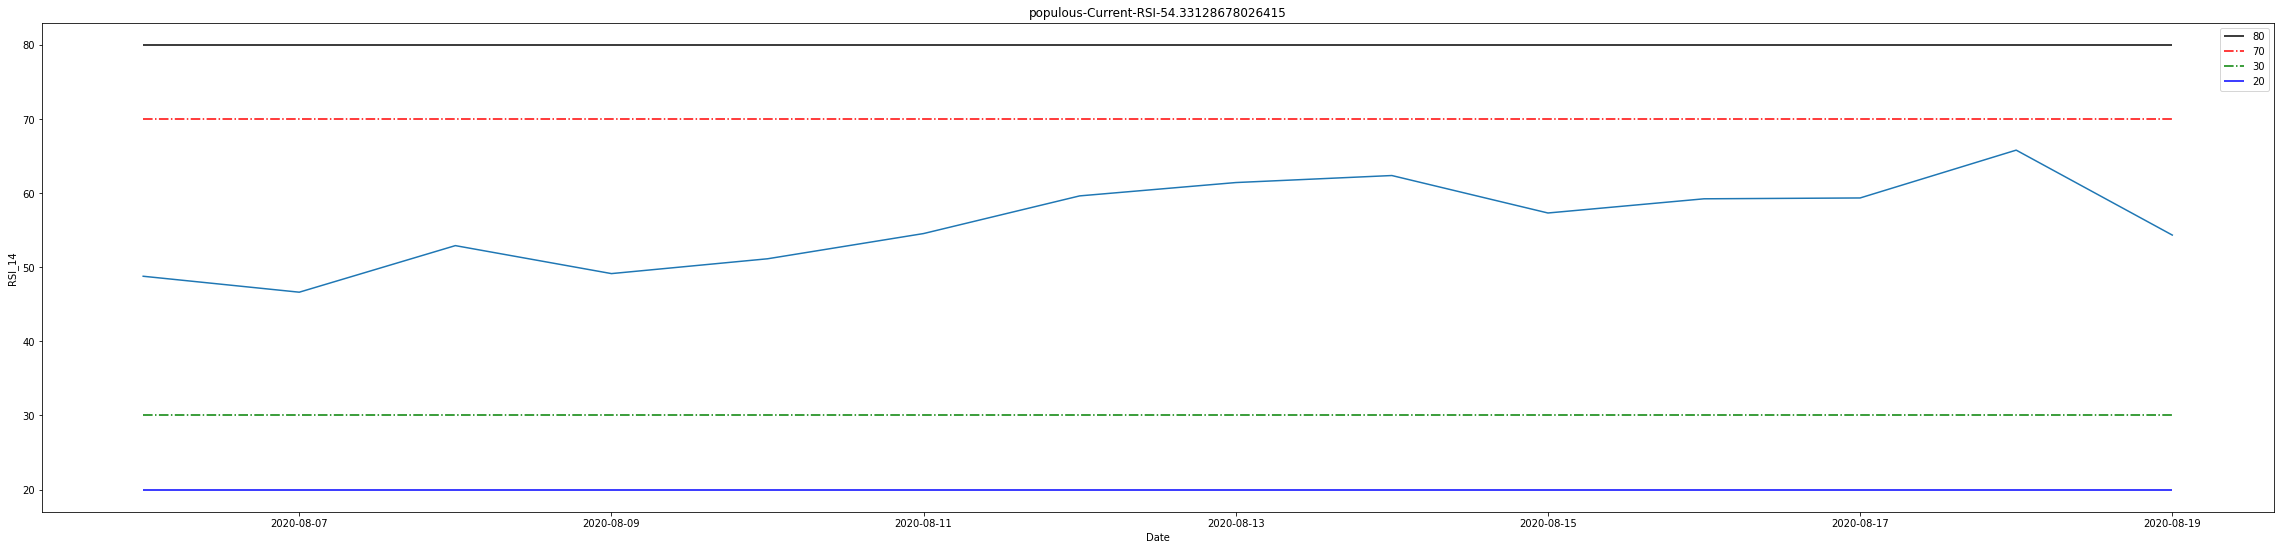

Plotting RSI (69.57333078542867) for:  energy-web-token


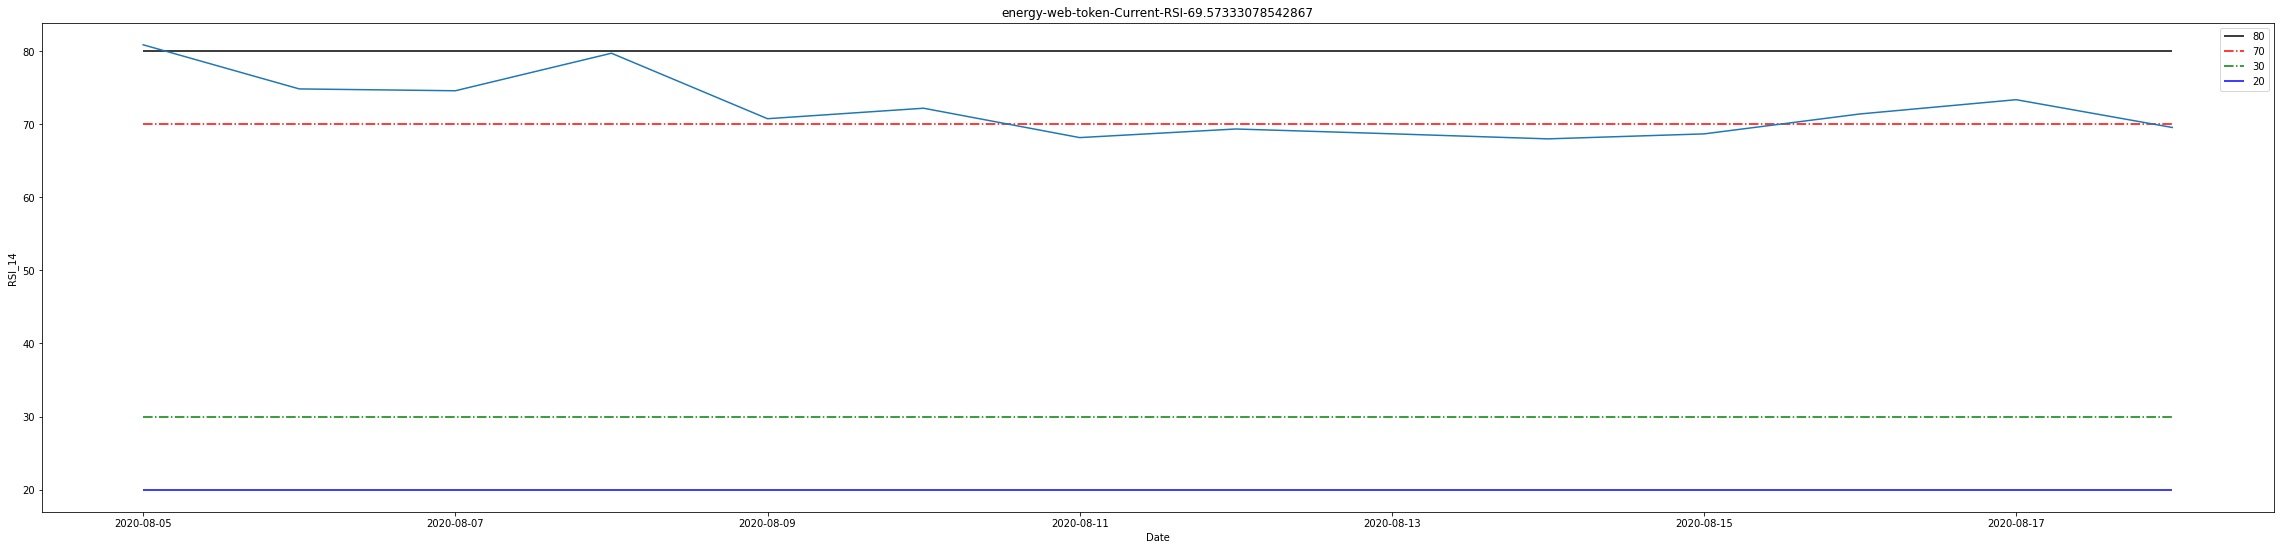

Plotting RSI (47.88085672553395) for:  verasity


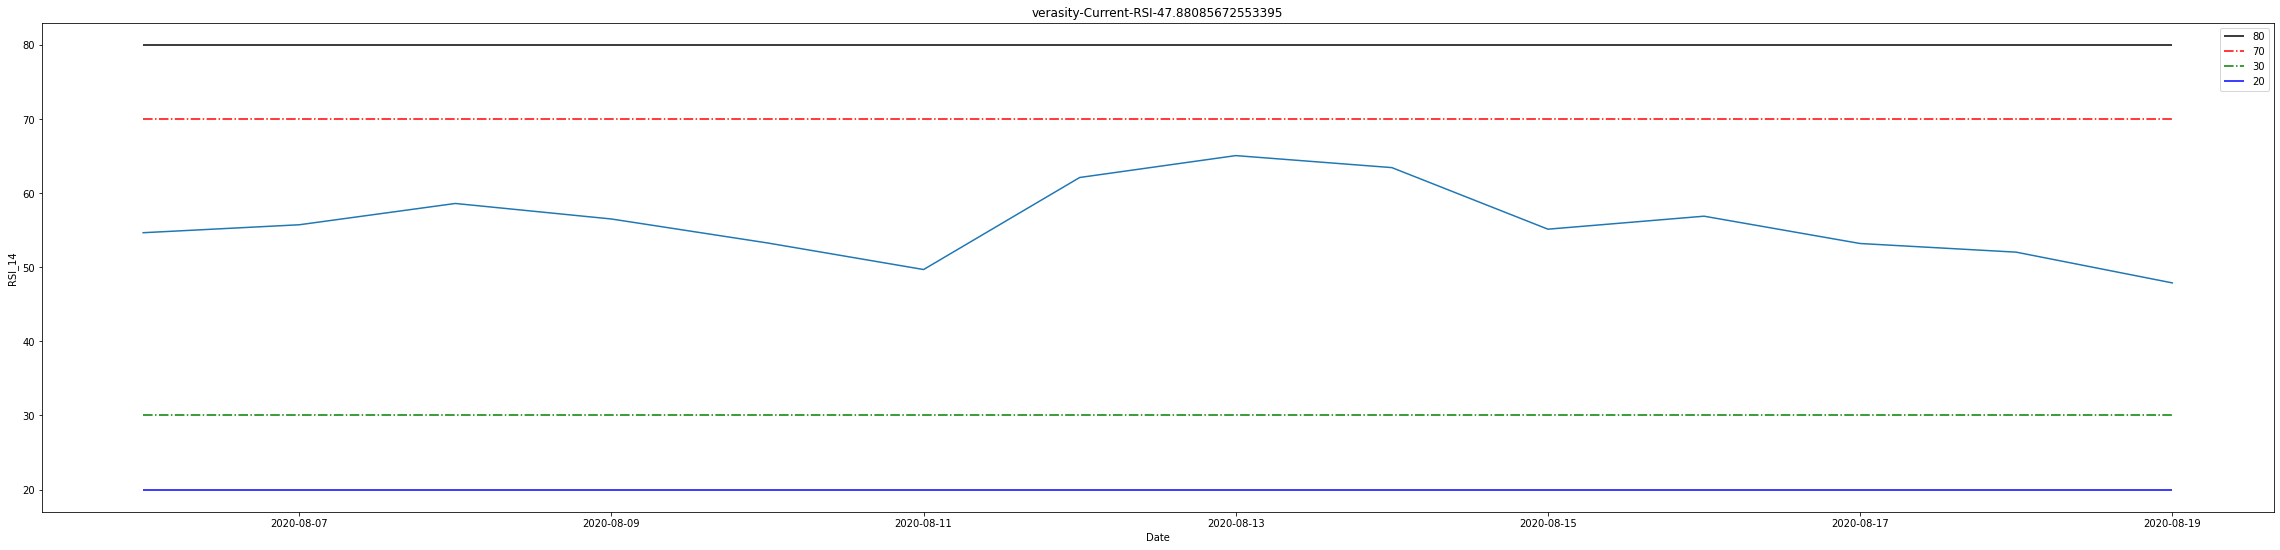

Plotting RSI (63.44824714766455) for:  selfkey


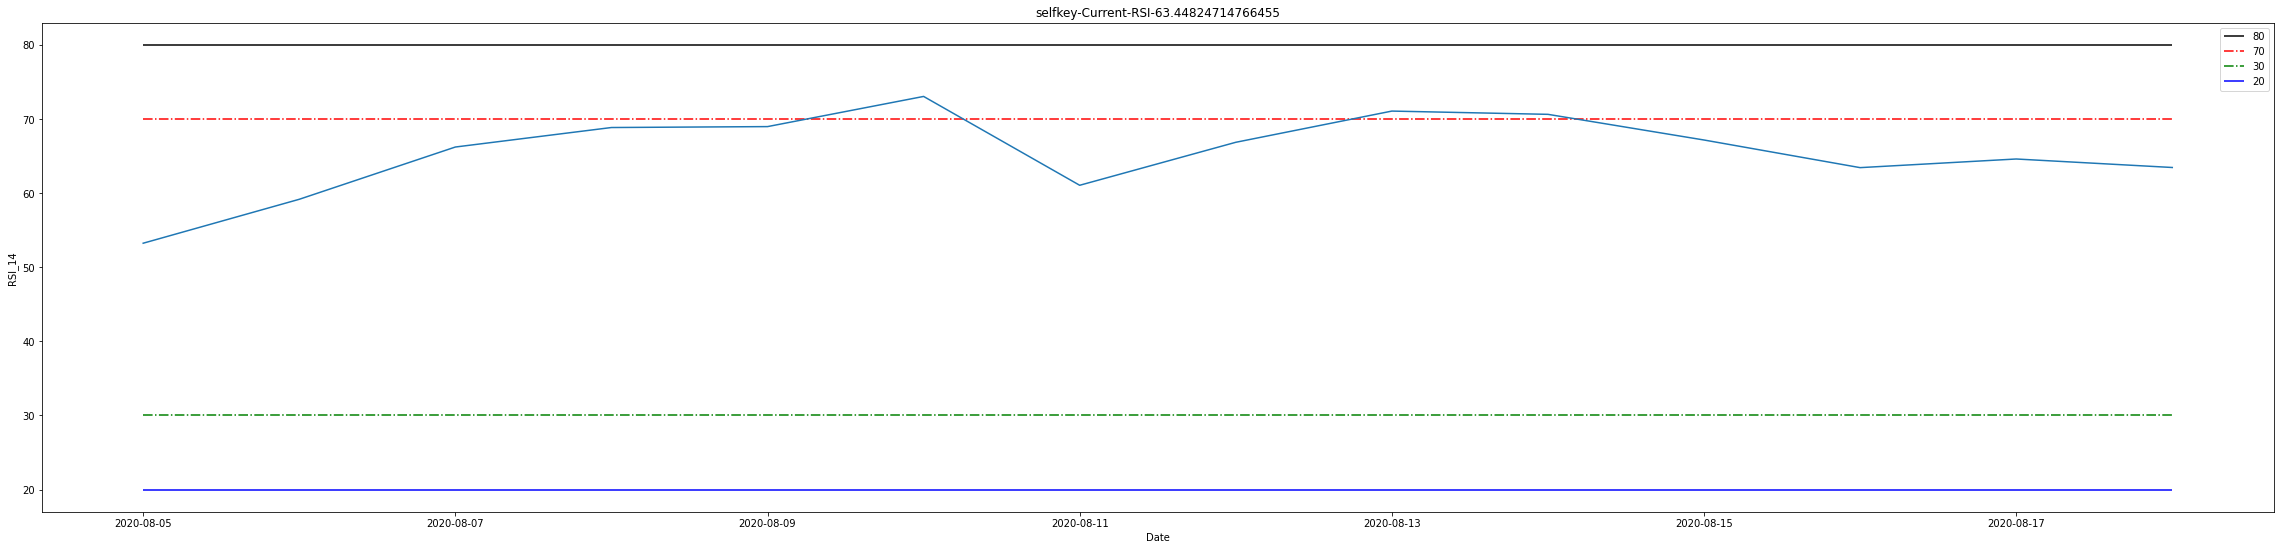

Plotting RSI (56.00859485227592) for:  enjin-coin


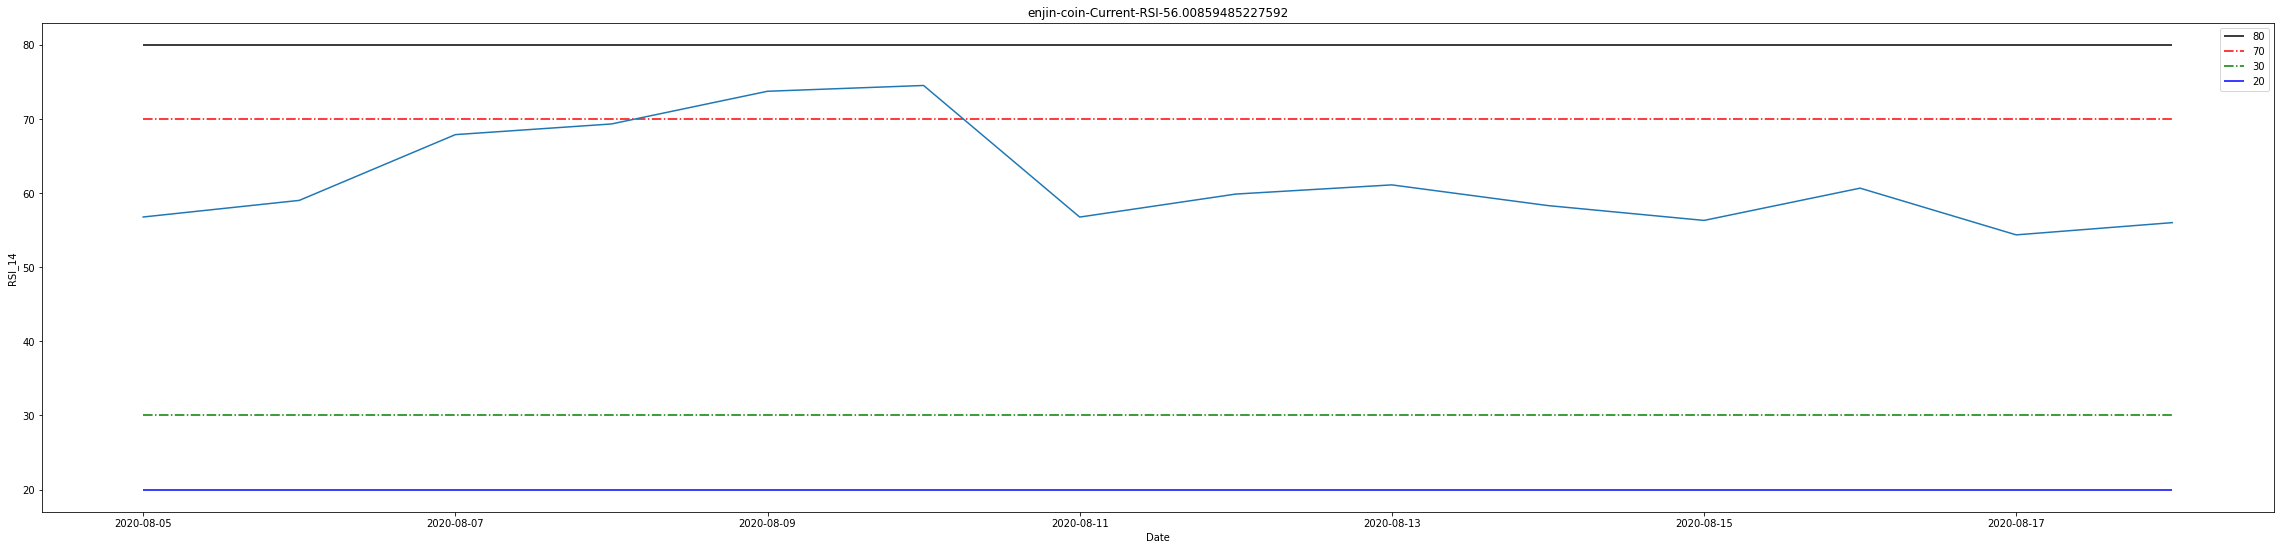

Plotting RSI (64.888120479685) for:  tokoin


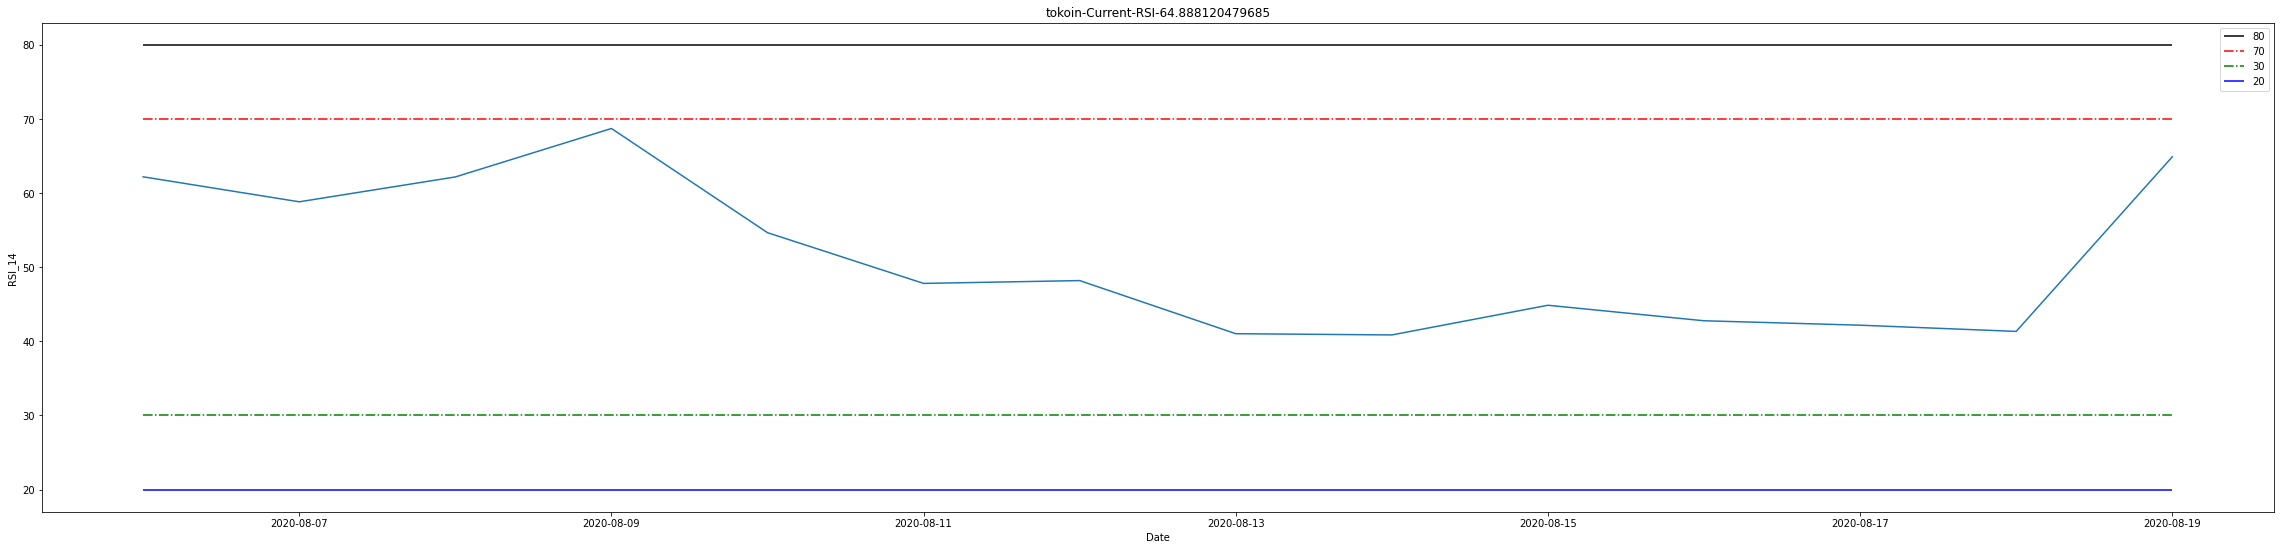

Plotting RSI (75.43732103652799) for:  senso


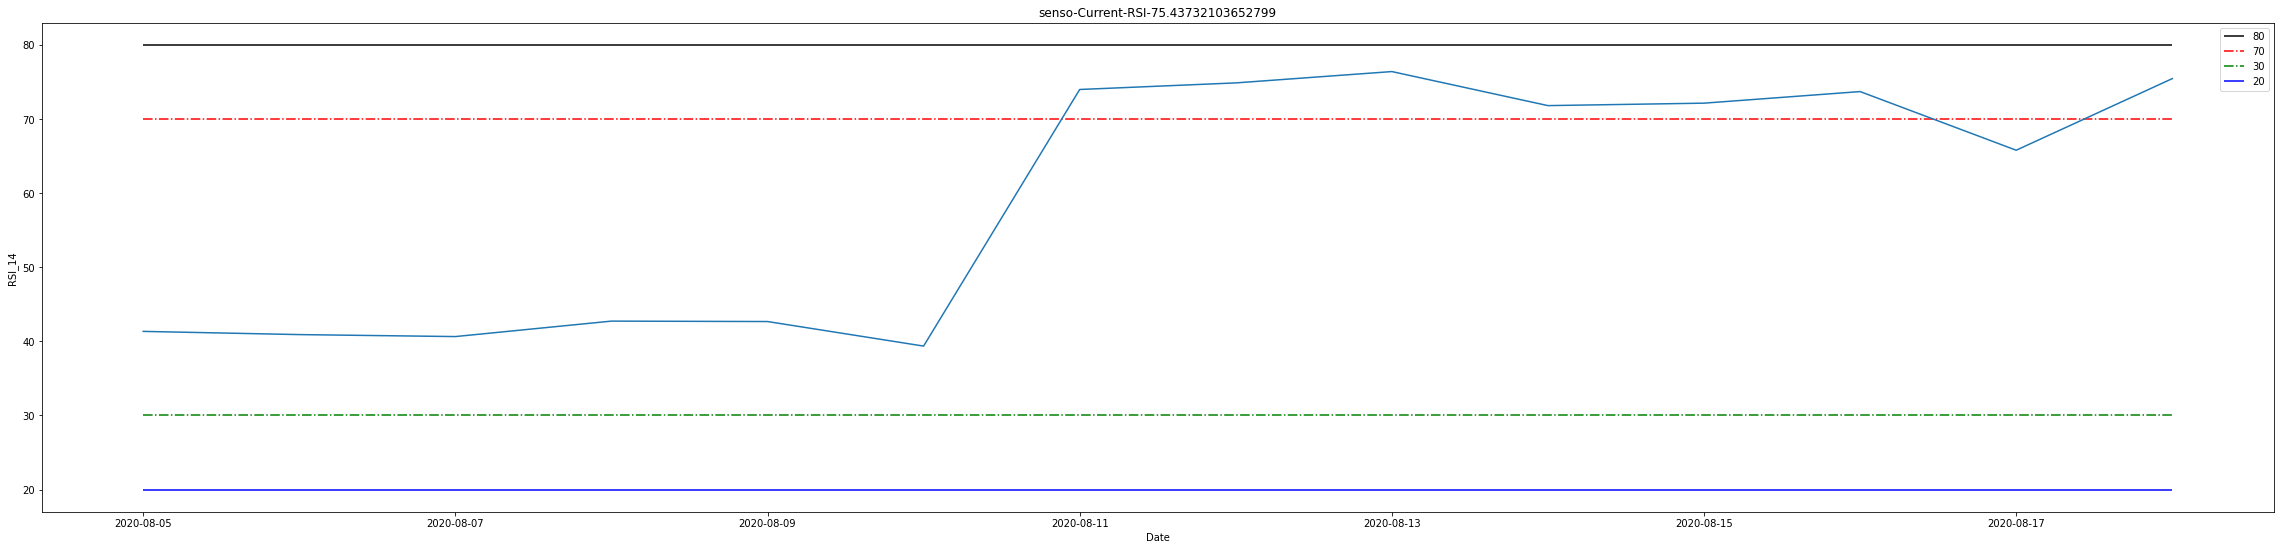

Plotting RSI (55.203229668431185) for:  blockstack


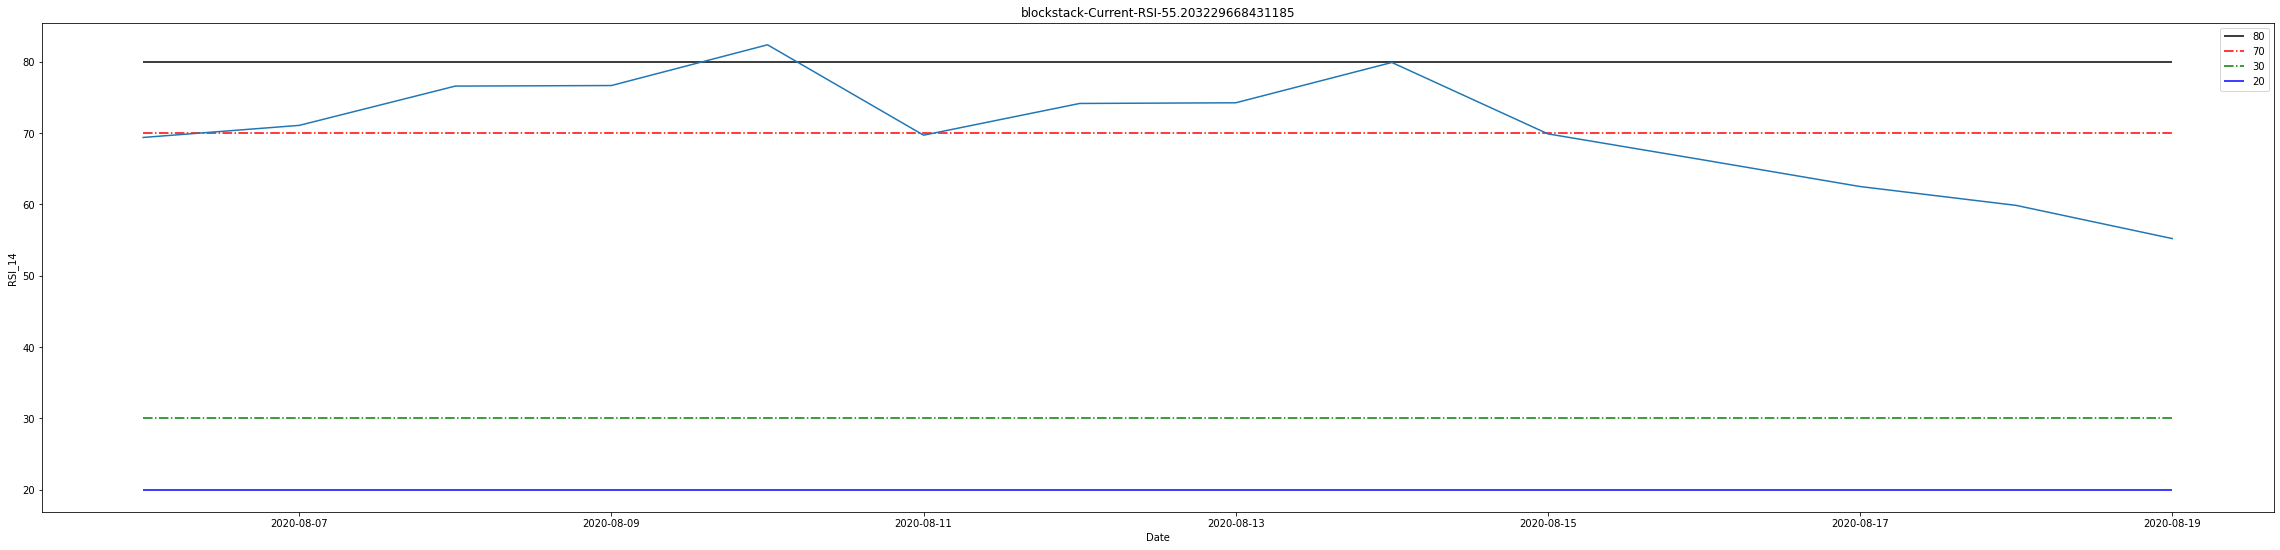

Plotting RSI (55.082967140539964) for:  maker


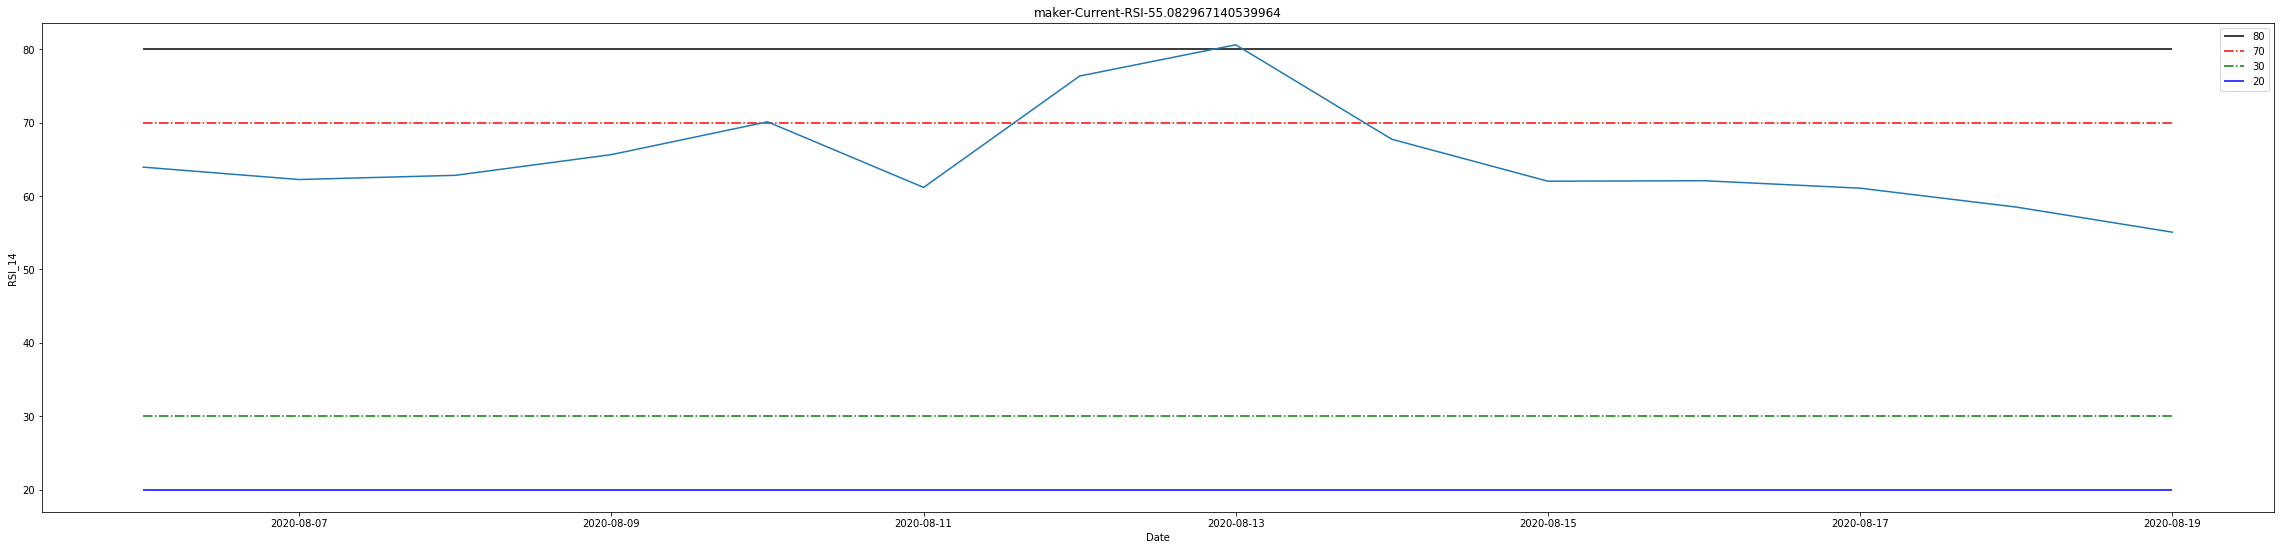

Plotting RSI (73.47164897988667) for:  caspian


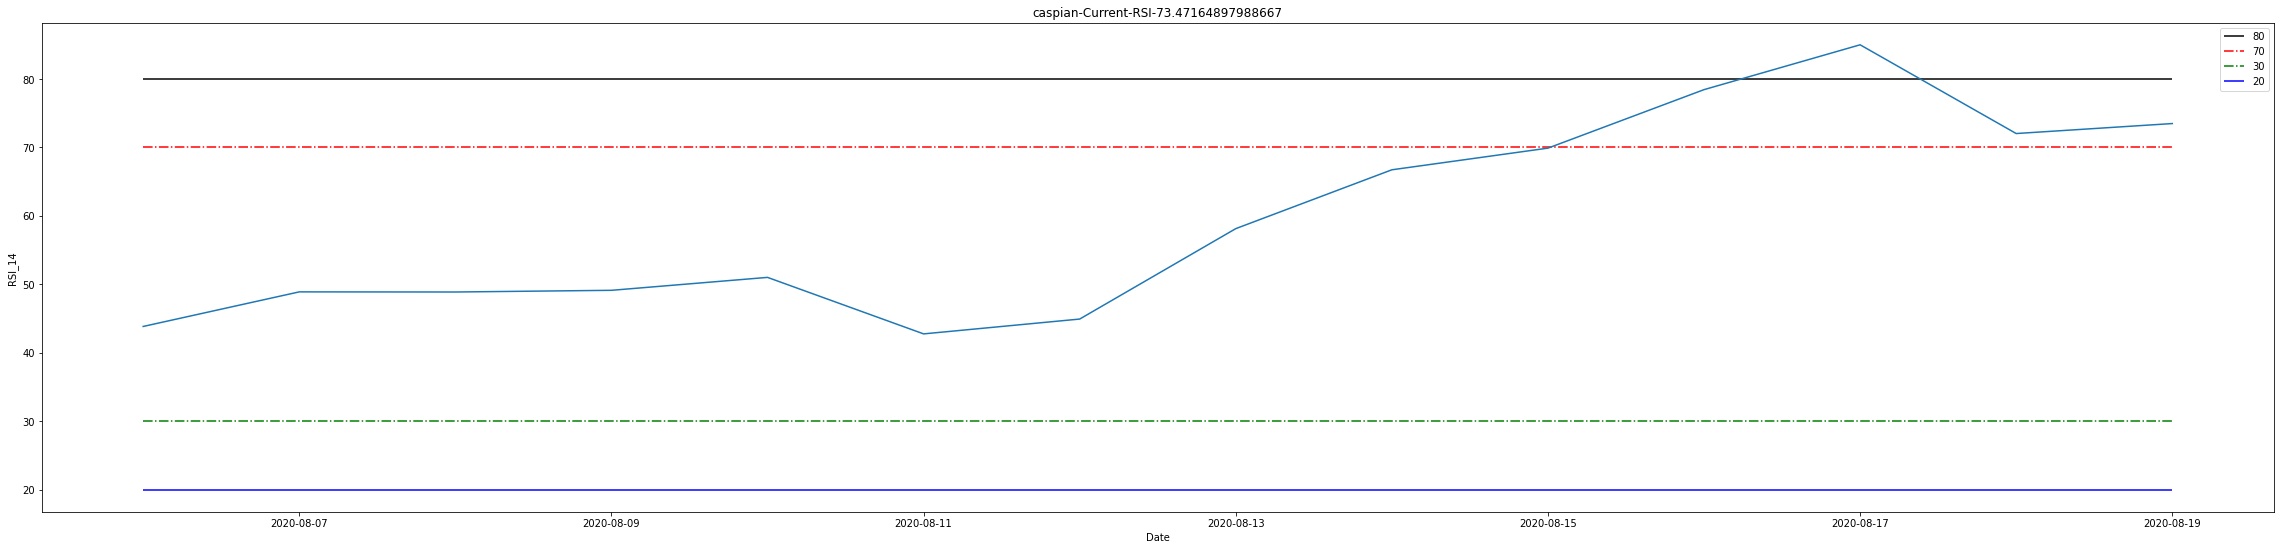

Plotting RSI (63.23615204546387) for:  waltonchain


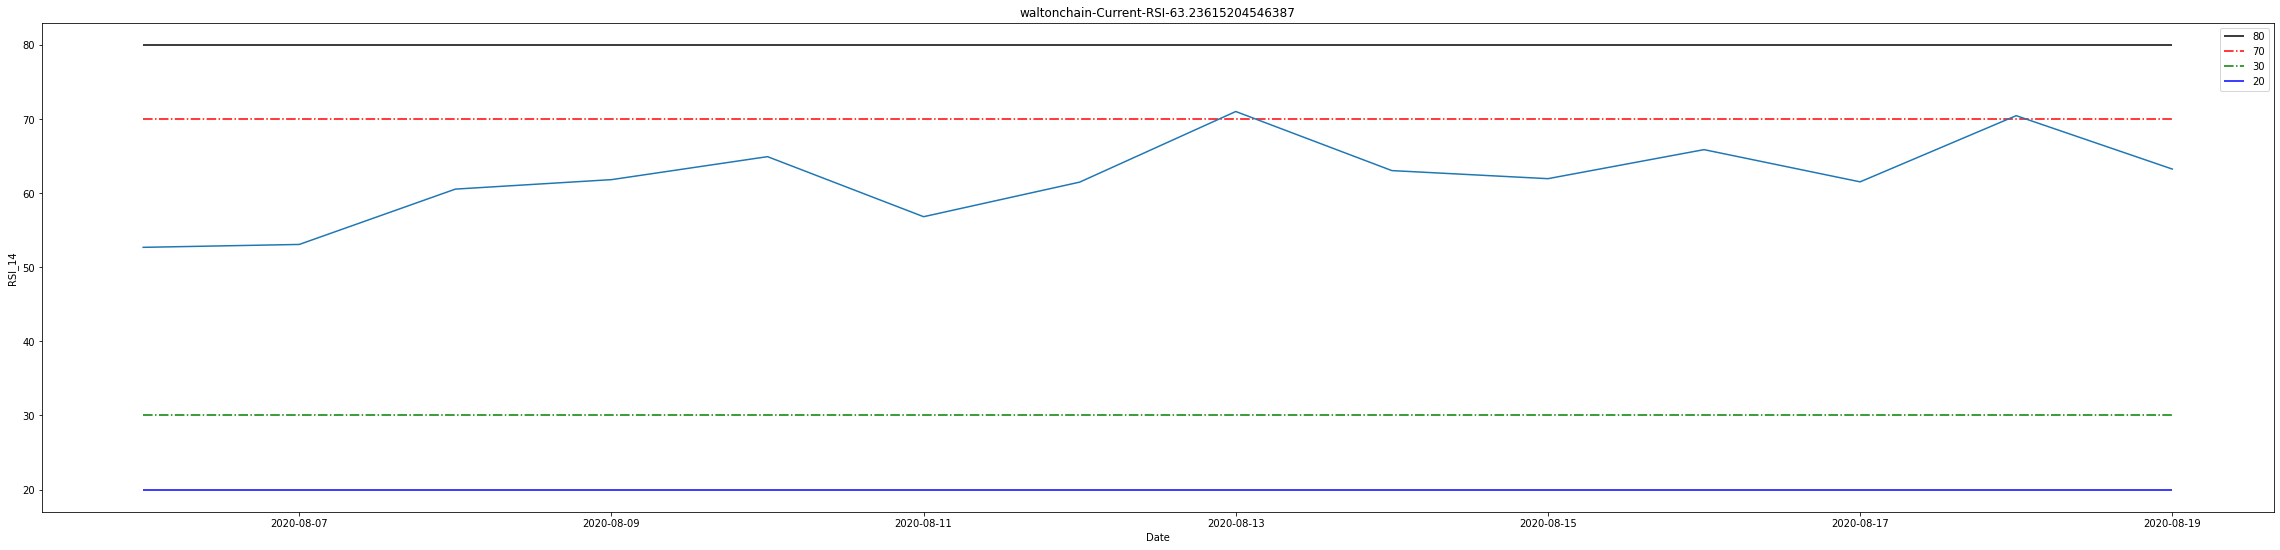

Plotting RSI (55.01767454677135) for:  gochain


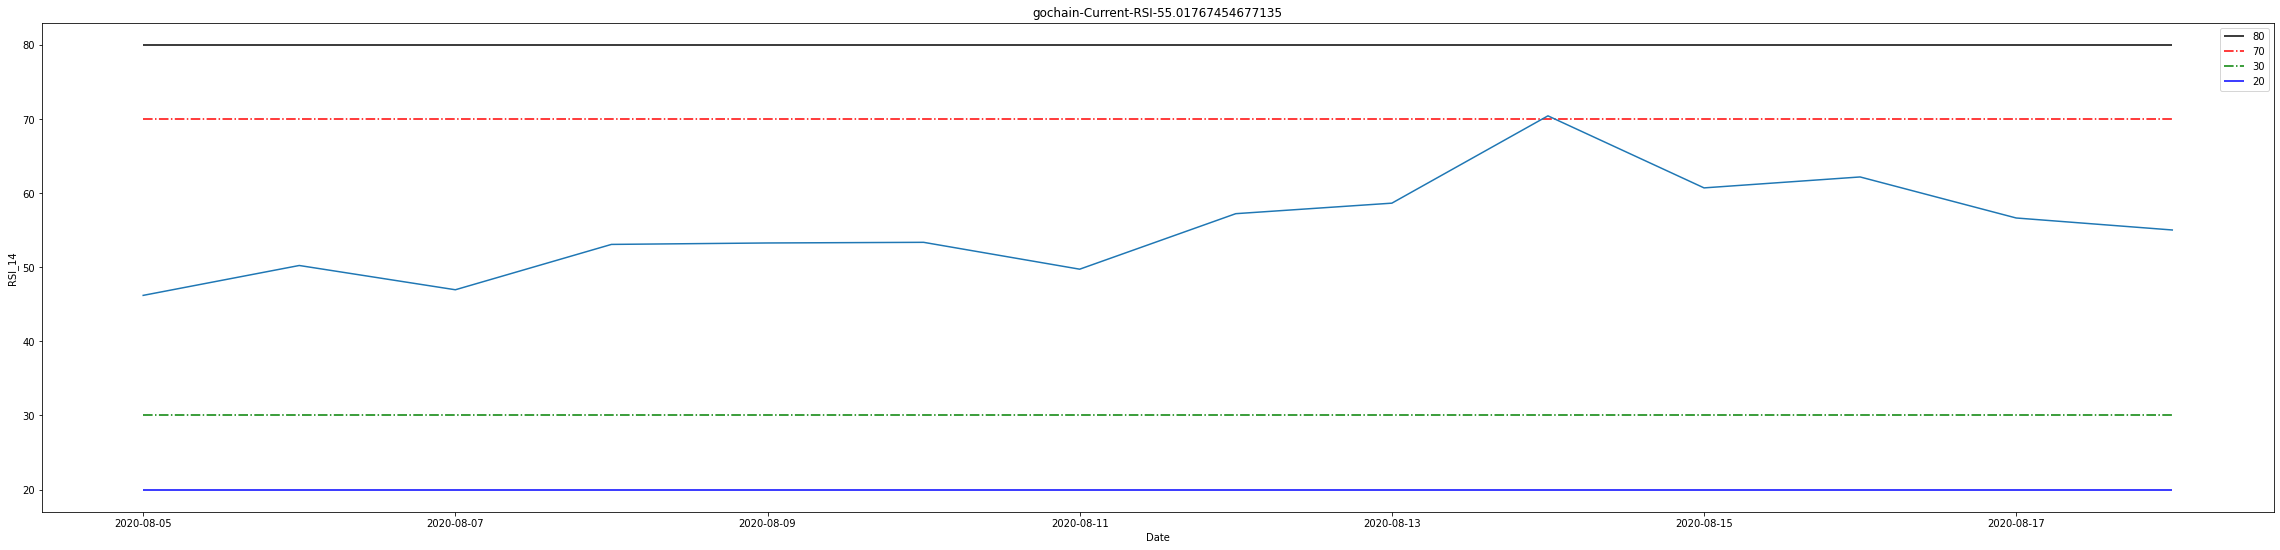

Plotting RSI (49.670677749141774) for:  rsk-infrastructure-framework


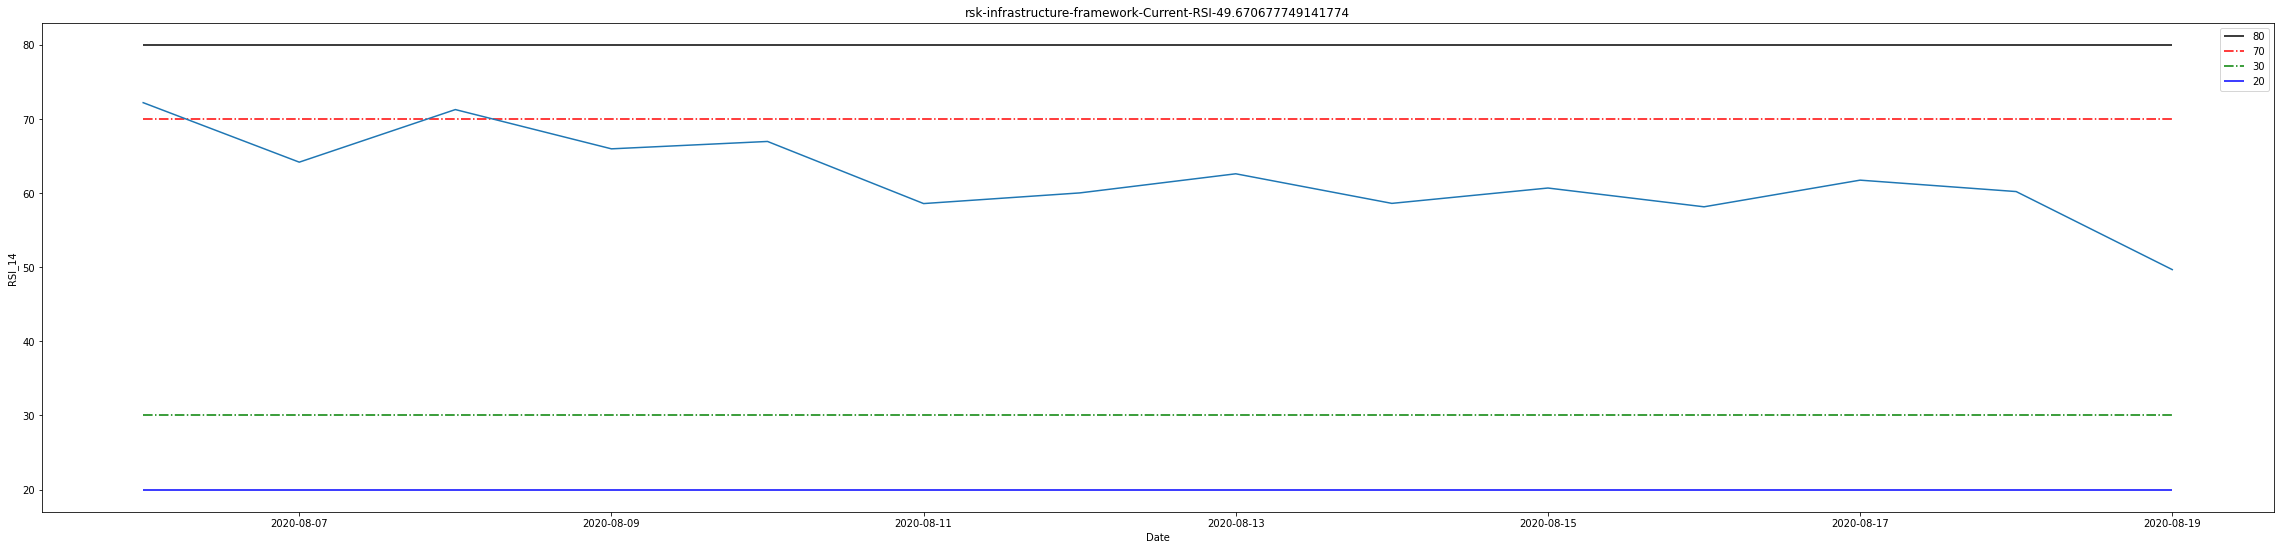

Plotting RSI (54.43384507546891) for:  arcs


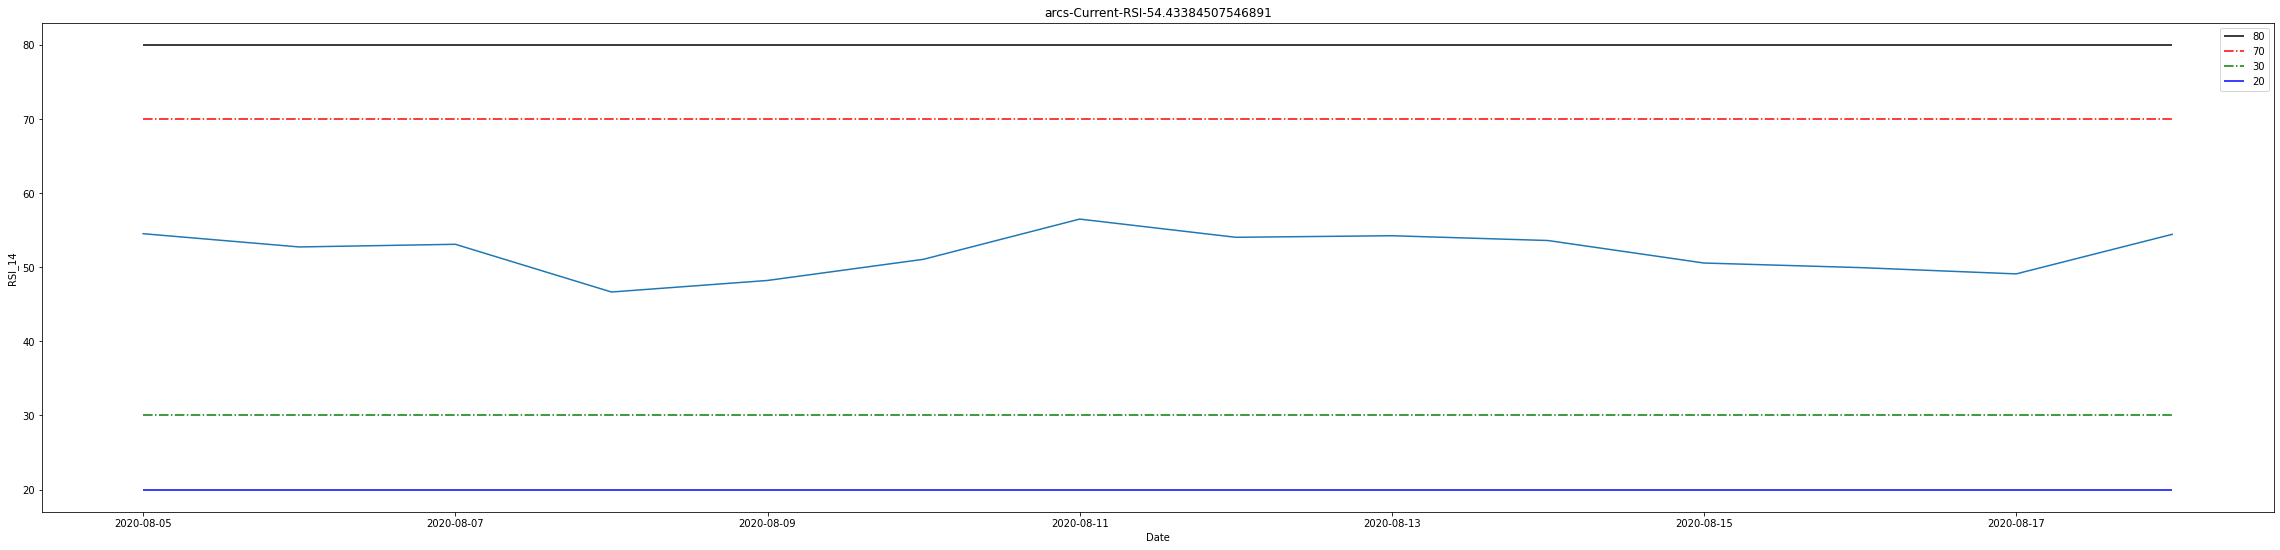

Plotting RSI (60.29296892540008) for:  ontology


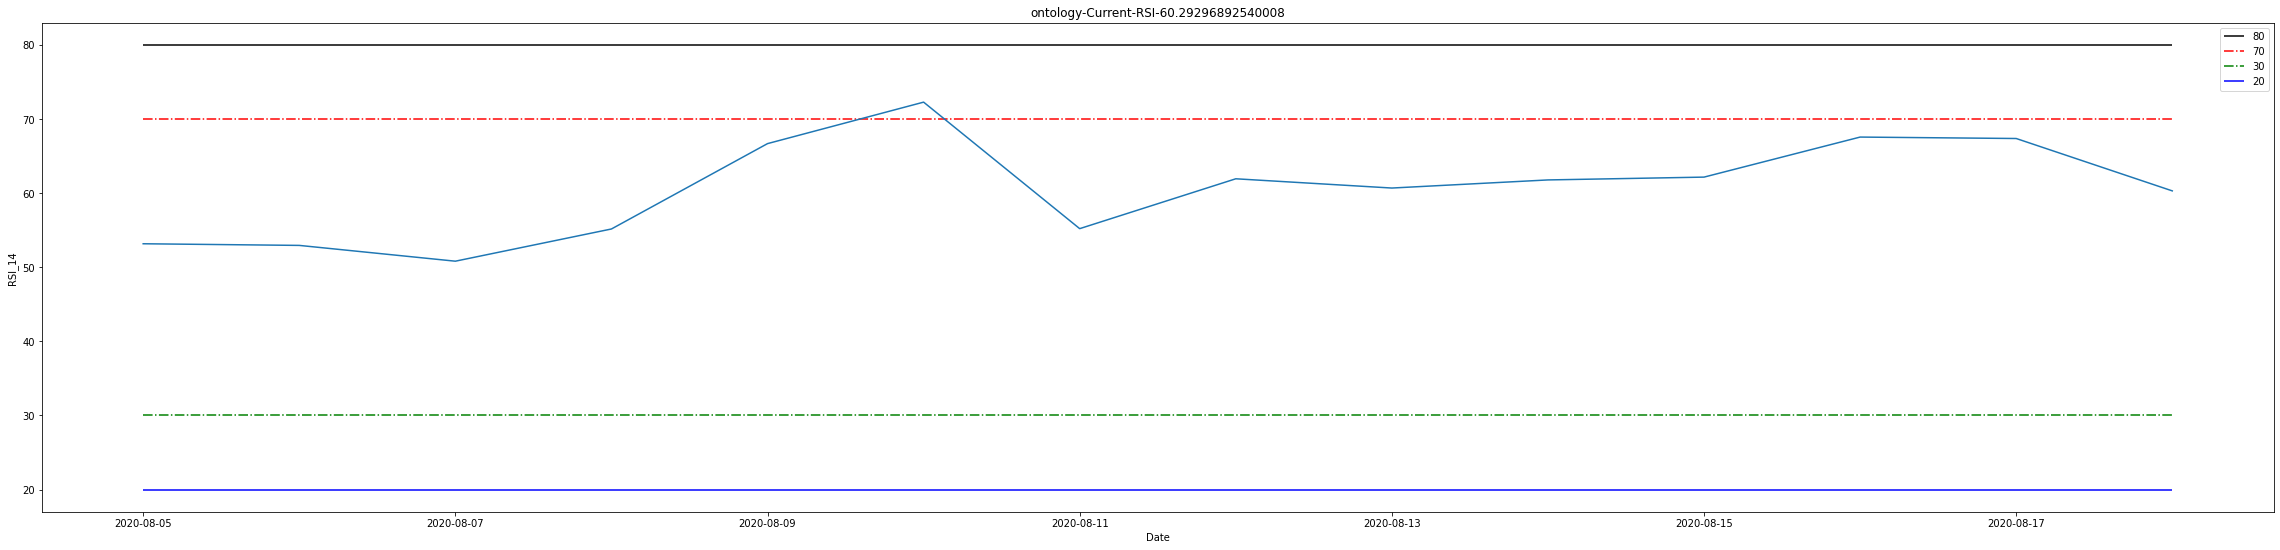

Plotting RSI (38.49446637089942) for:  bitcoin-diamond


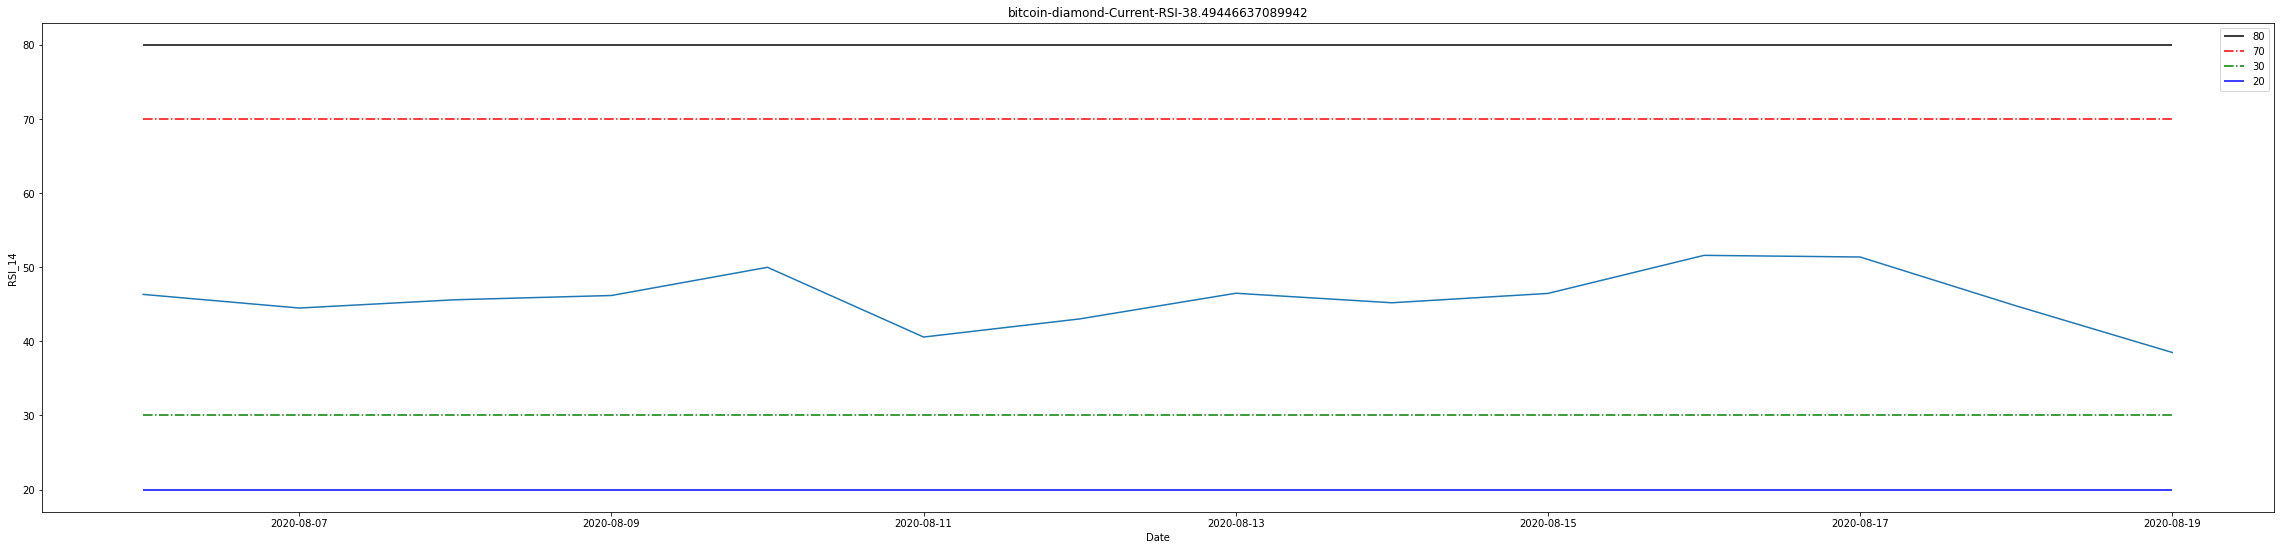

Plotting RSI (47.84896633036171) for:  xyo


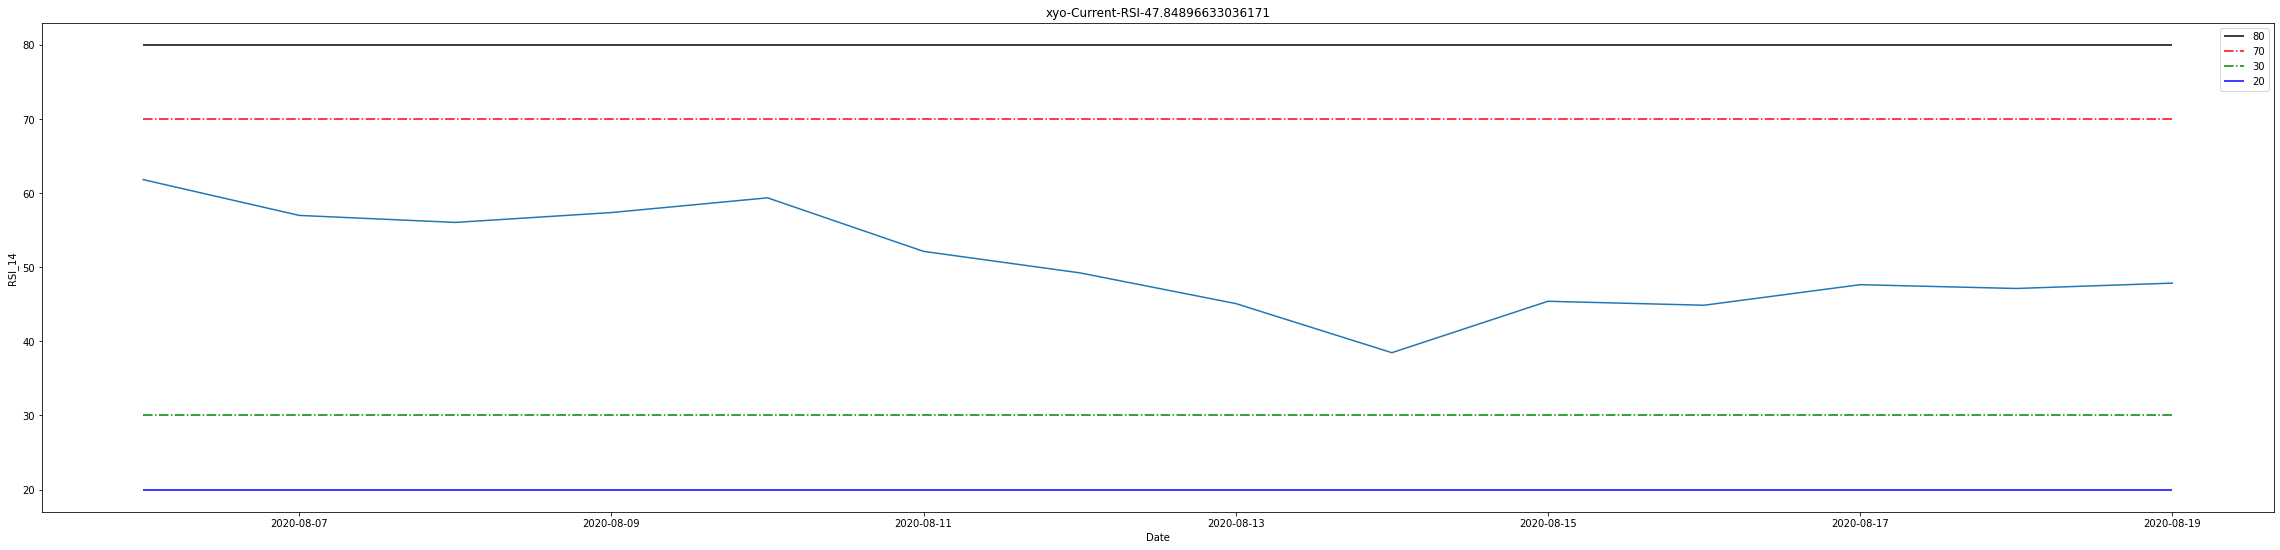

Plotting RSI (57.702233380410995) for:  status


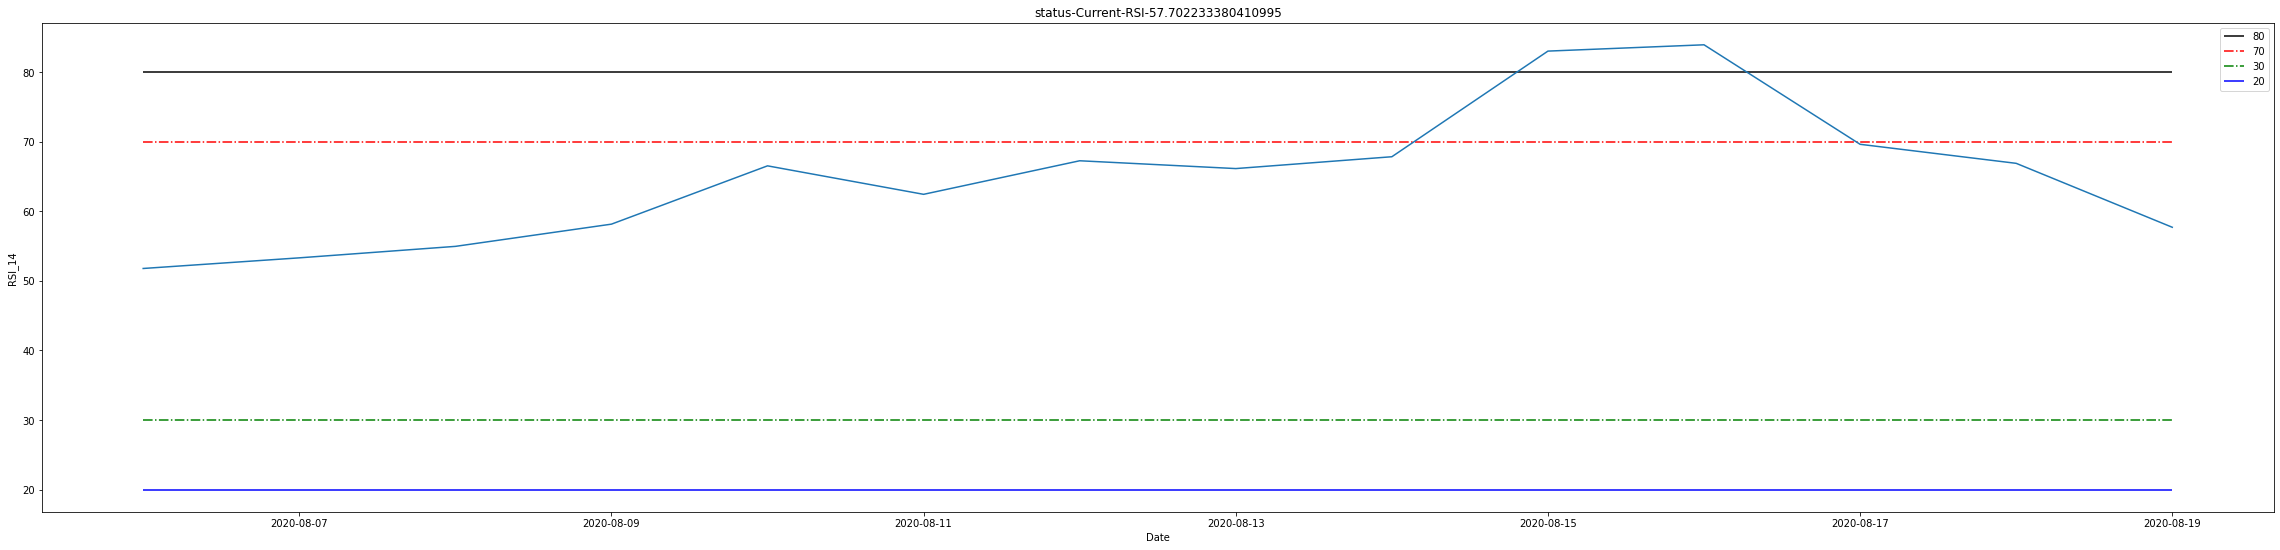

Plotting RSI (68.62343180822069) for:  qtum


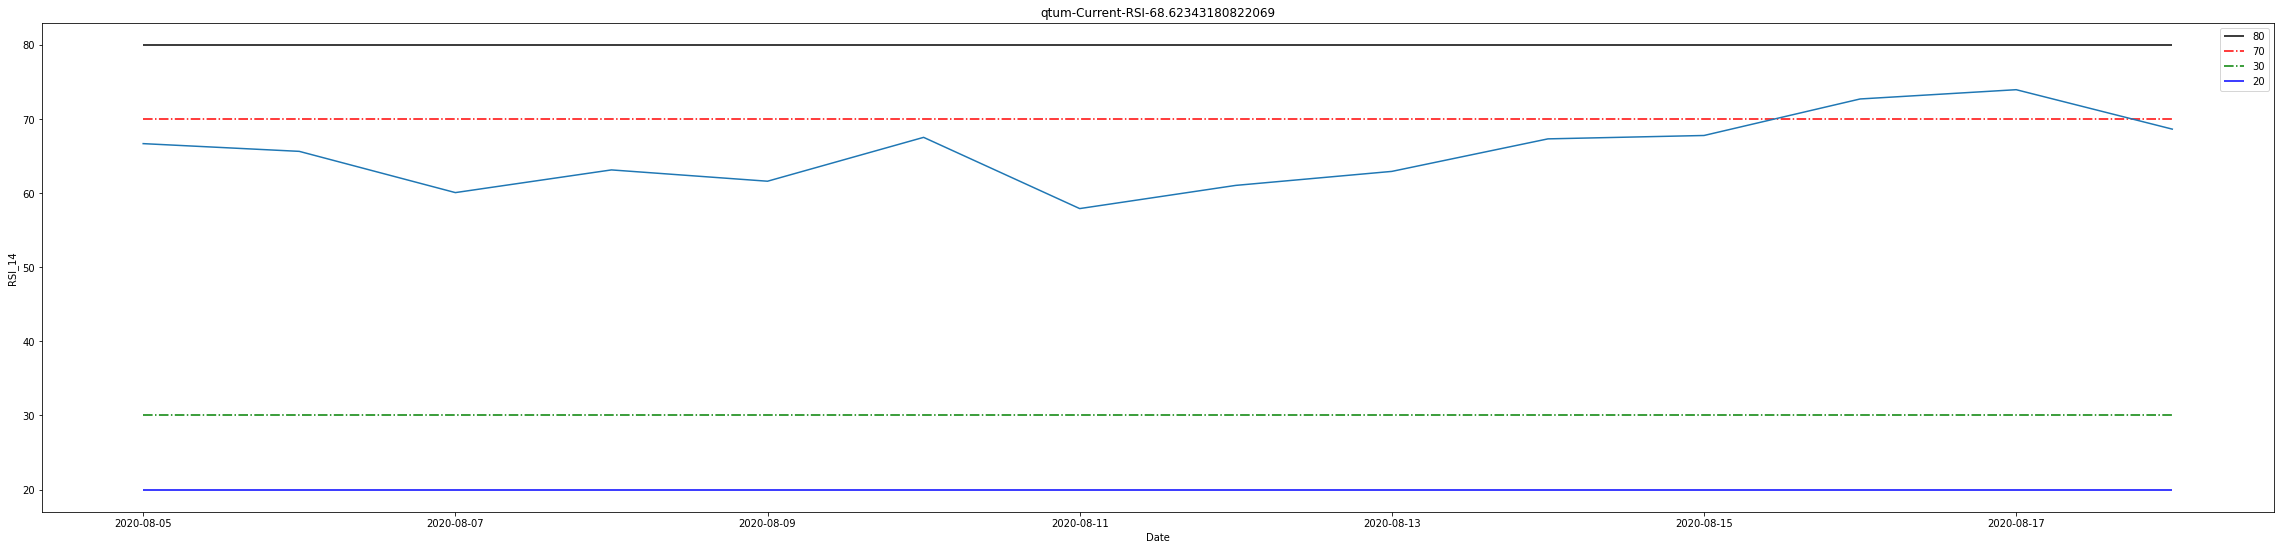

Plotting RSI (58.16680574671847) for:  power-ledger


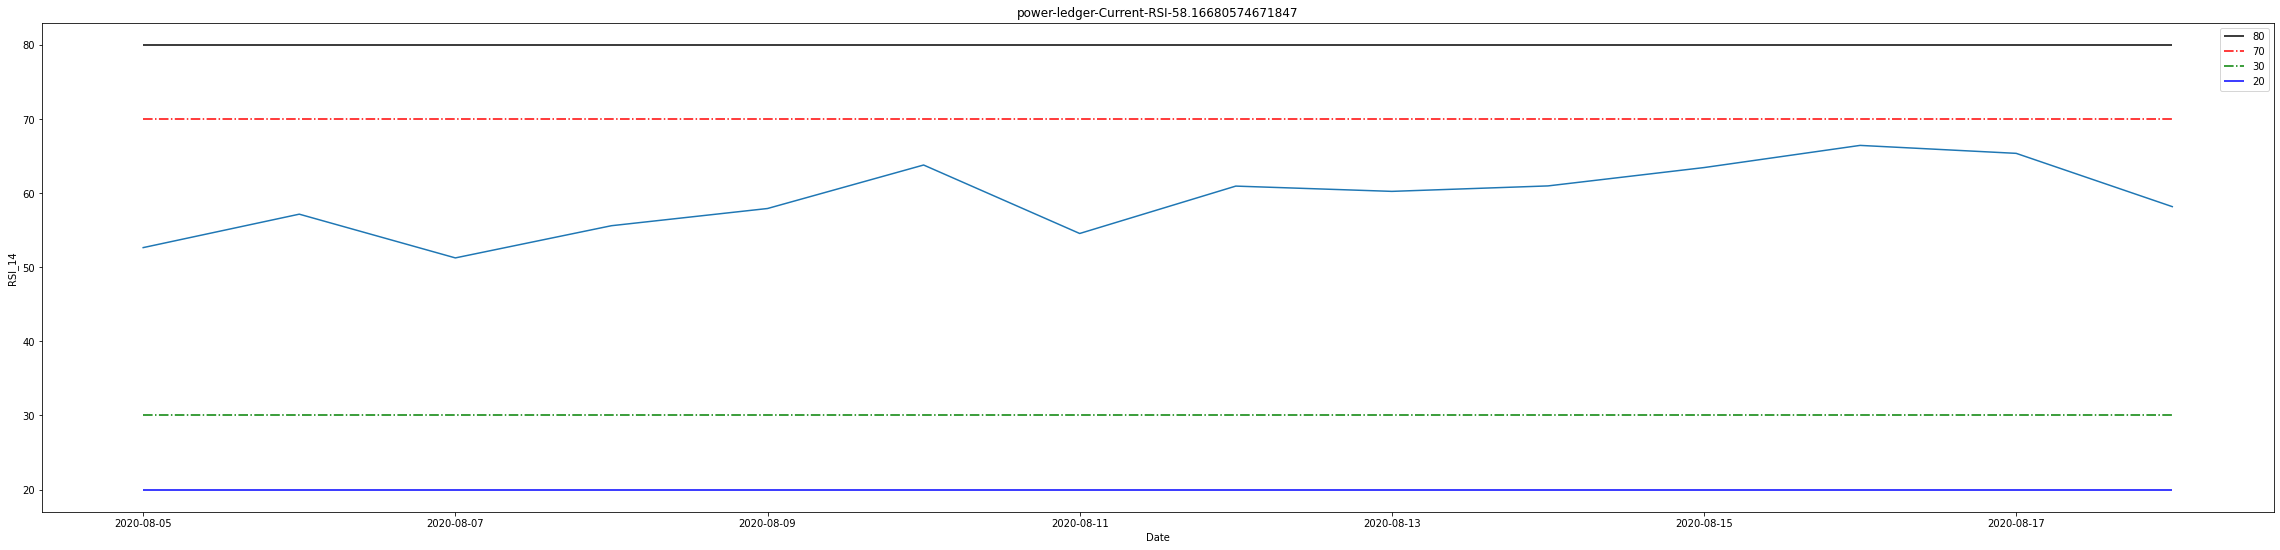

Plotting RSI (nan) for:  proof-of-liquidity


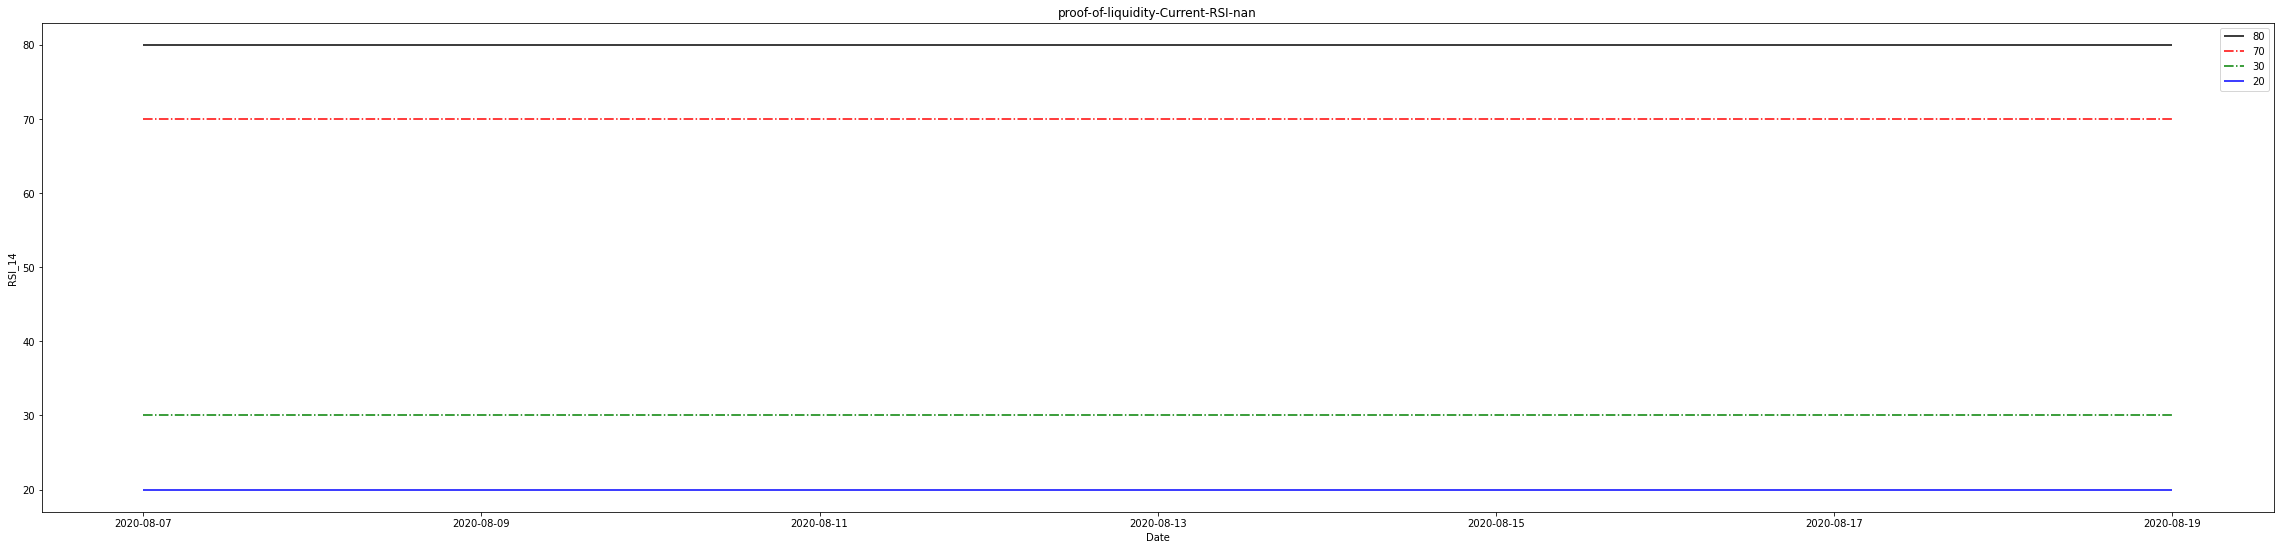

Plotting RSI (65.70998944374486) for:  dia-data


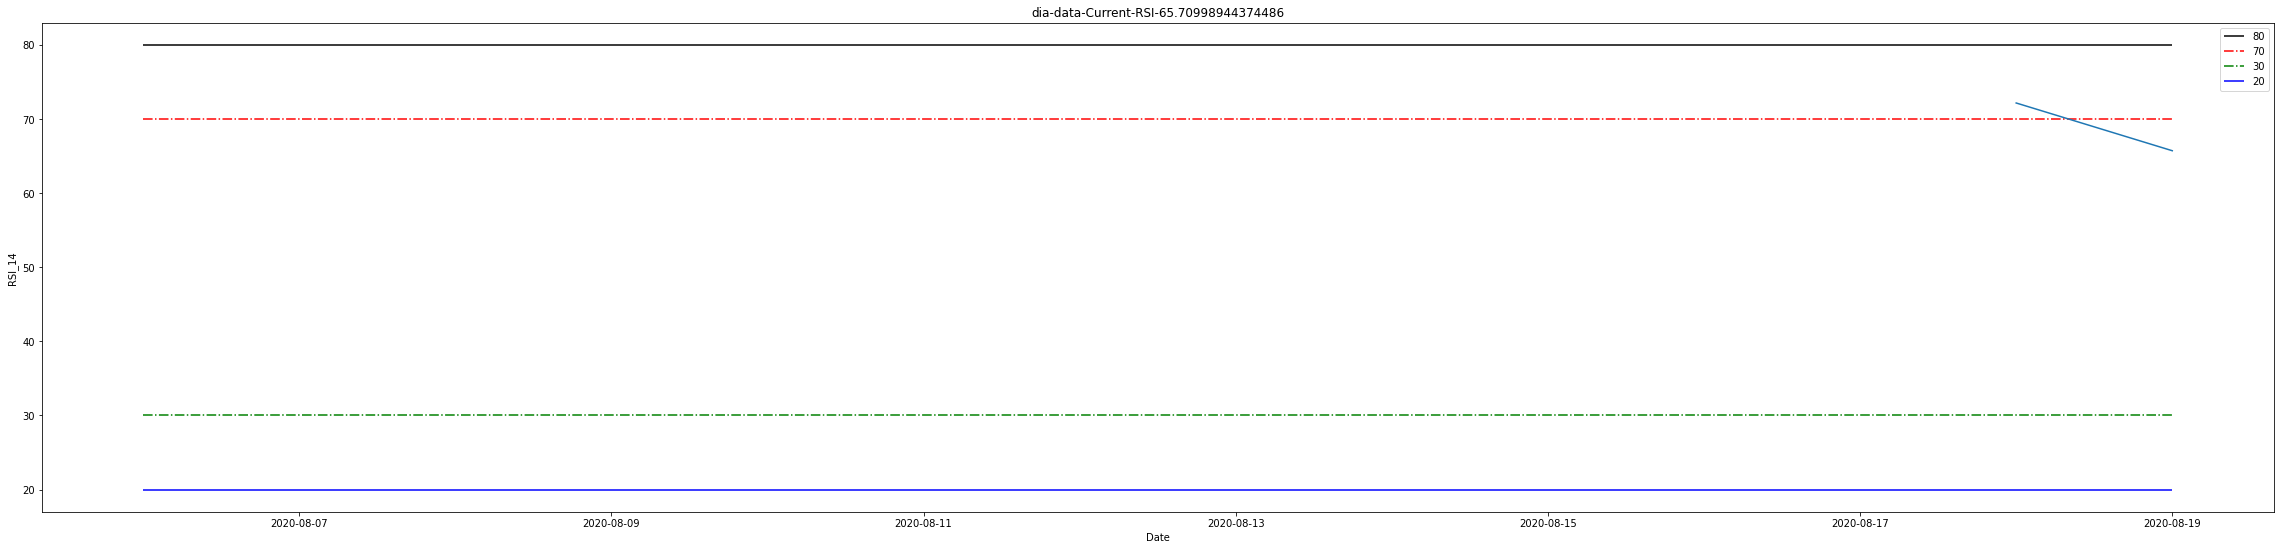

Plotting RSI (26.90146484892243) for:  xensor


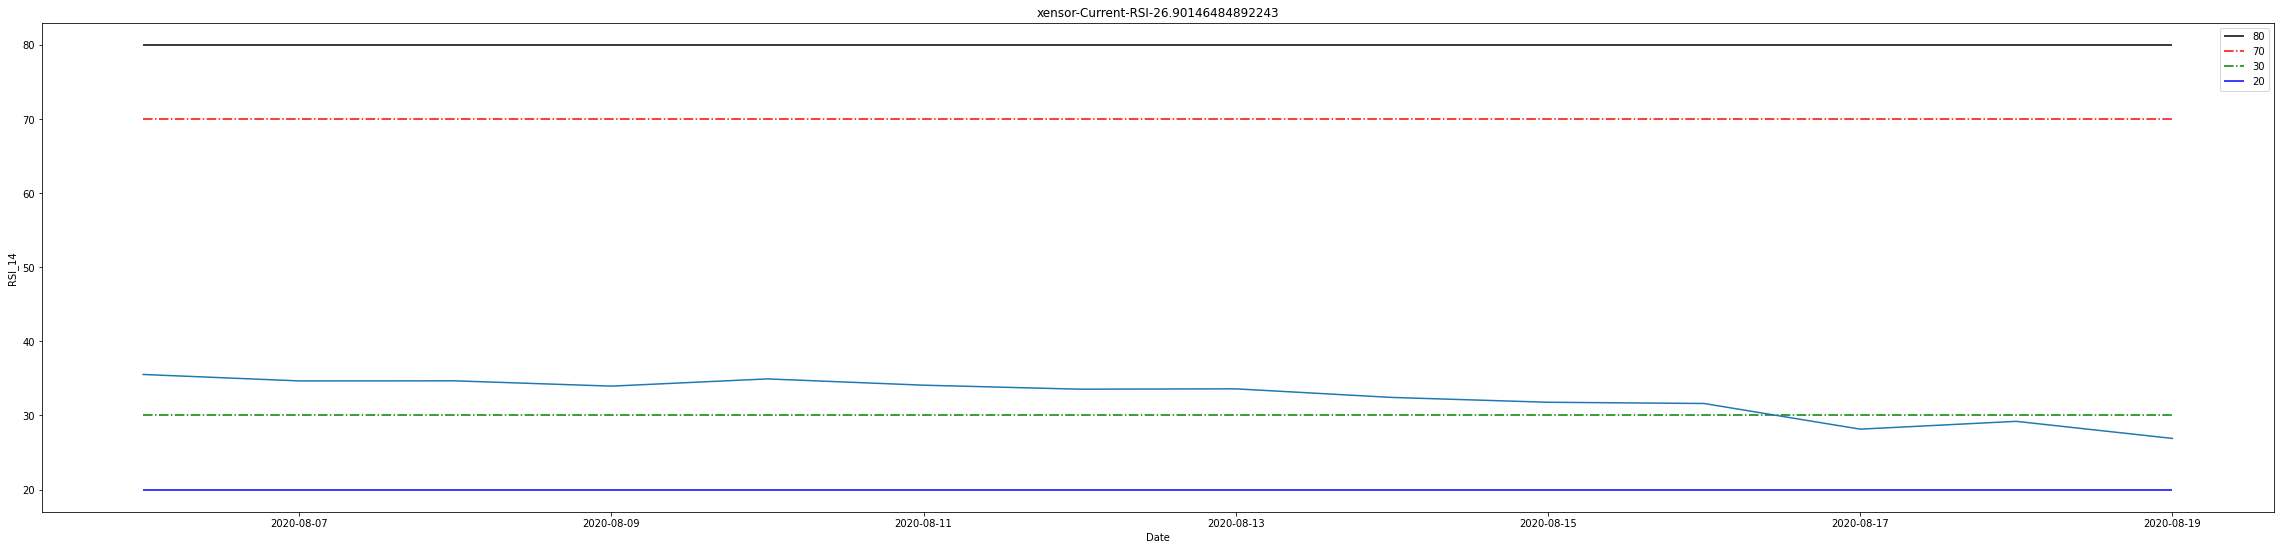

Plotting RSI (45.83182561195548) for:  swissborg


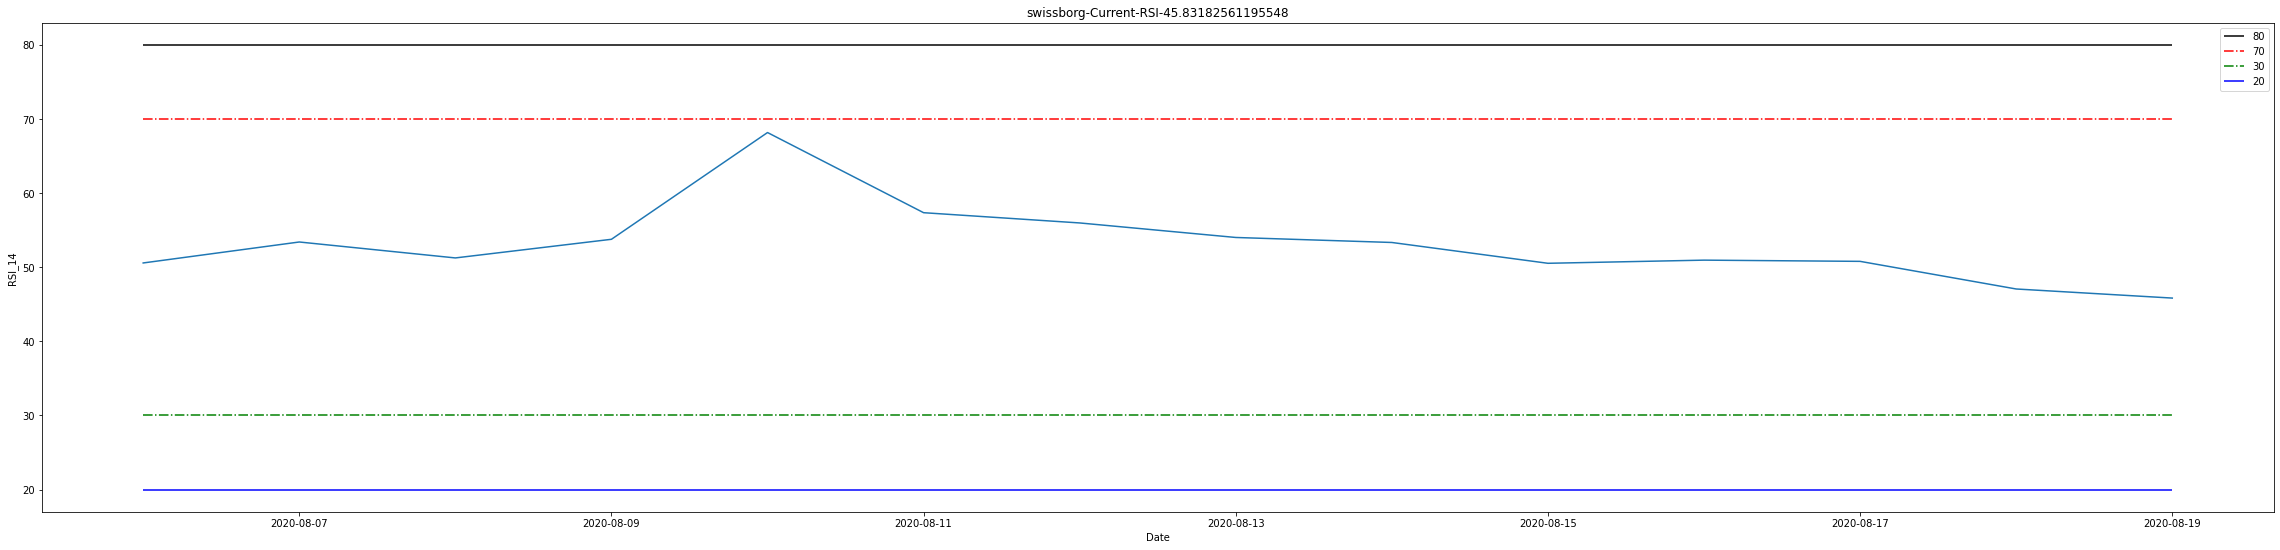

Plotting RSI (60.967367290271106) for:  harmony


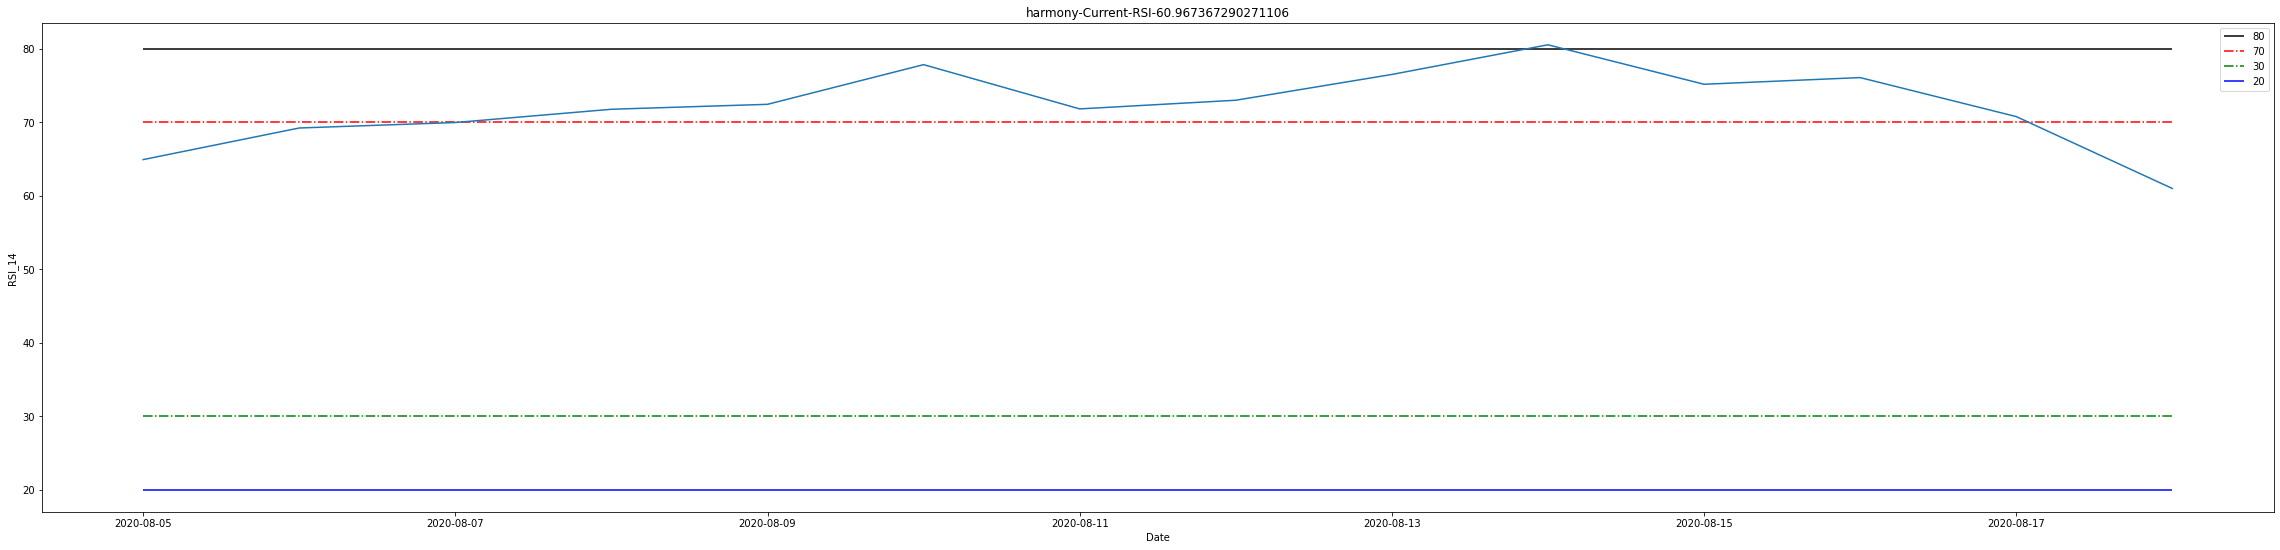

Plotting RSI (56.28185143826786) for:  chromia


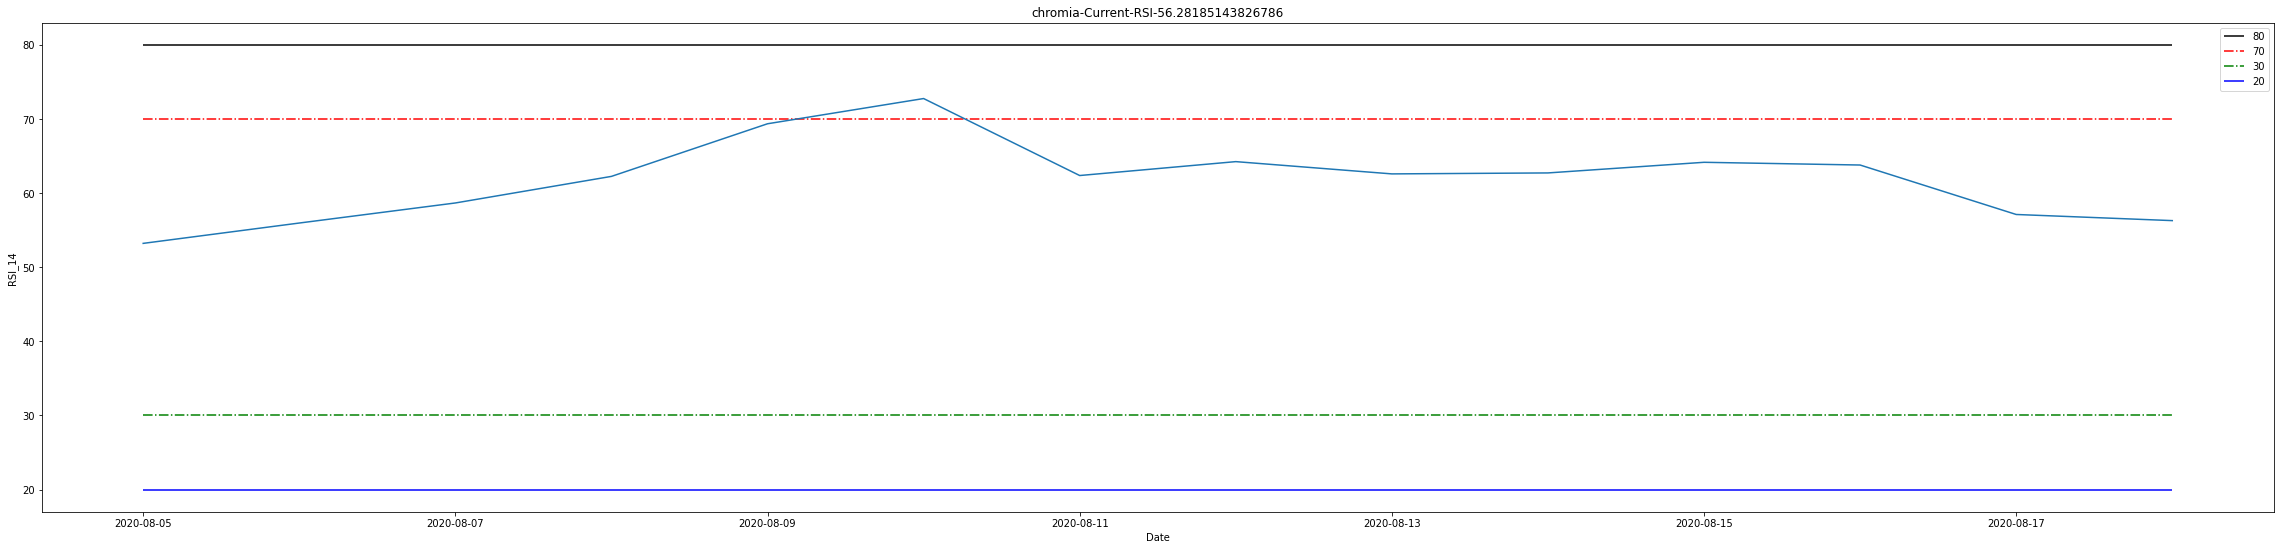

Plotting RSI (49.96046203053401) for:  turtlecoin


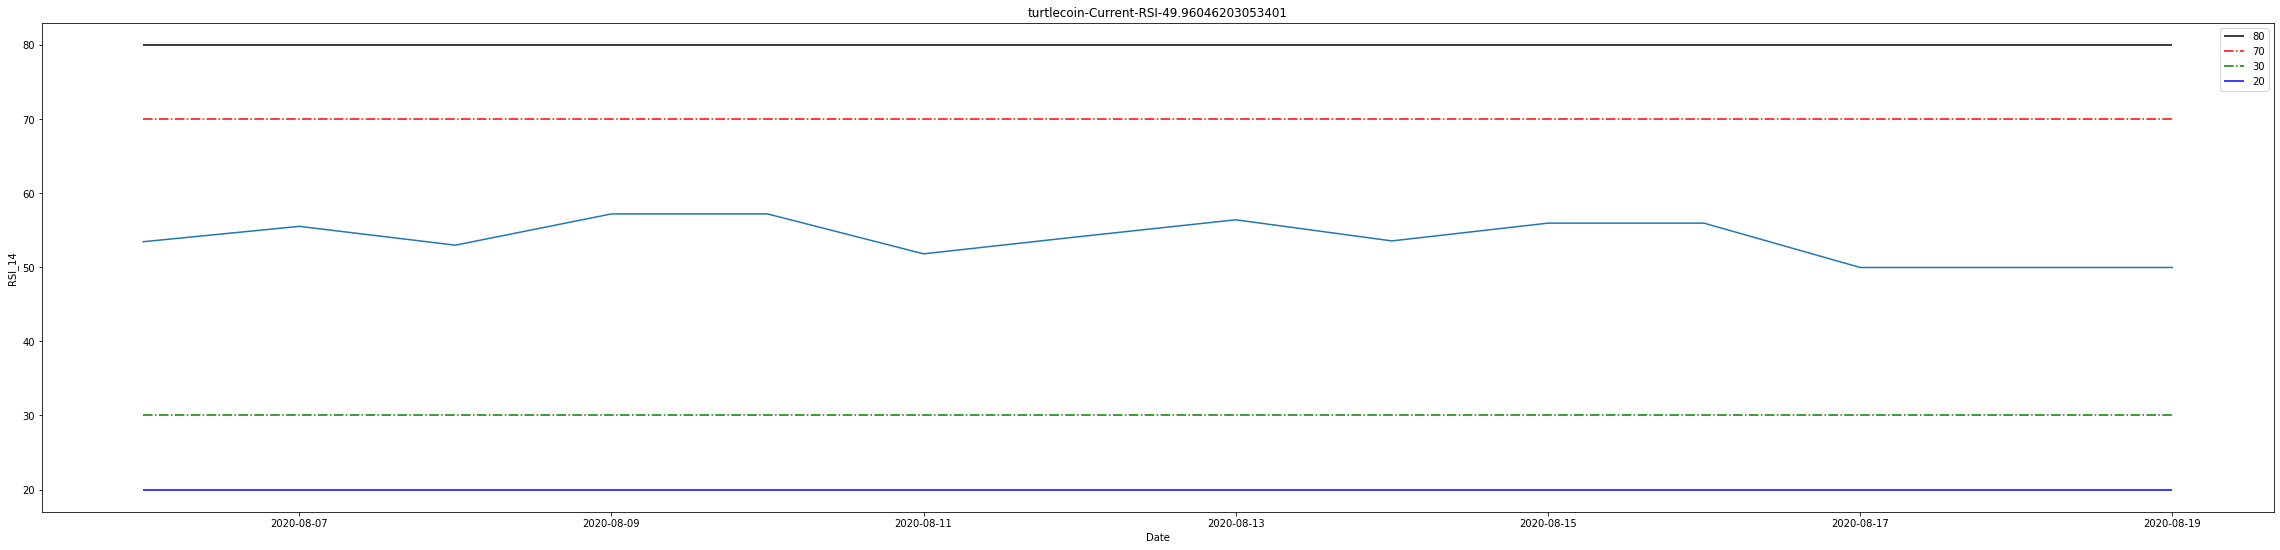

Plotting RSI (55.08281785198368) for:  thekey


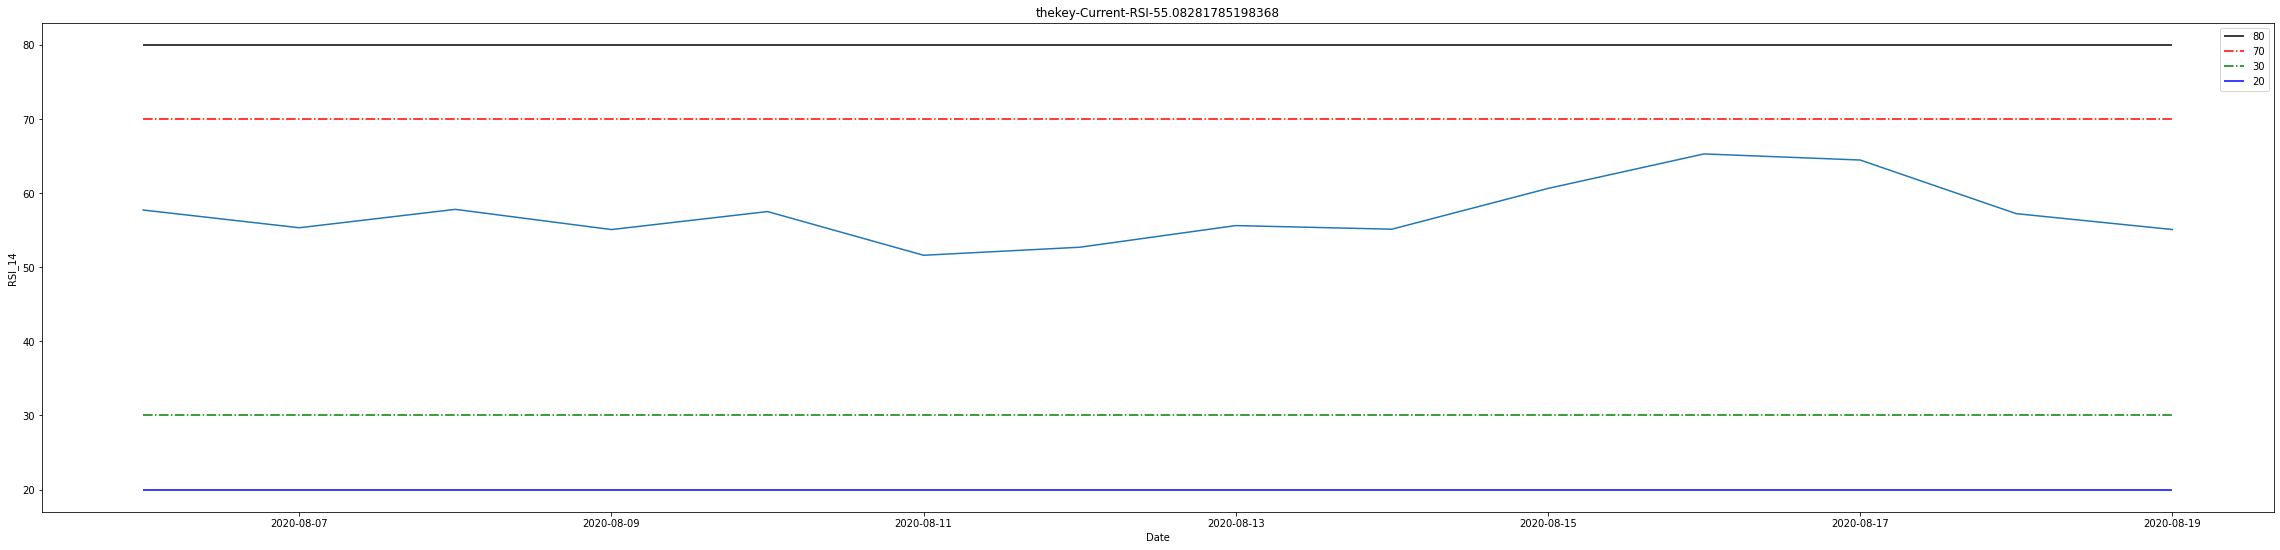

Plotting RSI (39.91717979307883) for:  dero


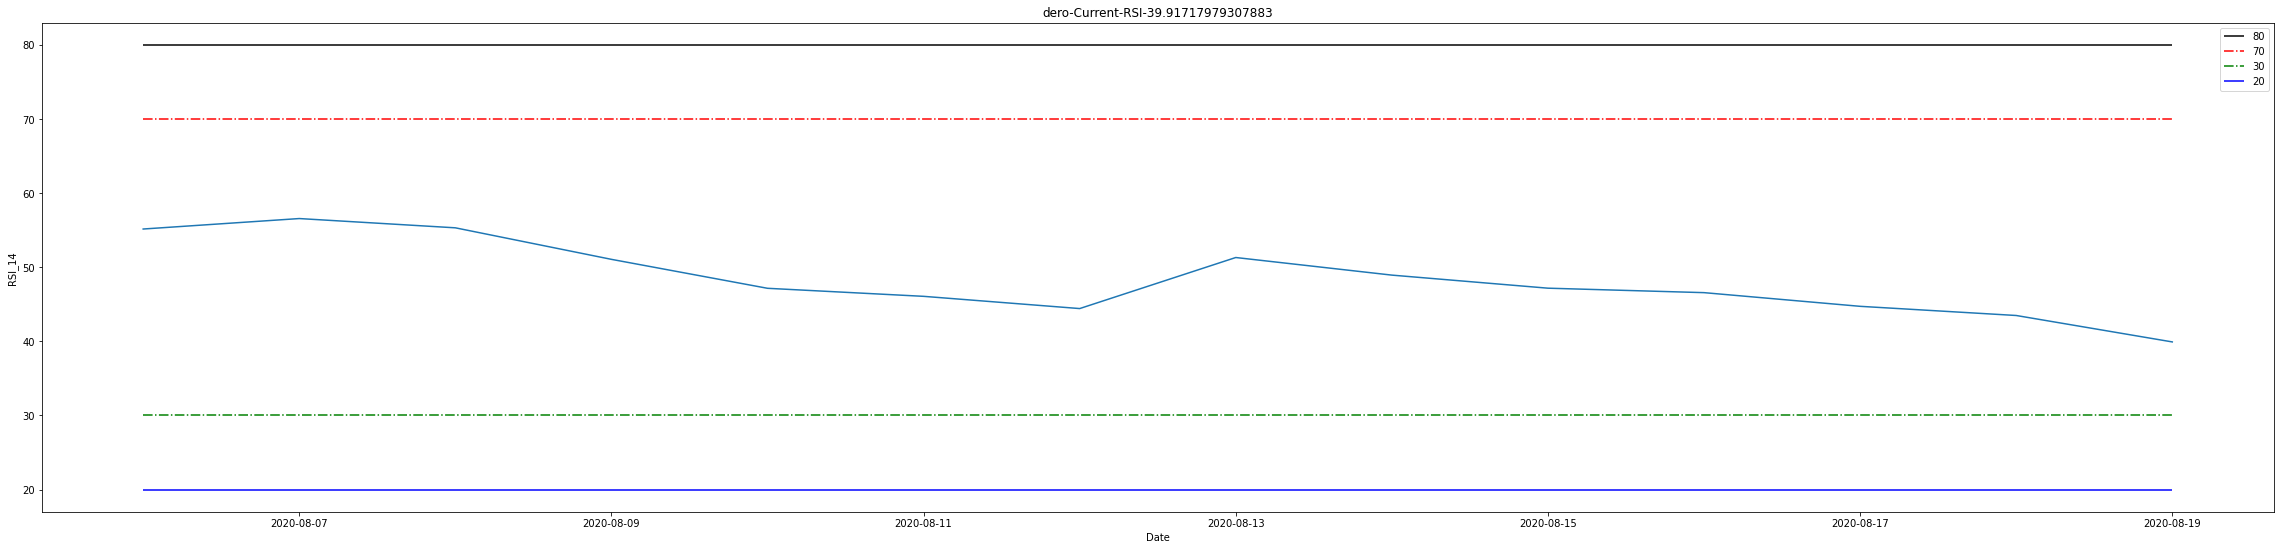

Plotting RSI (70.77755824708177) for:  kucoin-shares


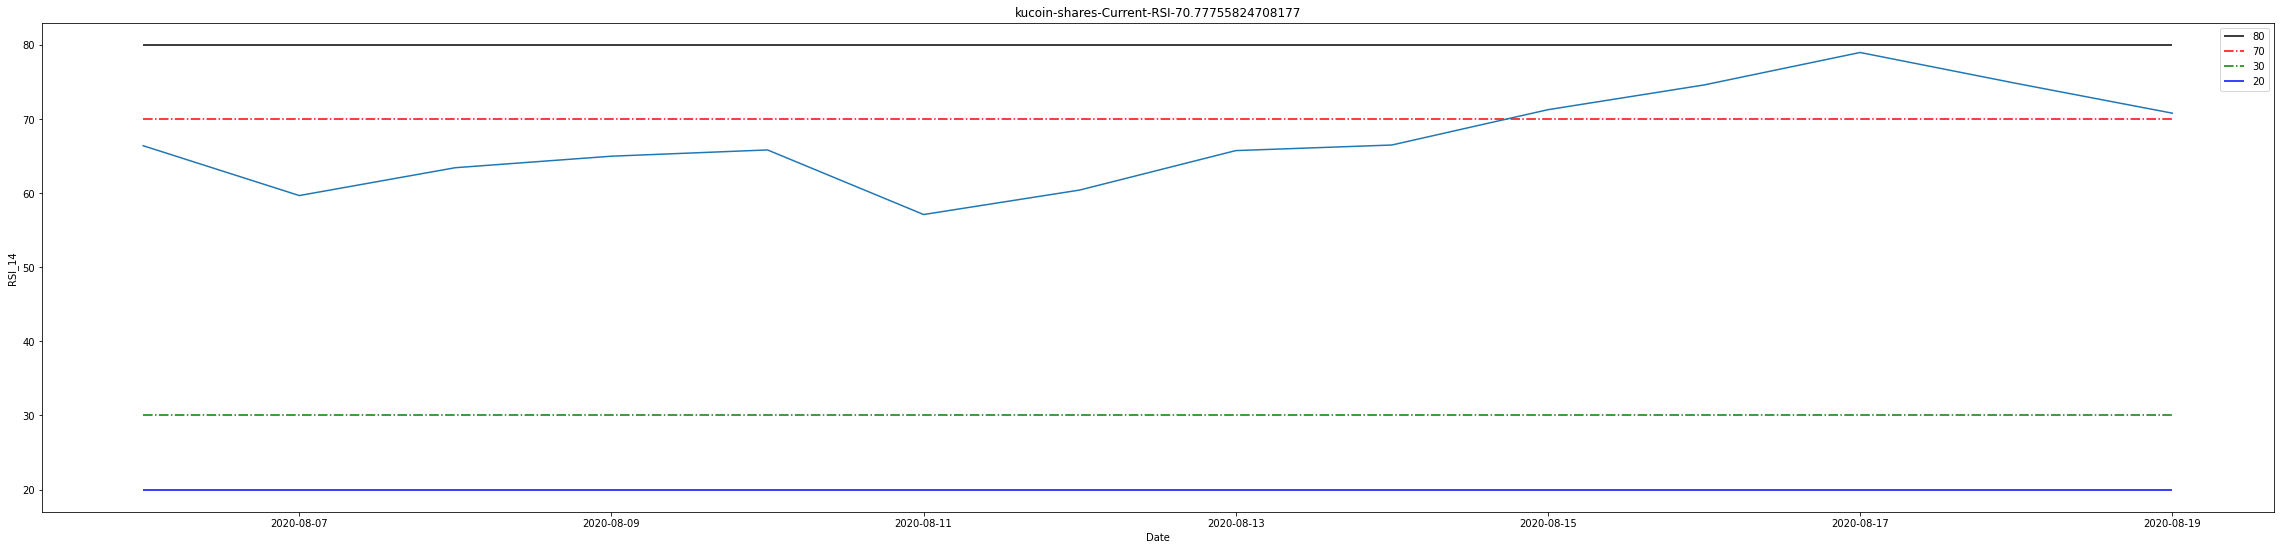

Plotting RSI (62.037948574935534) for:  alchemy


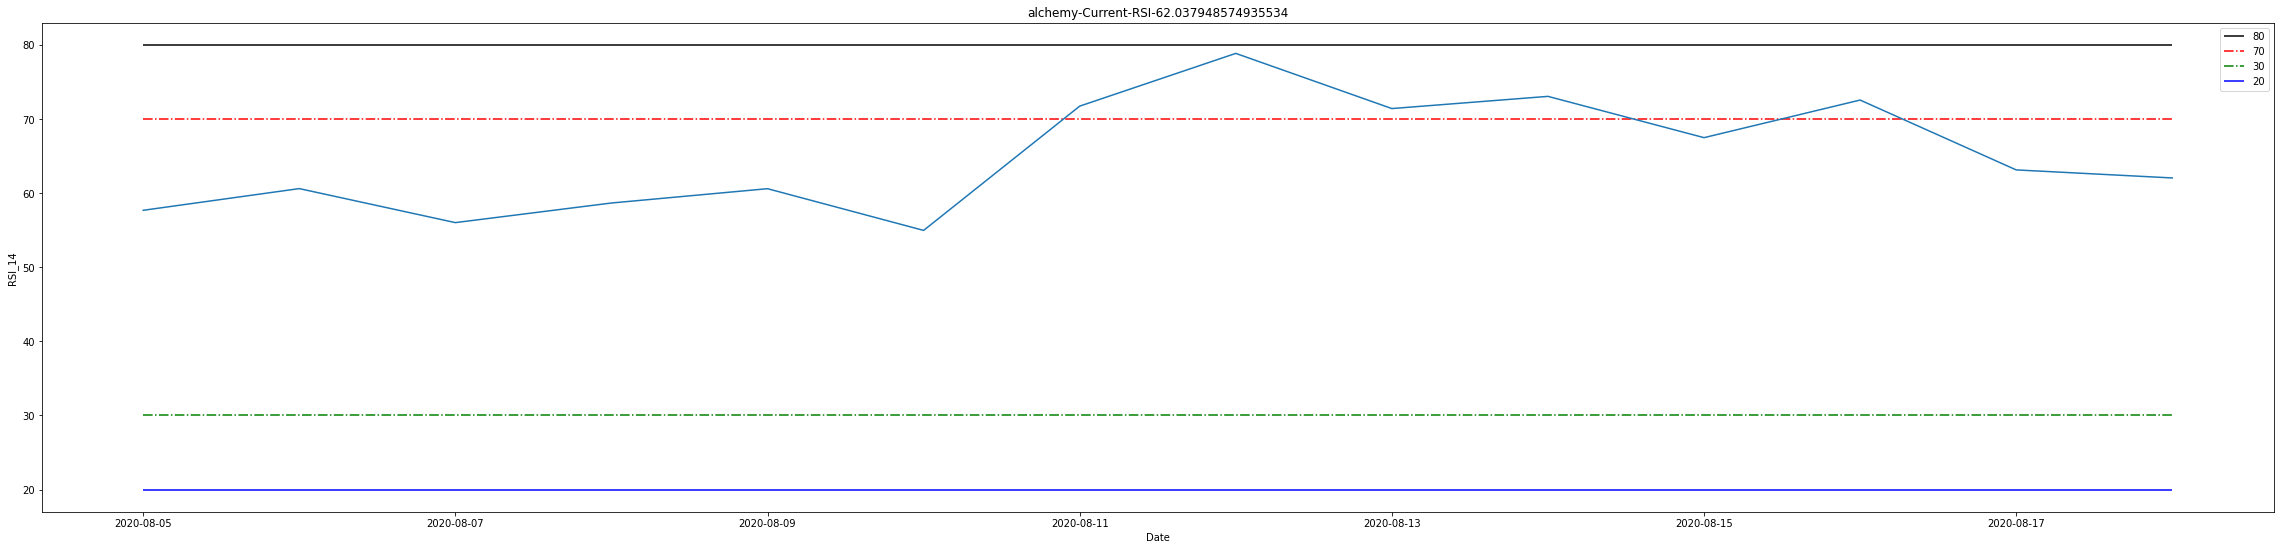

Plotting RSI (49.233297714284845) for:  dash


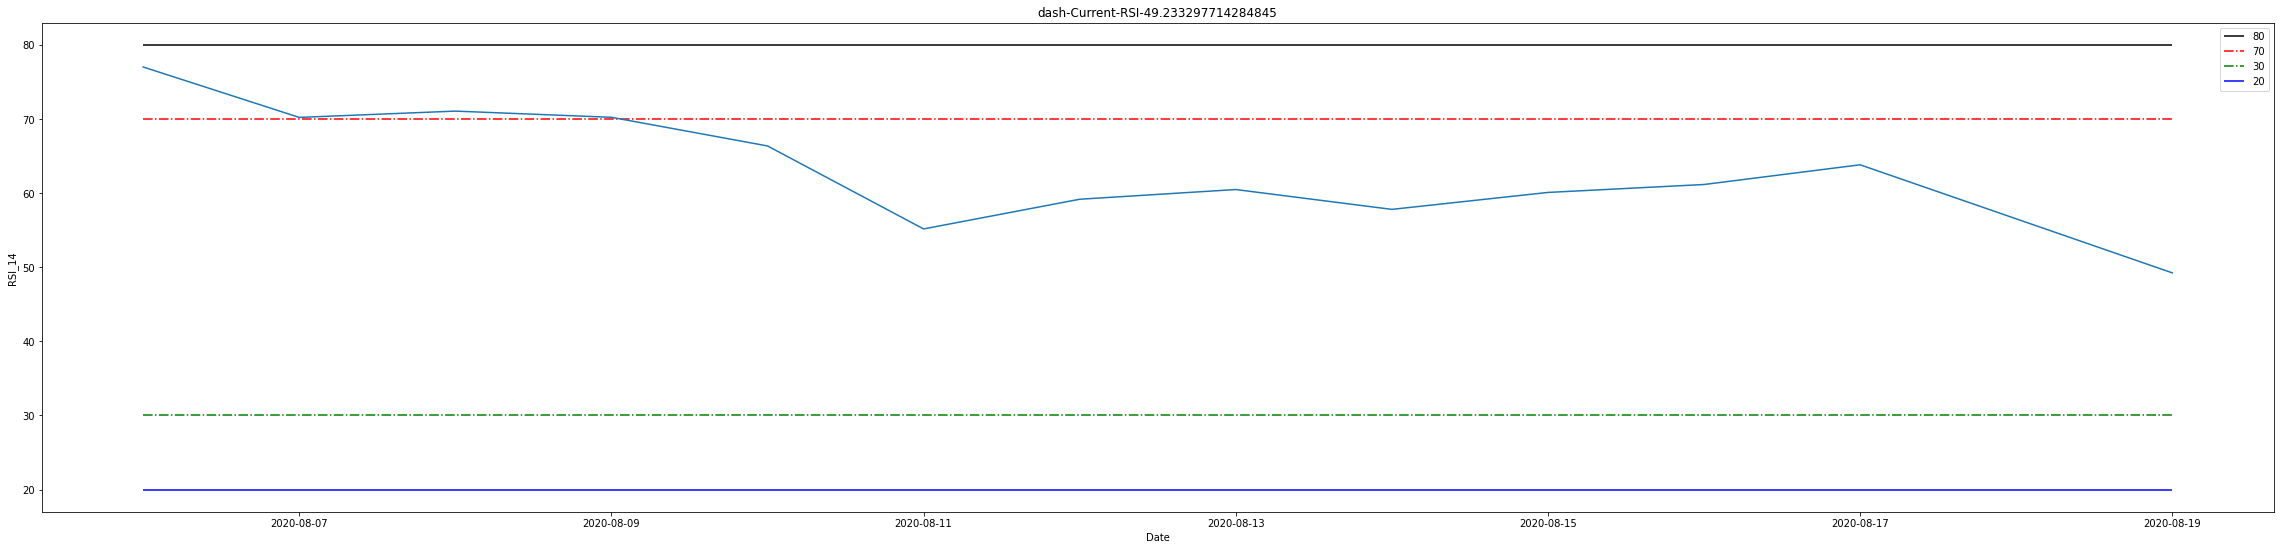

Plotting RSI (57.17445510214952) for:  silent-notary


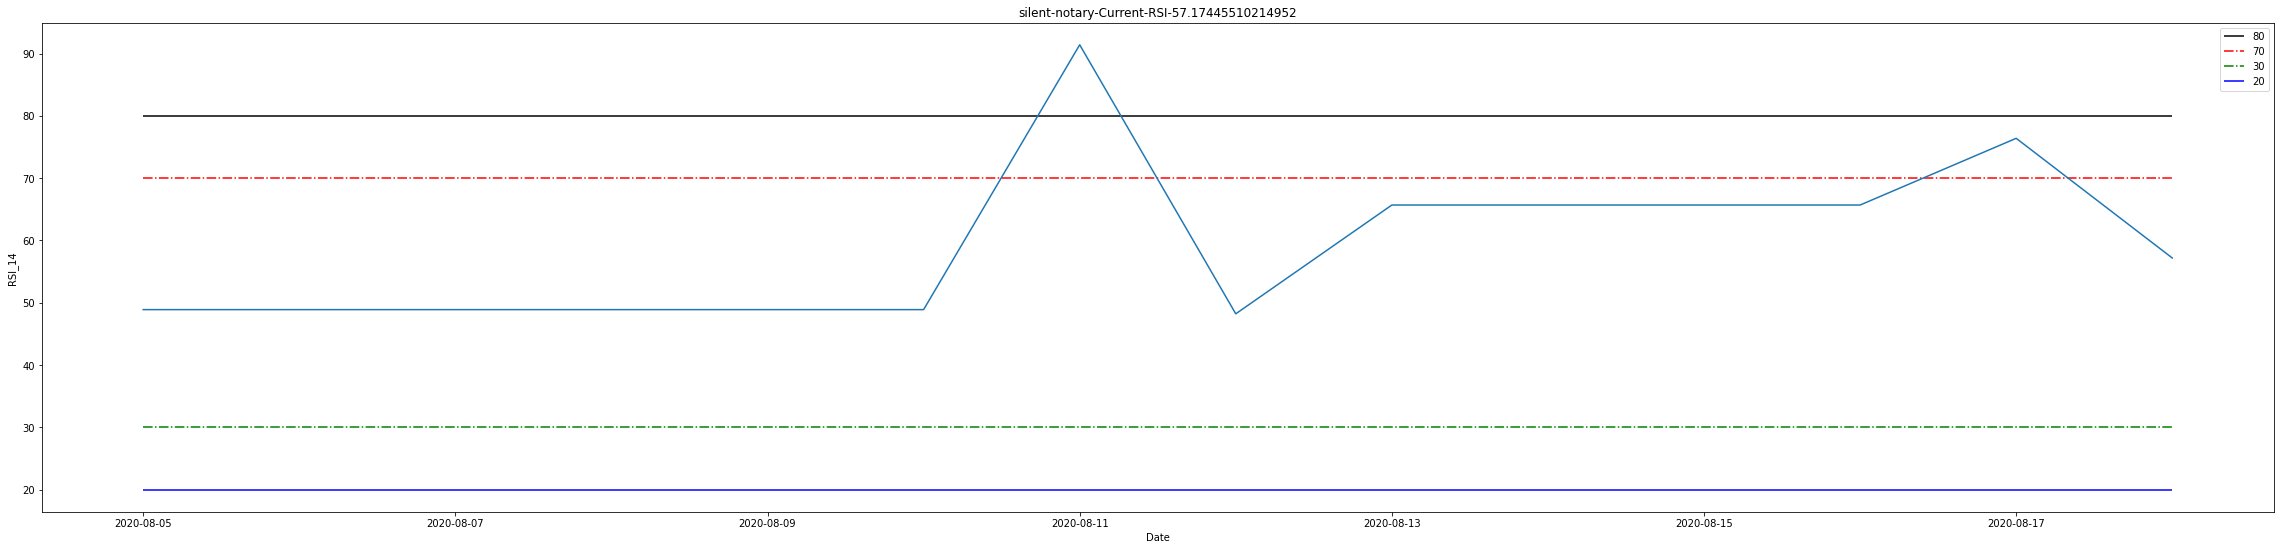

Plotting RSI (60.11481149270406) for:  dragonchain


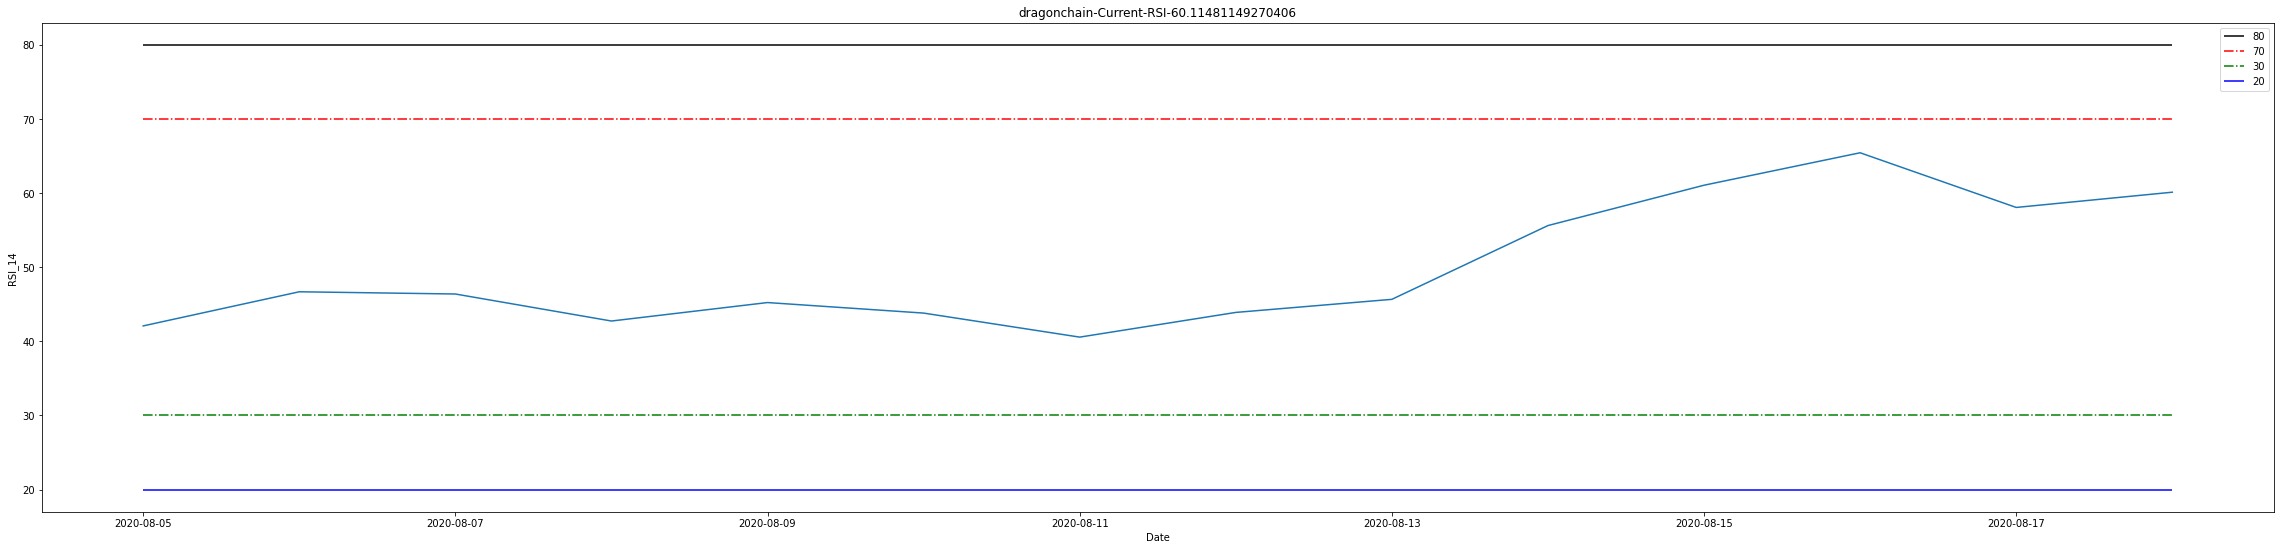

Plotting RSI (55.434548856400696) for:  cryptoindex-com-100


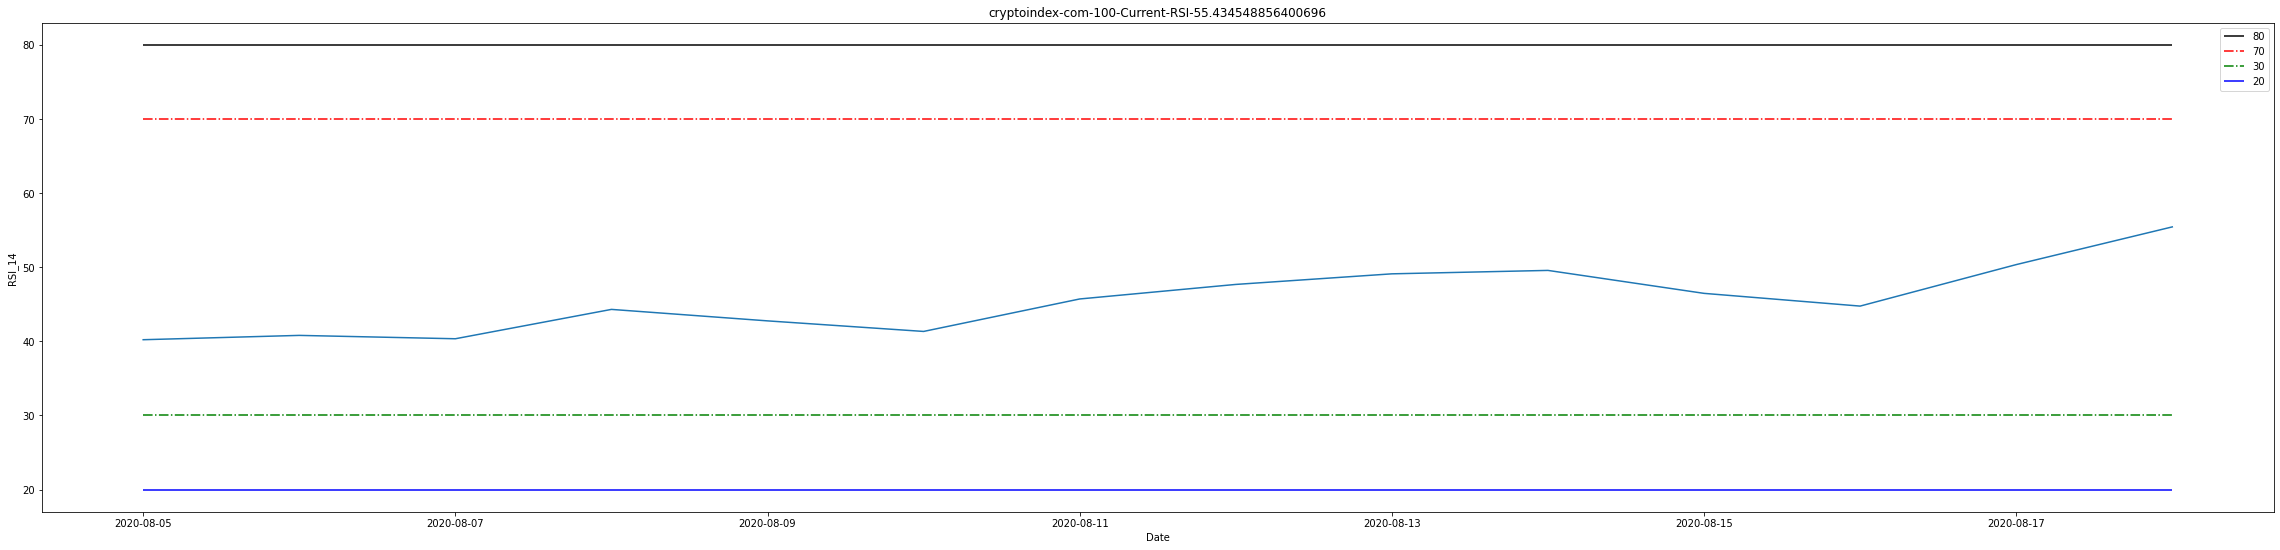

Plotting RSI (65.8508724292012) for:  xrp


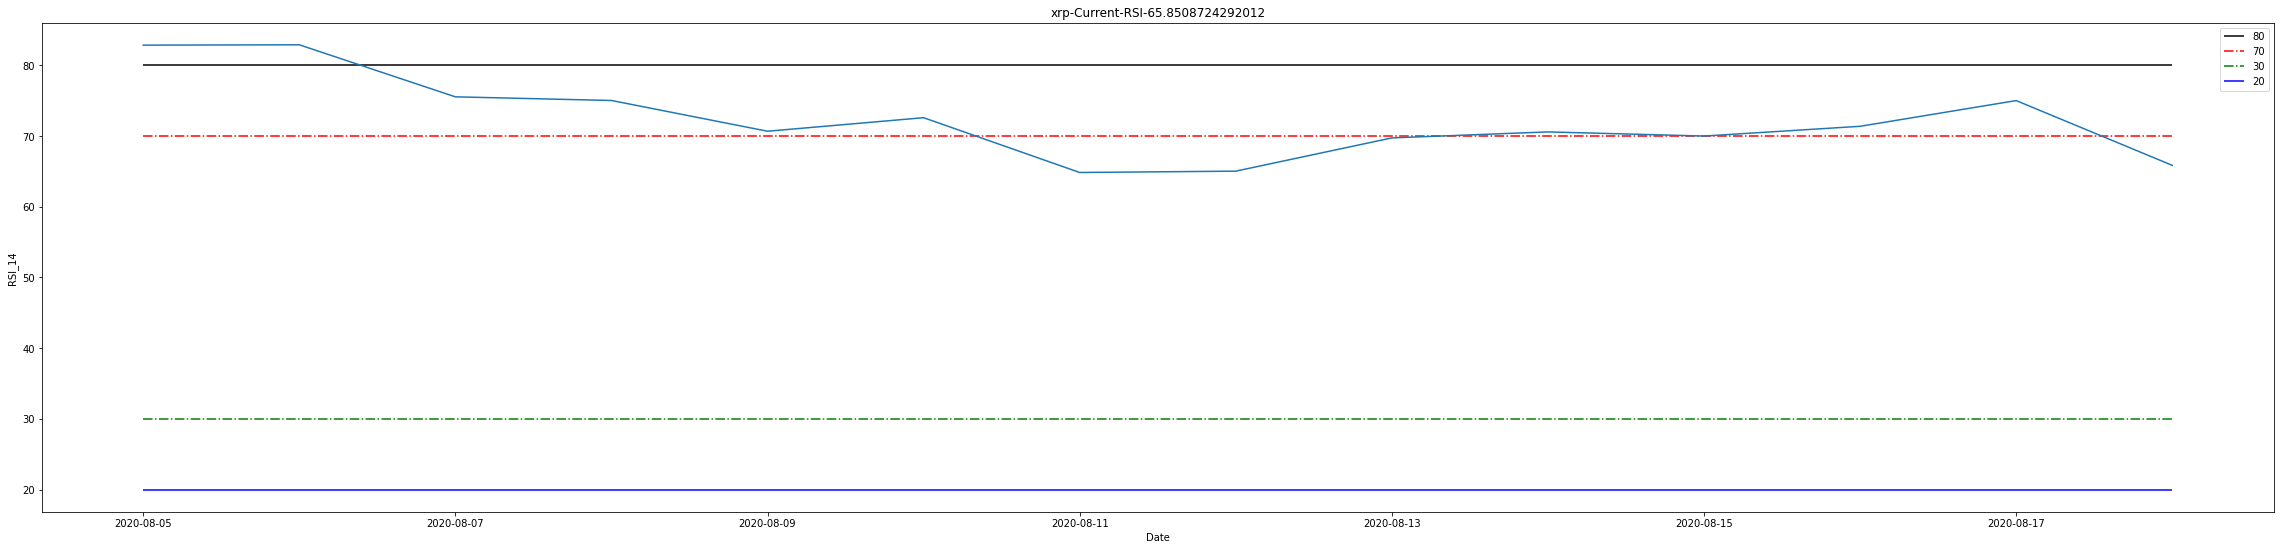

Plotting RSI (43.49675708841585) for:  adbank


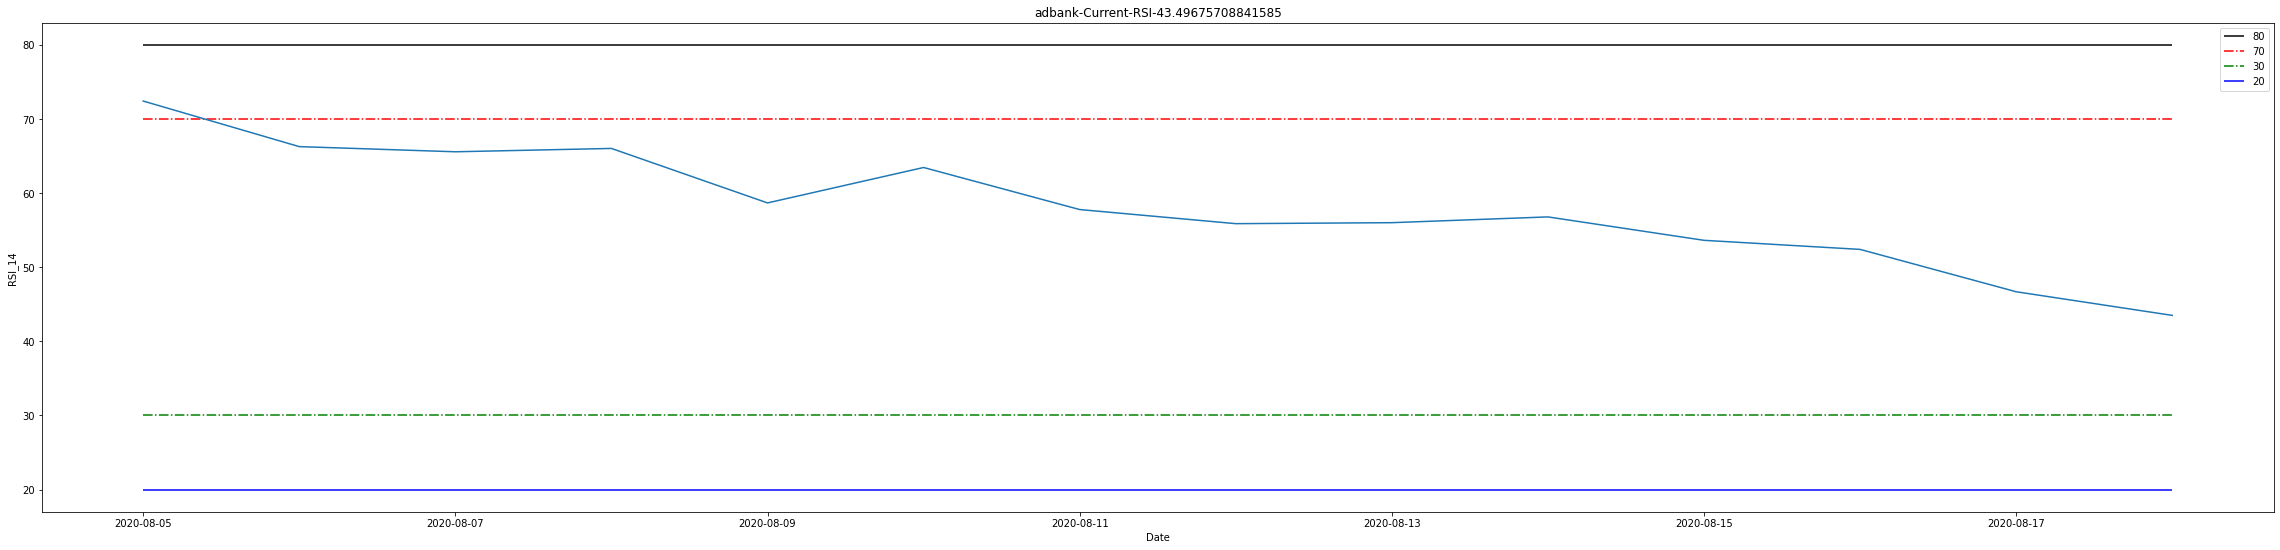

Plotting RSI (61.370261338162706) for:  pivx


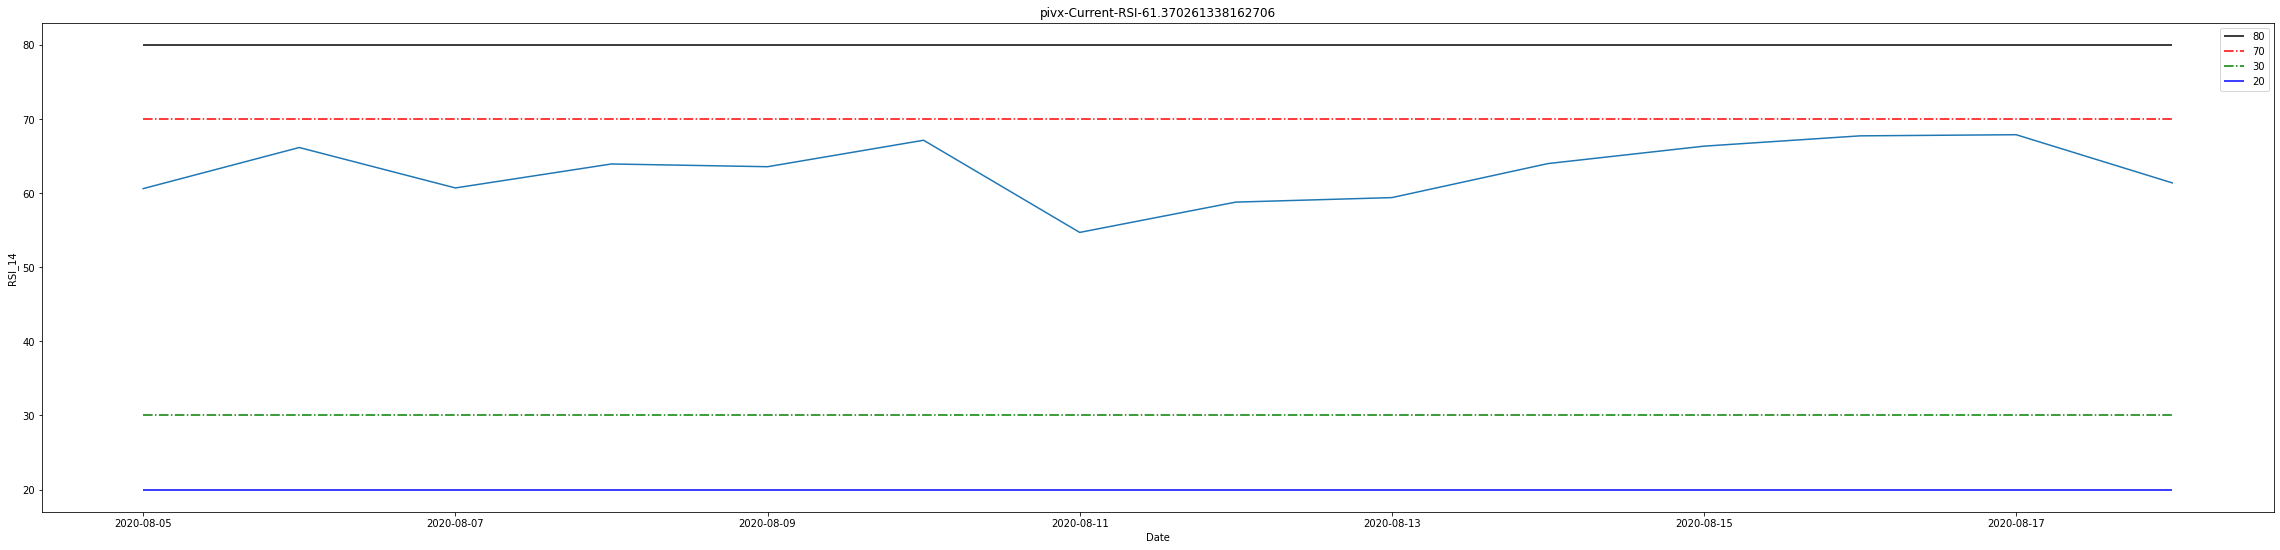

Plotting RSI (49.16024471062082) for:  grin


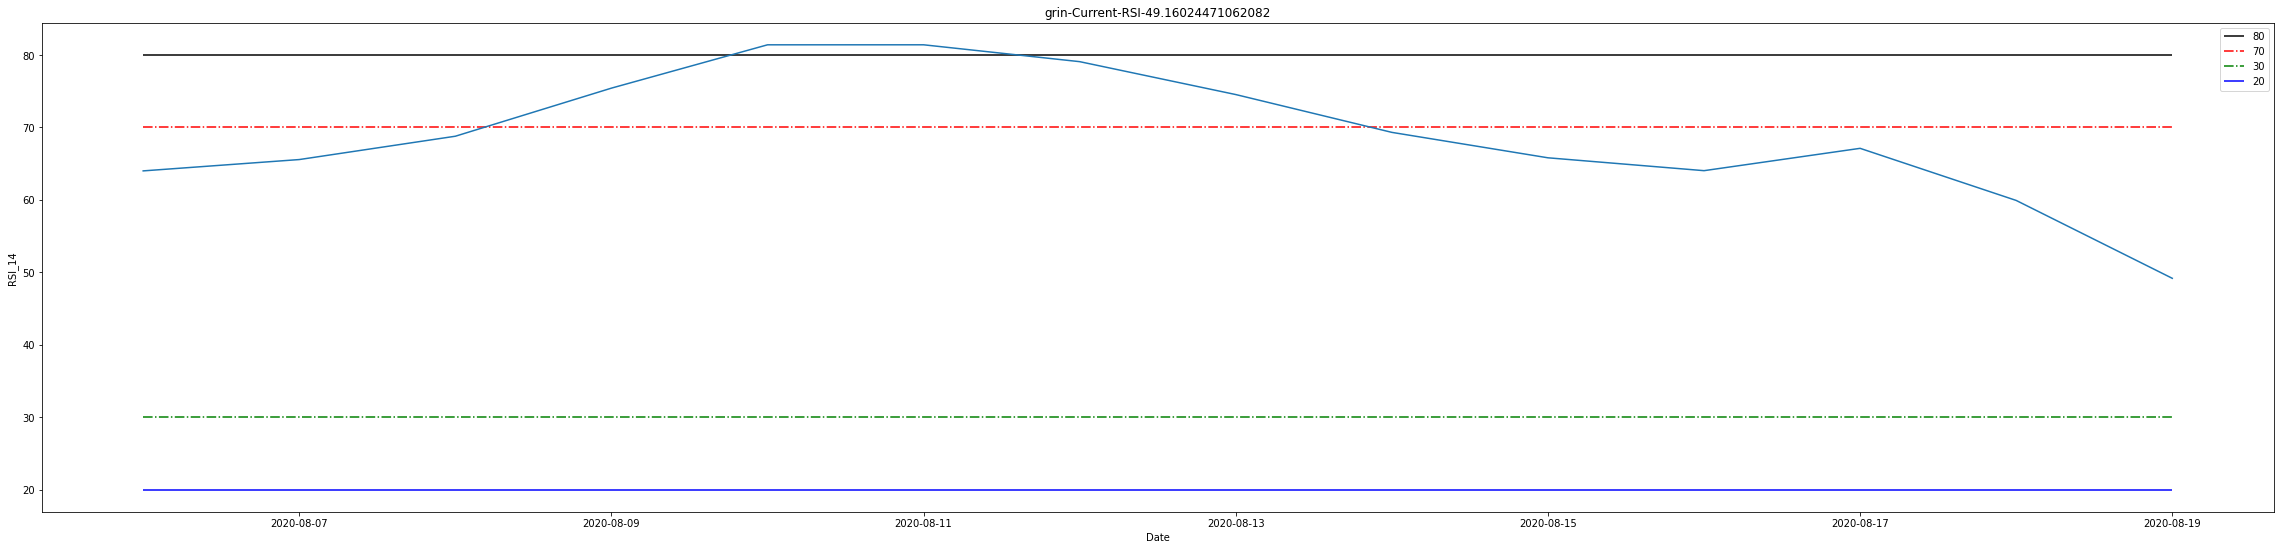

Plotting RSI (49.63590855617123) for:  cpchain


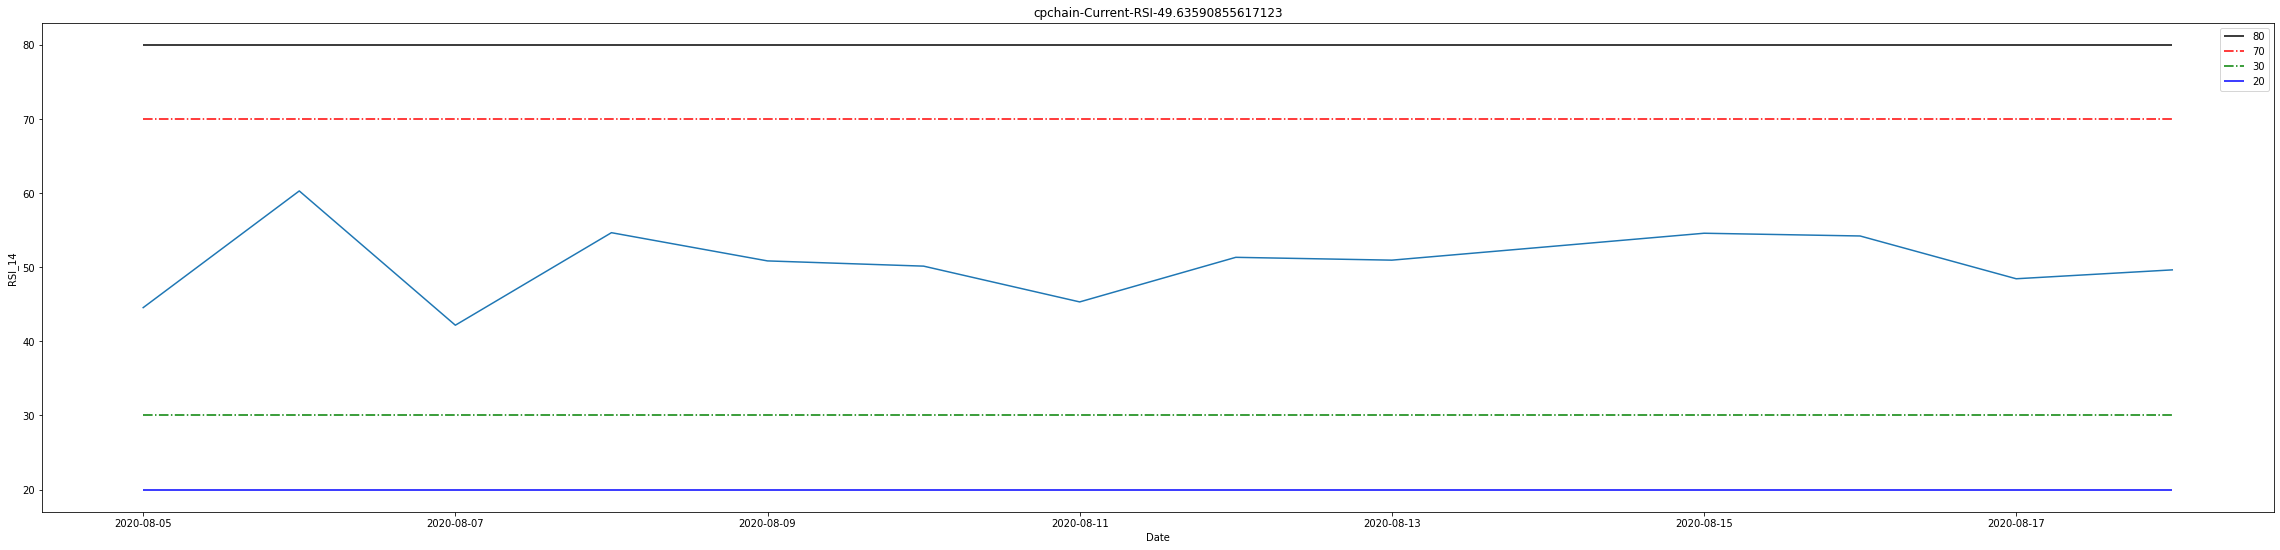

Plotting RSI (53.52661505959469) for:  suterusu


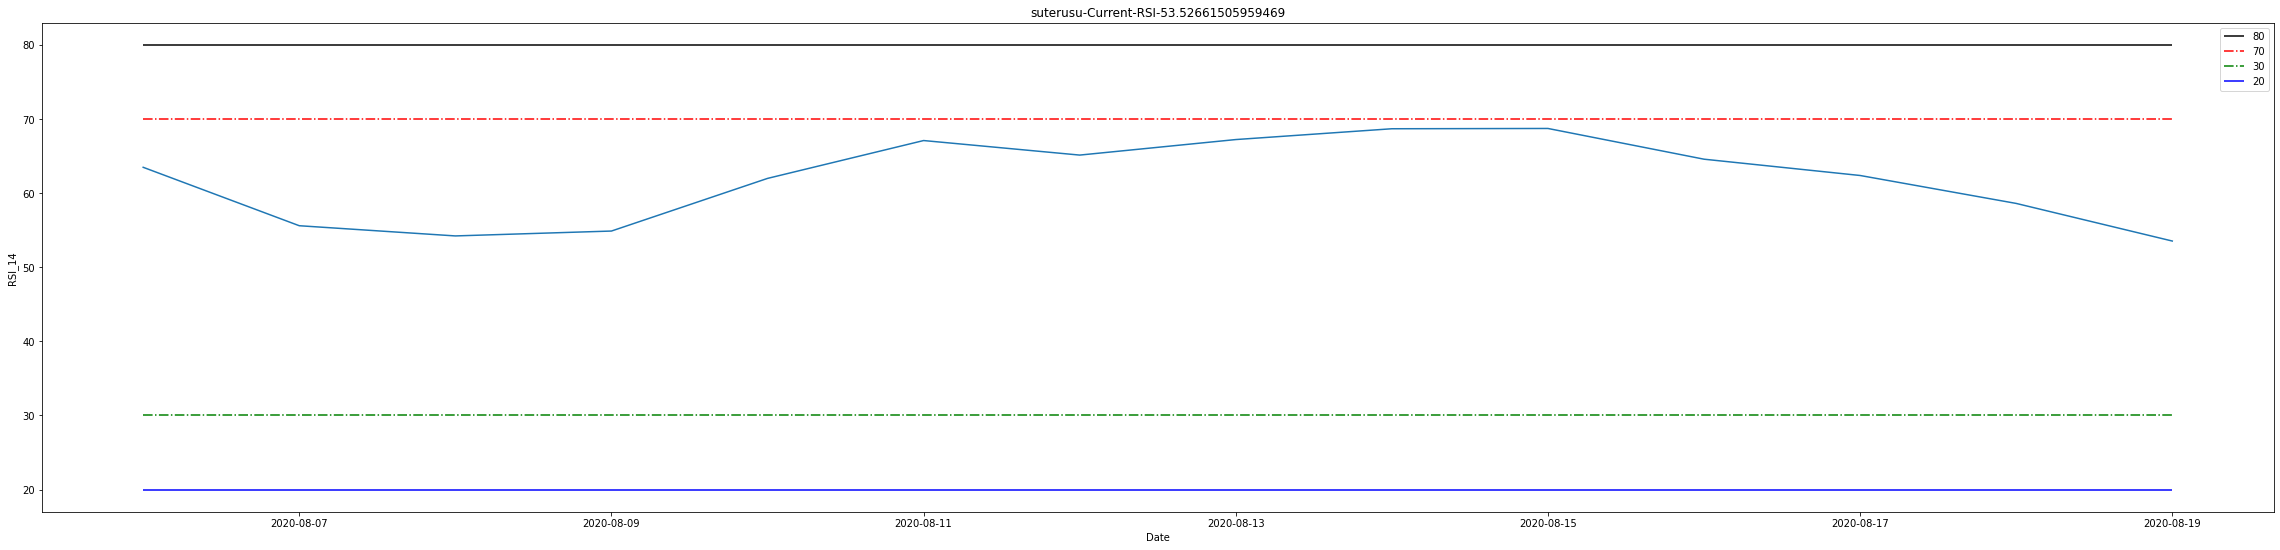

Plotting RSI (49.70484369012023) for:  stellar


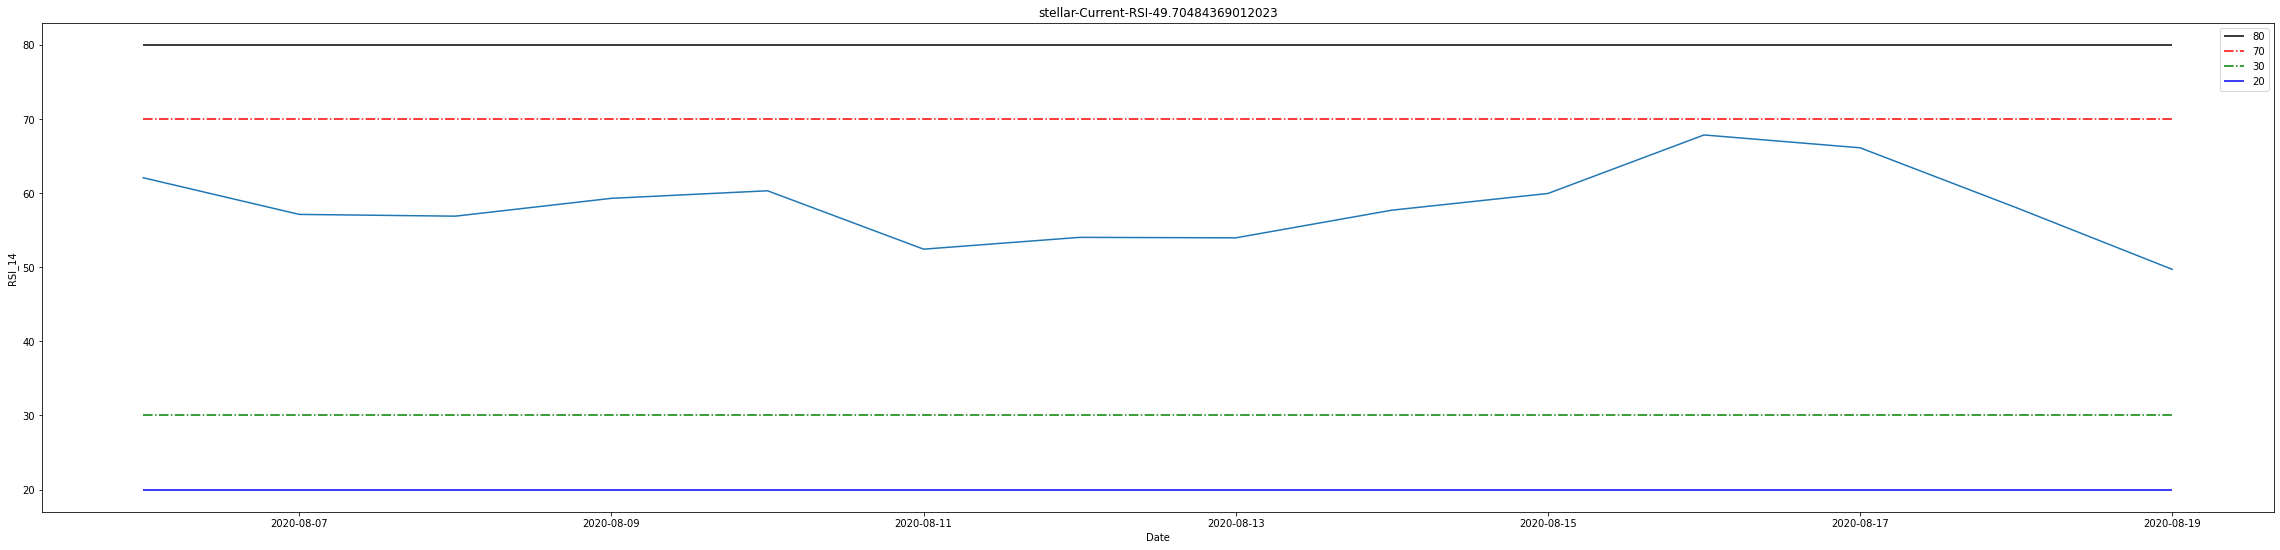

Plotting RSI (66.40256288767273) for:  iostoken


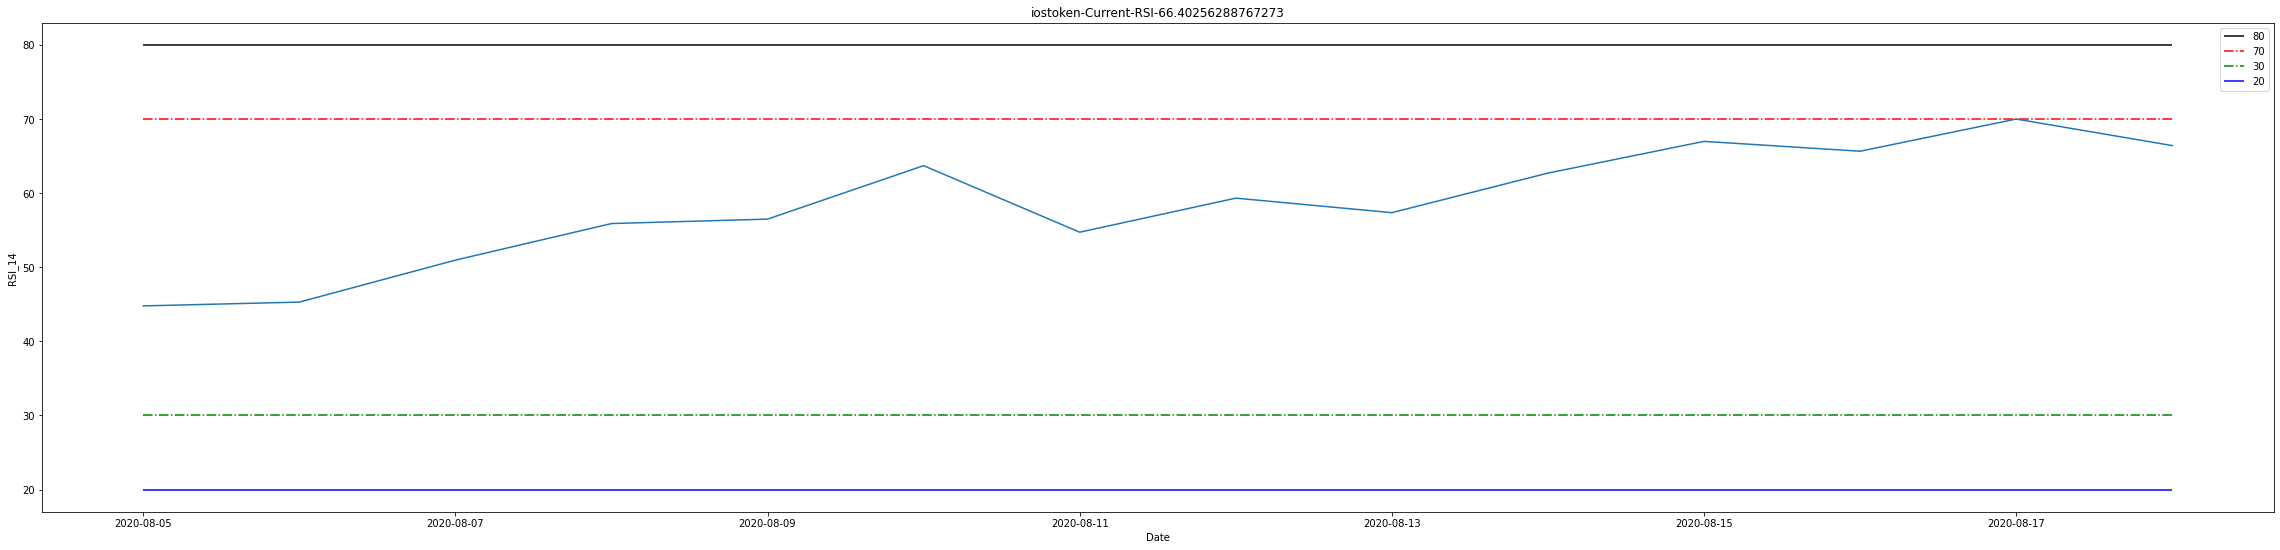

Plotting RSI (38.14992043695266) for:  doc-com


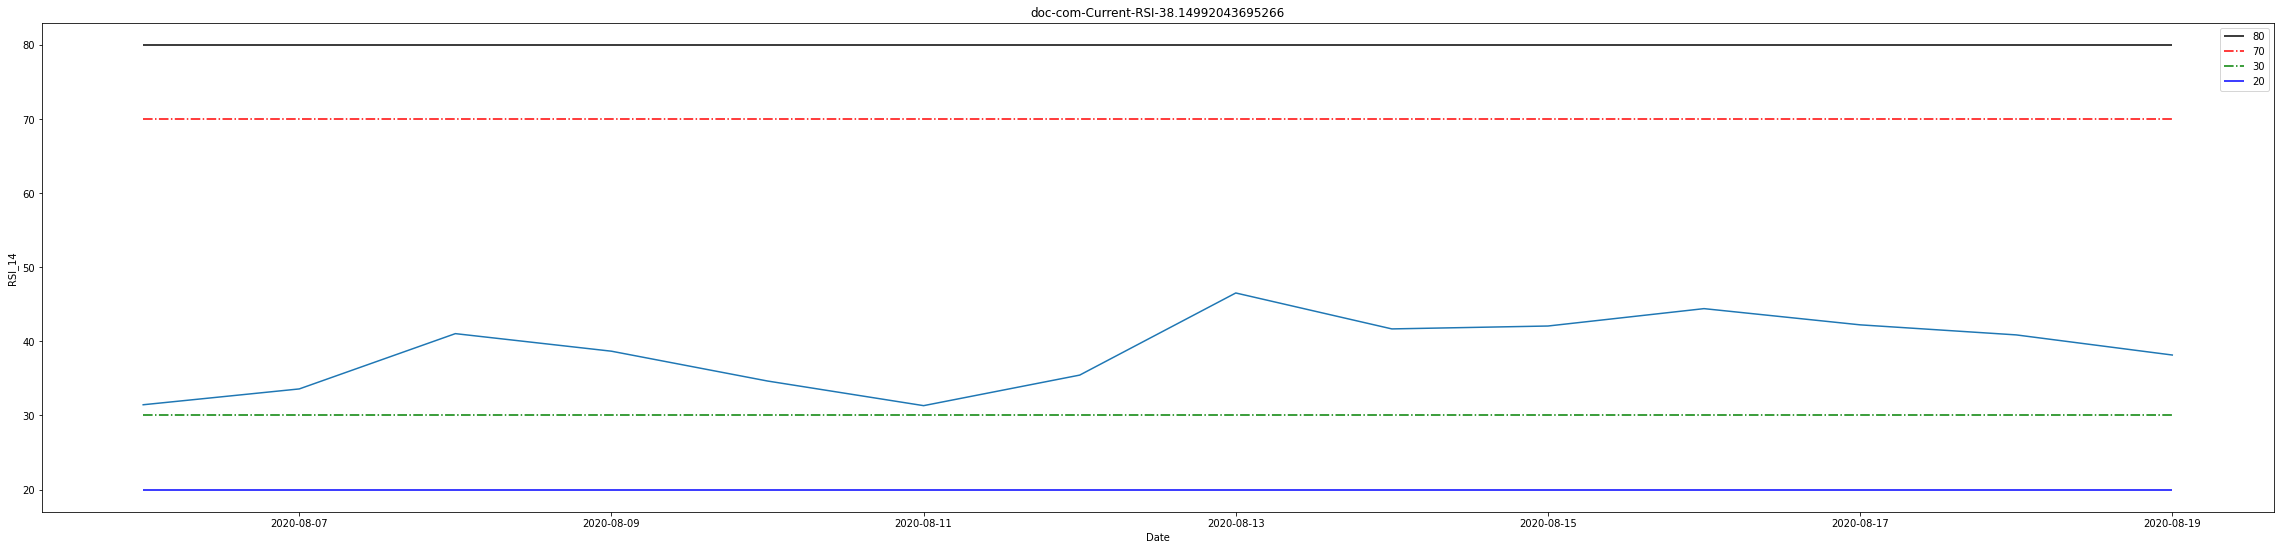

Plotting RSI (52.01893261473113) for:  tomochain


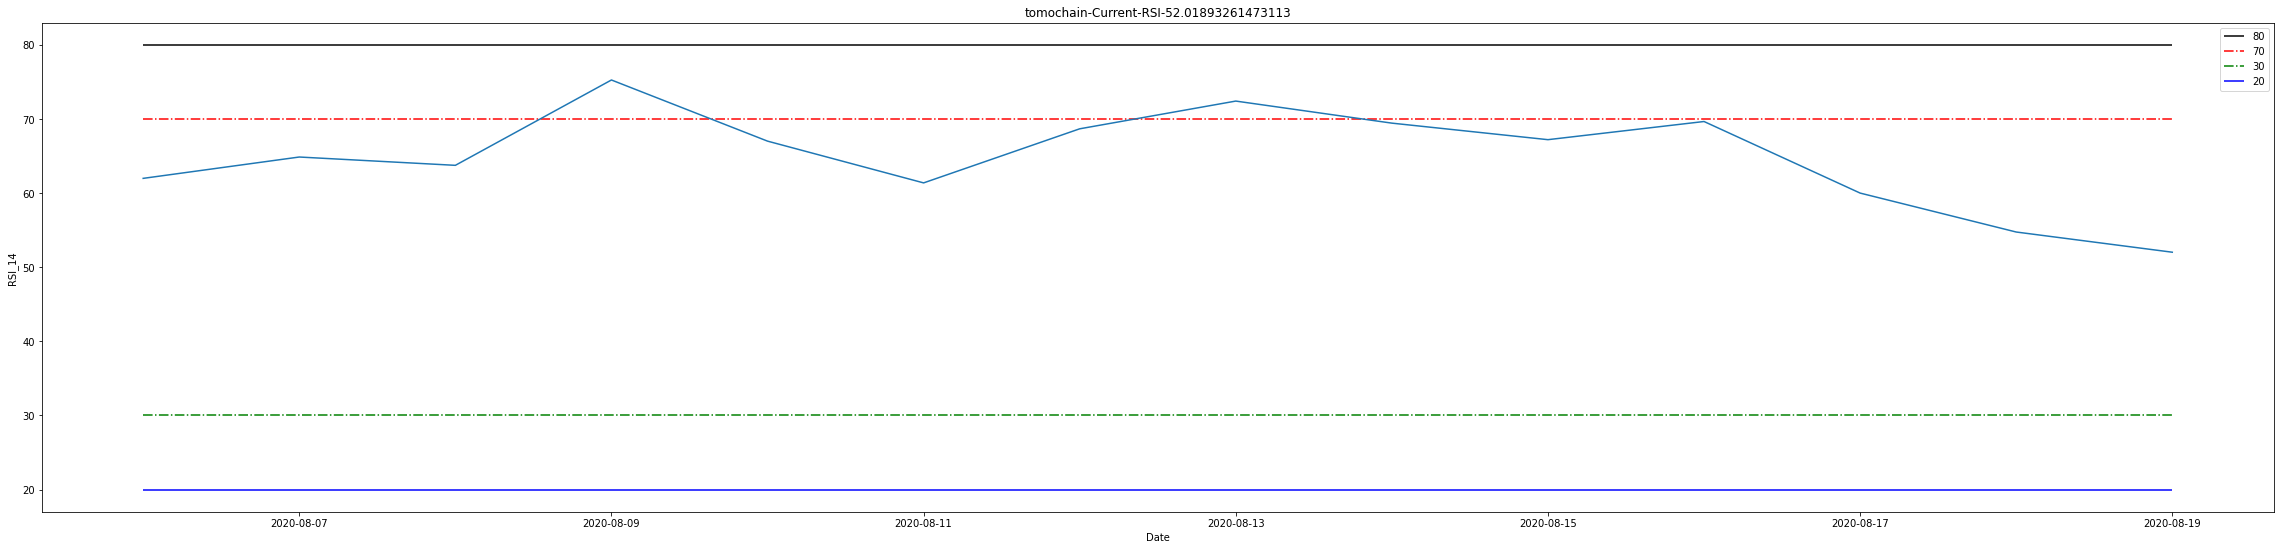

Plotting RSI (53.674086922910064) for:  merculet


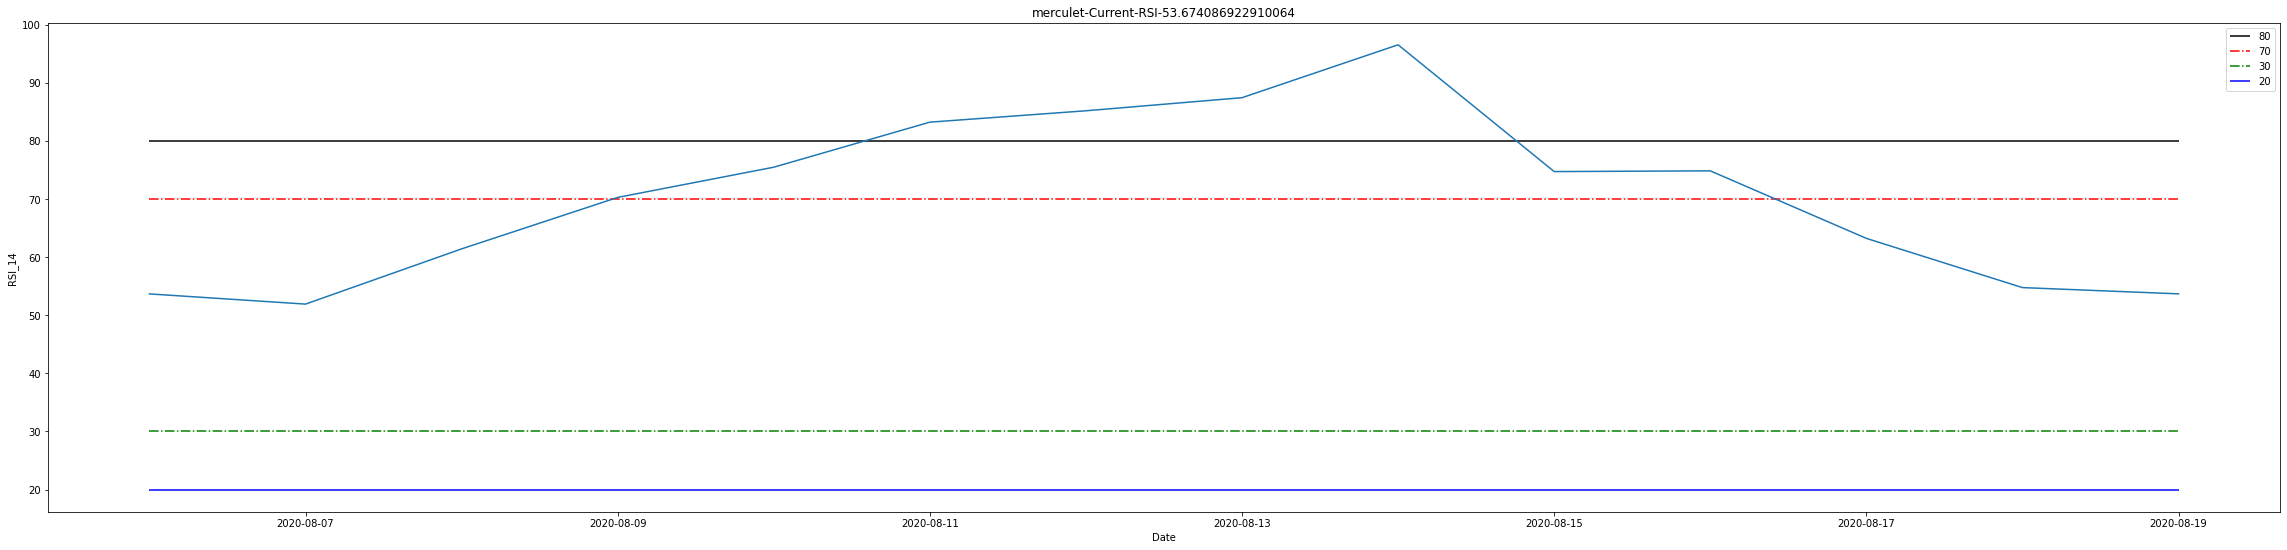

Plotting RSI (39.05446164936485) for:  ampleforth


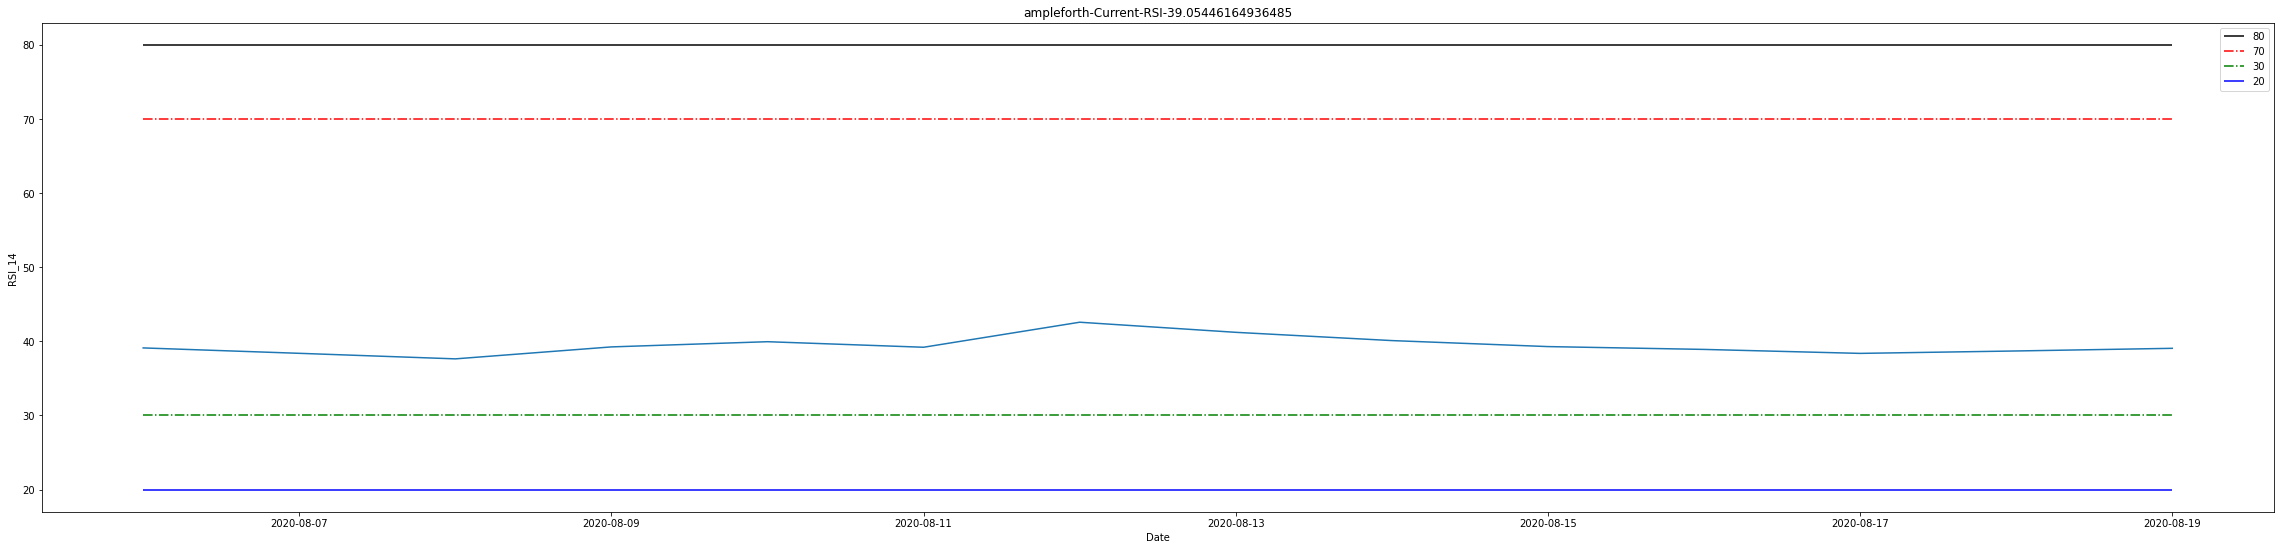

Plotting RSI (56.475204790966956) for:  decentraland


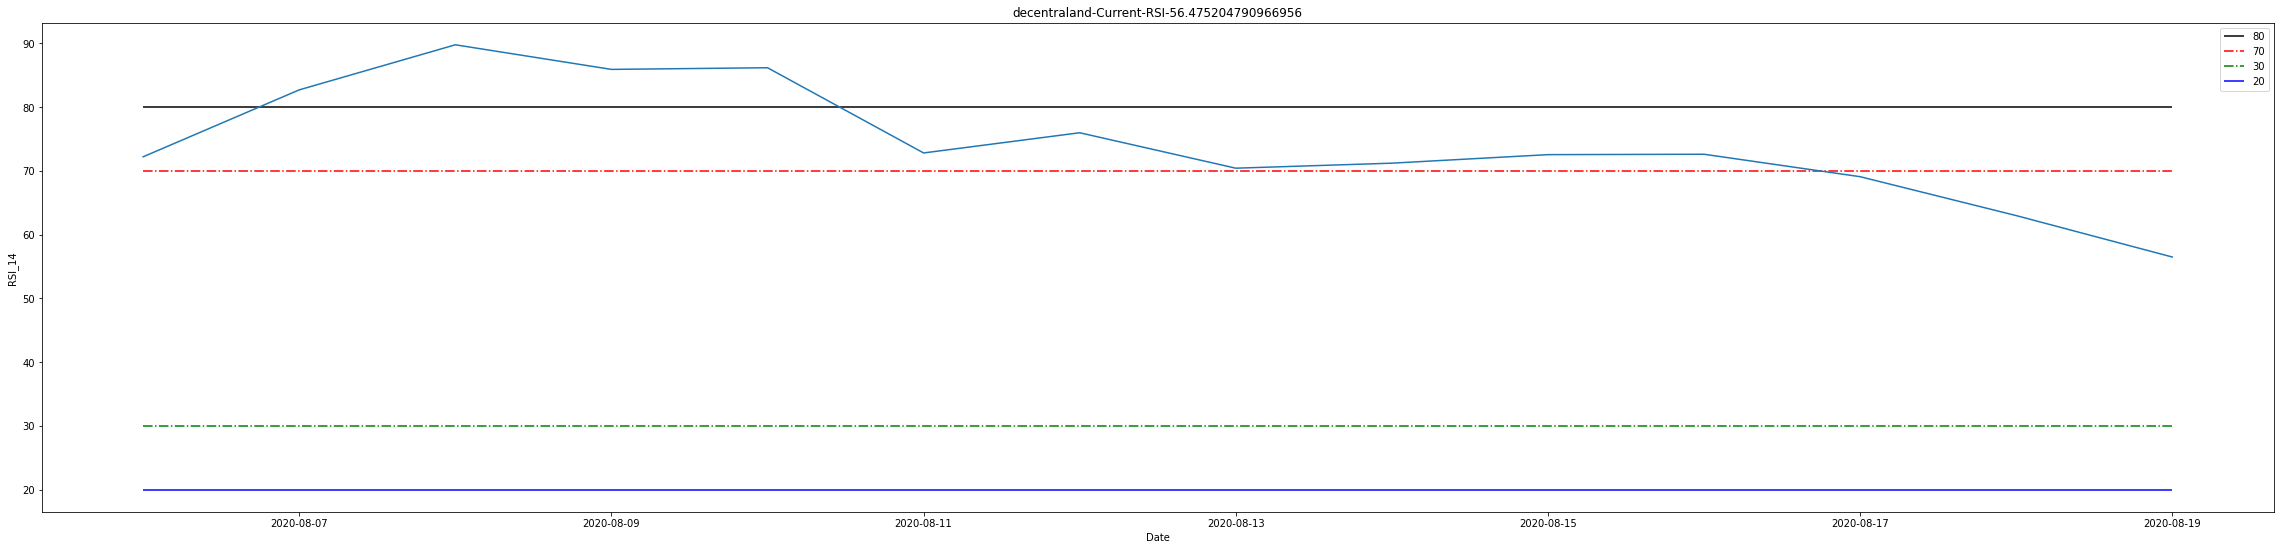

Plotting RSI (74.00214615729905) for:  bns-token


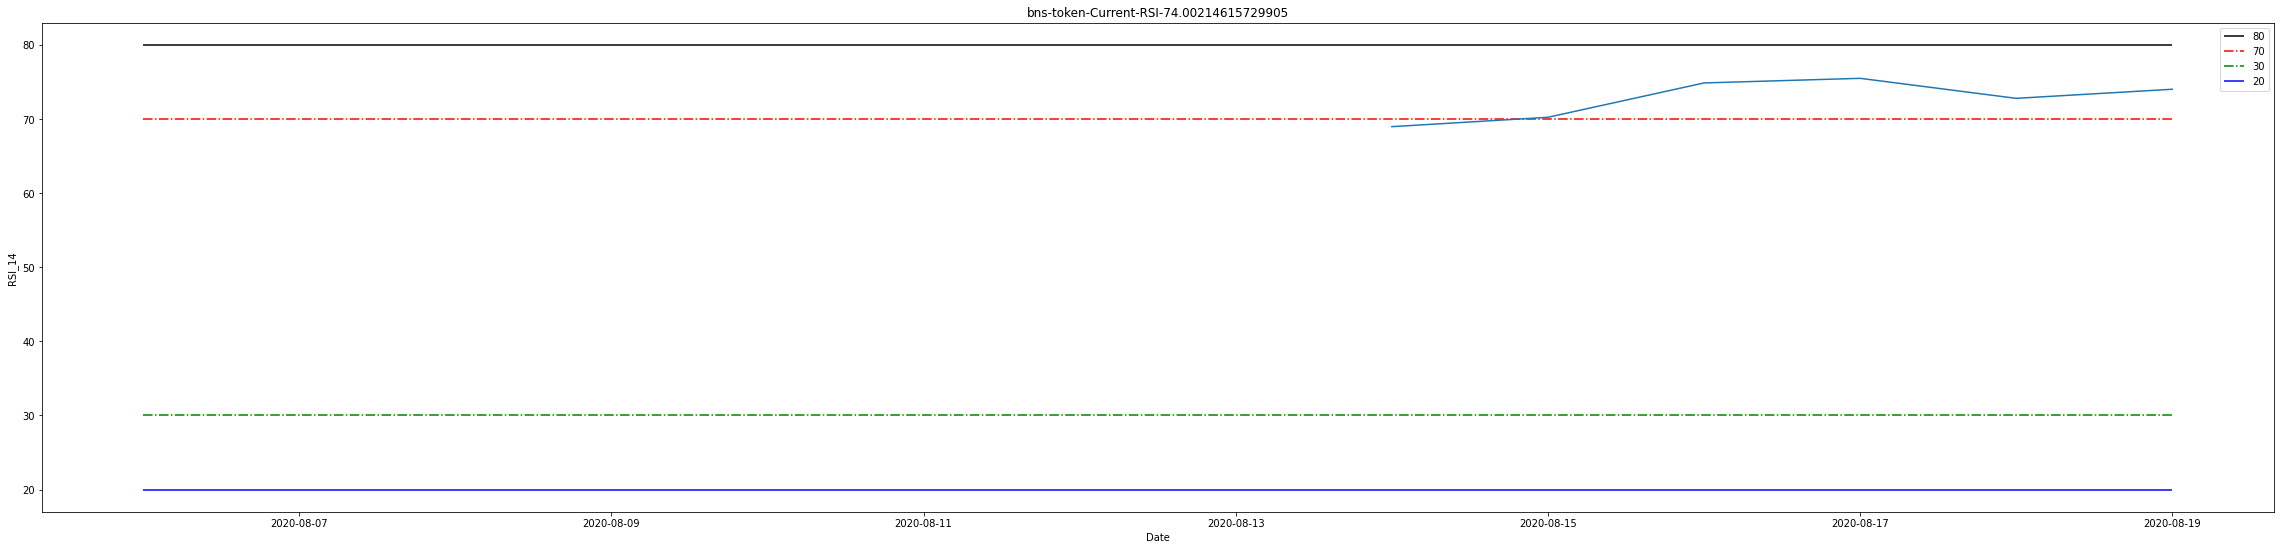

Plotting RSI (49.01939715179854) for:  amino-network


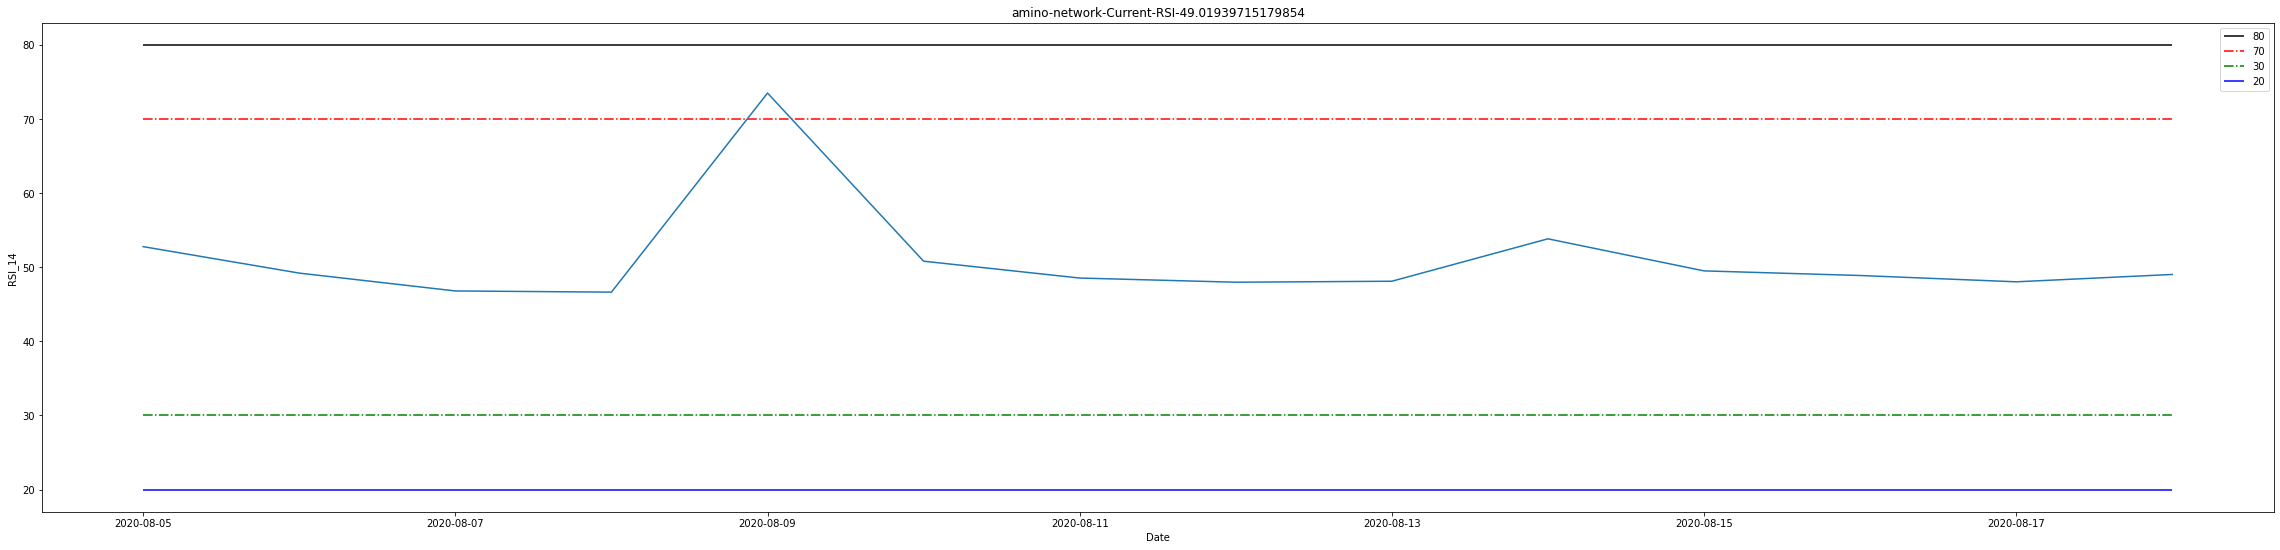

Plotting RSI (38.53863445115316) for:  vid


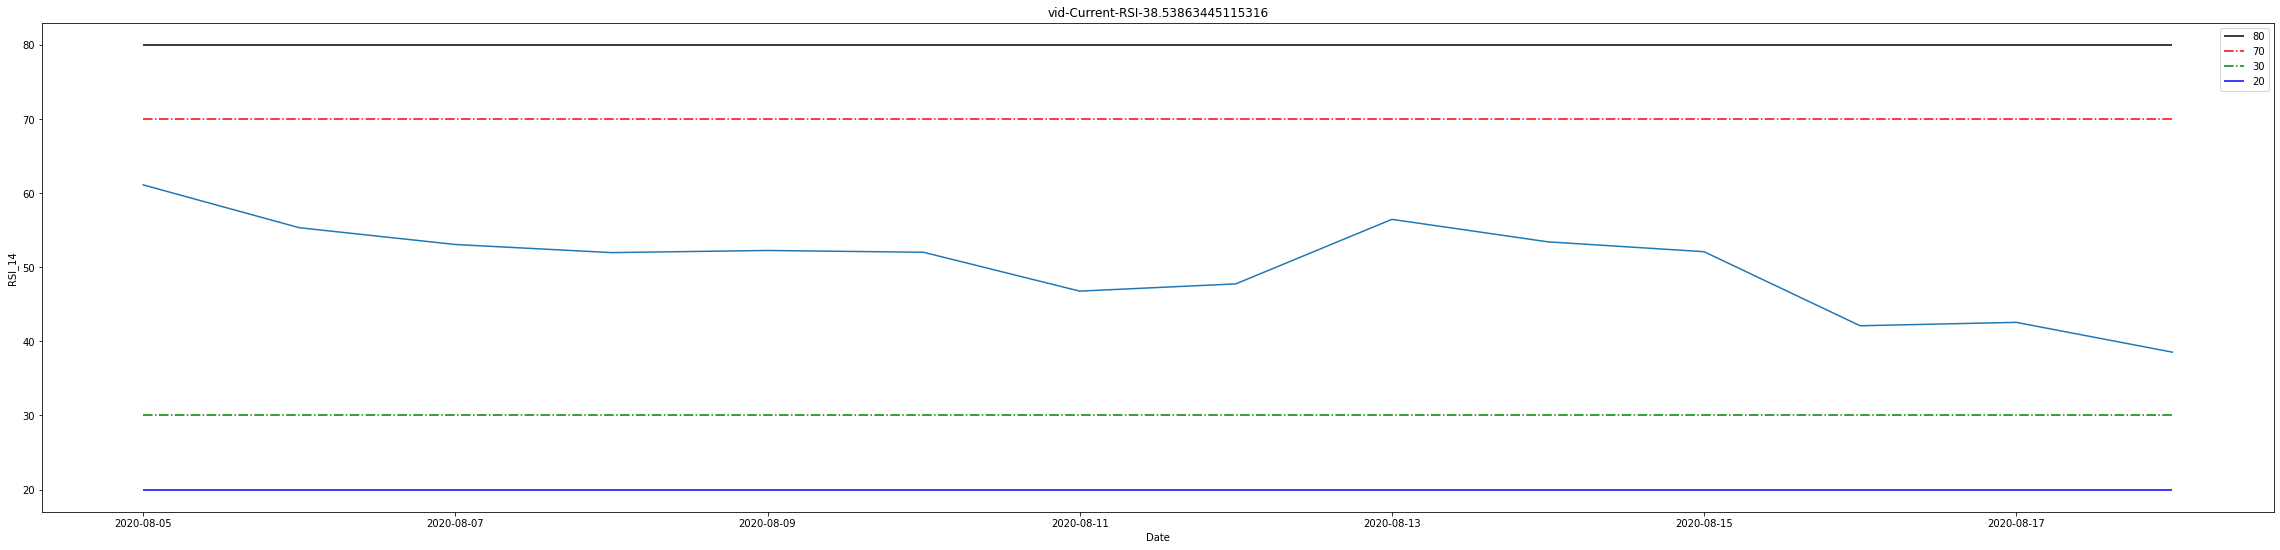

Plotting RSI (56.18343248682629) for:  revain


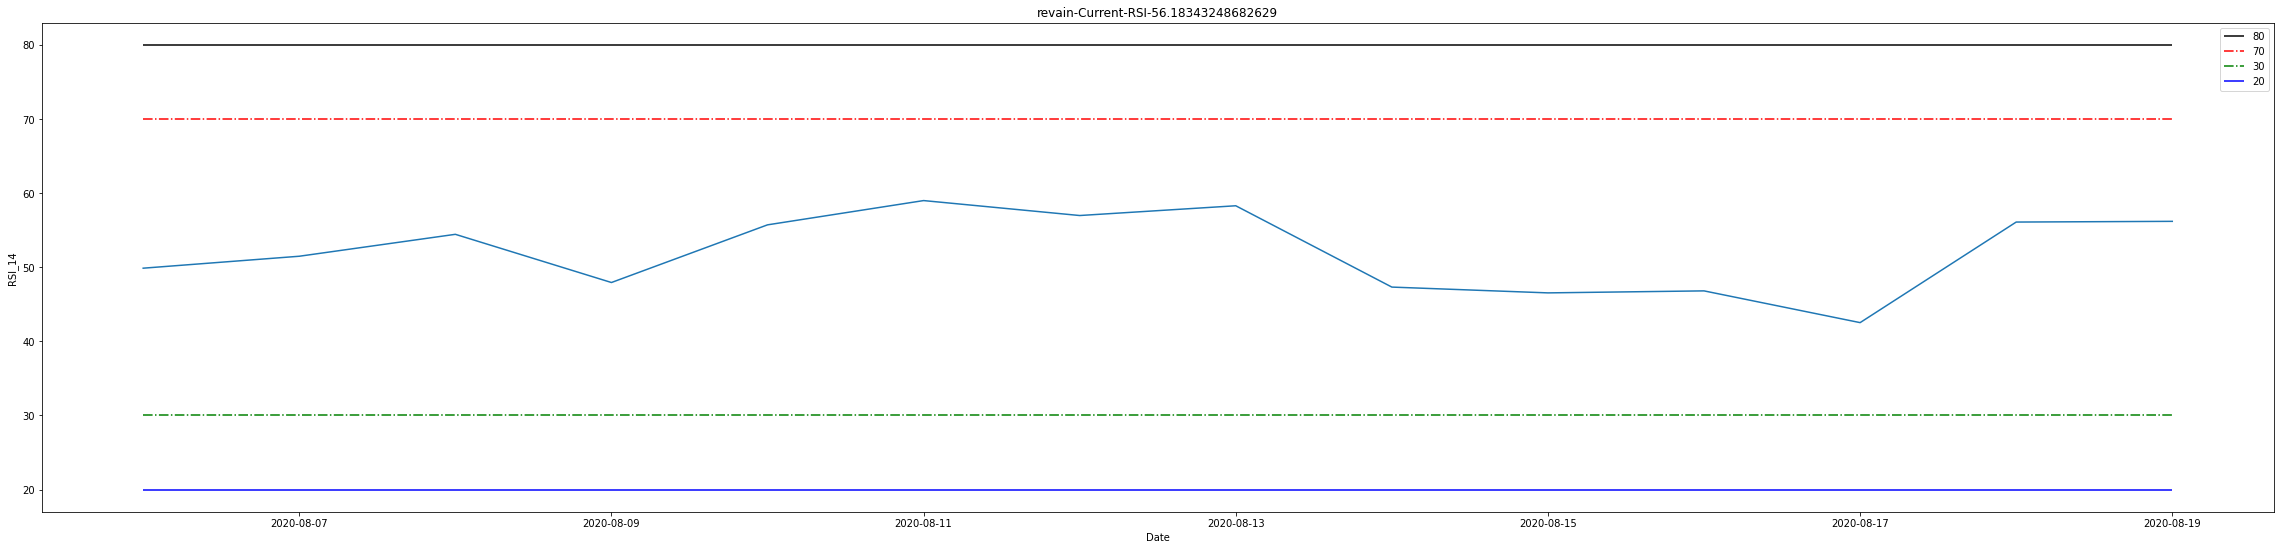

Plotting RSI (53.436097129230035) for:  dapp-token


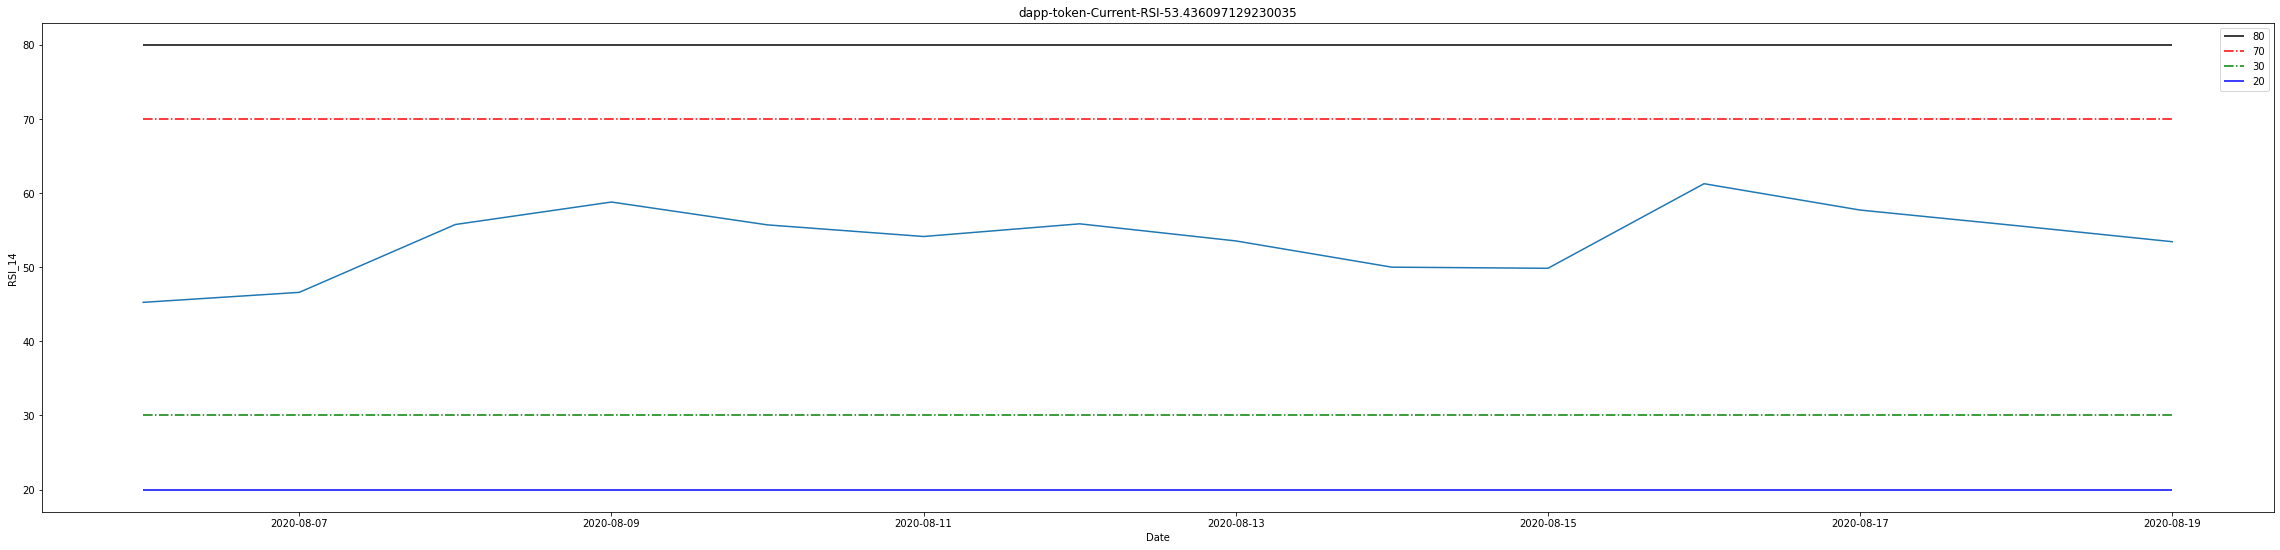

Plotting RSI (58.626282776023864) for:  iotex


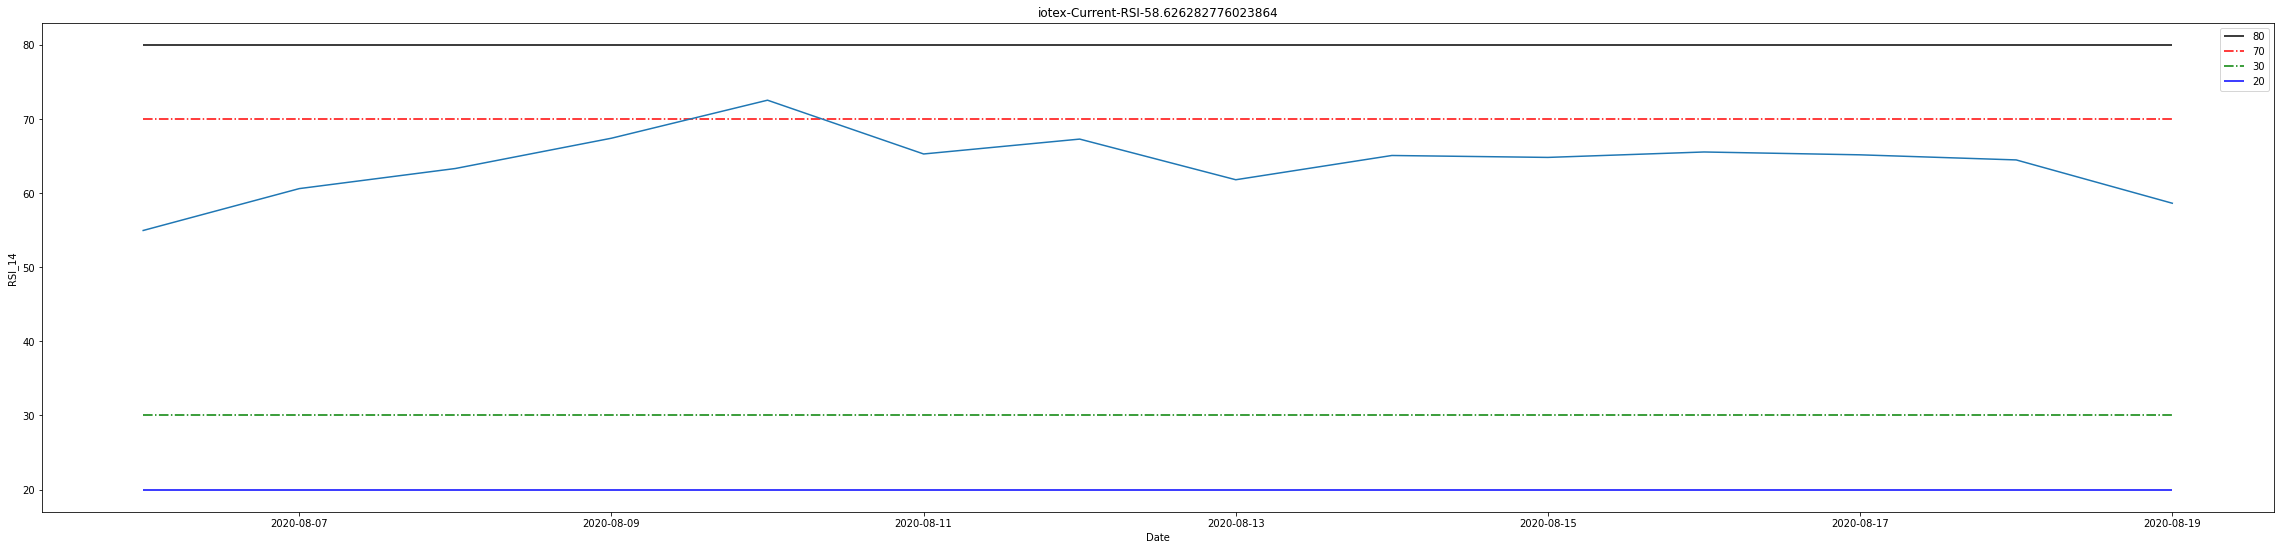

Plotting RSI (77.47784698477189) for:  omg


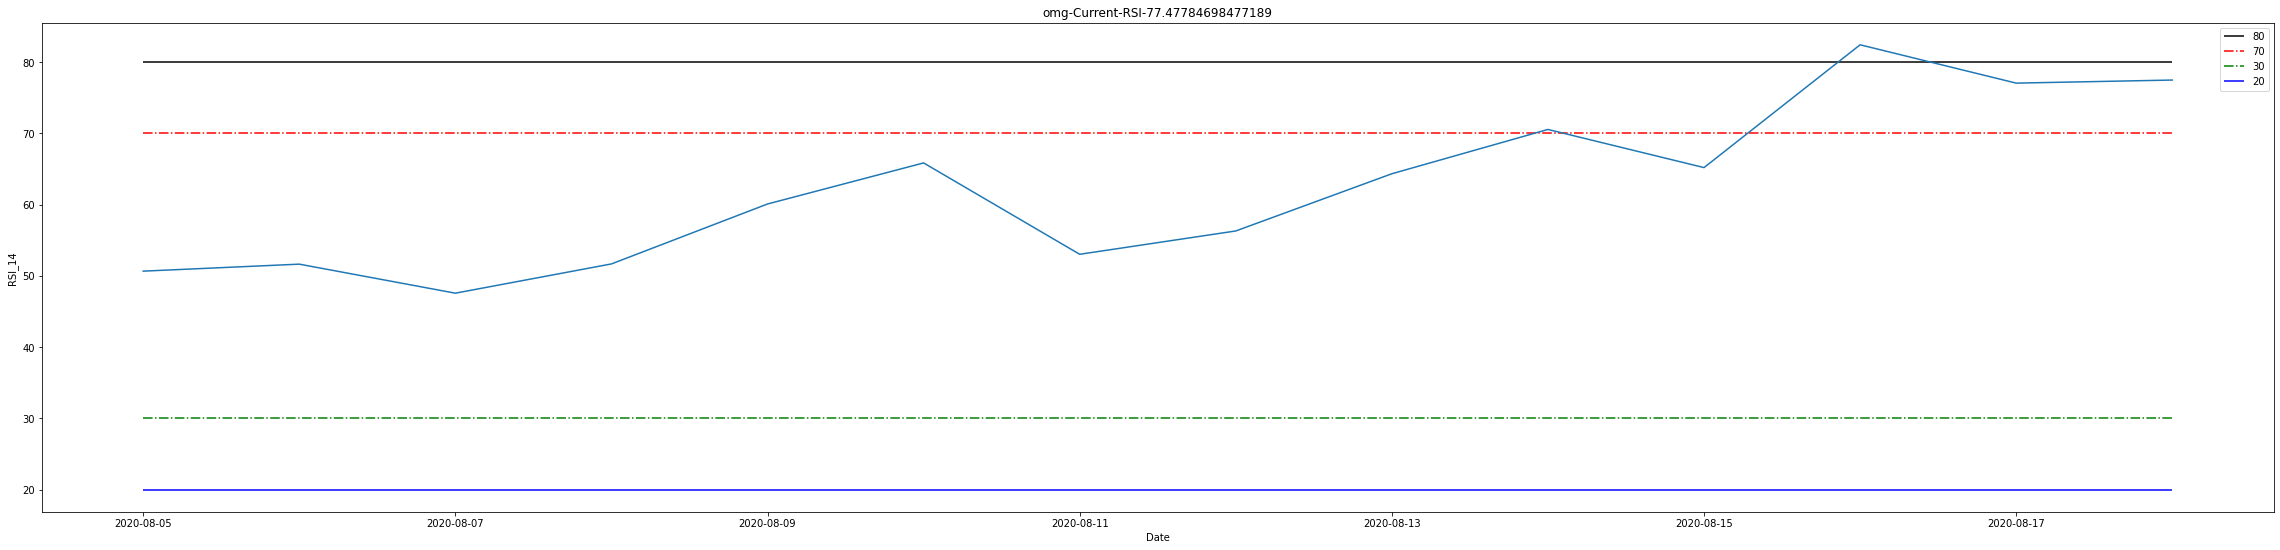

Plotting RSI (75.60044319227922) for:  high-performance-blockchain


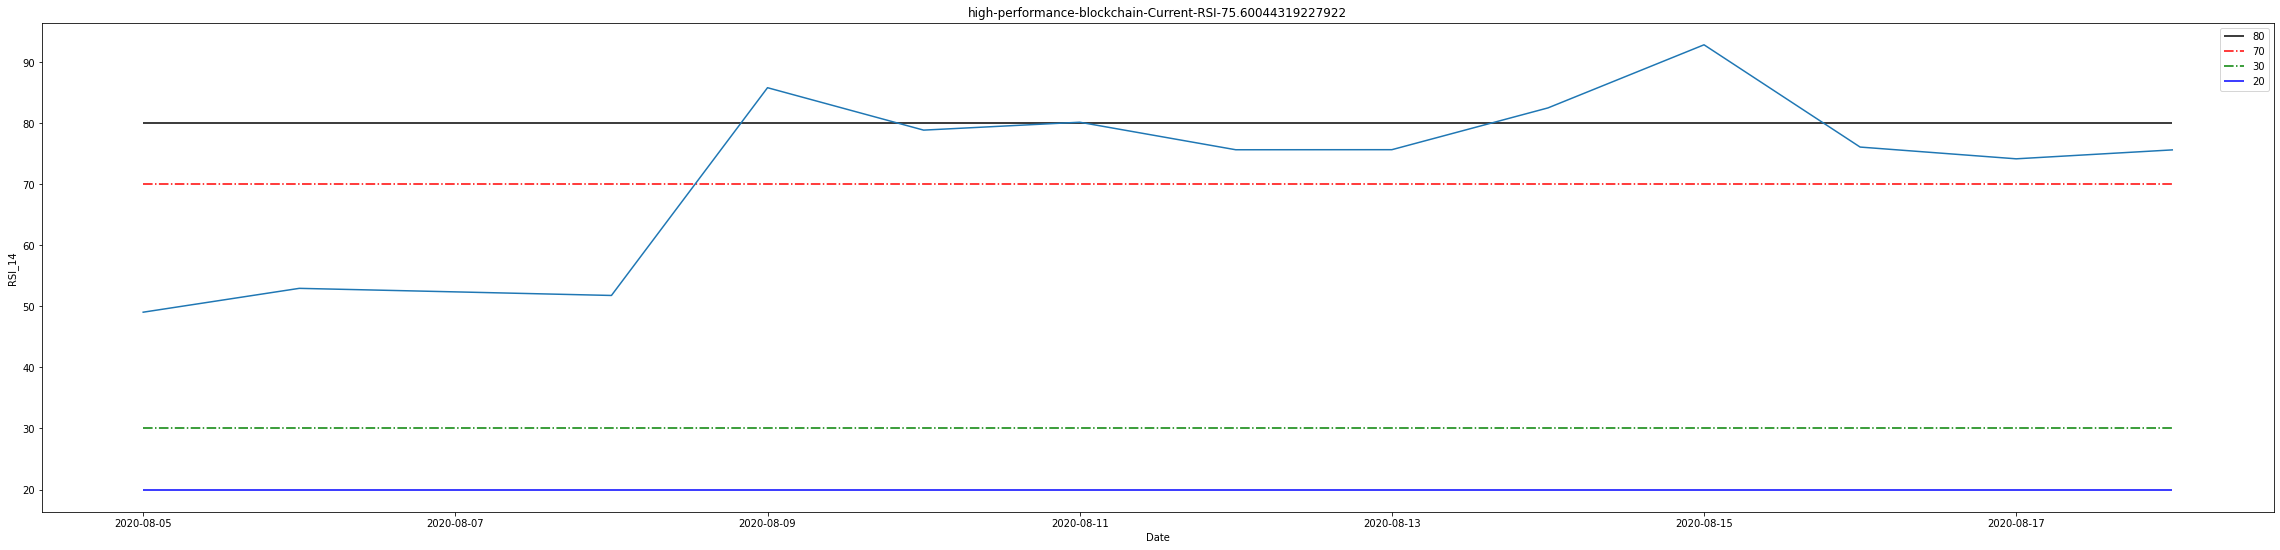

Plotting RSI (45.01328558595397) for:  presearch


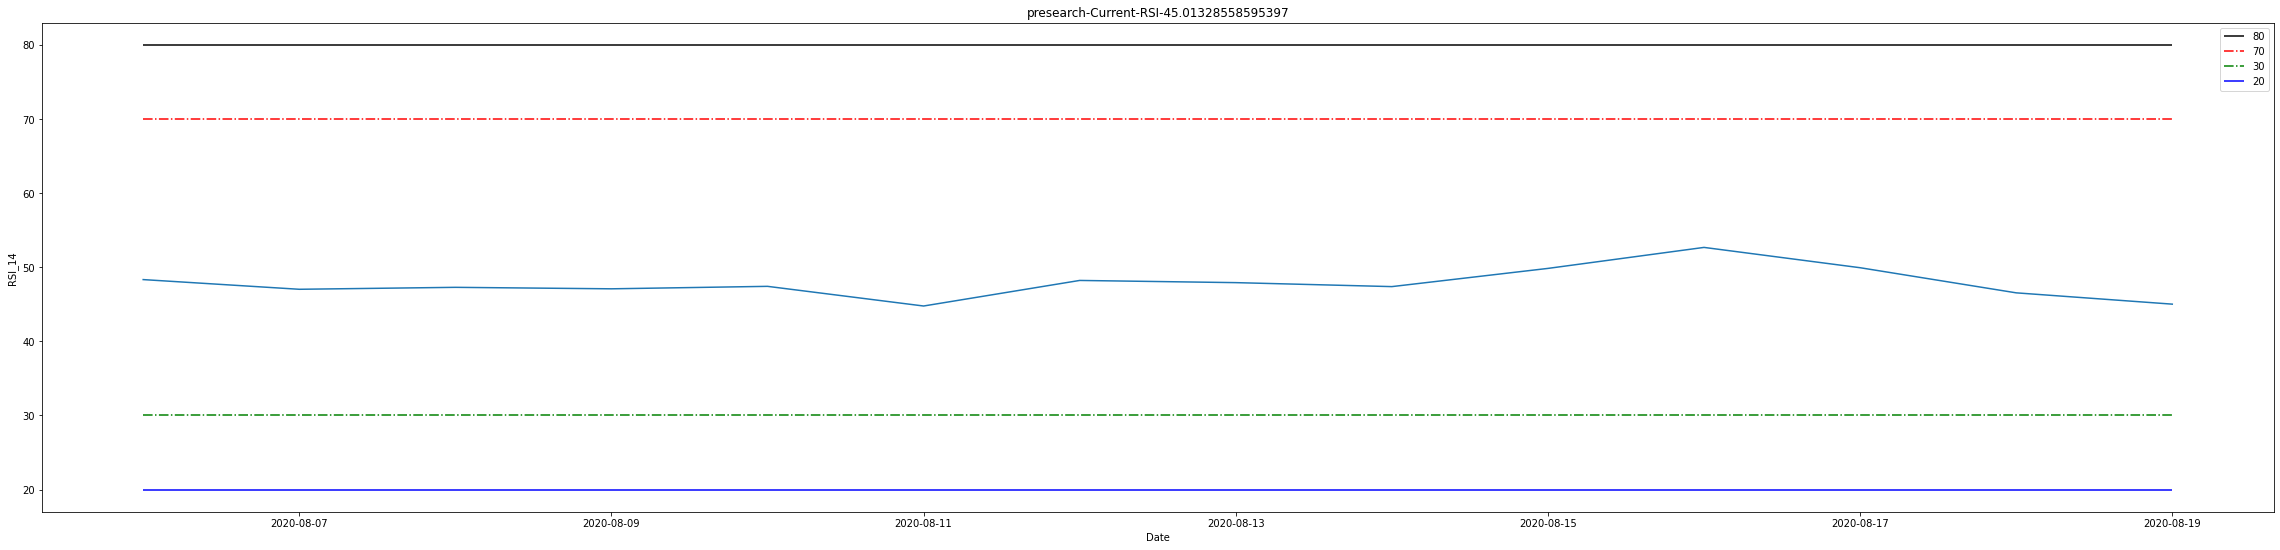

Plotting RSI (65.88838936083522) for:  terra-luna


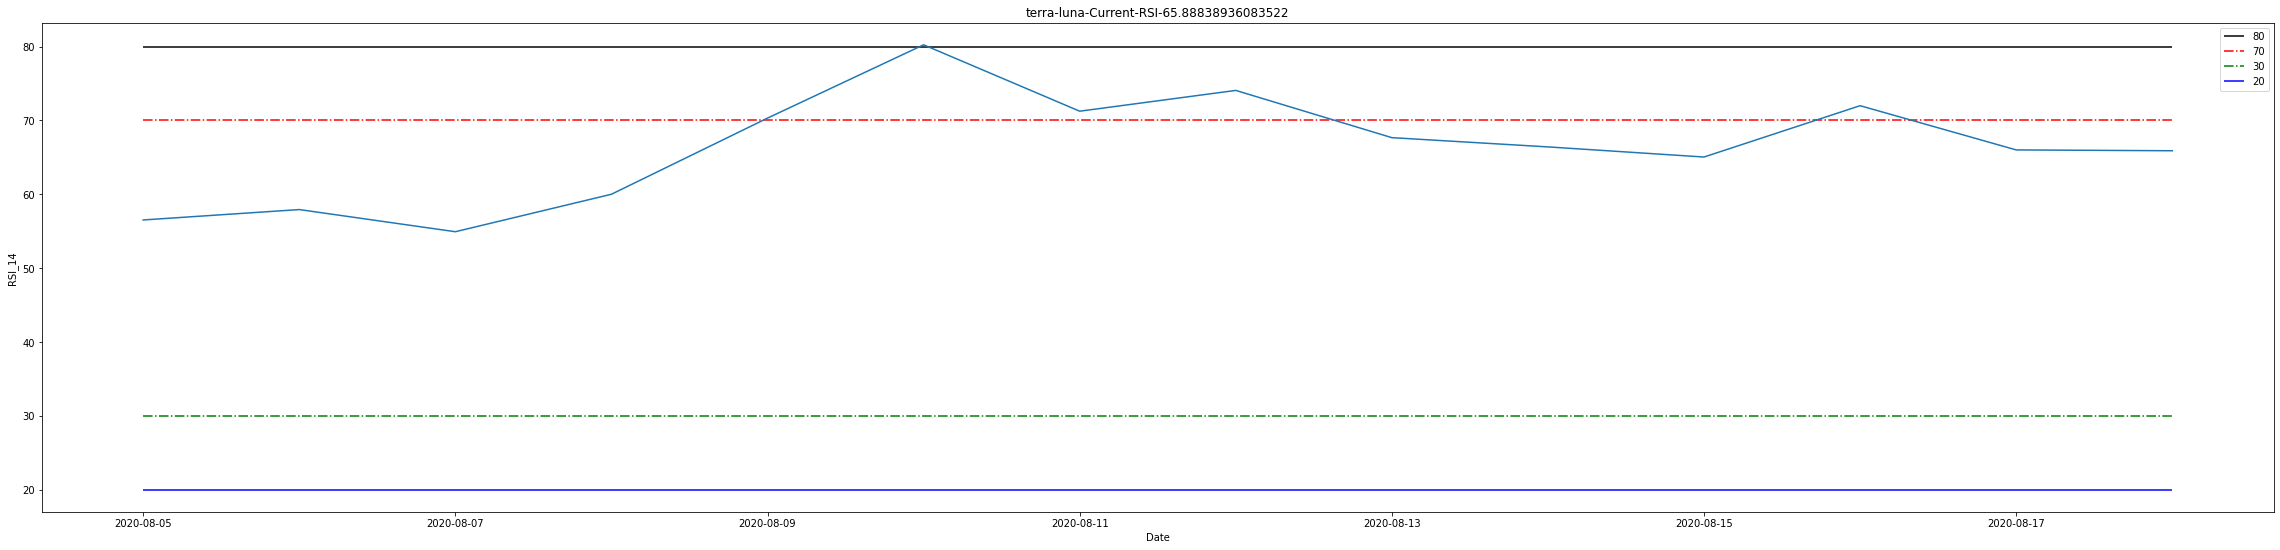

Plotting RSI (48.005441232761676) for:  request


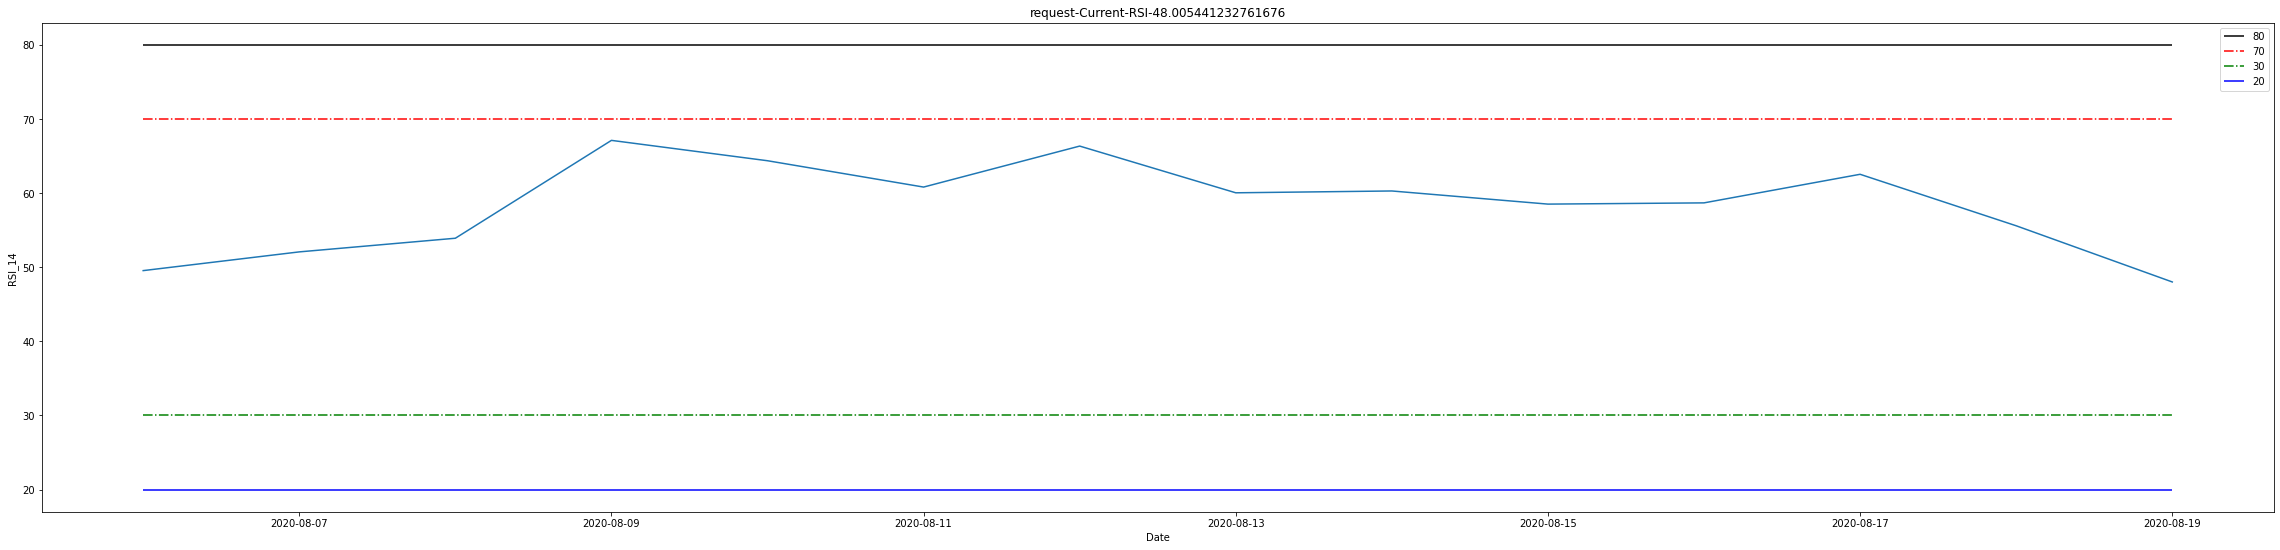

Plotting RSI (51.485968090704034) for:  tezos


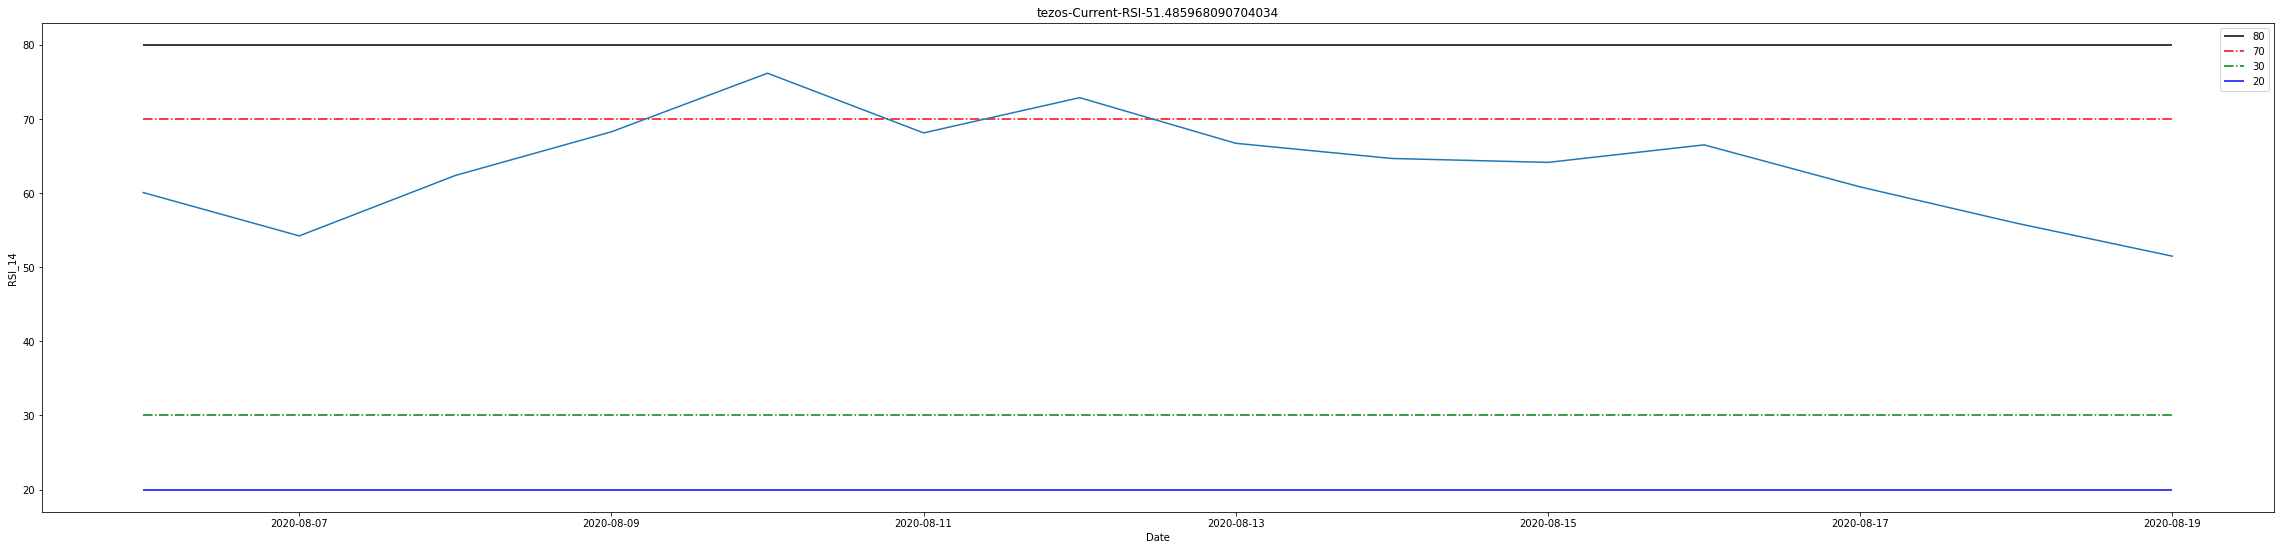

Plotting RSI (49.546716837470356) for:  restart-energy-mwat


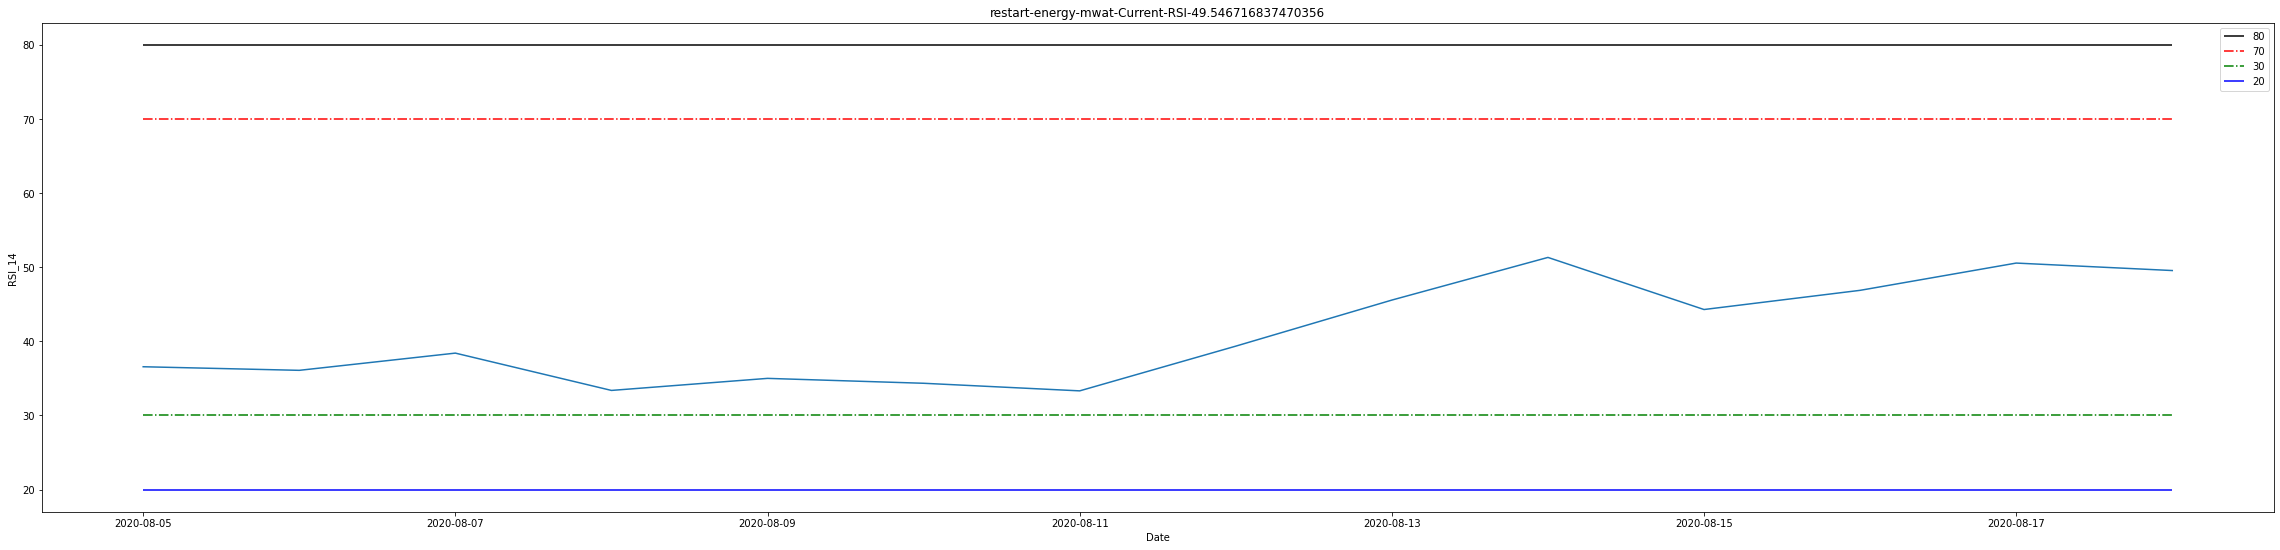

Plotting RSI (53.46673712517292) for:  electroneum


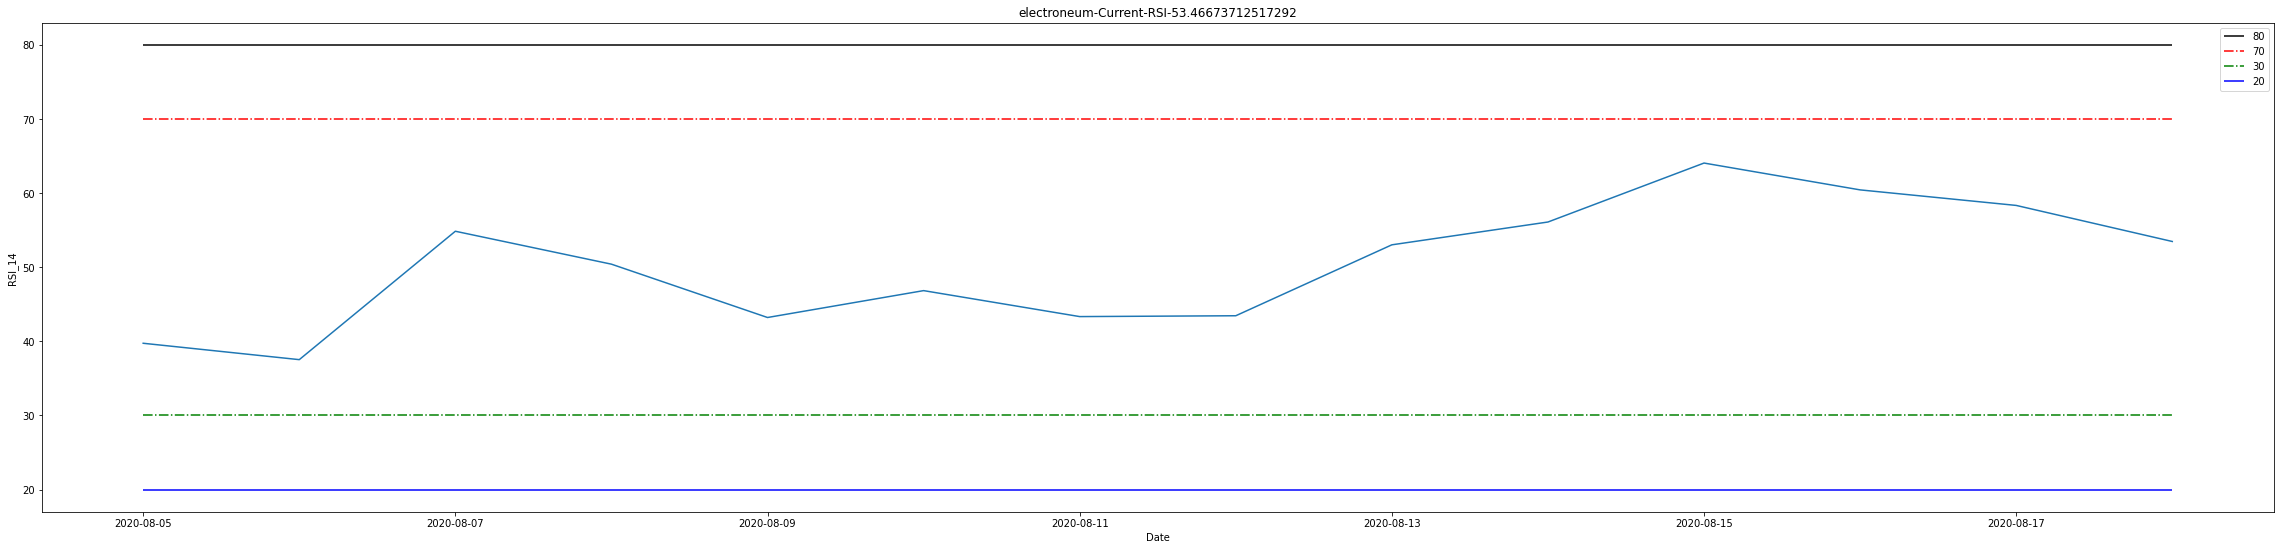

Plotting RSI (62.756996537732576) for:  credits


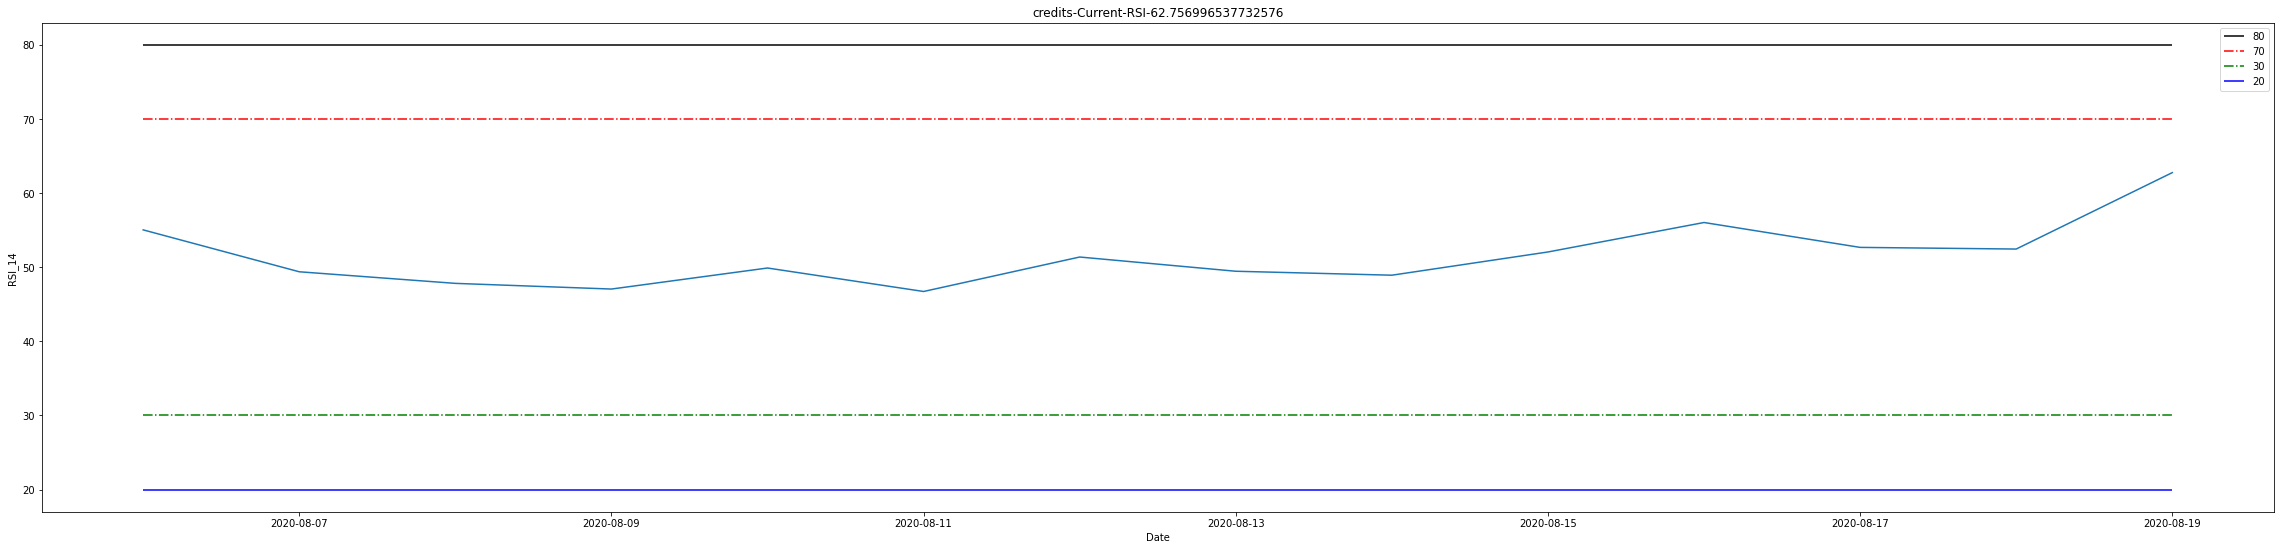

Plotting RSI (65.58910682262038) for:  lisk


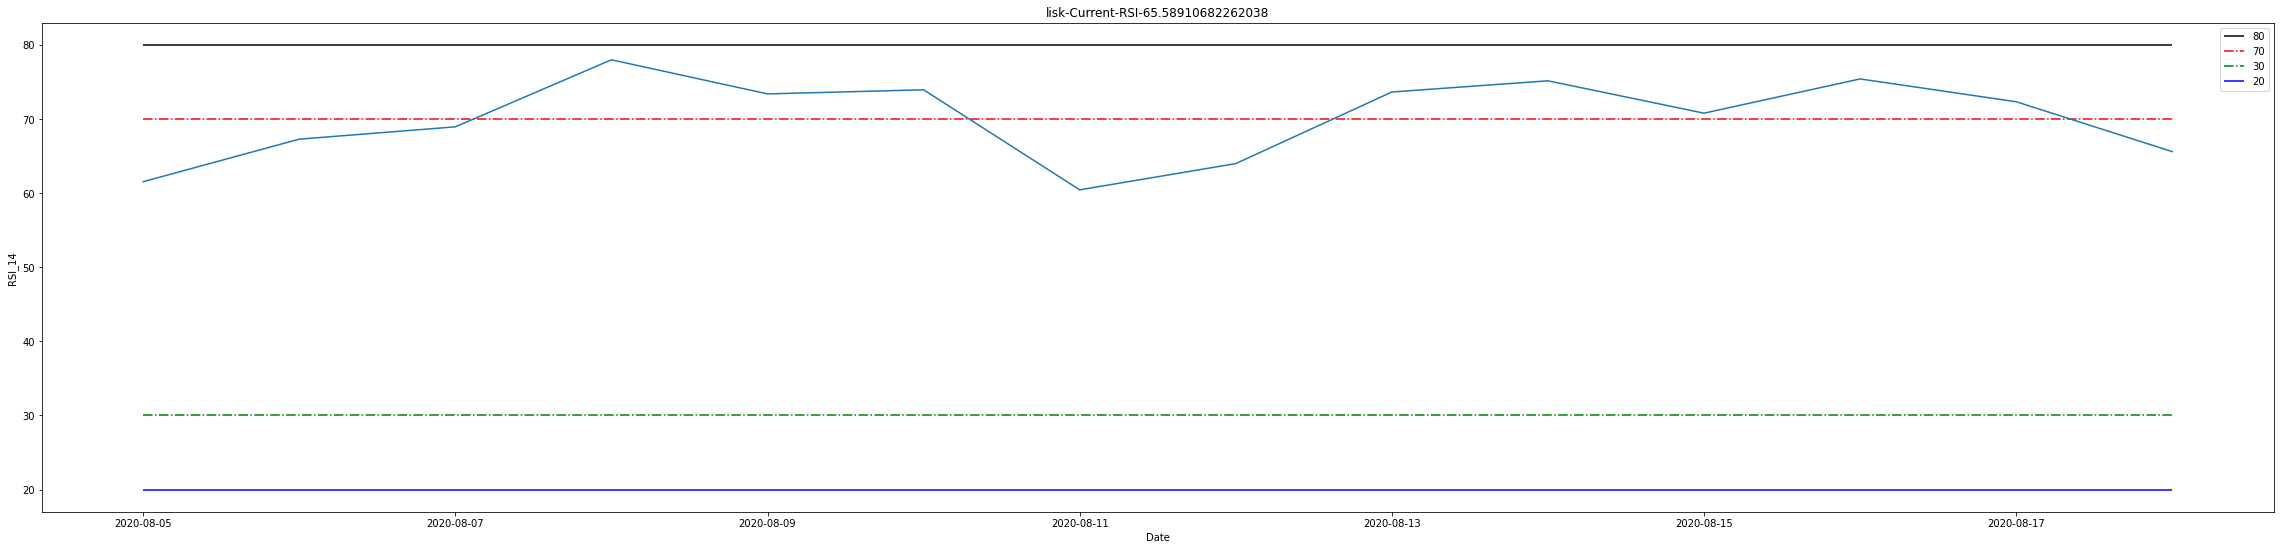

Plotting RSI (74.11761640813124) for:  vidt-datalink


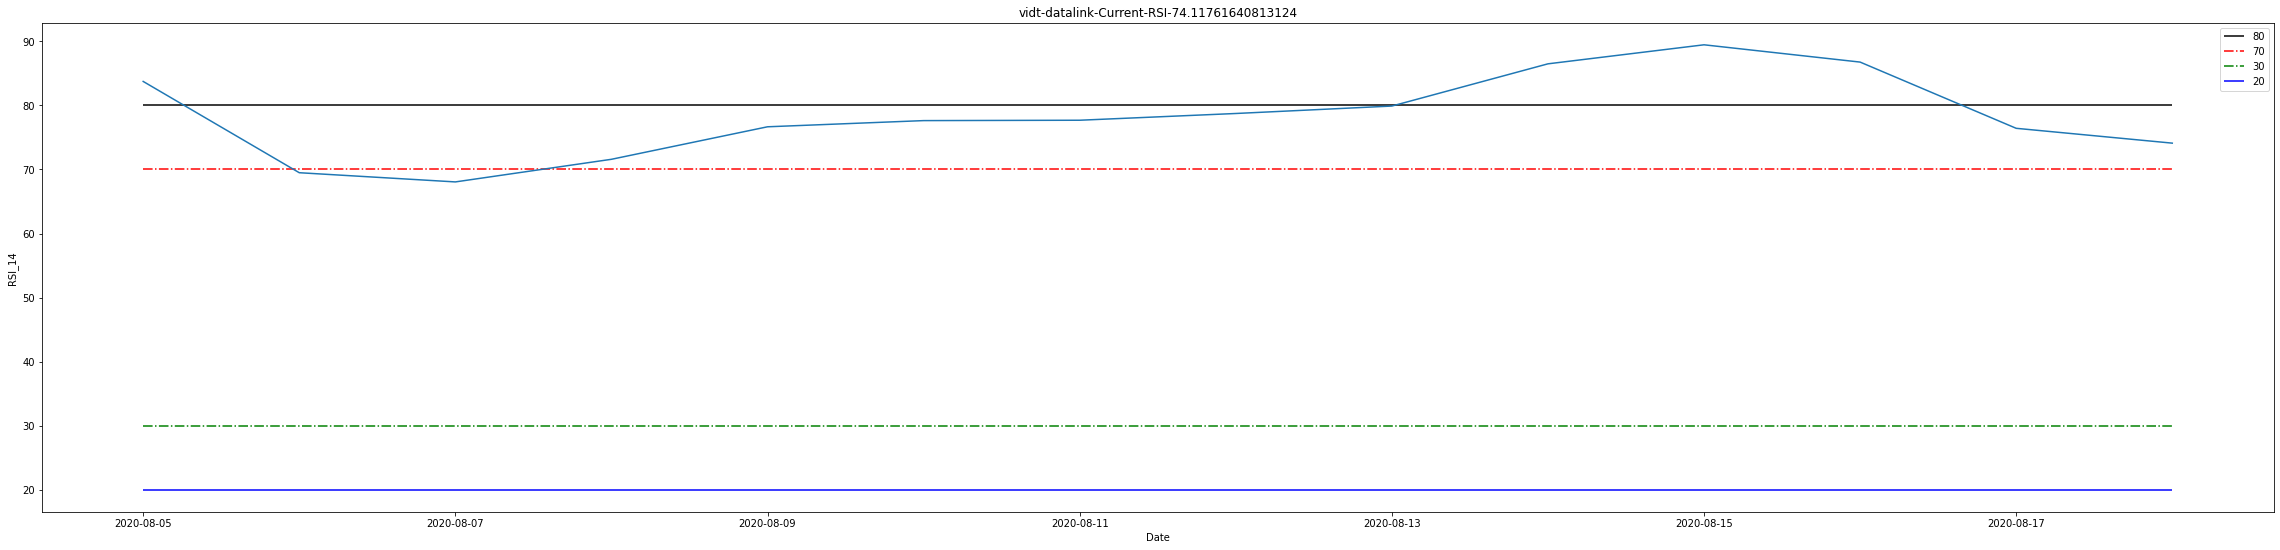

Plotting RSI (56.645822430933386) for:  bittorrent


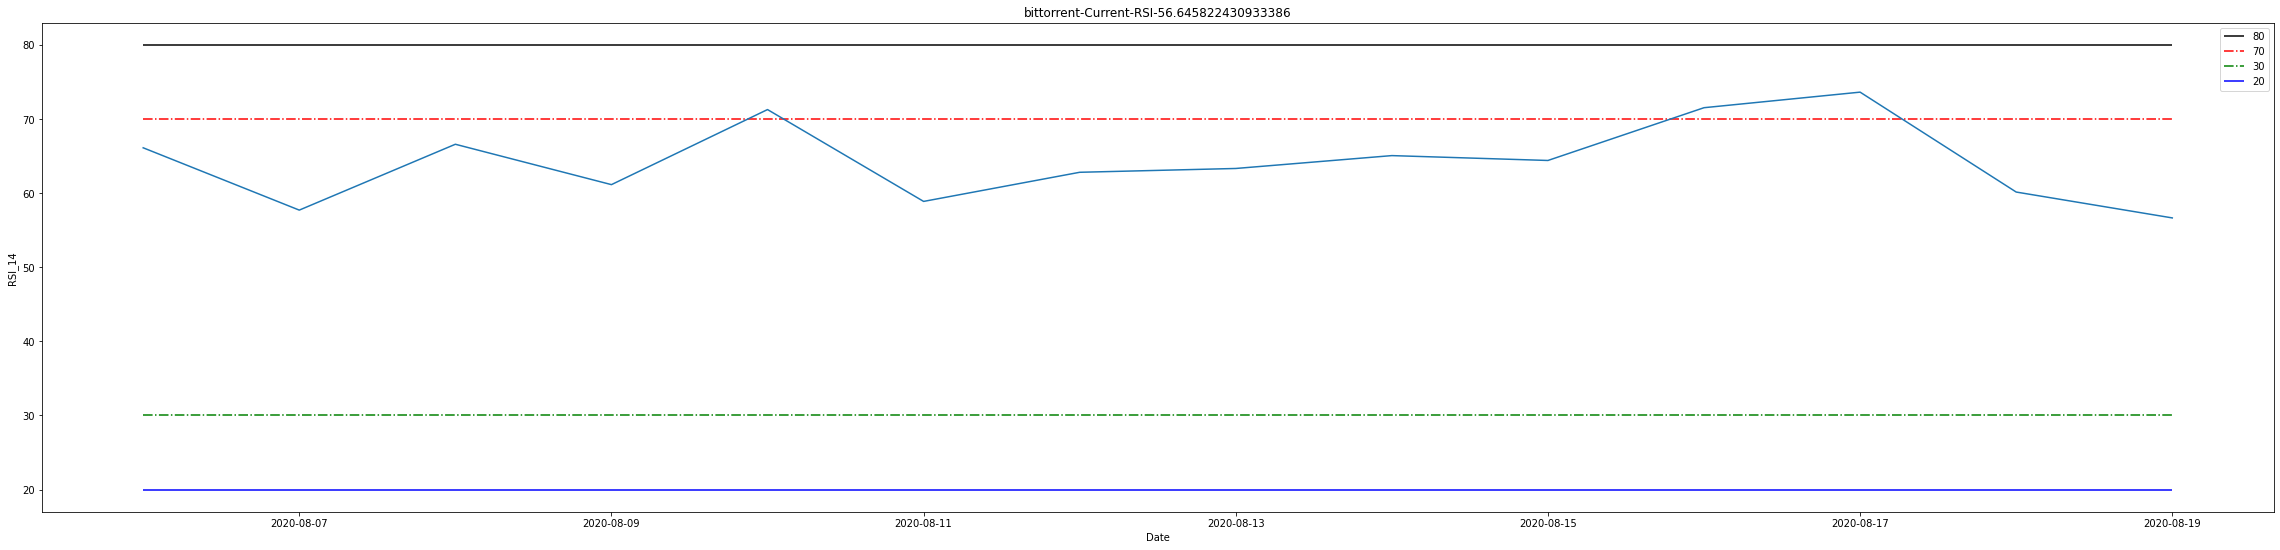

Plotting RSI (64.88998473003389) for:  wanchain


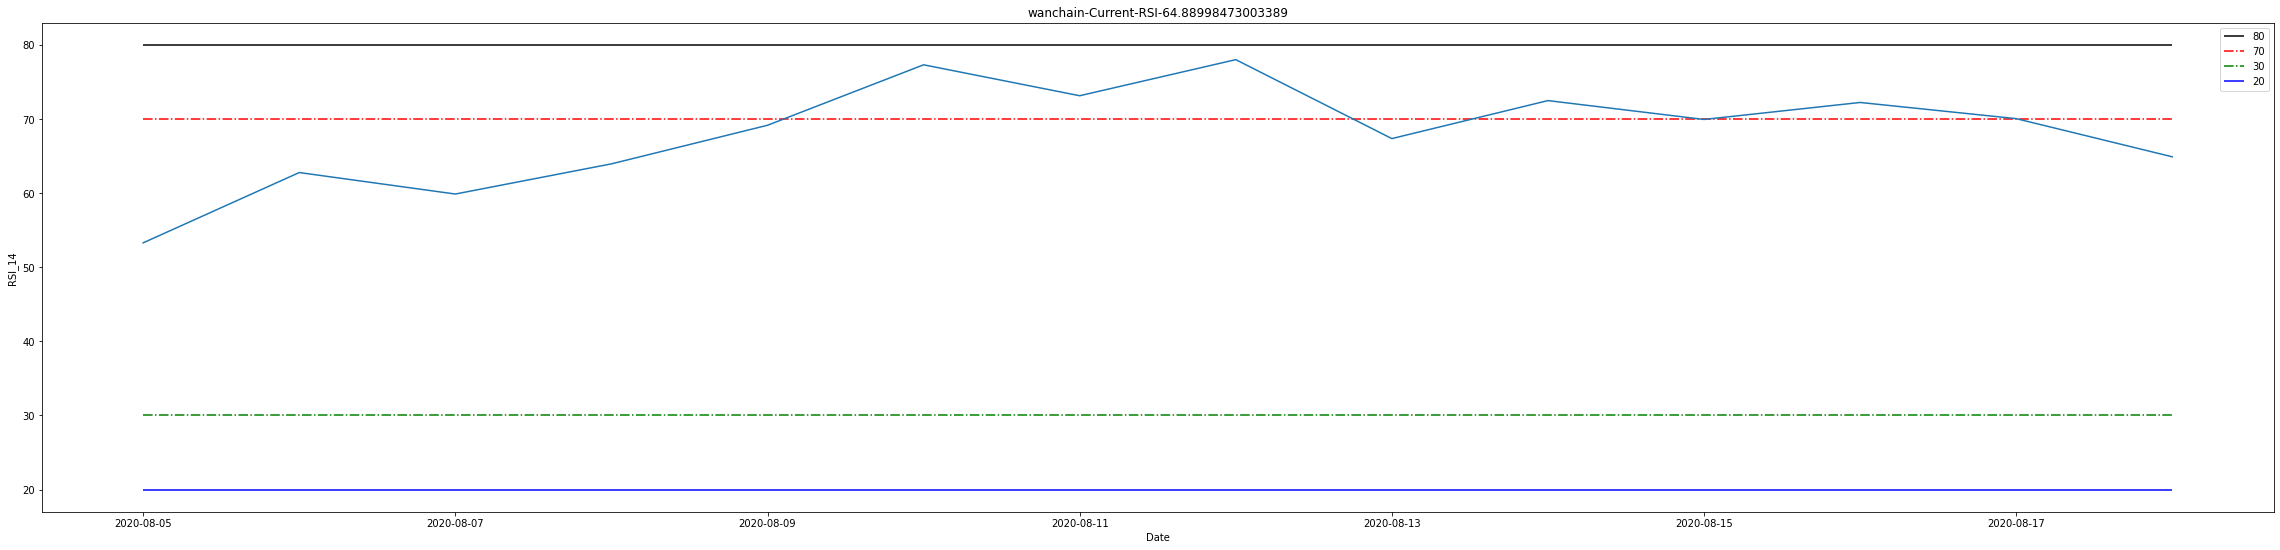

Plotting RSI (77.27144674605151) for:  cappasity


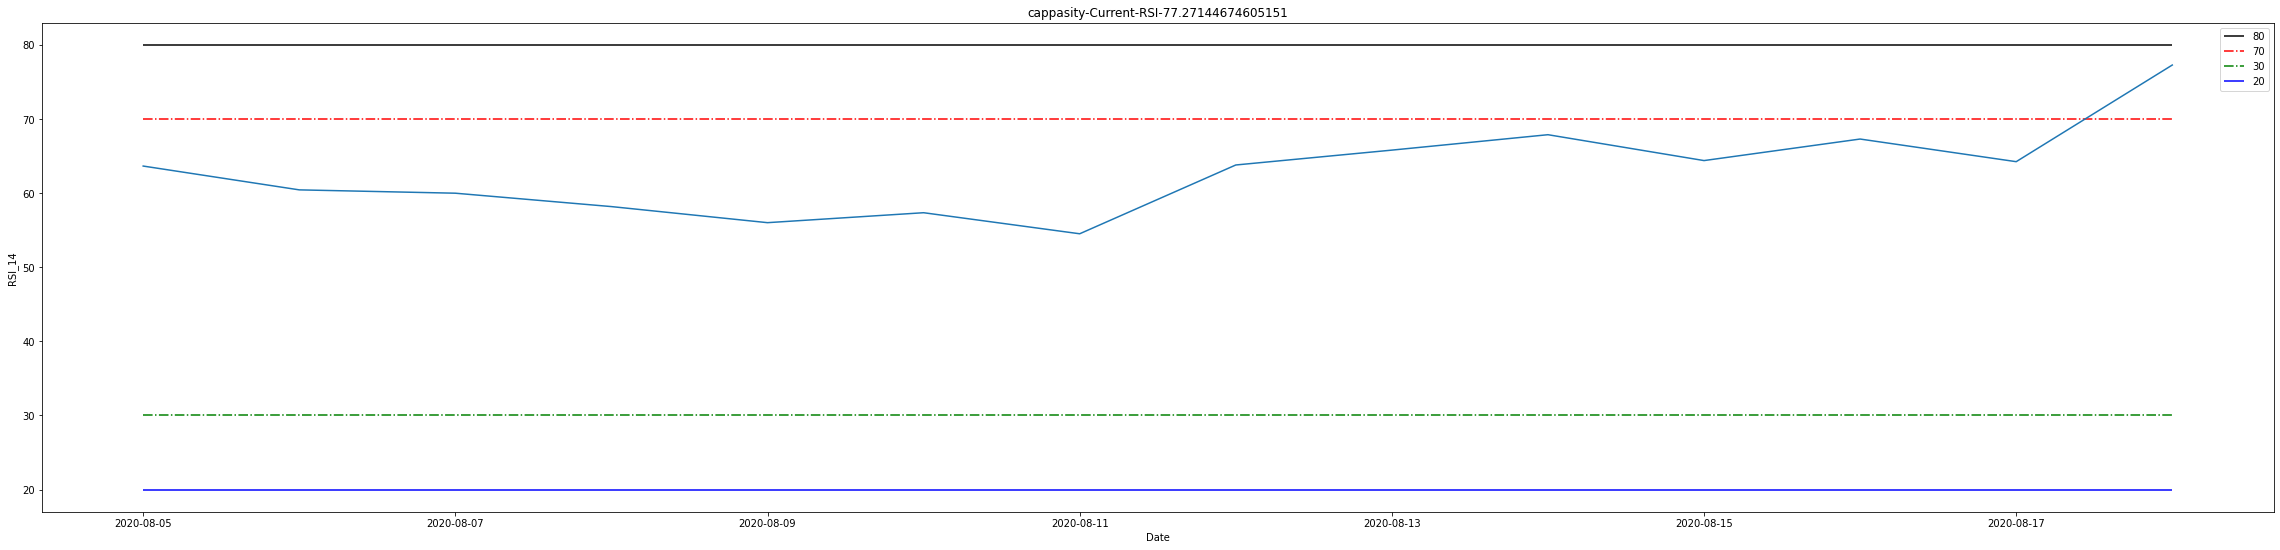

Plotting RSI (51.97511044062812) for:  vechain


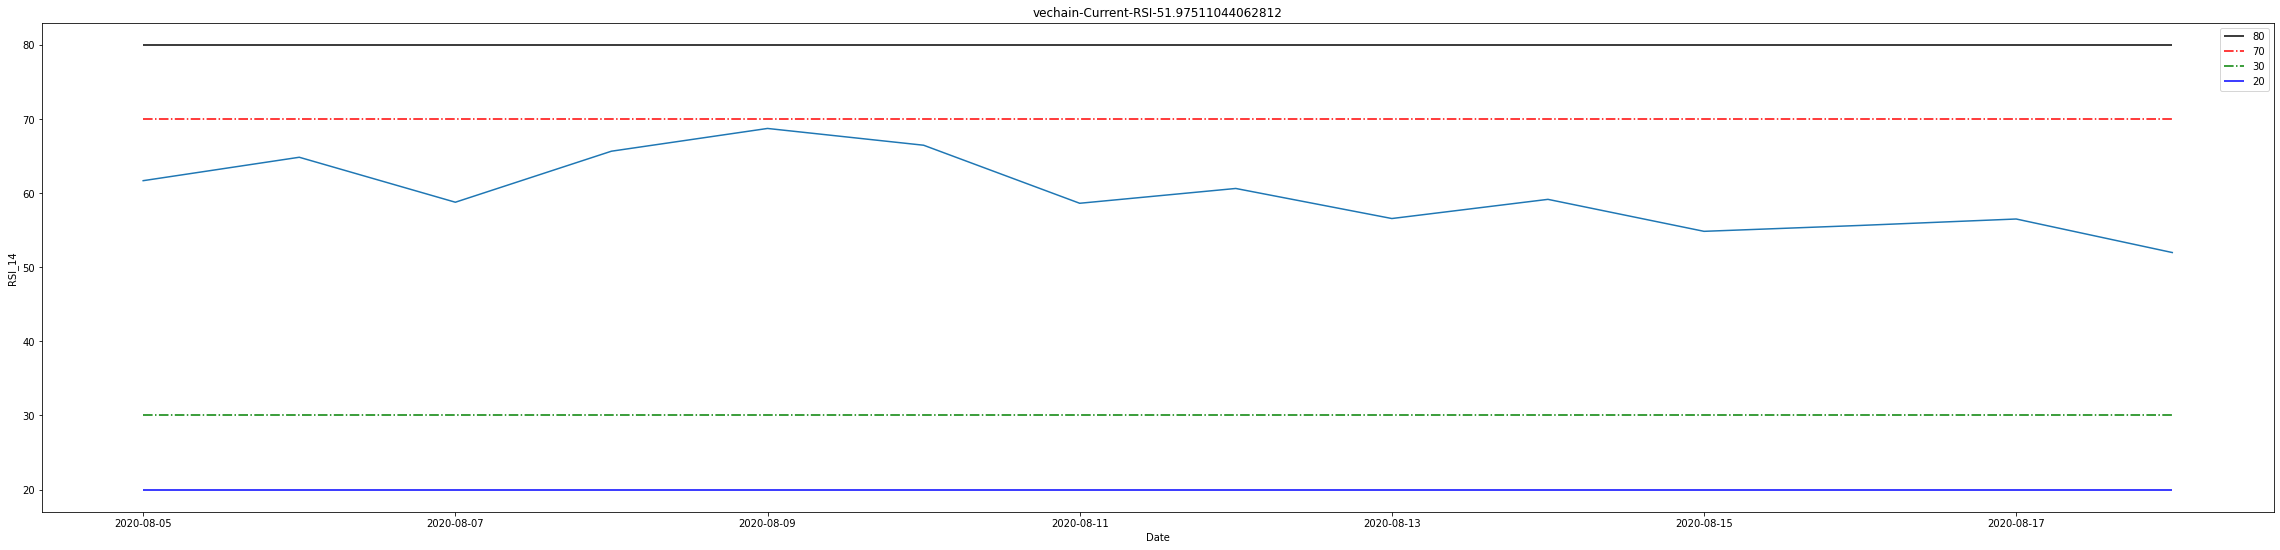

Plotting RSI (72.46665445214603) for:  kick-token


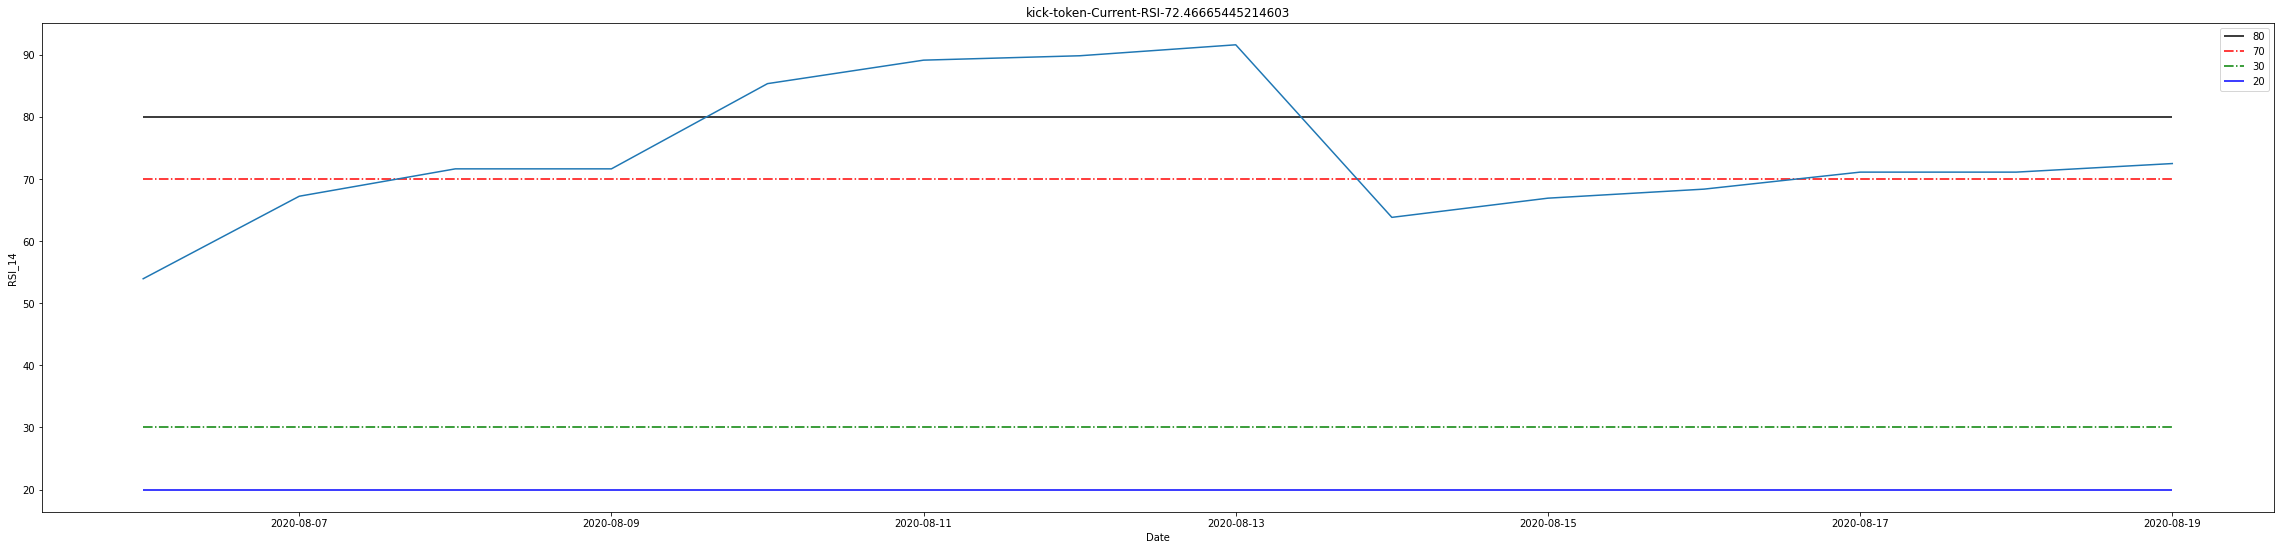

Plotting RSI (46.7643752418404) for:  multivac


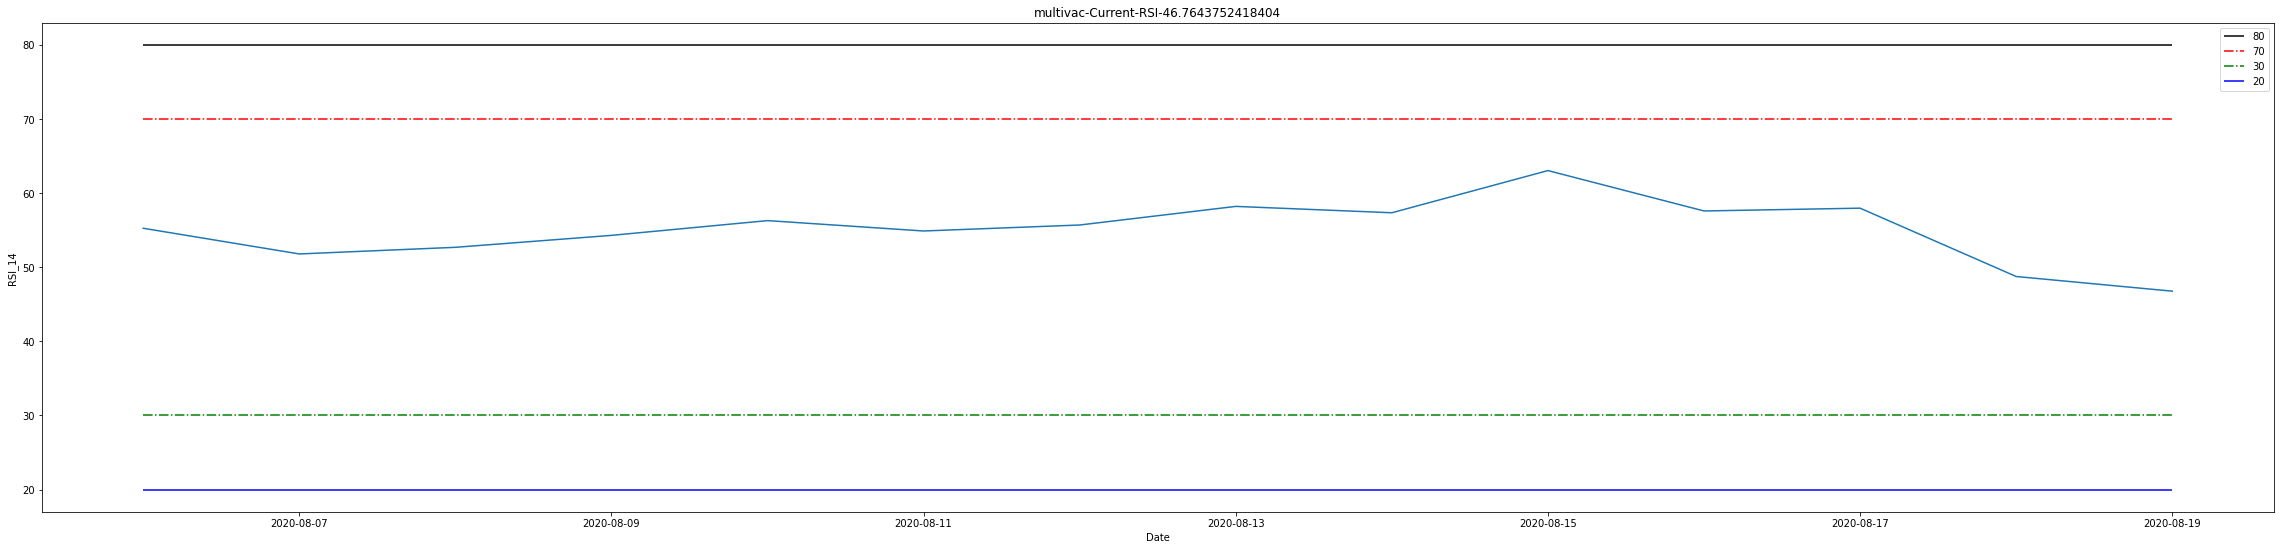

Plotting RSI (49.68247076306269) for:  aelf


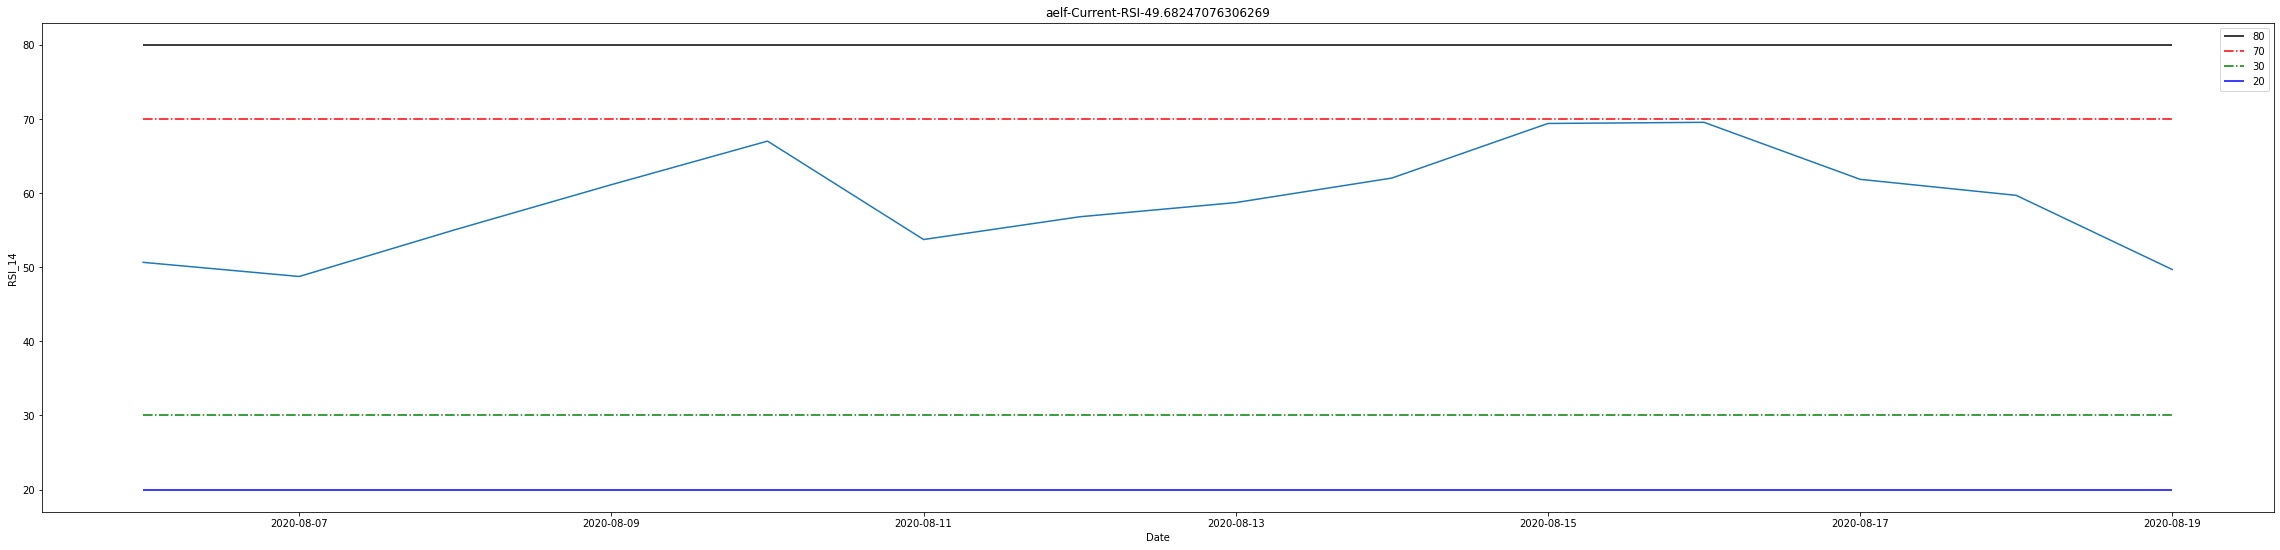

Plotting RSI (80.74257931096992) for:  utrust


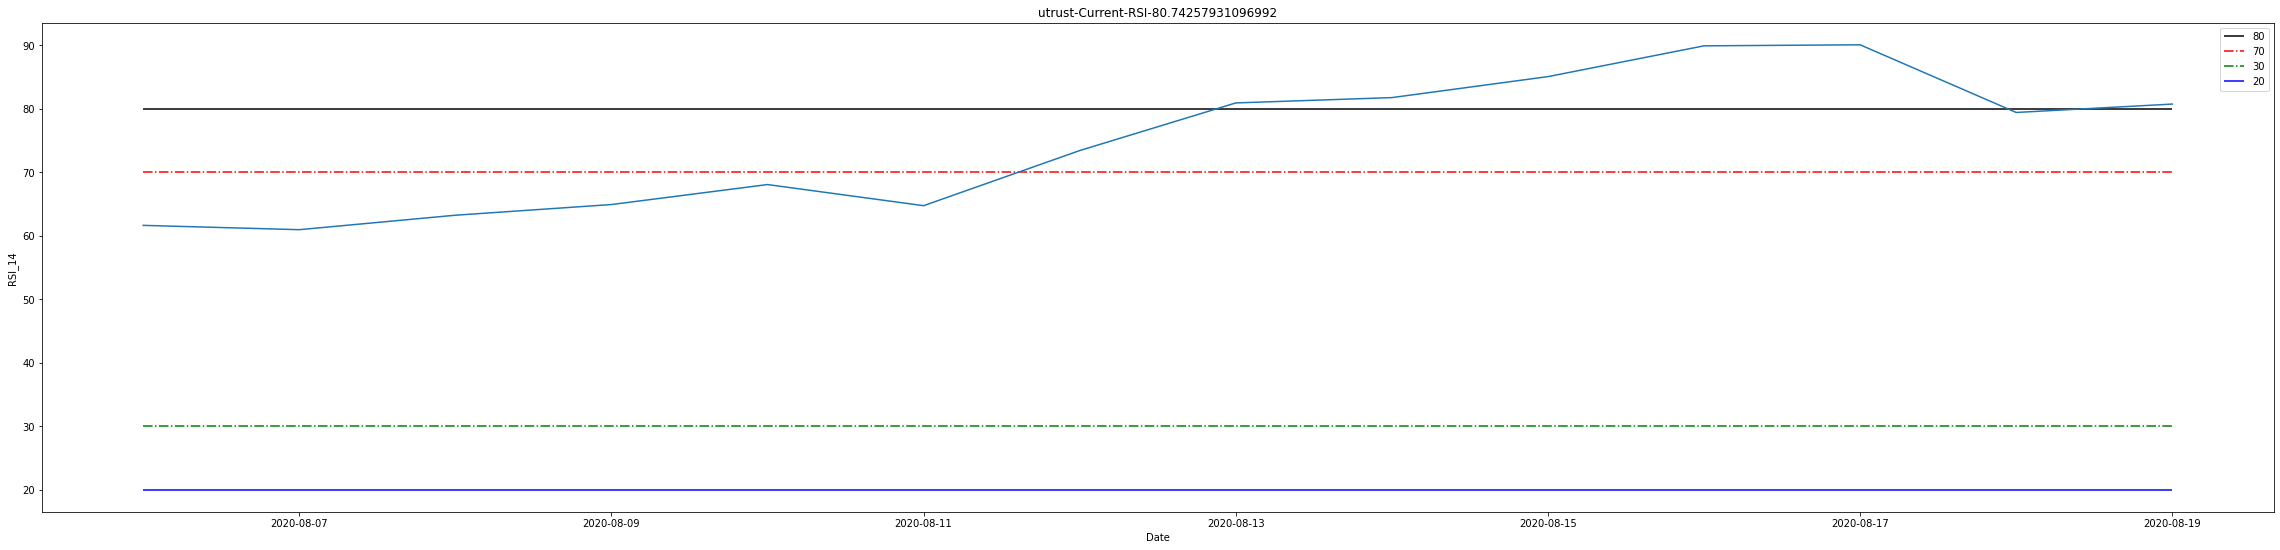

Plotting RSI (60.99057550466298) for:  lympo


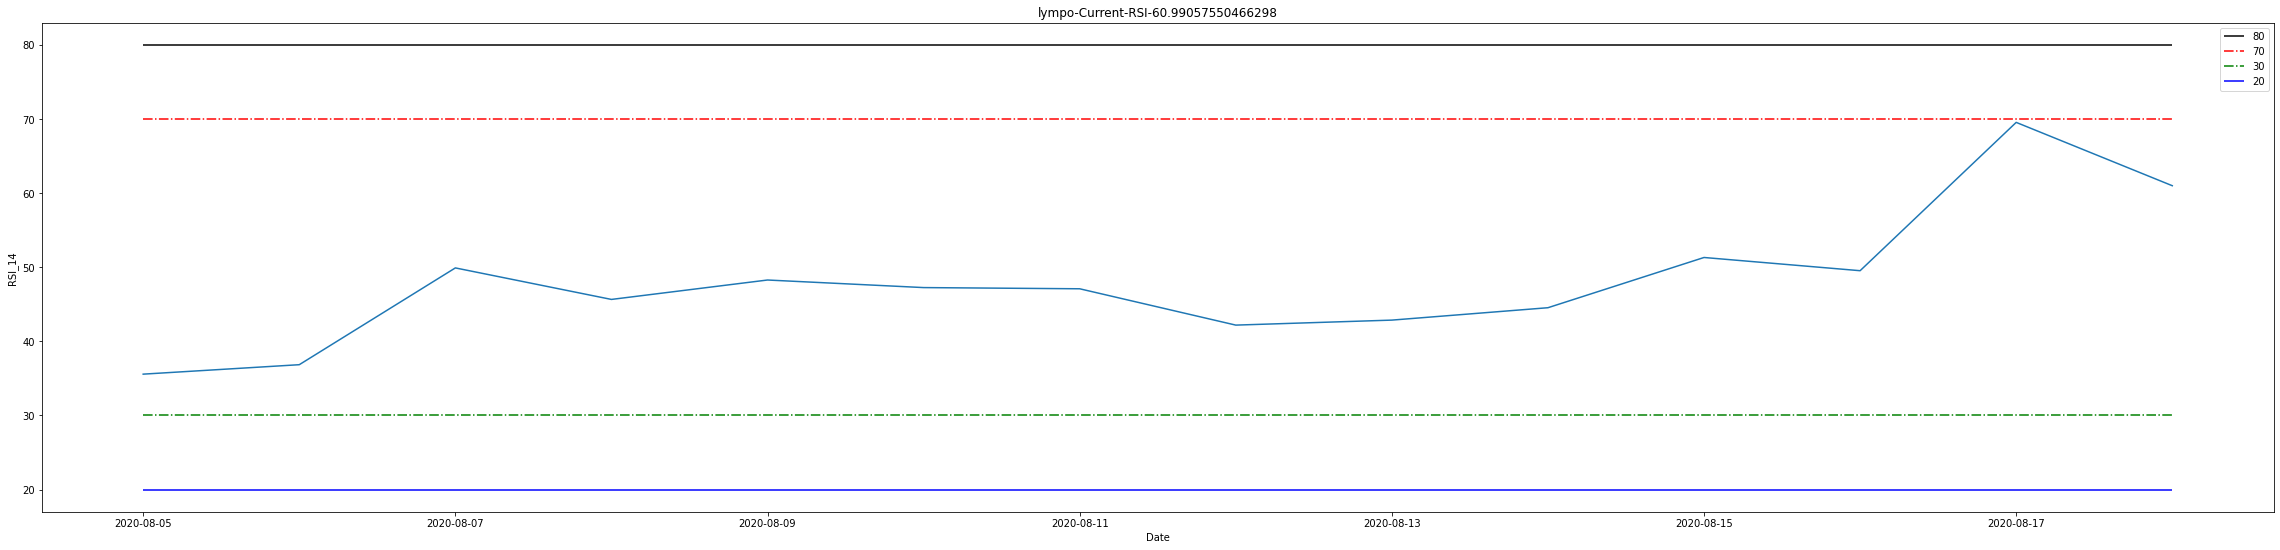

Plotting RSI (59.50821364252591) for:  litecoin


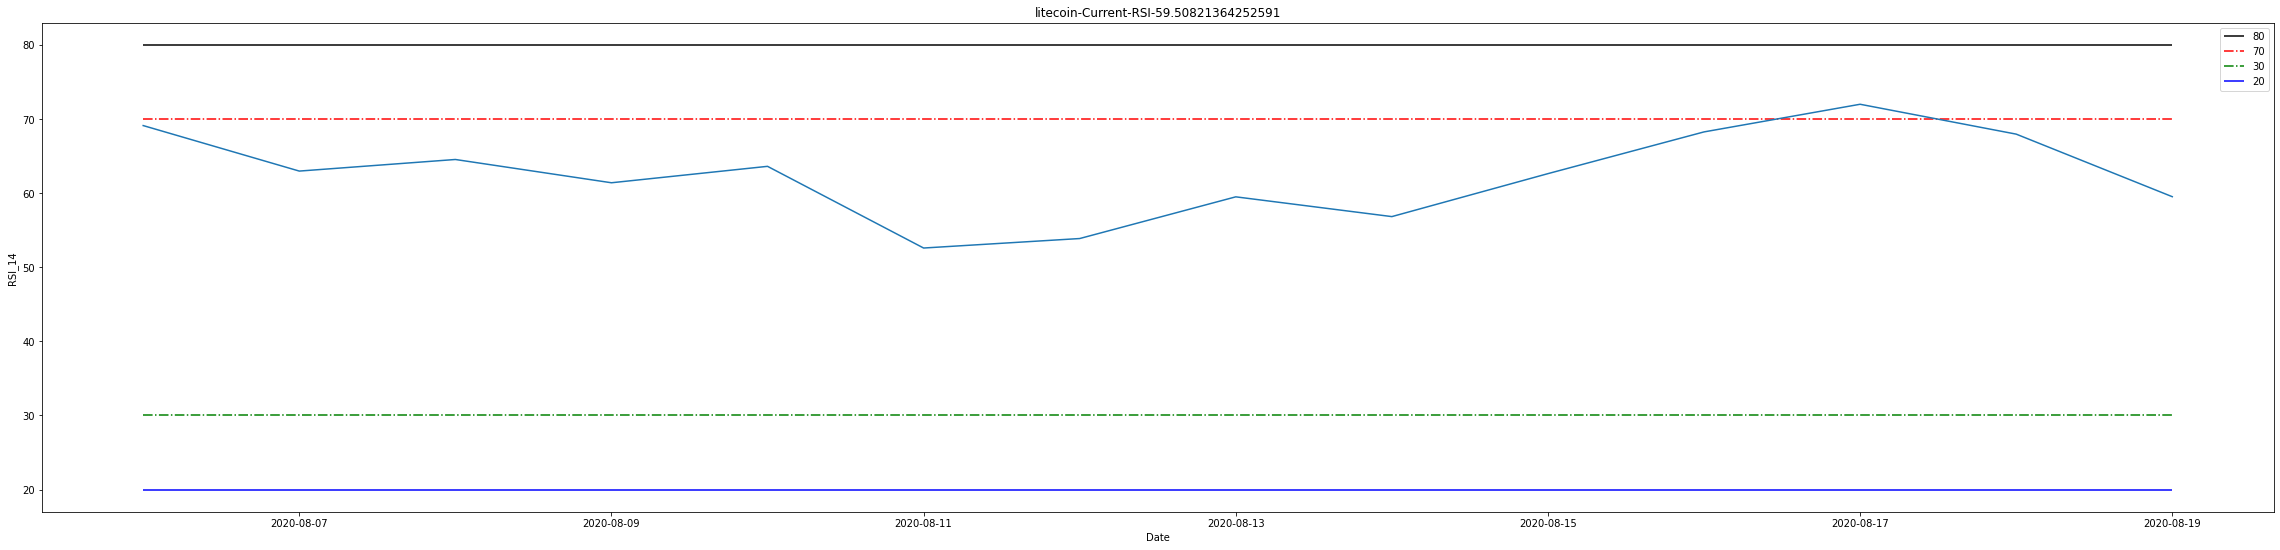

Plotting RSI (58.7239336521172) for:  noia-network


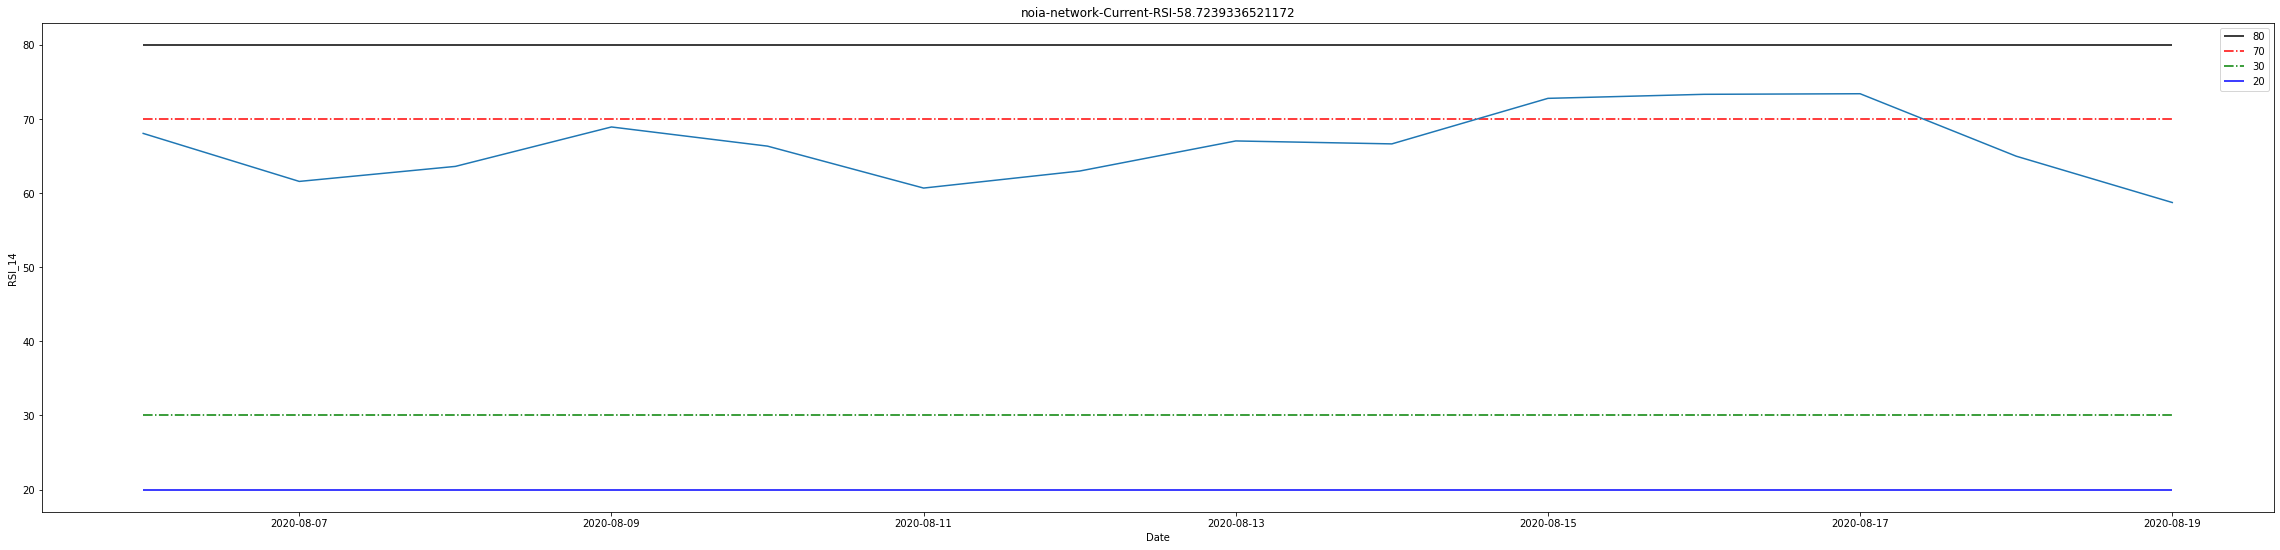

Plotting RSI (56.84093124992516) for:  bolt


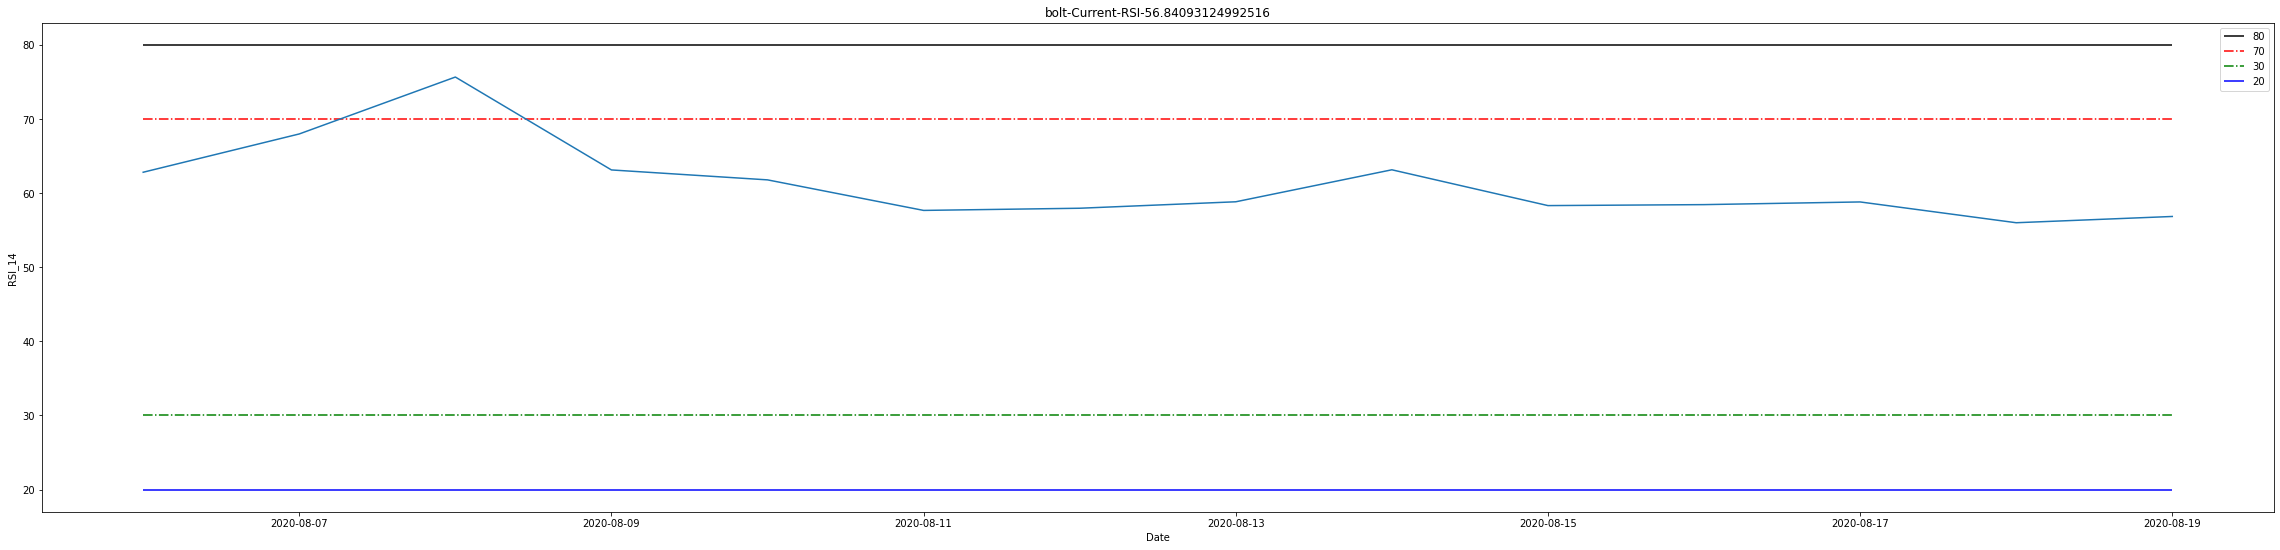

Plotting RSI (64.60560422797053) for:  tron


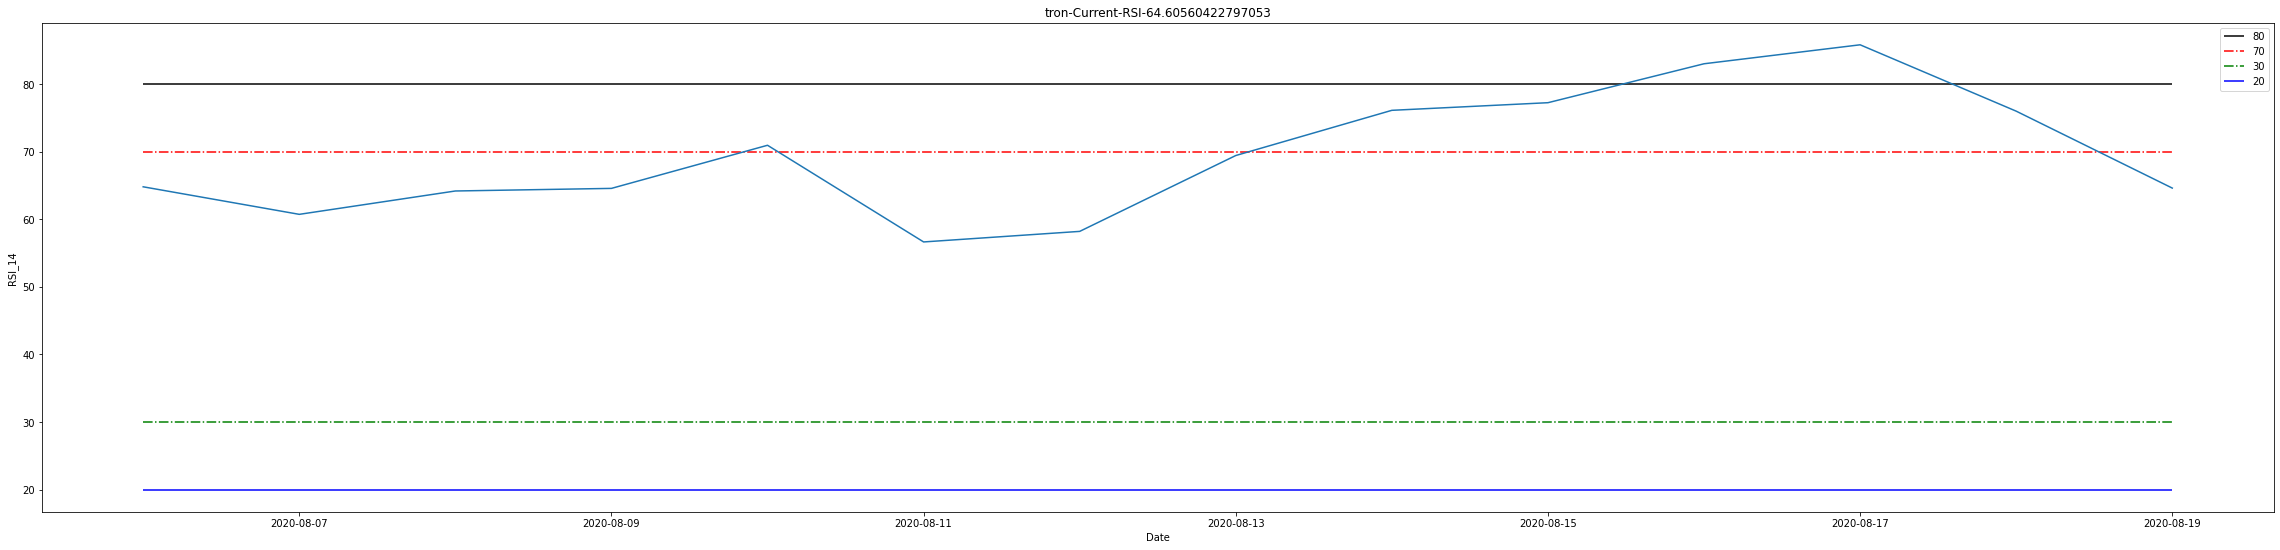

Plotting RSI (80.32232181009293) for:  lukso


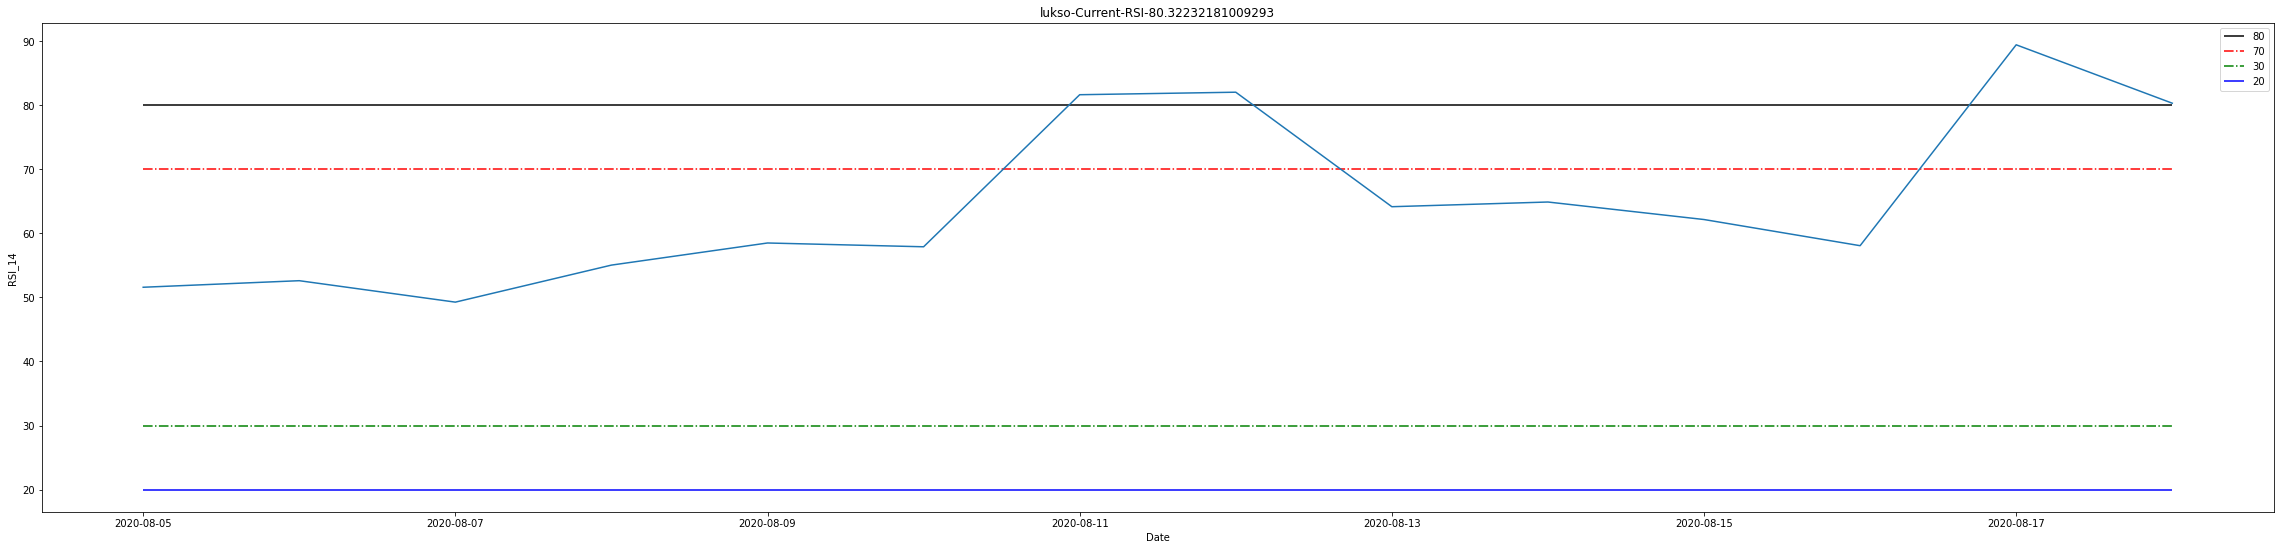

Plotting RSI (62.45473800948345) for:  rsk-smart-bitcoin


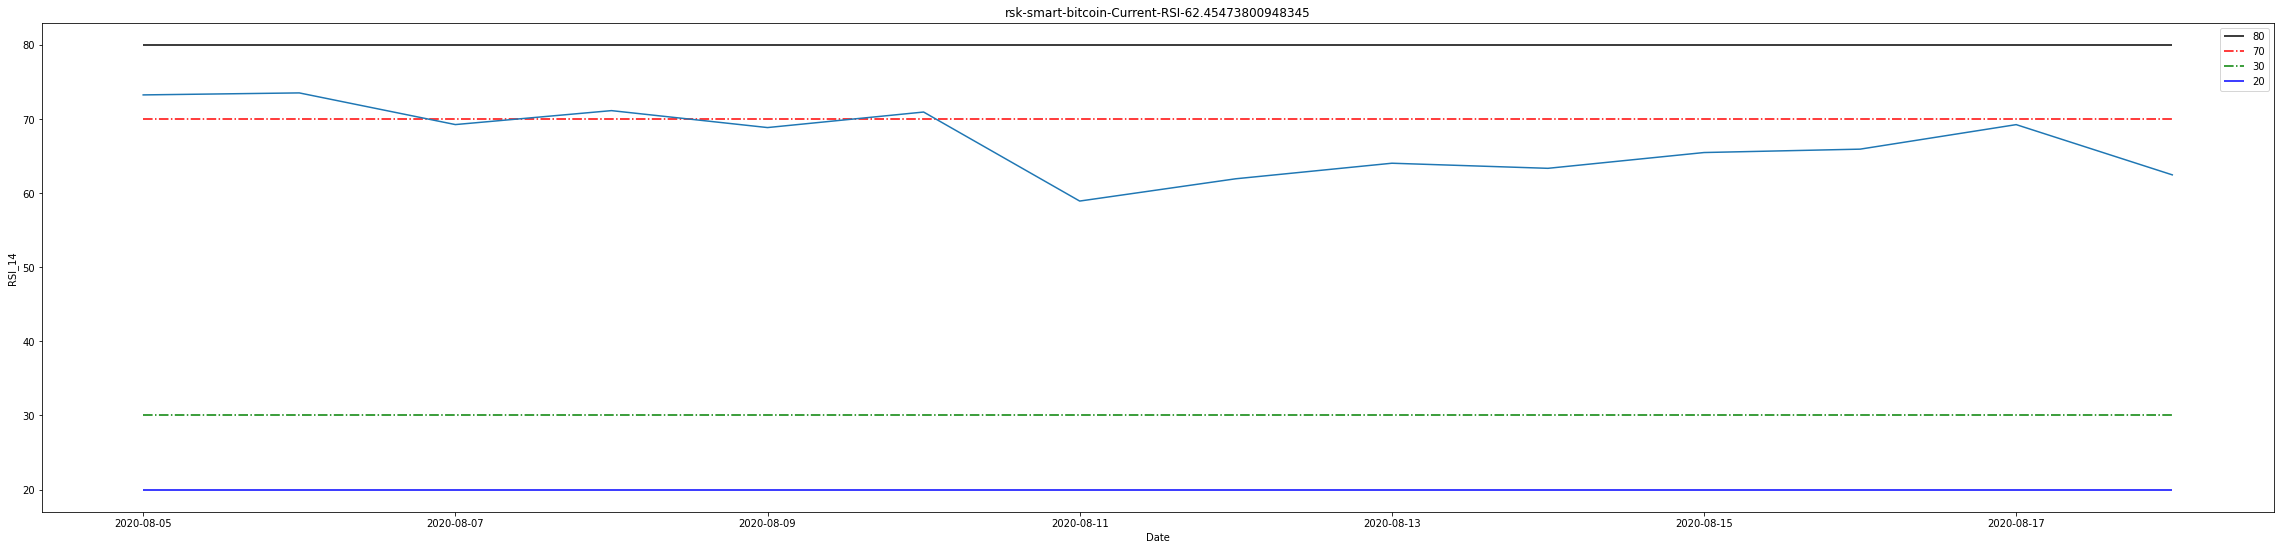

Plotting RSI (38.35712846887196) for:  energi


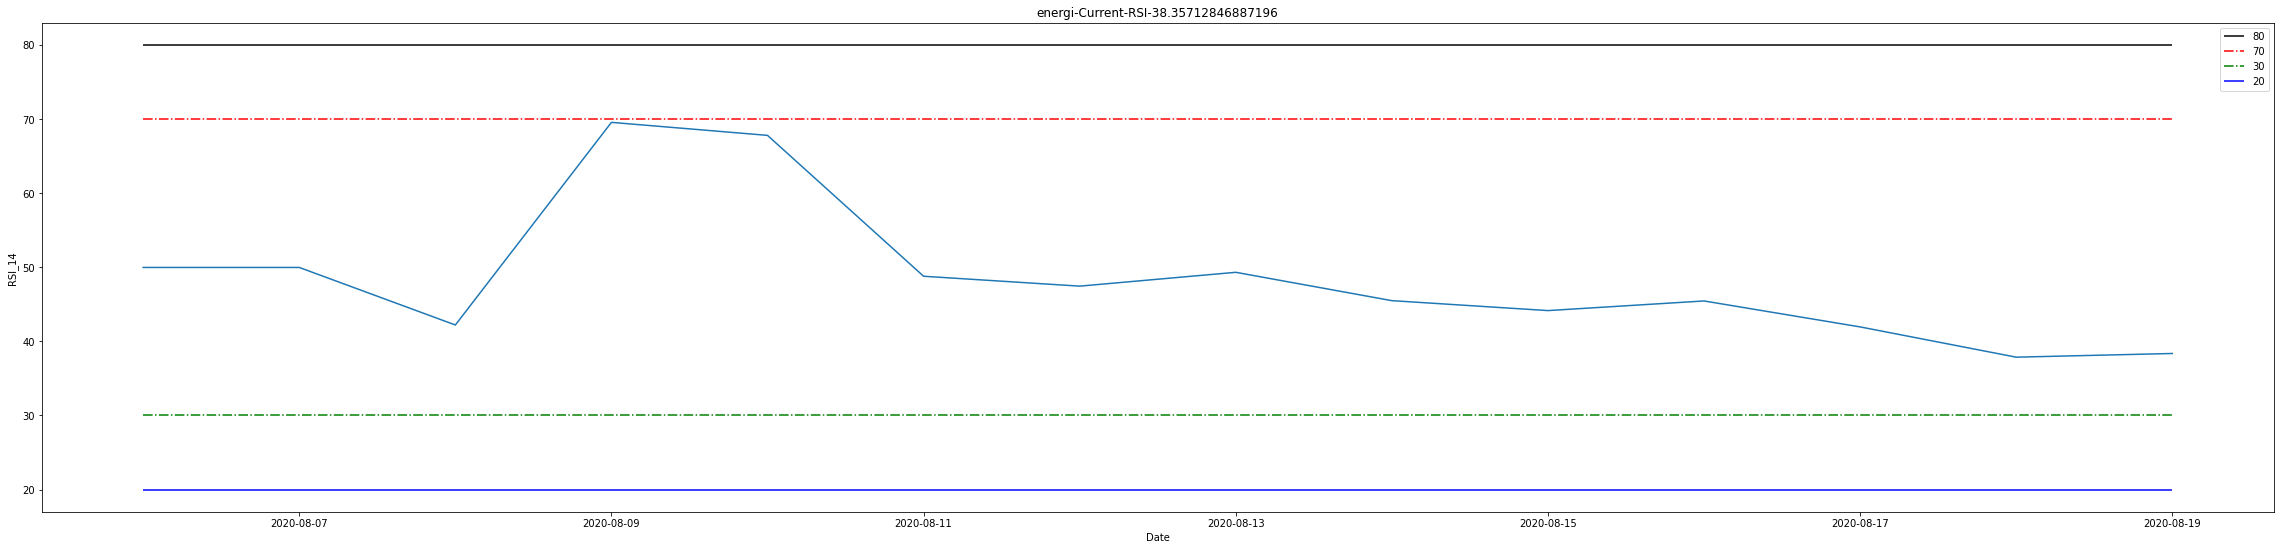

Plotting RSI (75.62591548763199) for:  oneledger


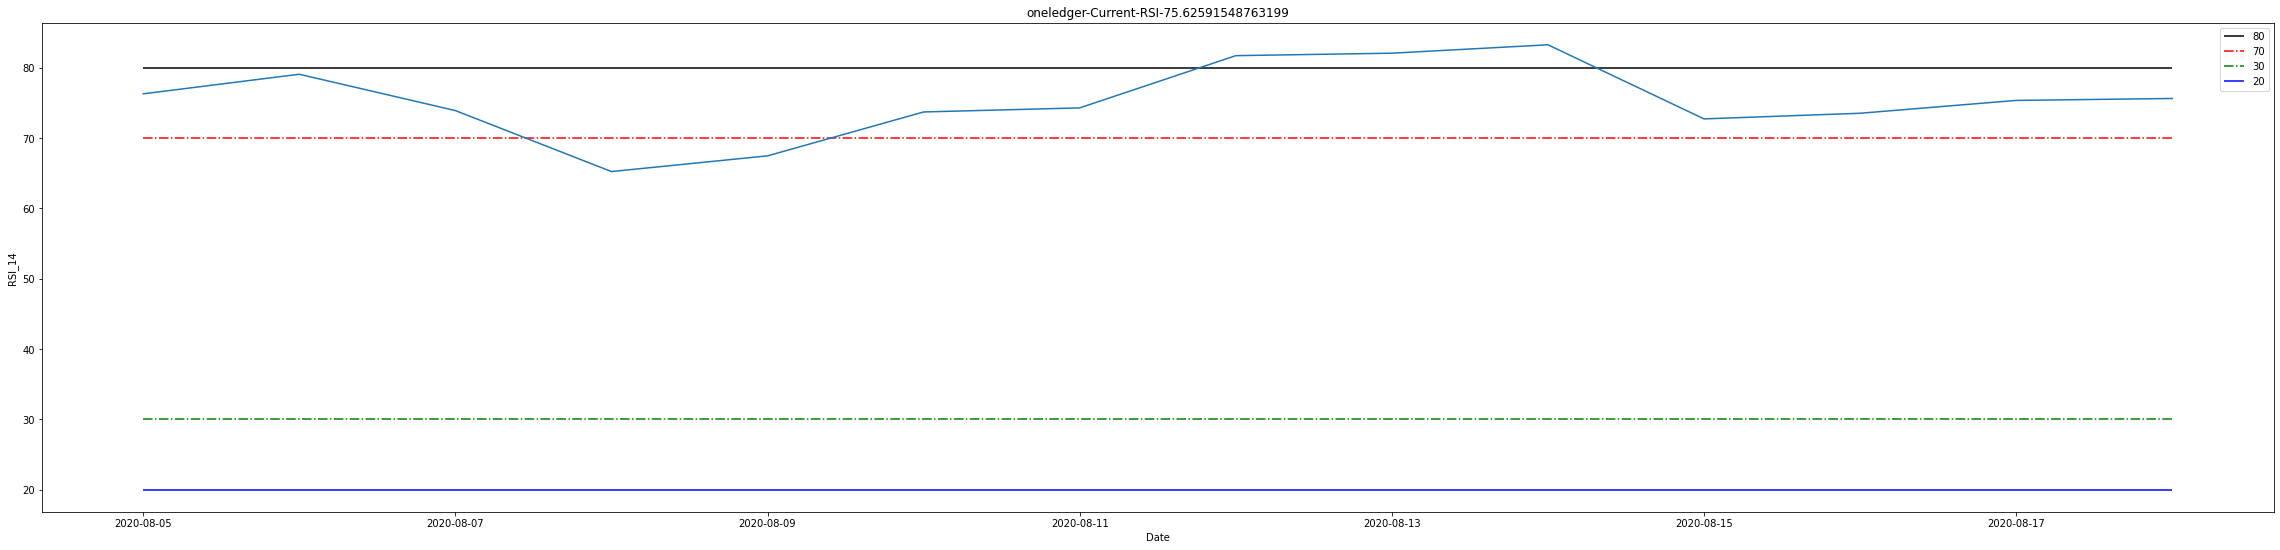

Plotting RSI (58.244993085225644) for:  crypto-com-coin


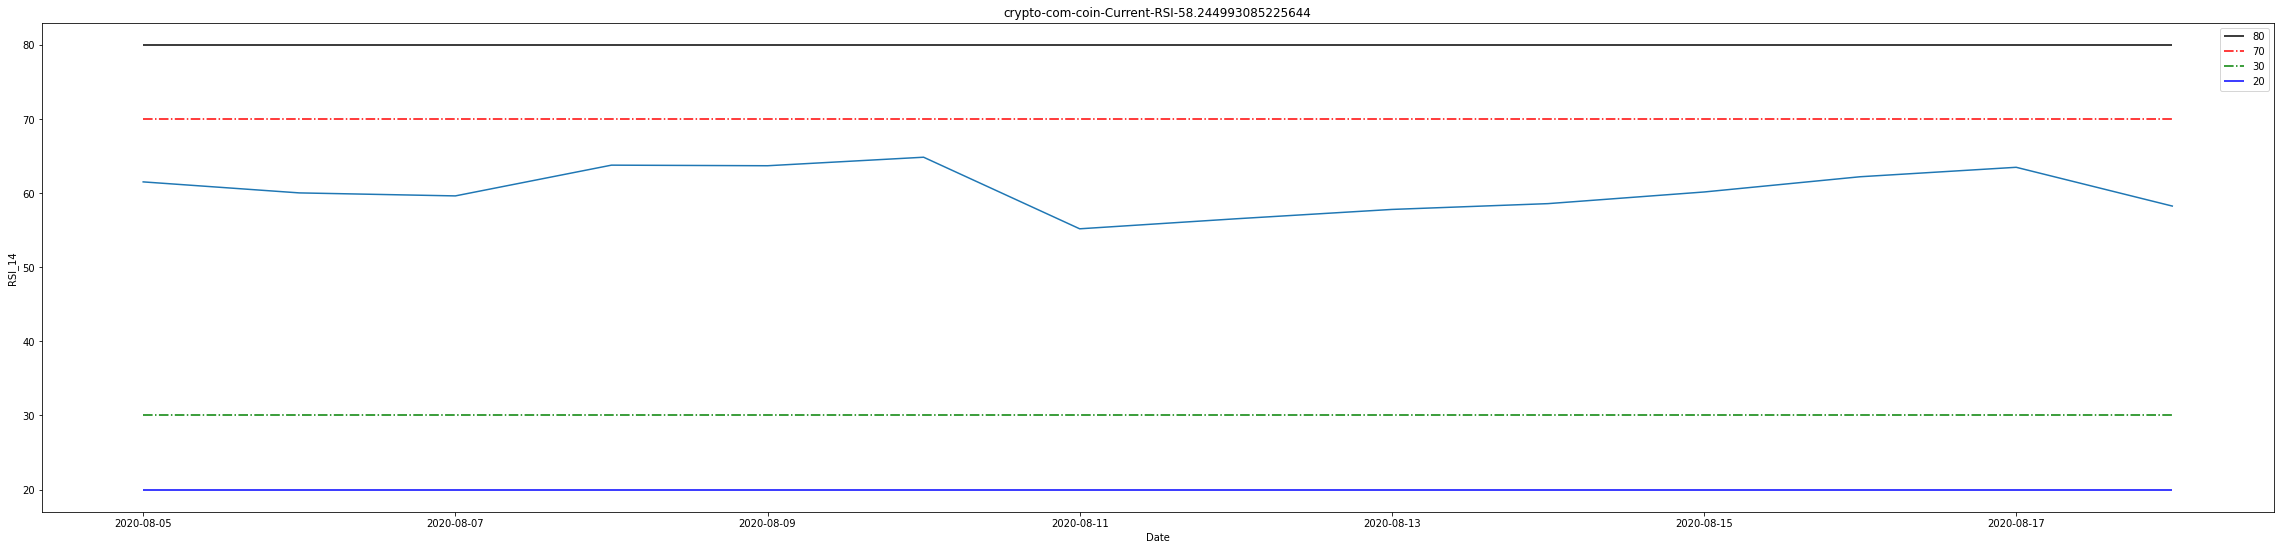

Plotting RSI (39.11130277445036) for:  casino-betting-coin


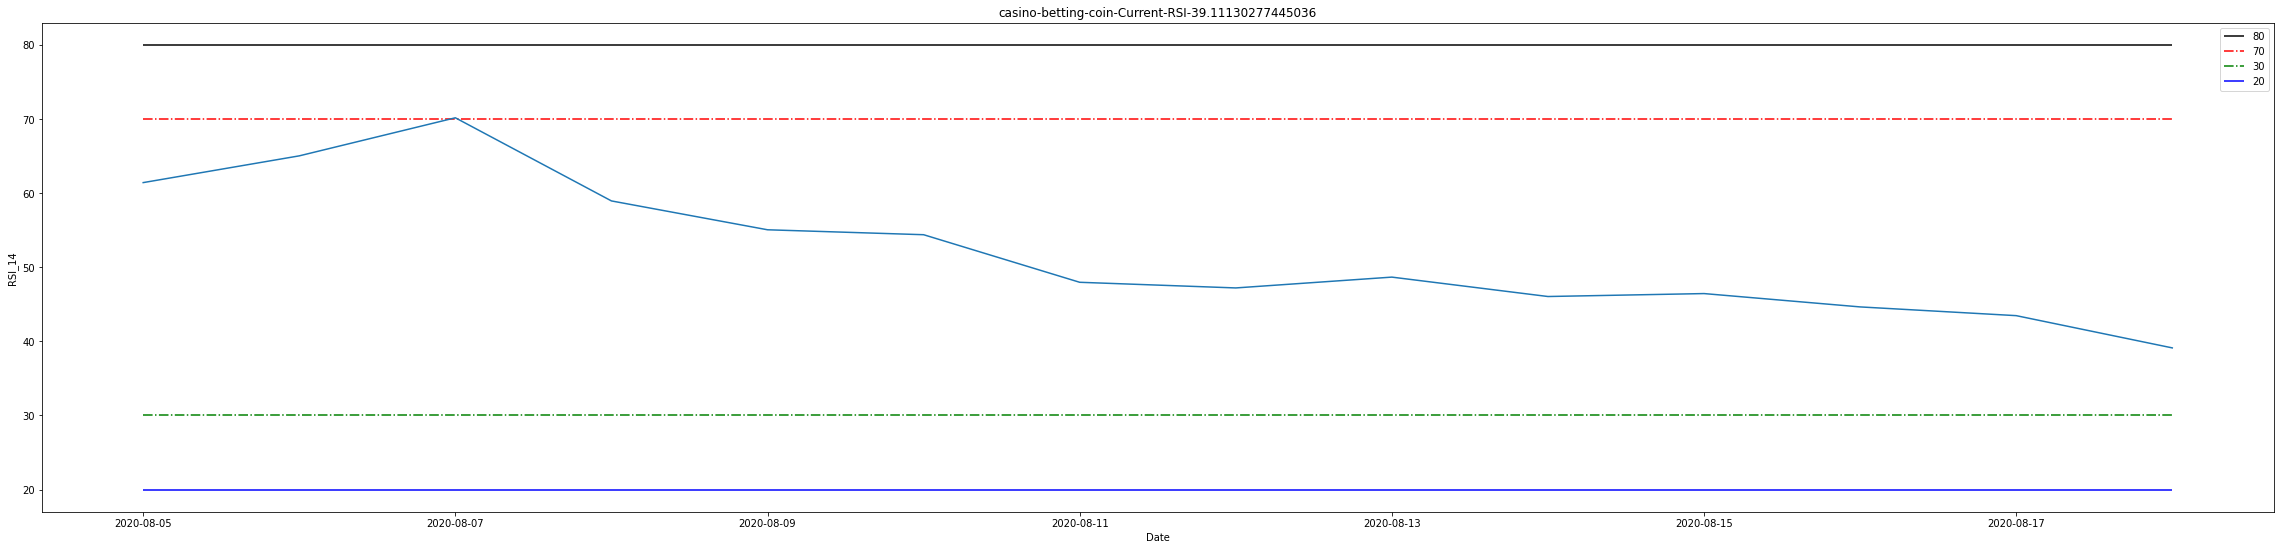

Plotting RSI (56.865136635369254) for:  nano


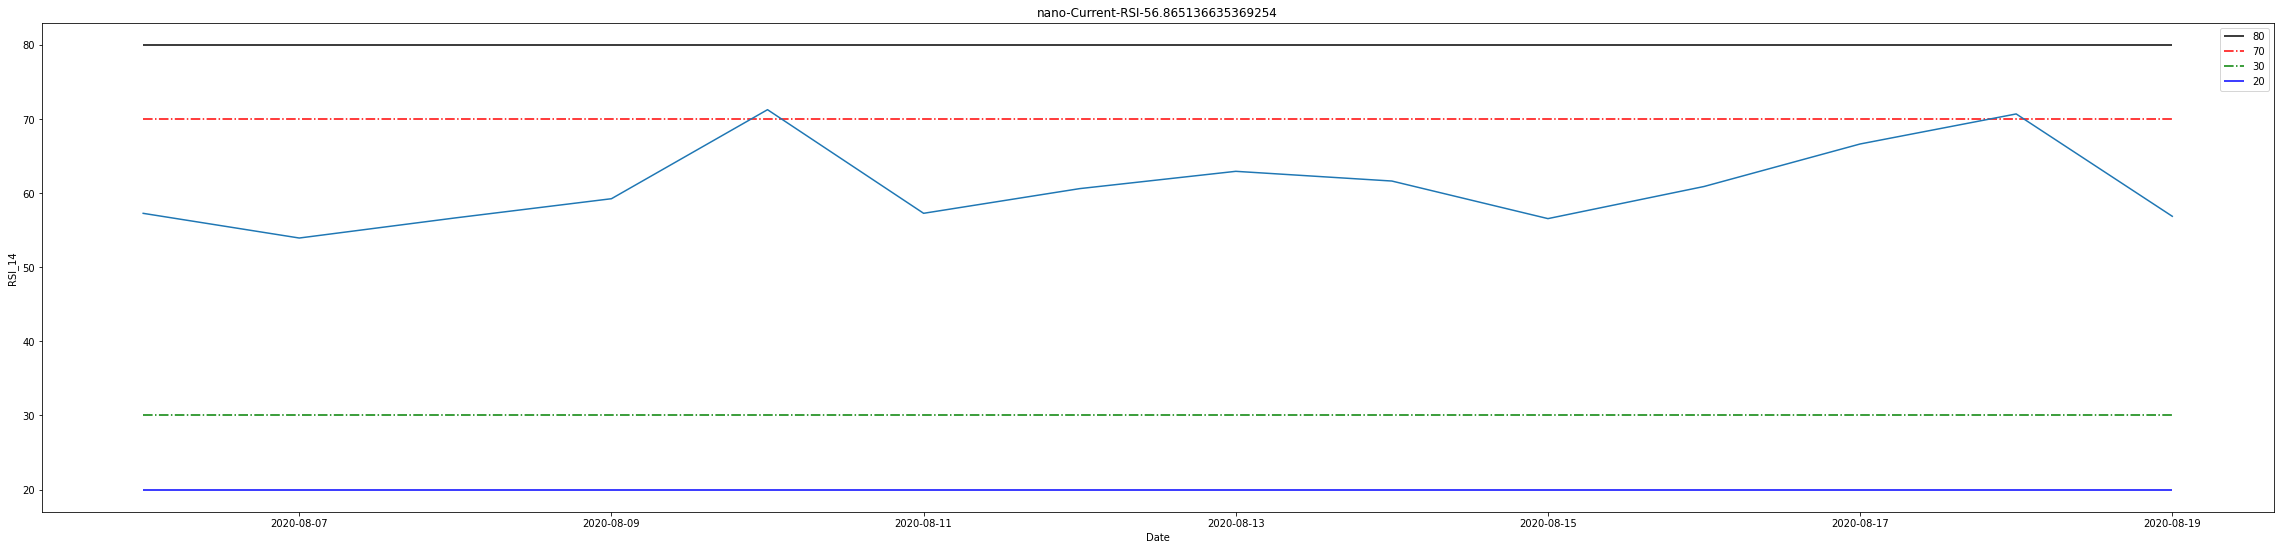

Plotting RSI (51.68840089113957) for:  kusama


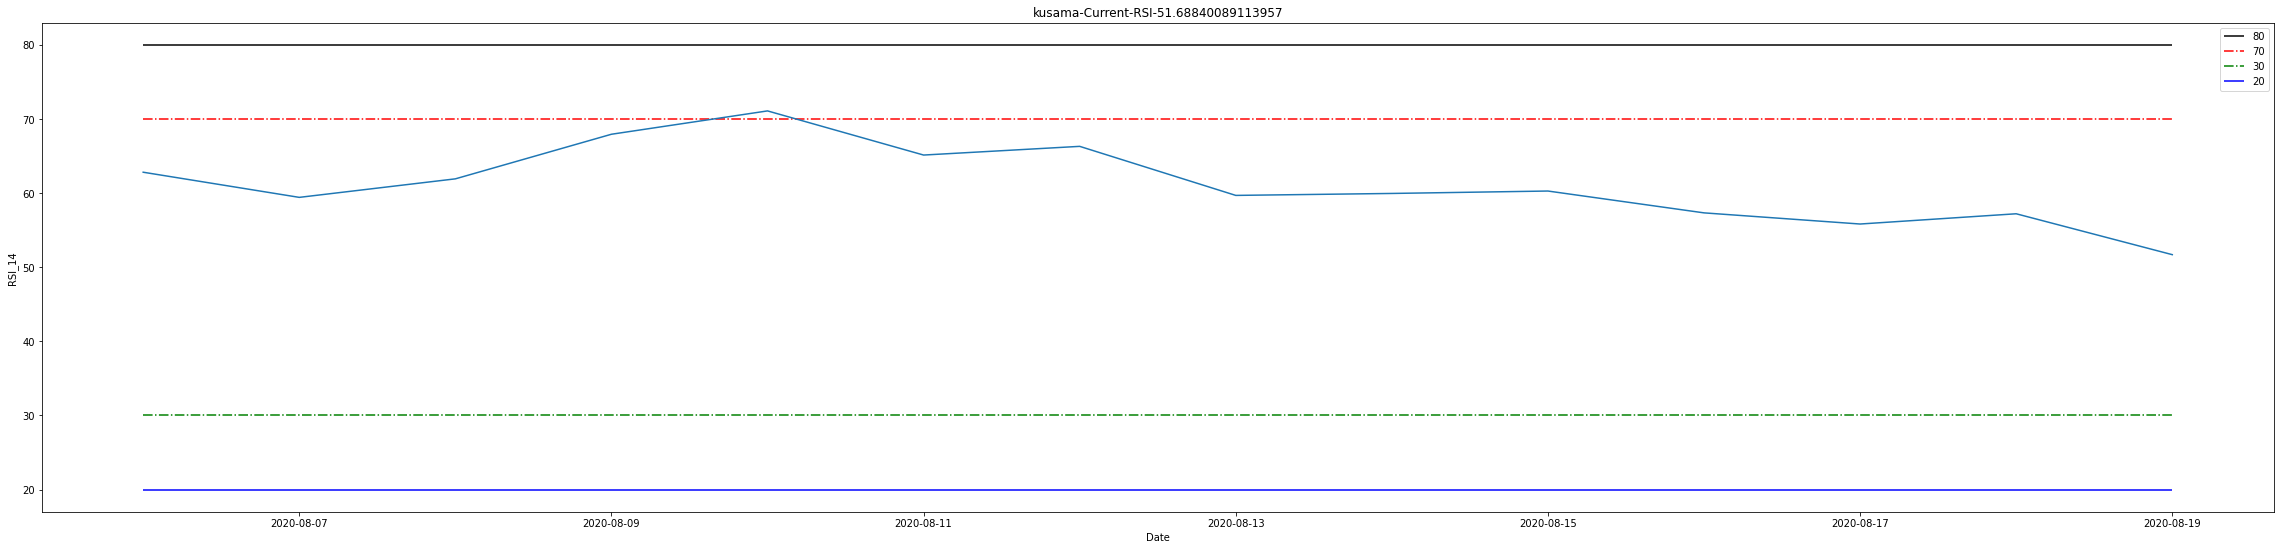

Plotting RSI (57.07866711212954) for:  ankr


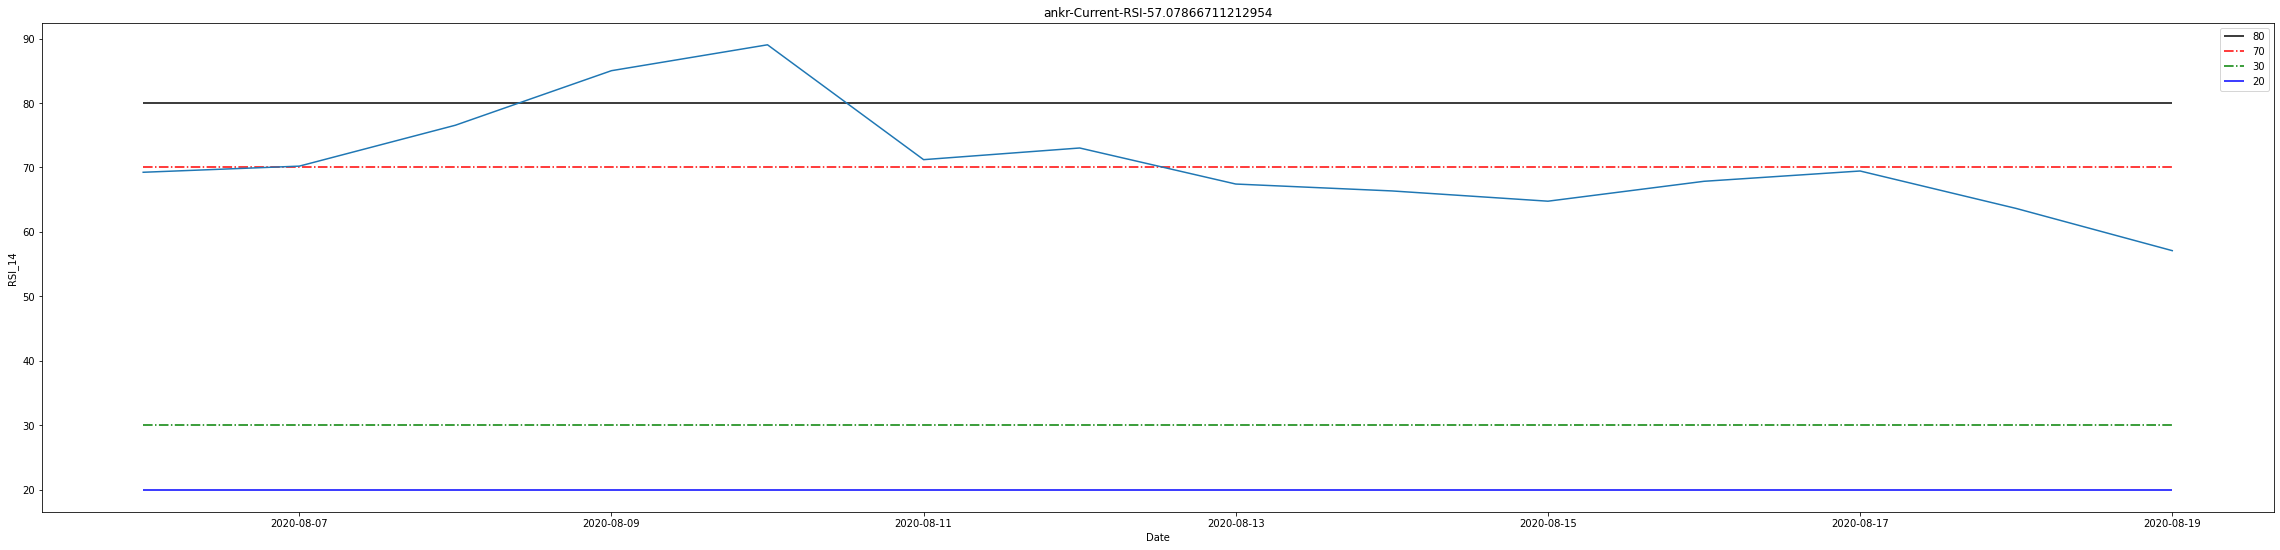

Plotting RSI (52.466526265061454) for:  digitalbits


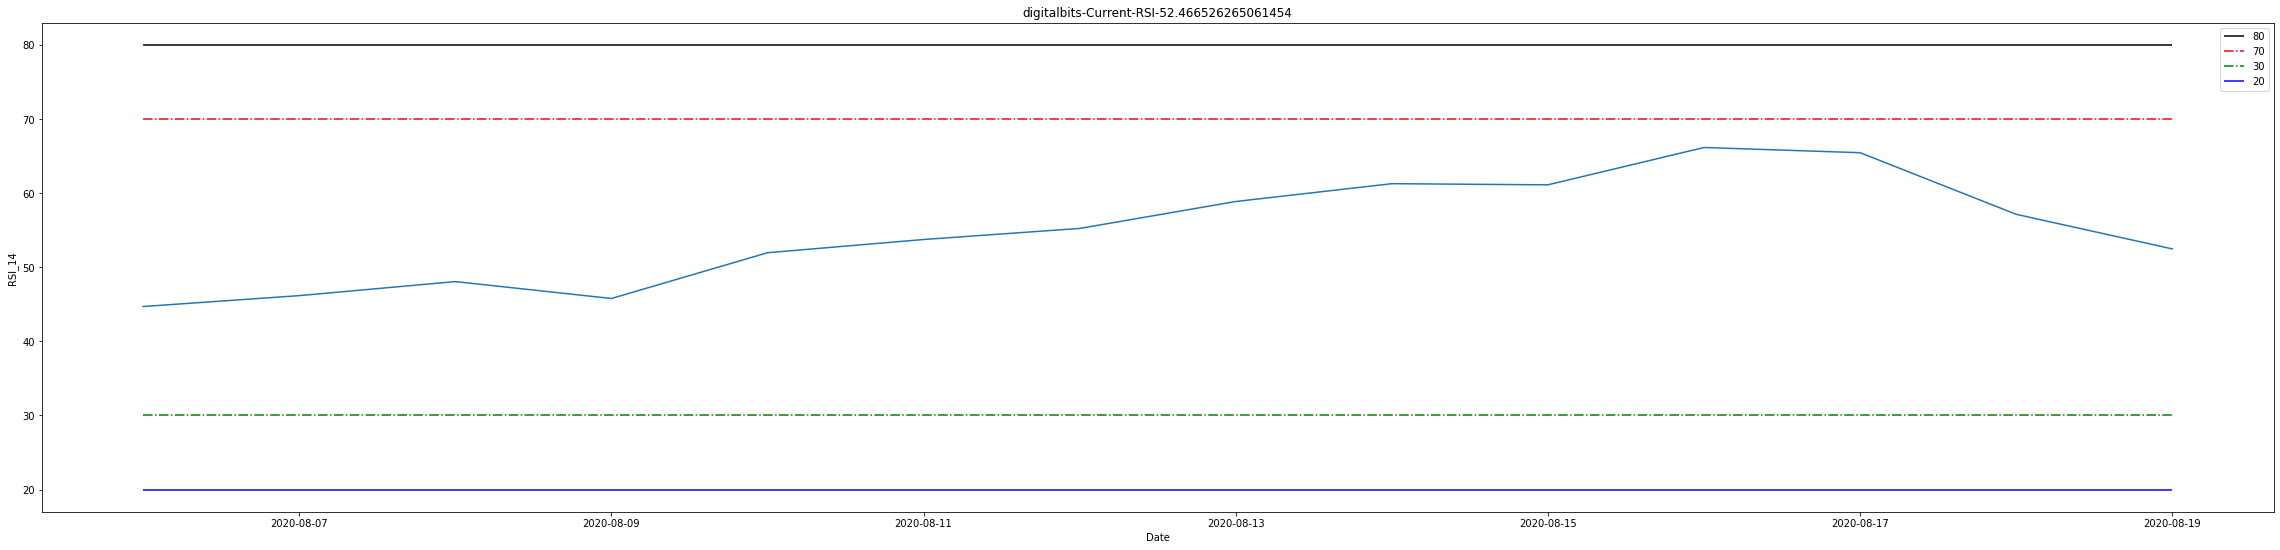

Plotting RSI (56.365986957456535) for:  quarkchain


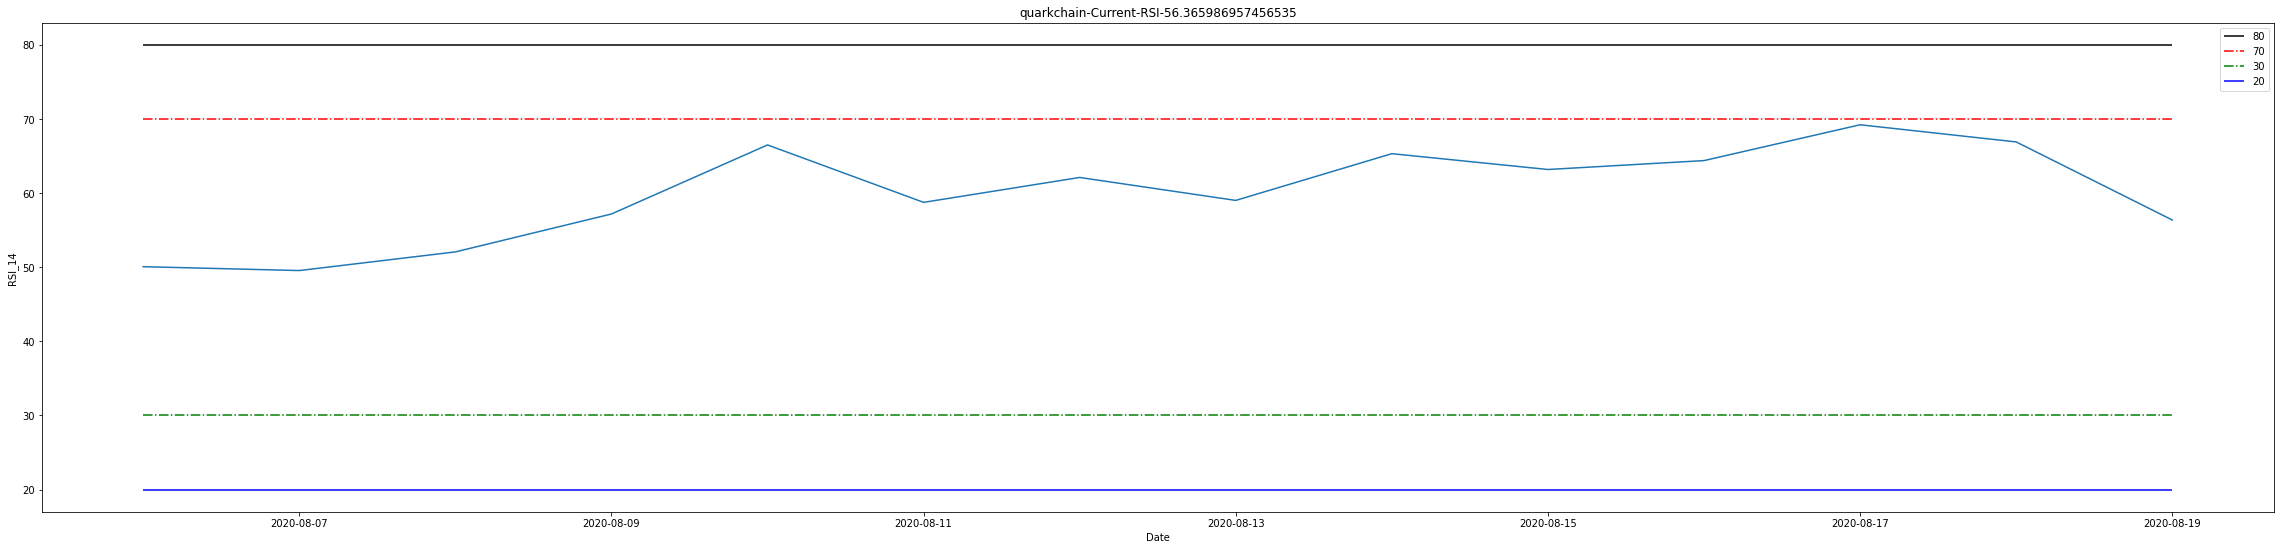

Plotting RSI (50.71235901524521) for:  gamb


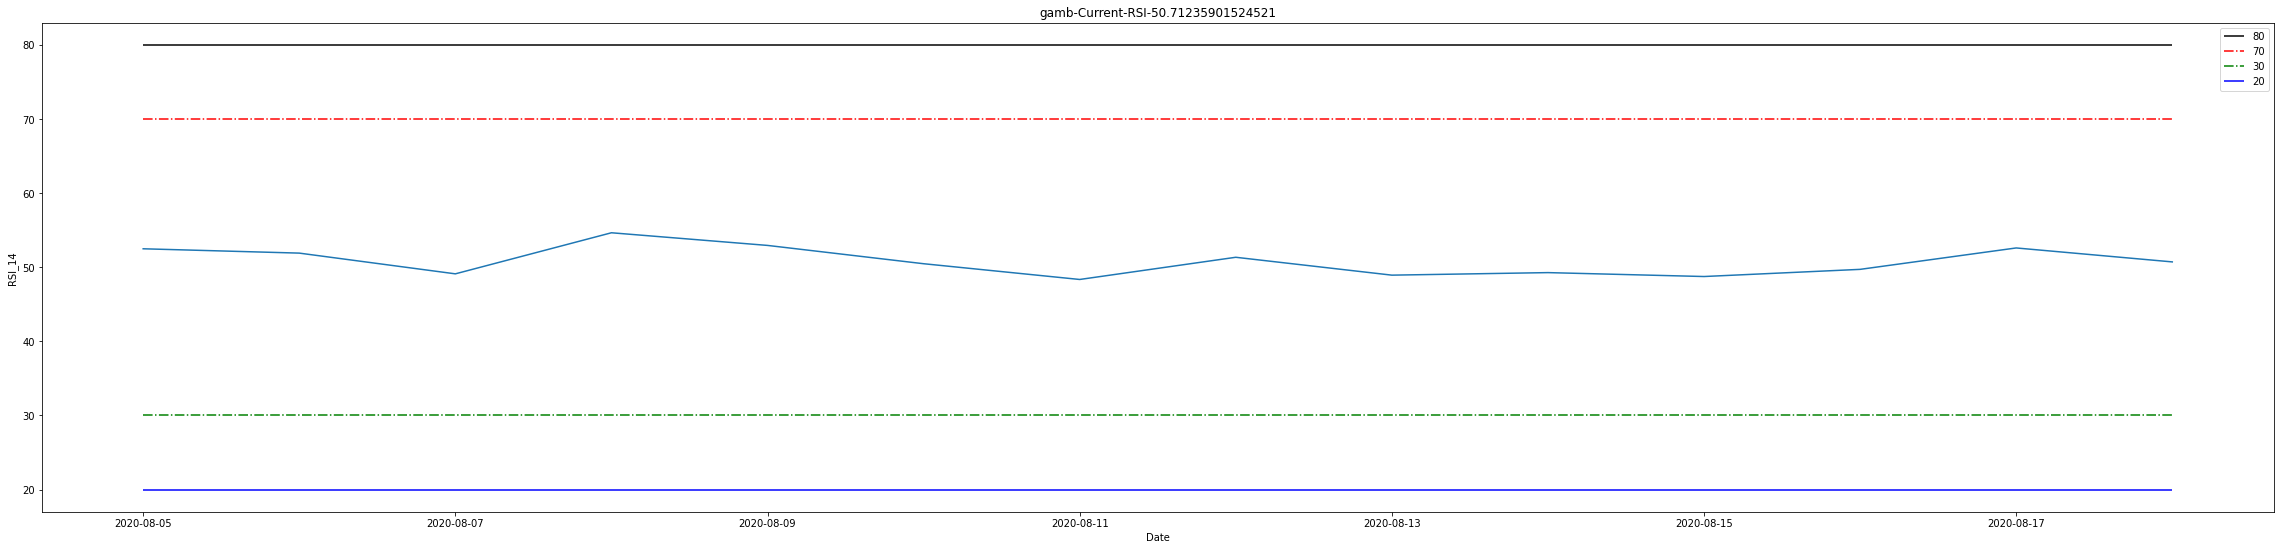

Plotting RSI (47.02787021563549) for:  opacity


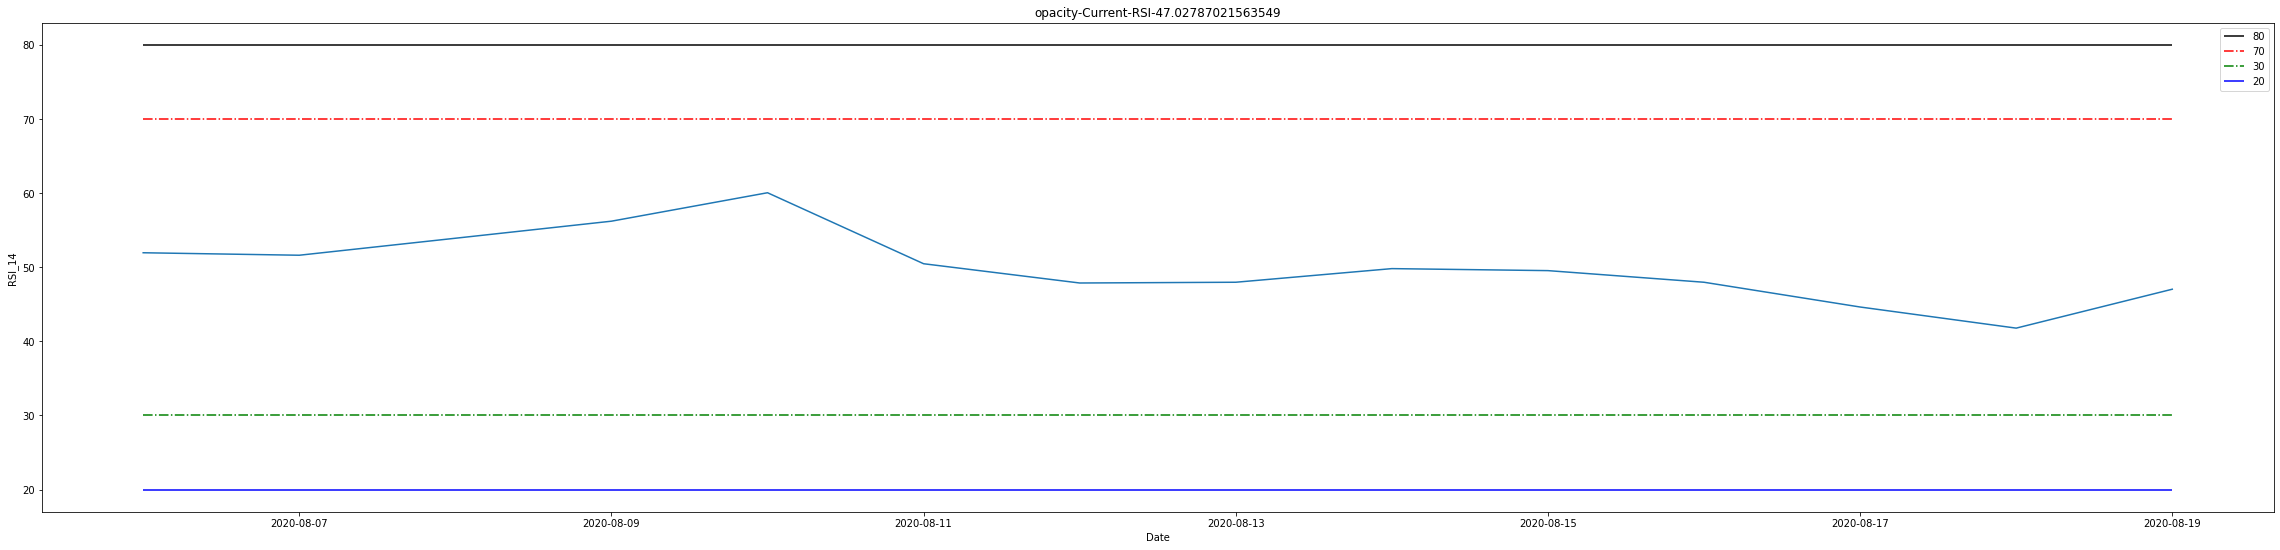

Plotting RSI (58.84201055500332) for:  neblio


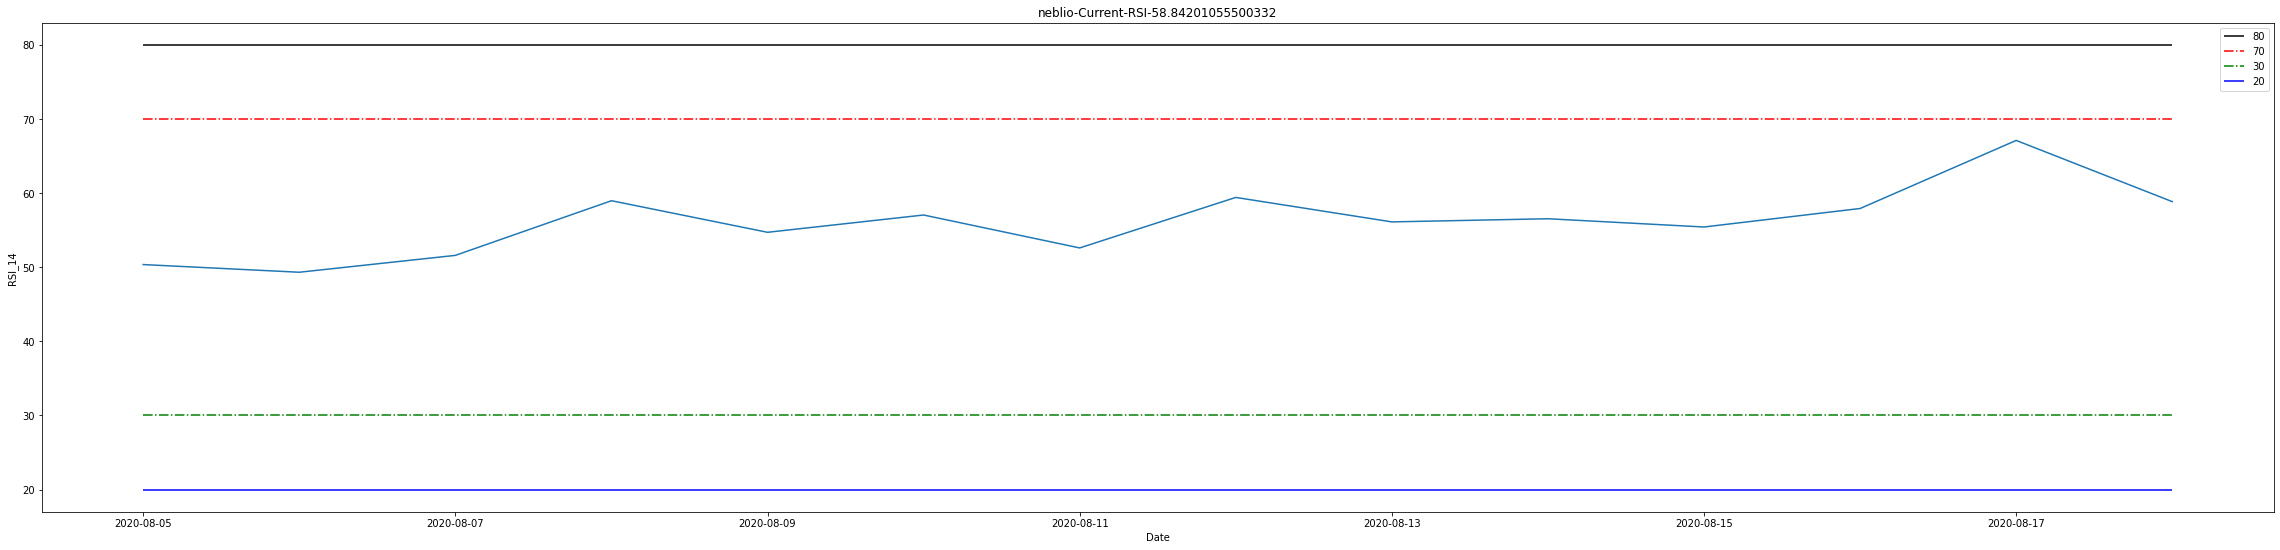

Plotting RSI (64.08460792382475) for:  carvertical


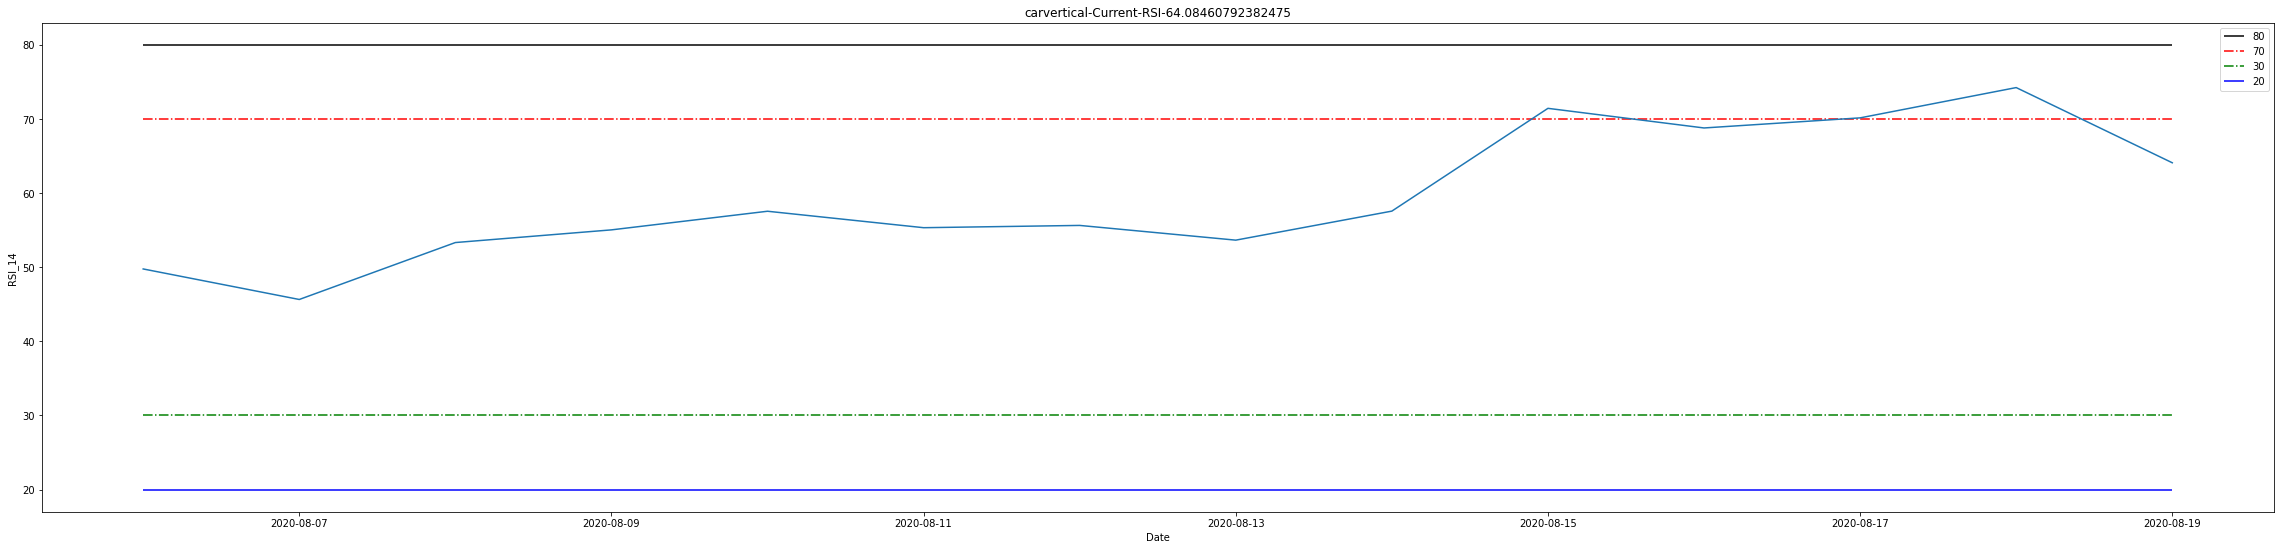

Plotting RSI (35.801663073407724) for:  digitex-futures


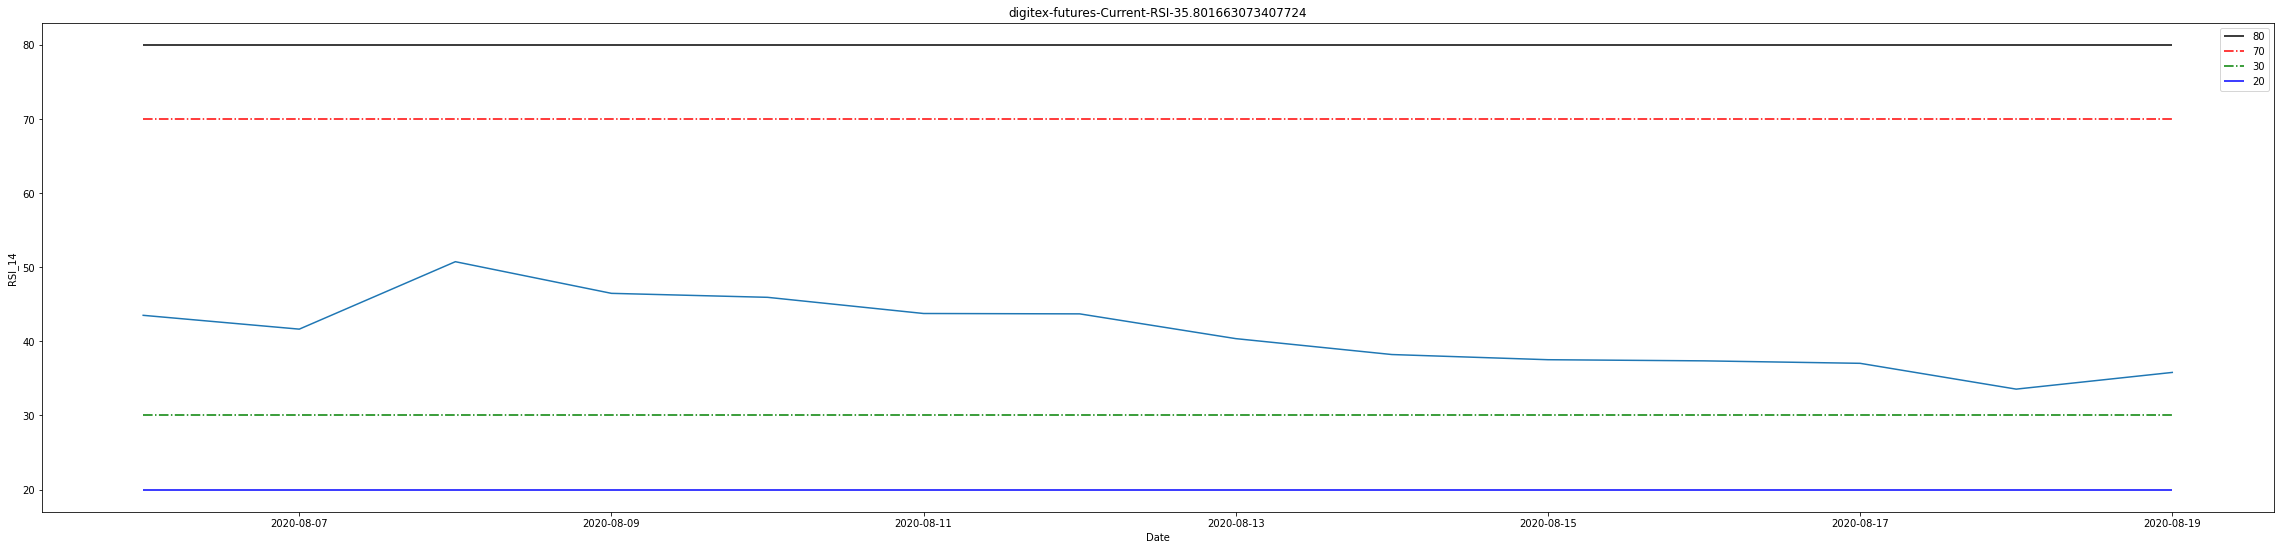

Plotting RSI (46.45448380938216) for:  wirex-token


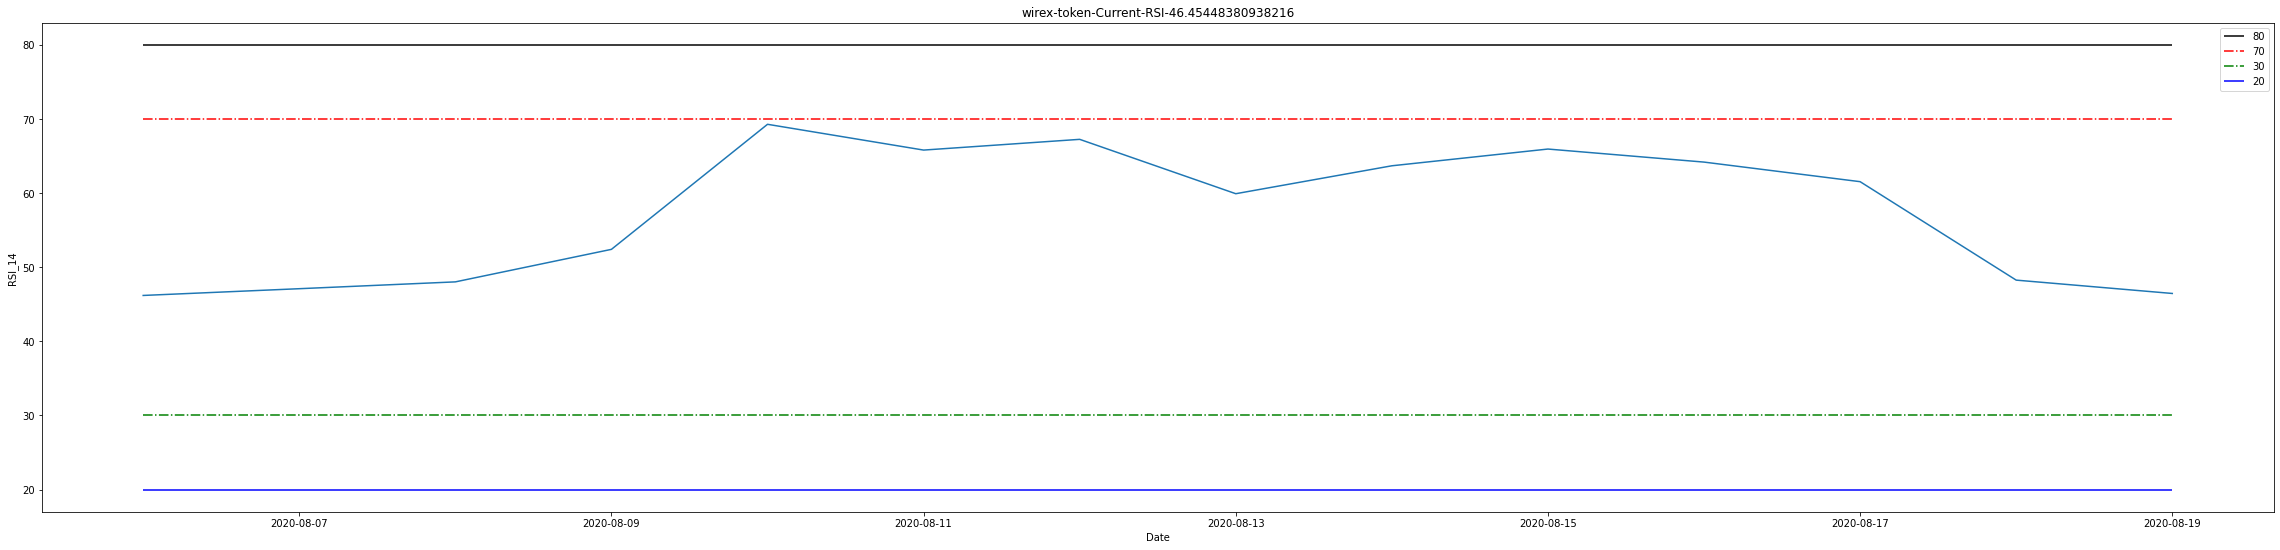

Plotting RSI (49.98404642171498) for:  fortknoxster


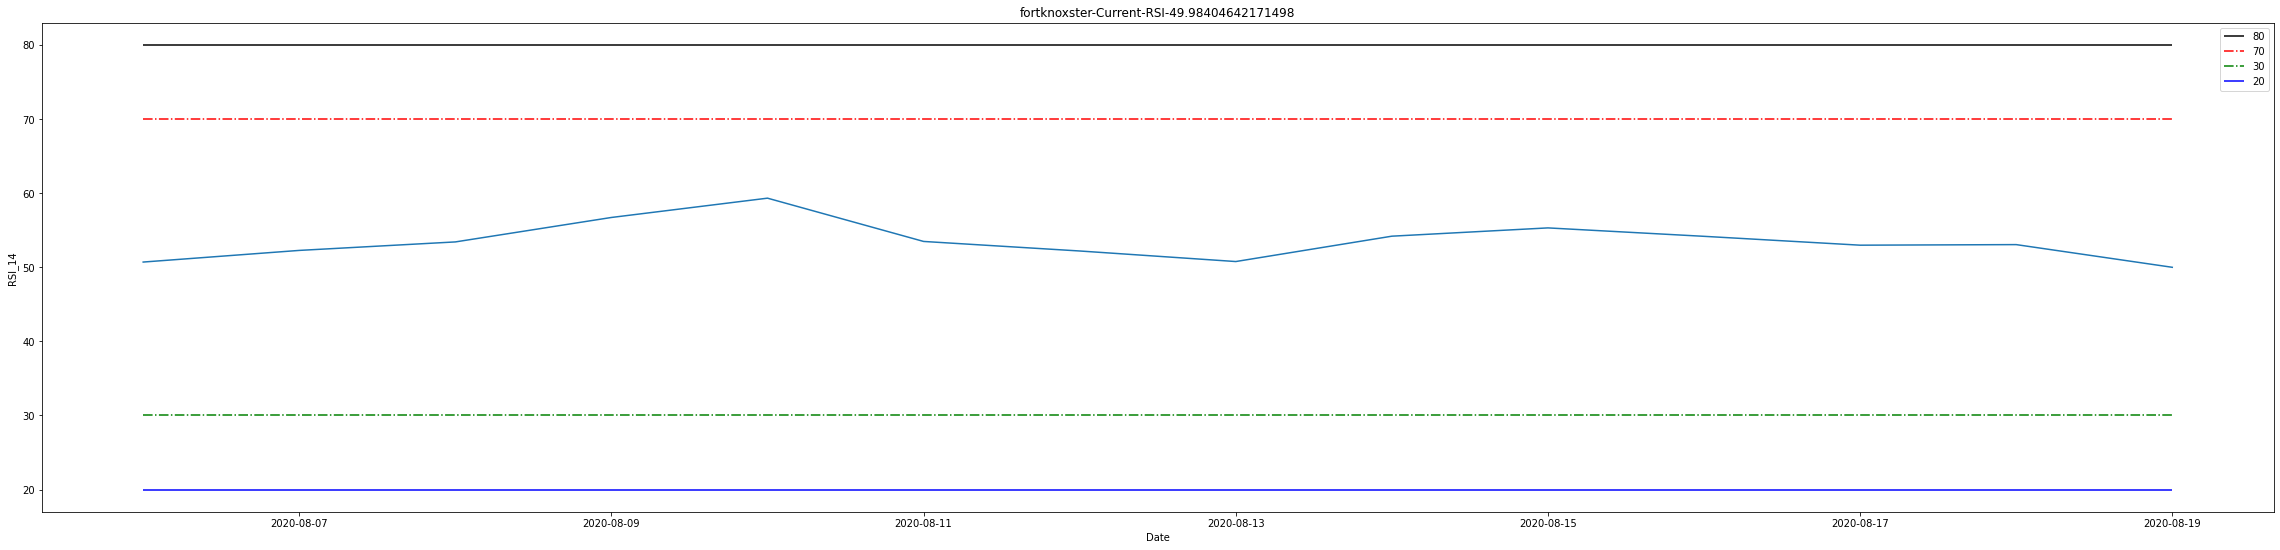

Plotting RSI (89.99360190253535) for:  newscrypto


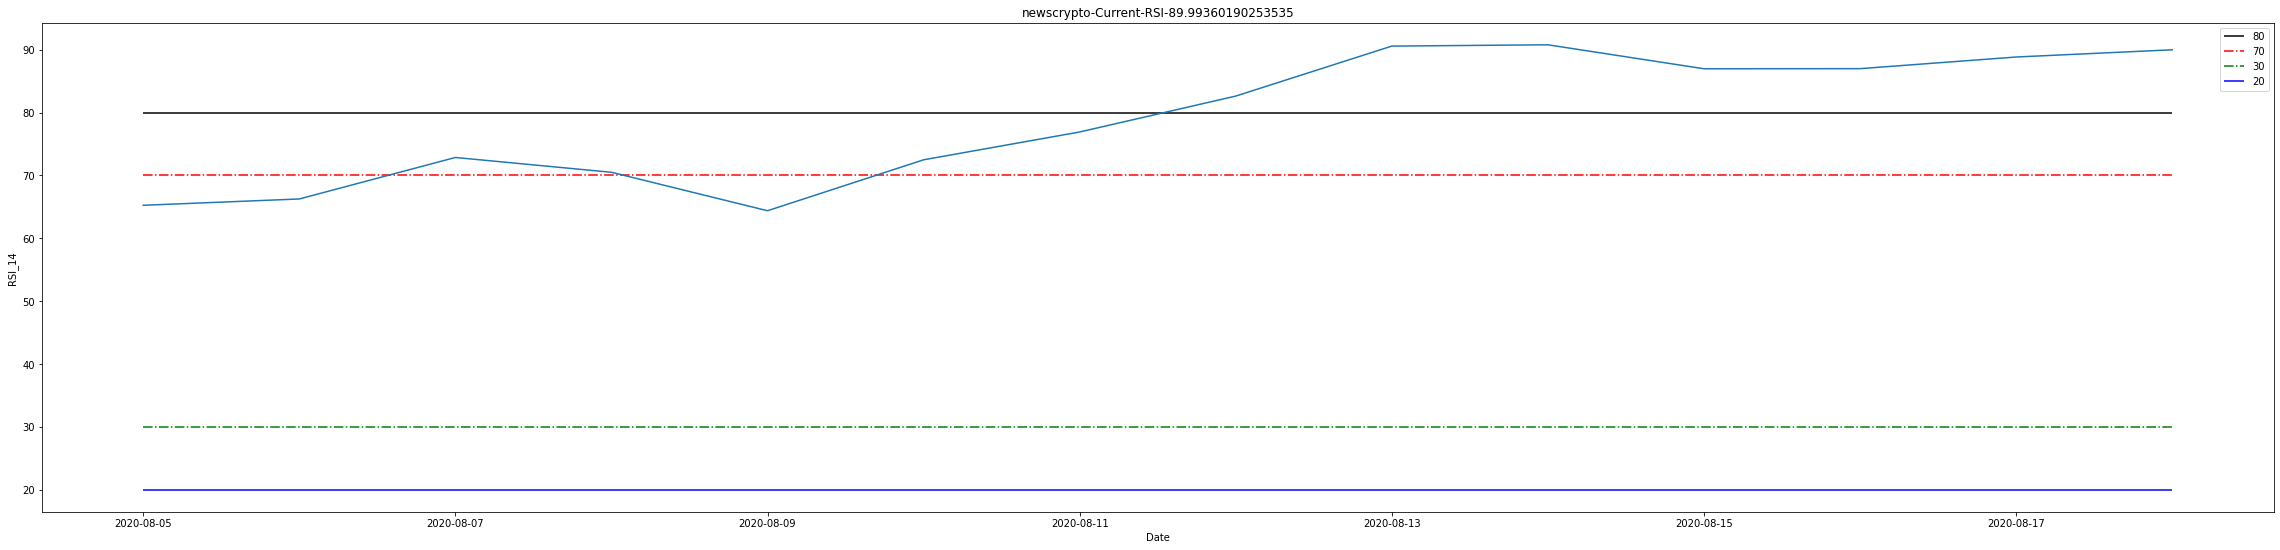

Plotting RSI (45.17636030950767) for:  jarvis


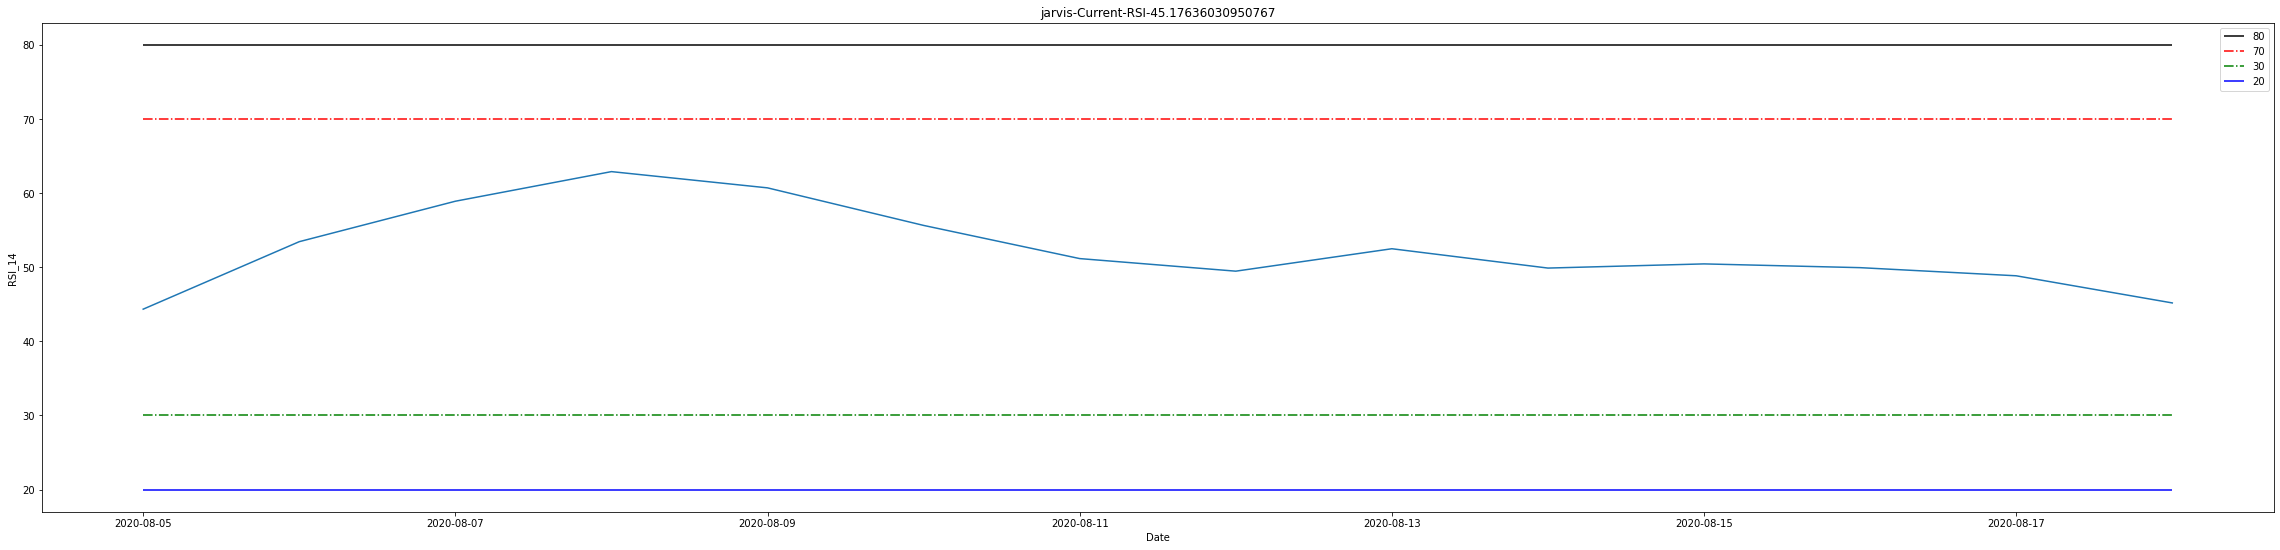

Plotting RSI (57.68085525904449) for:  elastos


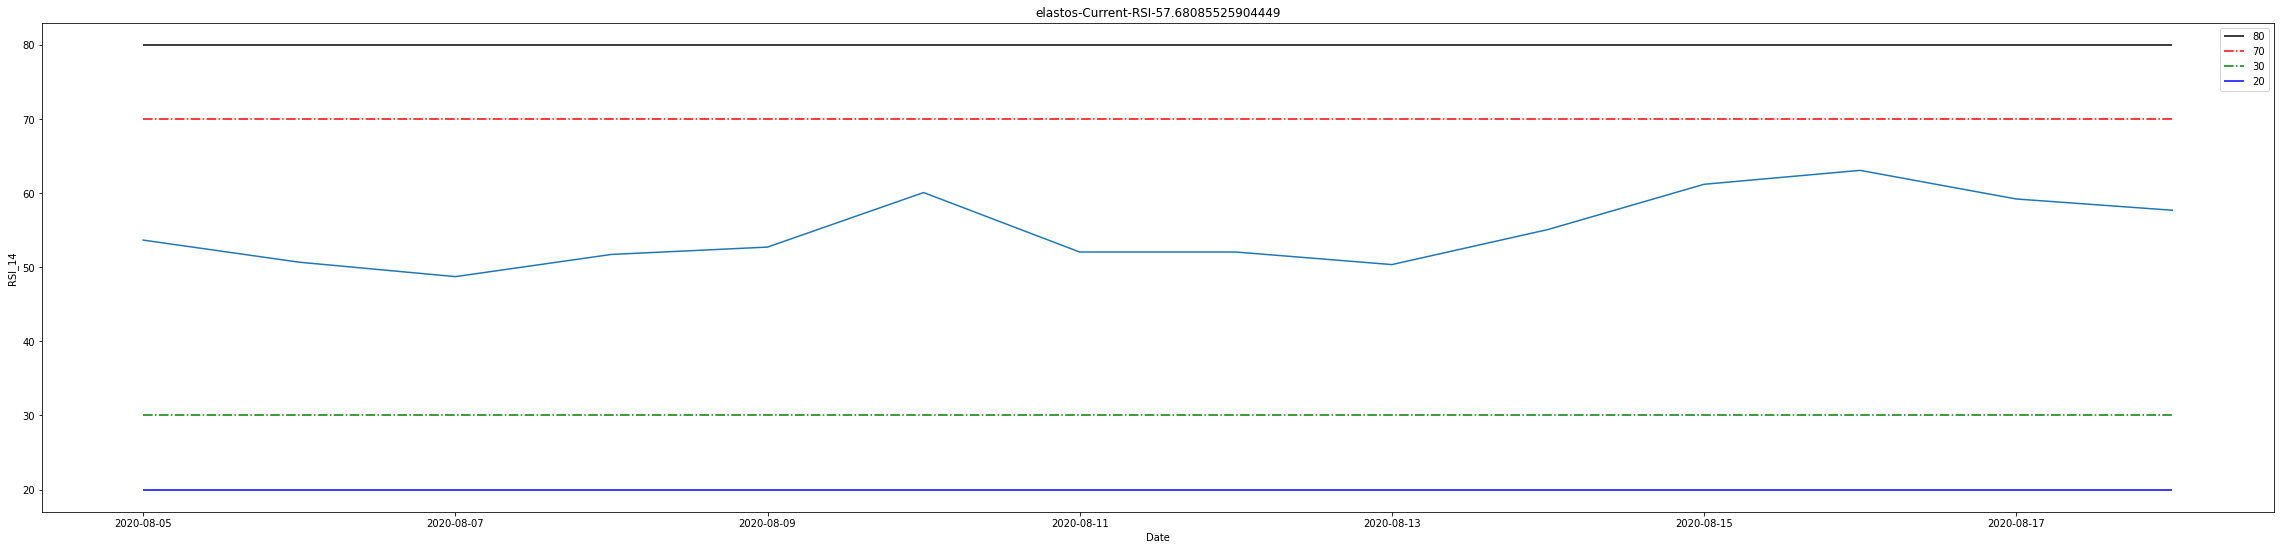

Plotting RSI (nan) for:  terra-sdt


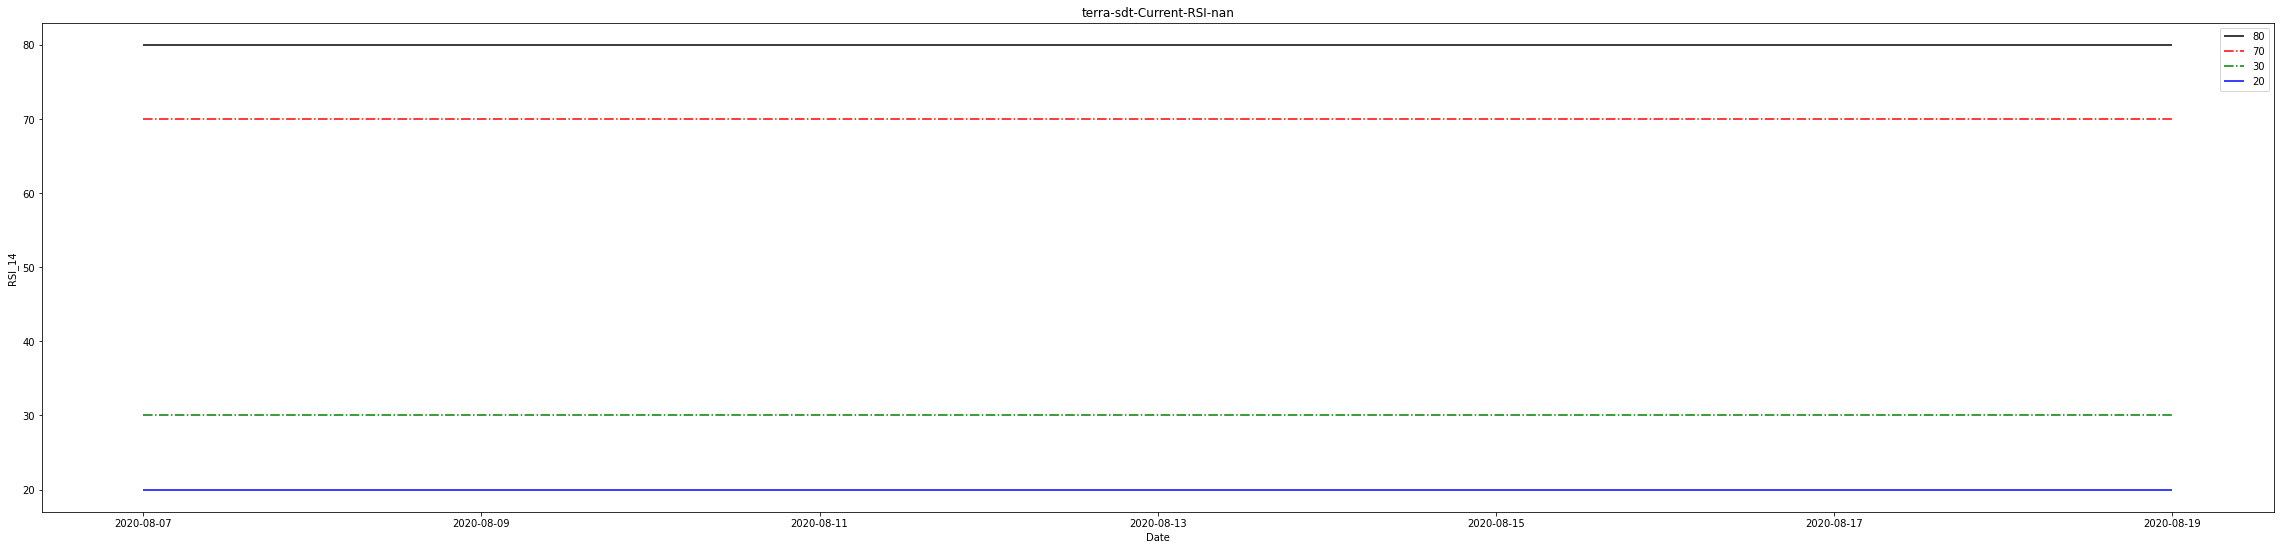

Plotting RSI (46.91650676969686) for:  sylo


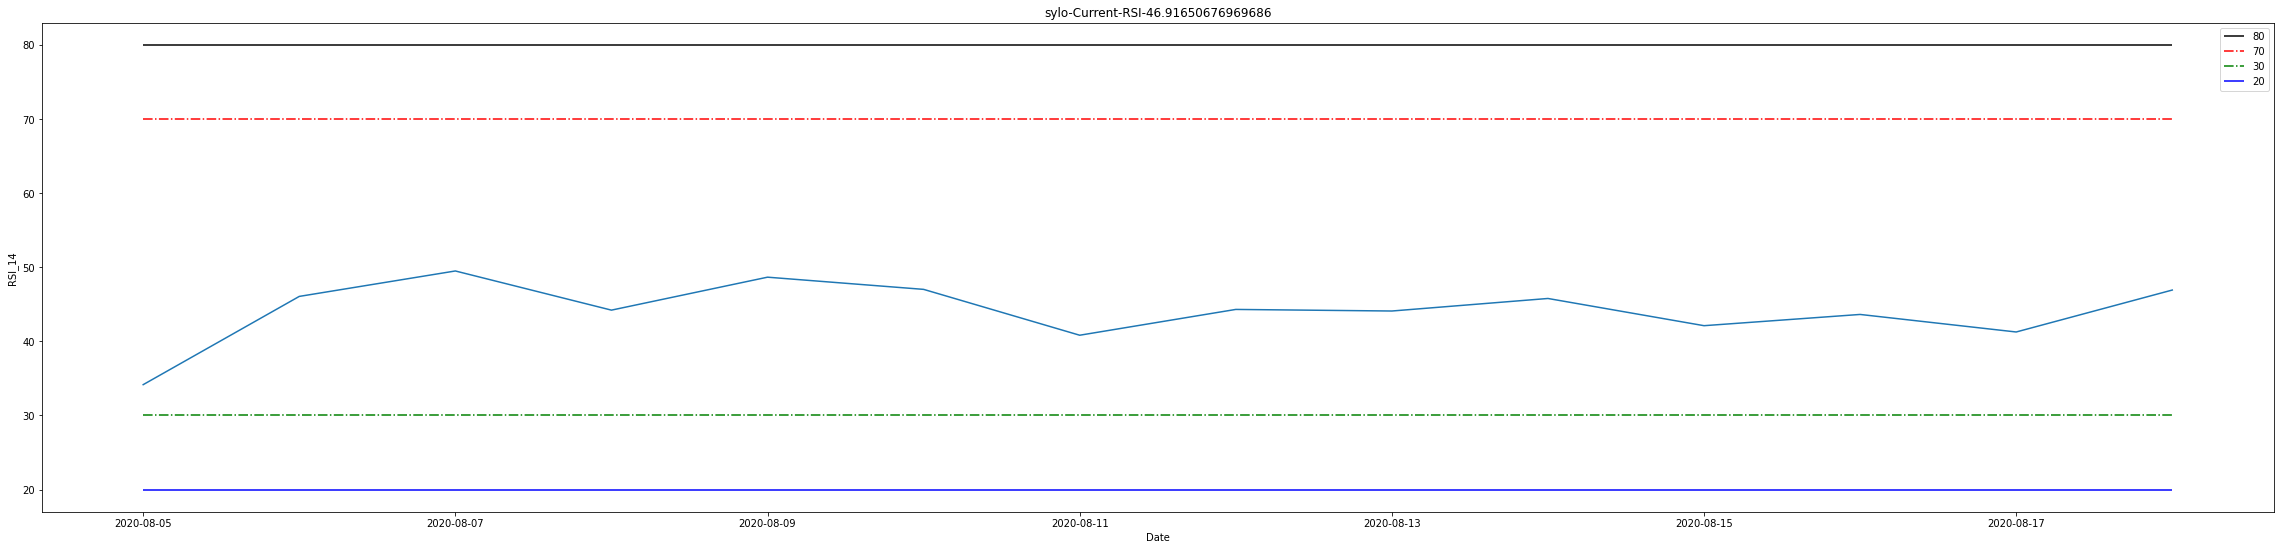

Plotting RSI (59.81087314877703) for:  neutrino-dollar


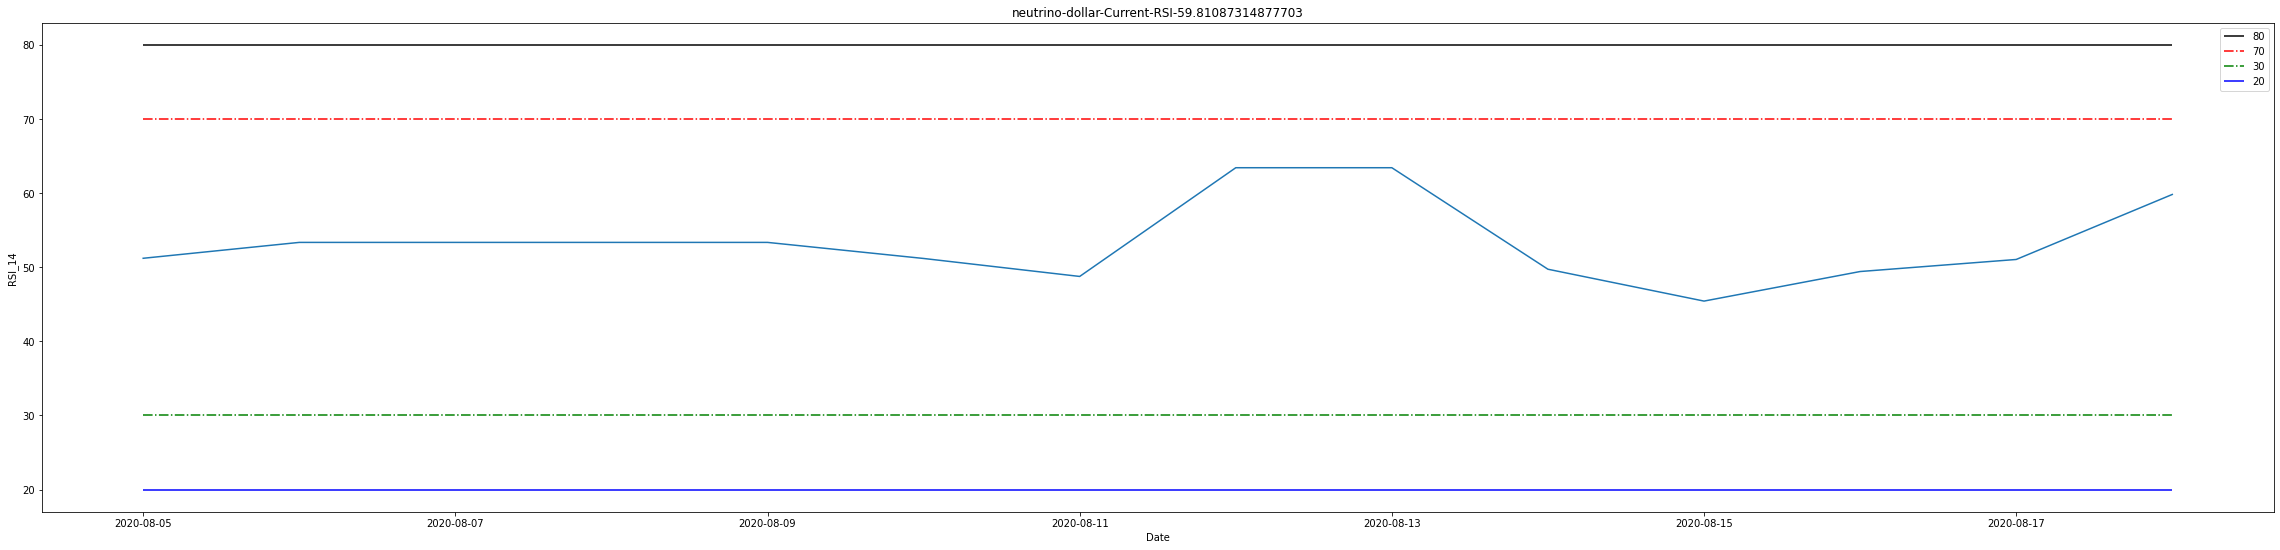

Plotting RSI (49.139945444382164) for:  loki


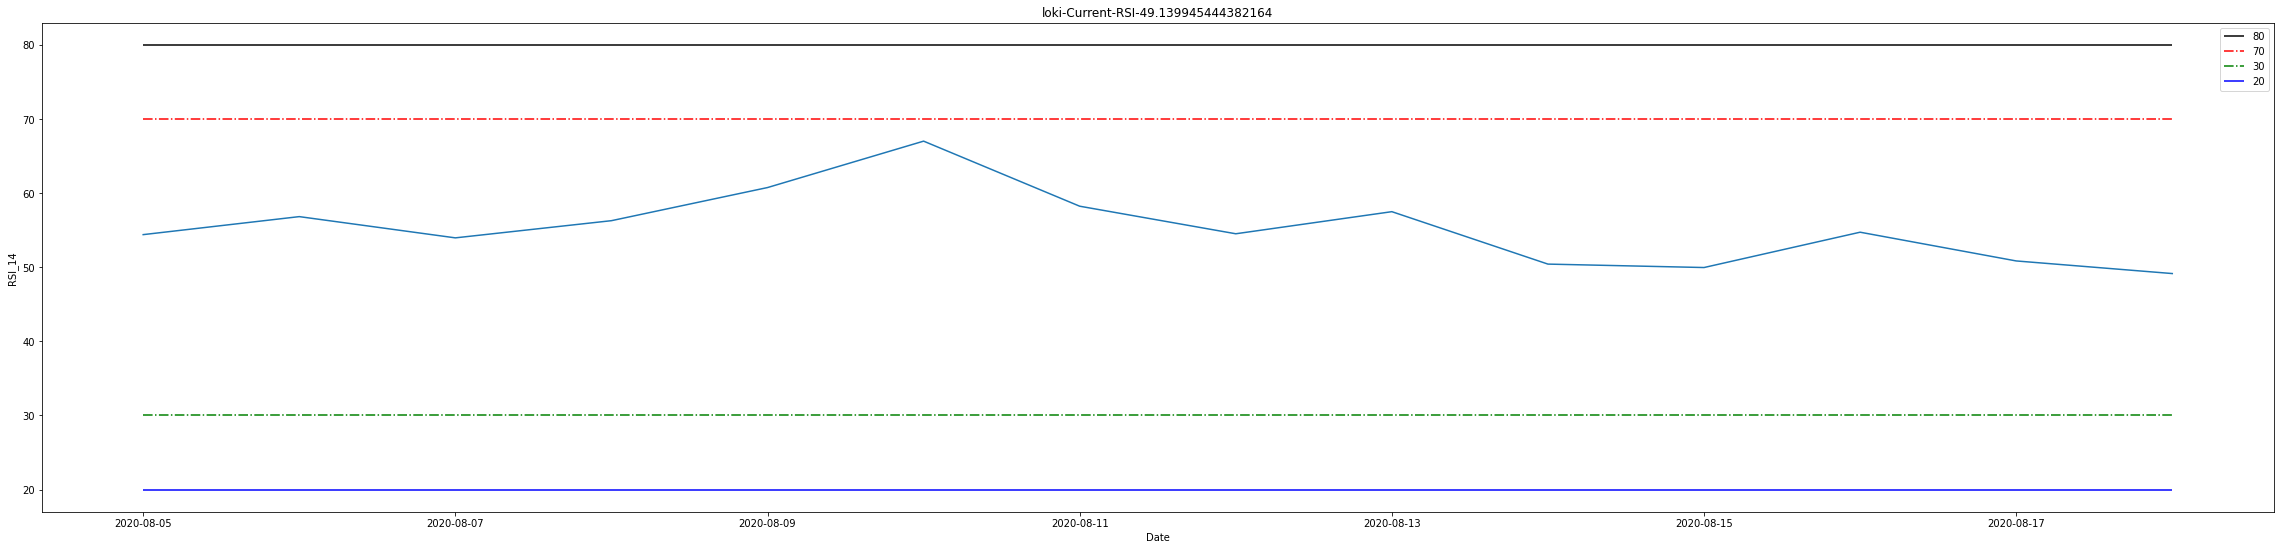

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date</th>
      <th>Name</th>
      <th>Price</th>
      <th>RSI</th>
      <th>MarketCap</th>
      <th>Volume</th>
      <th>URL</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>20200819</td>
      <td>aurora</td>
      <td>0.010758</td>
      <td>42.187023</td>
      <td>$69,623,976 USD</td>
      <td>$11,064,328 USD</td>
      <td>https://coinmarketcap.com/currencies/aurora/historical-data/?start=20200501&amp;end=20200819</td>
    </tr>
    <tr>
      <th>1</th>
      <td>20200819</td>
      <td>eden</td>
      <td>0.003194</td>
      <td>61.808168</td>
      <td>$1,882,449 USD</td>
      <td>$98,028.04 USD</td>
      <td>https://coinmarketcap.com/currencies/eden/historical-data/?start=20200501&amp;end=20200819</td>
    </tr>
    <tr>
      <th>2</th>
      <td>20200819</td>
      <td>cargox</td>
      <td>0.018720</td>
      <td>56.580212</td>
      <

Date  ...                                                URL
123  20200819  ...  https://coinmarketcap.com/currencies/xensor/hi...
55   20200819  ...  https://coinmarketcap.com/currencies/suku/hist...
194  20200819  ...  https://coinmarketcap.com/currencies/digitex-f...
73   20200819  ...  https://coinmarketcap.com/currencies/trueflip/...
144  20200819  ...  https://coinmarketcap.com/currencies/doc-com/h...
..        ...  ...                                                ...
197  20200819  ...  https://coinmarketcap.com/currencies/newscrypt...
16   20200819  ...  https://coinmarketcap.com/currencies/gramgold-...
84   20200819  ...  https://coinmarketcap.com/currencies/milk-alli...
121  20200819  ...  https://coinmarketcap.com/currencies/proof-of-...
200  20200819  ...  https://coinmarketcap.com/currencies/terra-sdt...

[204 rows x 7 columns]

In [40]:
# from coinscraper import coinscrapper

client = coinscrapper('20200819')
client.summary()

# Access Saved Variables

Using the client we can access the variables saved during the summary process. The variables will each contain a list relevant to each asset identified on CoinMarketCap.com under the KuCoin Exchange.

1.   client.todays_date
2.   client.names
3.   client.todays_price
4.   client.todays_RSI
5.   client.marketcaps
6.   client.volumes
7.   client.kucoin_list

Below is an example of how to access these variables using the client.


In [42]:
variables = [client.todays_date, client.names, client.todays_price, client.todays_RSI, client.marketcaps, client.volumes, client.kucoin_list]
for each in variables:
  print(len(each))

204
204
204
204
204
204
204


In [43]:
# Today's Date
print('Run date: ', client.todays_date)

# Tickers for Each Asset
print('Assets pulled: ', client.names)

# Closing Price for Each Asset
print('Latest Price: ', client.todays_price)

# 14 Day RSI as of Today
print('RSI-14: ', client.todays_RSI)

# Marketcap as of today
print('Market Cap: ', client.marketcaps)

# 24 Hour Volume 
print('24HR Volume: ', client.volumes)

# URL links to historical data page
print('Historic Data: ', client.kucoin_list)

Run date:  ['20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '20200819', '202

# Access Saved Datasets

Using the client we can also access the datasets saved during the summary process. The datasets are saved in a python list, and will contain historic data for each asset. The fundamental data and the RSI dataset are separte pythonic lists of datasets.

1.   client.technical_data
2.   client.fundamental_data
3.   client.rsi_data

Below is an example of how to access the saved datasets using the client.


In [47]:
# Historic Price Data
list_of_historic_data = client.technical_data 
print('Historic Price Data: ')
display(list_of_historic_data[0].head())

# Fundamental Data
list_of_fundamental_data = client.fundamental_data 
print('\nFundamental Data: \n')
display(list_of_fundamental_data[0].set_index(0).stack())

# RSI Data
list_of_RSI_data = client.rsi_data
print('\nRSI Data: ')
display(list_of_RSI_data[0].tail())


Historic Price Data: 


Date     Open*      High       Low   Close**    Volume  Market Cap
0  Aug 19, 2020  0.010913  0.011328  0.010618  0.010758  10375283    70380940
1  Aug 18, 2020  0.010838  0.011241  0.010530  0.010913  10236268    71396693
2  Aug 17, 2020  0.010875  0.011146  0.010722  0.010931   7489979    71512019
3  Aug 16, 2020  0.011044  0.011388  0.010801  0.010875   9375209    71145734
4  Aug 15, 2020  0.011502  0.011699  0.010868  0.011072  18104198    72438978


Fundamental Data: 



Aurora Price              1                   $0.010642 USD
Aurora ROI                1                         -81.70%
Market Rank               1                            #127
Market Cap                1                 $69,623,976 USD
24 Hour Volume            1                 $11,064,328 USD
Circulating Supply        1               6,542,330,148 AOA
Total Supply              1              10,000,000,000 AOA
Max Supply                1                         No Data
All Time High             1     $0.061199 USD(Jul 18, 2018)
All Time Low              1     $0.000706 USD(Mar 13, 2020)
52 Week High / Low        1    $0.022849 USD /$0.000707 USD
90 Day High / Low         1    $0.022849 USD /$0.001627 USD
30 Day High / Low         1    $0.019217 USD /$0.009504 USD
7 Day High / Low          1    $0.013271 USD /$0.010189 USD
24 Hour High / Low        1    $0.011328 USD /$0.010494 USD
Yesterday's High / Low    1    $0.011328 USD /$0.010618 USD
Yesterday's Open / Close  1    $0.010913


RSI Data: 


Date     Open*      High  ...  Market Cap      date_        RSI
date_                                         ...                                  
2020-08-15  Aug 15, 2020  0.011502  0.011699  ...    72438978 2020-08-15  43.505755
2020-08-16  Aug 16, 2020  0.011044  0.011388  ...    71145734 2020-08-16  42.705972
2020-08-17  Aug 17, 2020  0.010875  0.011146  ...    71512019 2020-08-17  43.026602
2020-08-18  Aug 18, 2020  0.010838  0.011241  ...    71396693 2020-08-18  42.943414
2020-08-19  Aug 19, 2020  0.010913  0.011328  ...    70380940 2020-08-19  42.187023

[5 rows x 9 columns]

# Access RSI Charts

Using the client we can access the RSI Charts saved during the summary process. The charts are saved in a python list, and also saved to your authenticated google drive. The plots are the matplotlib objects that just require the .show() method. 

1.   client.plots
2.   client.candle_sticks (coming soon)

Below is an example of how to access the saved datasets using the client.


In [50]:
list_of_charts = client.plots
for i in list_of_charts:
  i.show()

# Access the Log File

Using the client we can also access the log file saved during the summary process. The log file is a text file that shows which processes are running, or errors that occur.

1.   client.log (coming soon)

Below is an example of how to access the log.


In [48]:
client.log

''